# Polyssifier

In [1]:
%matplotlib inline
import glob
import numpy as np
import random
import pandas as pd
import seaborn as sns; sns.set()
import os
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt 

from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker 
from nilearn import plotting,image 

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline 
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from pathlib import Path

from nltools.stats import fdr

from sklearn.metrics import confusion_matrix

from polyssifier import poly

import warnings
warnings.filterwarnings('ignore')


In [2]:
#import data set
df_rest = pd.read_csv("/home/xlajoie/Desktop/Final_restricted.csv")

df_unrest = pd.read_csv("/home/xlajoie/Desktop/Final_unrestricted.csv")


Final_df = pd.merge(df_rest, 
                      df_unrest, 
                      on ='Subject', 
                      how ='inner')
Final_df

Subject  Age_in_Yrs  HasGT ZygositySR ZygosityGT          Family_ID  \
0     100206          27   True    NotTwin                   56037_85858   
1     100610          27   True      NotMZ         DZ        52813_82634   
2     101006          35   True         MZ             51283_52850_81149   
3     101309          29   True    NotTwin                   52385_82248   
4     102008          24   True    NotTwin                   52018_81882   
..       ...         ...    ...        ...        ...                ...   
669   990366          22   True         MZ                   56064_85885   
670   991267          30   True    NotTwin                   51639_81503   
671   992673          33   True    NotTwin                   56143_85963   
672   993675          29   True    NotTwin                   55800_85621   
673   996782          28   True      NotMZ         DZ        51541_81405   

     Mother_ID  Father_ID  TestRetestInterval                  Race  ...  \
0        56037      85858                 NaN                 White  ...   
1        52813      82634                 NaN                 White  ...   
2        51283      81149                 NaN  Black or African Am.  ...   
3        52385      82248                 NaN  Black or African Am.  ...   
4        52018      81882                 NaN                 White  ...   
..         ...        ...                 ...                   ...  ...   
669      56064      85885                 NaN                 White  ...   
670      51639      81503                 NaN                 White  ...   
671      56143      85963                 NaN                 White  ...   
672      55800      85621                 NaN                 White  ...   
673      51541      81405                 NaN                 White  ...   

    Noise_Comp  Odor_Unadj  Odor_AgeAdj  PainIntens_RawScore  \
0          6.0      108.79        97.19                  1.0   
1          2.0      122.25       110.45                  0.0   
2          6.0      122.25       111.41                  0.0   
3          5.2      122.25       110.45                  0.0   
4          6.0      122.25       110.45                  0.0   
..         ...         ...          ...                  ...   
669        4.4      108.79        97.19                  1.0   
670        2.8      122.25       111.41                  1.0   
671        3.6      122.25       111.41                  1.0   
672        0.4      122.25       110.45                  0.0   
673        6.0      108.79        97.19                  0.0   

     PainInterf_Tscore  Taste_Unadj  Taste_AgeAdj  Mars_Log_Score  Mars_Errs  \
0                 49.7        72.63         72.03            1.84        0.0   
1                 38.6        84.84         85.31            1.92        1.0   
2                 38.6       123.80        123.31            1.80        0.0   
3                 38.6       106.39        104.39            1.80        0.0   
4                 50.1        67.48         65.31            1.80        0.0   
..                 ...          ...           ...             ...        ...   
669               52.6        93.82         92.63            1.80        0.0   
670               46.6        83.23         81.55            1.84        0.0   
671               38.6       101.63         99.26            1.80        0.0   
672               38.6        84.07         84.25            1.80        1.0   
673               38.6        75.43         73.72            1.84        0.0   

     Mars_Final  
0          1.84  
1          1.88  
2          1.80  
3          1.80  
4          1.80  
..          ...  
669        1.80  
670        1.84  
671        1.80  
672        1.76  
673        1.84  

[674 rows x 583 columns]

In [3]:
# Filter left-handers (include >=50 handedness) 
Final_df = Final_df[Final_df["Handedness"] >= 50].reset_index()

# transform M and F with 0 and 1 
Final_df.rename(columns={"Subject": "subject_label"}, inplace=True)
Final_df["Gender"] = Final_df["Gender"].replace({"M": 0, "F": 1})
Final_df

index  subject_label  Age_in_Yrs  HasGT ZygositySR ZygosityGT  \
0        0         100206          27   True    NotTwin              
1        1         100610          27   True      NotMZ         DZ   
2        2         101006          35   True         MZ              
3        4         102008          24   True    NotTwin              
4        7         102513          30   True    NotTwin              
..     ...            ...         ...    ...        ...        ...   
565    669         990366          22   True         MZ              
566    670         991267          30   True    NotTwin              
567    671         992673          33   True    NotTwin              
568    672         993675          29   True    NotTwin              
569    673         996782          28   True      NotMZ         DZ   

             Family_ID  Mother_ID  Father_ID  TestRetestInterval  ...  \
0          56037_85858      56037      85858                 NaN  ...   
1          52813_82634      52813      82634                 NaN  ...   
2    51283_52850_81149      51283      81149                 NaN  ...   
3          52018_81882      52018      81882                 NaN  ...   
4          56077_85897      56077      85897                 NaN  ...   
..                 ...        ...        ...                 ...  ...   
565        56064_85885      56064      85885                 NaN  ...   
566        51639_81503      51639      81503                 NaN  ...   
567        56143_85963      56143      85963                 NaN  ...   
568        55800_85621      55800      85621                 NaN  ...   
569        51541_81405      51541      81405                 NaN  ...   

    Noise_Comp Odor_Unadj  Odor_AgeAdj  PainIntens_RawScore  \
0          6.0     108.79        97.19                  1.0   
1          2.0     122.25       110.45                  0.0   
2          6.0     122.25       111.41                  0.0   
3          6.0     122.25       110.45                  0.0   
4          5.2     108.79        98.04                  2.0   
..         ...        ...          ...                  ...   
565        4.4     108.79        97.19                  1.0   
566        2.8     122.25       111.41                  1.0   
567        3.6     122.25       111.41                  1.0   
568        0.4     122.25       110.45                  0.0   
569        6.0     108.79        97.19                  0.0   

     PainInterf_Tscore  Taste_Unadj  Taste_AgeAdj  Mars_Log_Score  Mars_Errs  \
0                 49.7        72.63         72.03            1.84        0.0   
1                 38.6        84.84         85.31            1.92        1.0   
2                 38.6       123.80        123.31            1.80        0.0   
3                 50.1        67.48         65.31            1.80        0.0   
4                 54.3        84.07         82.37            1.92        0.0   
..                 ...          ...           ...             ...        ...   
565               52.6        93.82         92.63            1.80        0.0   
566               46.6        83.23         81.55            1.84        0.0   
567               38.6       101.63         99.26            1.80        0.0   
568               38.6        84.07         84.25            1.80        1.0   
569               38.6        75.43         73.72            1.84        0.0   

     Mars_Final  
0          1.84  
1          1.88  
2          1.80  
3          1.80  
4          1.92  
..          ...  
565        1.80  
566        1.84  
567        1.80  
568        1.76  
569        1.84  

[570 rows x 584 columns]

In [4]:
print("hommes = ", Final_df["Gender"].value_counts()[0])
print("femmes = ", Final_df["Gender"].value_counts()[1])

hommes =  264
femmes =  306


In [2]:
def img4d2vector(img_path, masker):
    img_masked = masker.fit_transform(img_path)  #fait une moyenne par label 
    return img_masked.flatten()  #devient 1 vecteur

def vector2img4d(vector, masker):
    data_2d = vector.reshape(4, -1) # 8
    return masker.inverse_transform(data_2d)   #remettre dans espace MNI that we can plot with nilearn

In [3]:
def run_poly(df_boot, data, seed):
#     df_bootstrap = pd.DataFrame()
#     for j in range(0, len(df_boot)):
#         index = random.randint(0, len(df_boot)-1)
#         frames = [df_bootstrap, df_boot[index:index+1]]
#         df_bootstrap = pd.concat(frames)

#     df_bootstrap = df_bootstrap.drop(df_bootstrap.columns[0], axis=1)

    # print(df_bootstrap["Gender"])  # should have the whole list

    x_correl = []
    nb_subjects = len(df_boot)
    subject_label = df_boot["subject_label"][:nb_subjects]

    x_correl = []
    for sub in subject_label:
        for seed_name in seed:
            x_correl.append(data[sub, seed_name])
    
    x_correl = np.array(x_correl)
    x_correl = x_correl.reshape(len(df_boot), len(seed)*148) # autant de lignes que de sujets, autant de colones (nb region atlas x 8 (seeds))
    

    y_sex = df_boot["Gender"][:nb_subjects]  # maybe list(df["Gender"])

    coef = poly(x_correl, y_sex, n_folds=10)
    

    return coef

In [4]:
df_boot = pd.read_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

In [5]:
atlas_dest = datasets.fetch_atlas_destrieux_2009(legacy_format=False)
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_dest["maps"])

In [7]:
labels = atlas_dest["labels"].drop([0,42,117])
labels = labels.reset_index()
labels

index                        name
0        1      L G_and_S_frontomargin
1        2     L G_and_S_occipital_inf
2        3       L G_and_S_paracentral
3        4        L G_and_S_subcentral
4        5  L G_and_S_transv_frontopol
..     ...                         ...
143    146              R S_suborbital
144    147             R S_subparietal
145    148            R S_temporal_inf
146    149            R S_temporal_sup
147    150     R S_temporal_transverse

[148 rows x 2 columns]

In [8]:
labels.to_csv("/home/xlajoie/Desktop/Labels.csv")

In [9]:
names = labels["name"]
names = names.to_numpy()

In [10]:
brains_region = np.c_[coordinates, names]
pd.DataFrame(brains_region).to_csv("/home/xlajoie/Desktop/sex_diff/brains_region.csv", header=None, index=None)

In [79]:
x,y = run_poly(df_boot, data, ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])

0      0
1      0
2      1
3      0
4      0
      ..
565    0
566    0
567    1
568    1
569    1
Name: Gender, Length: 570, dtype: int64

In [80]:
m = []
f = []

for i in range(0, len(y)):
    if (y[i] == 1):
        f.append(1)
        m.append(0)
    elif (y[i] == 0):
        f.append(0)
        m.append(1)
        
        

In [101]:
design = np.asarray(f)
design = np.c_[design, np.asarray(m)]

In [102]:
pd.DataFrame(design).to_csv("/home/xlajoie/Desktop/sex_diff/design.csv", header=None, index=None)

In [55]:
bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}_{seed_name}_voxelcorrelations.nii.gz"
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)

data = {}

for seed in SEEDS:
    for sub in tqdm(df_boot["subject_label"]):
        img_path = img_tpl.format(seed_name=seed, participant_id=sub)
        data[(sub, seed)] = img4d2vector(img_path, masker)
        
        


100%|█████████████████████████████████████████| 570/570 [05:30<00:00,  1.73it/s]


In [27]:
save_x_correl = run_poly(df_boot, data, ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])

In [36]:
x_correl_to_save = save_x_correl.reshape(570,148,8)

In [54]:
path_tpl = "/home/xlajoie/Desktop/correlation_matrix/participant_{id}.csv"
for i in range(0, len(x_correl_to_save)):
    df = pd.DataFrame(x_correl_to_save[i], columns = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])
    df.to_csv(path_tpl.format(id=i+1))


In [85]:
run_polyssifier = run(df_boot, data, ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])

NameError: name 'run' is not defined

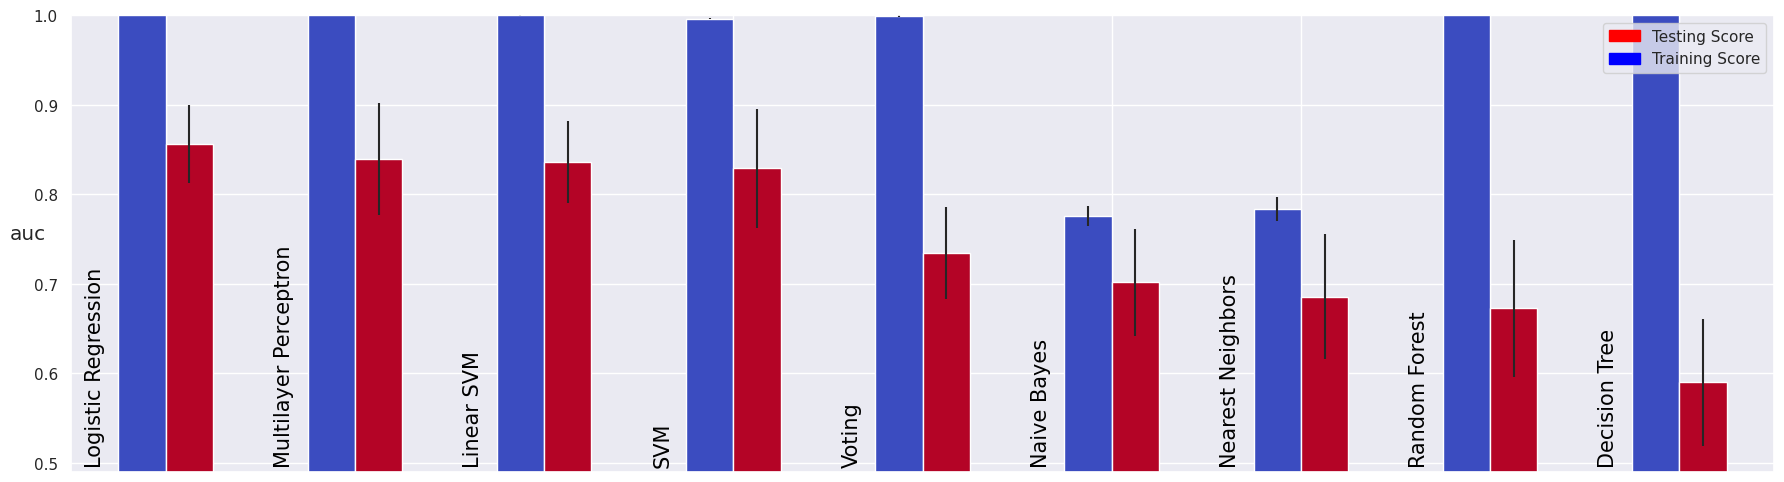

In [14]:
run_polyssifier.plot_scores()

2023-03-23 16:11:21,657 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2023-03-23 16:11:21,965 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2023-03-23 16:11:22,258 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2023-03-23 16:11:22,580 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


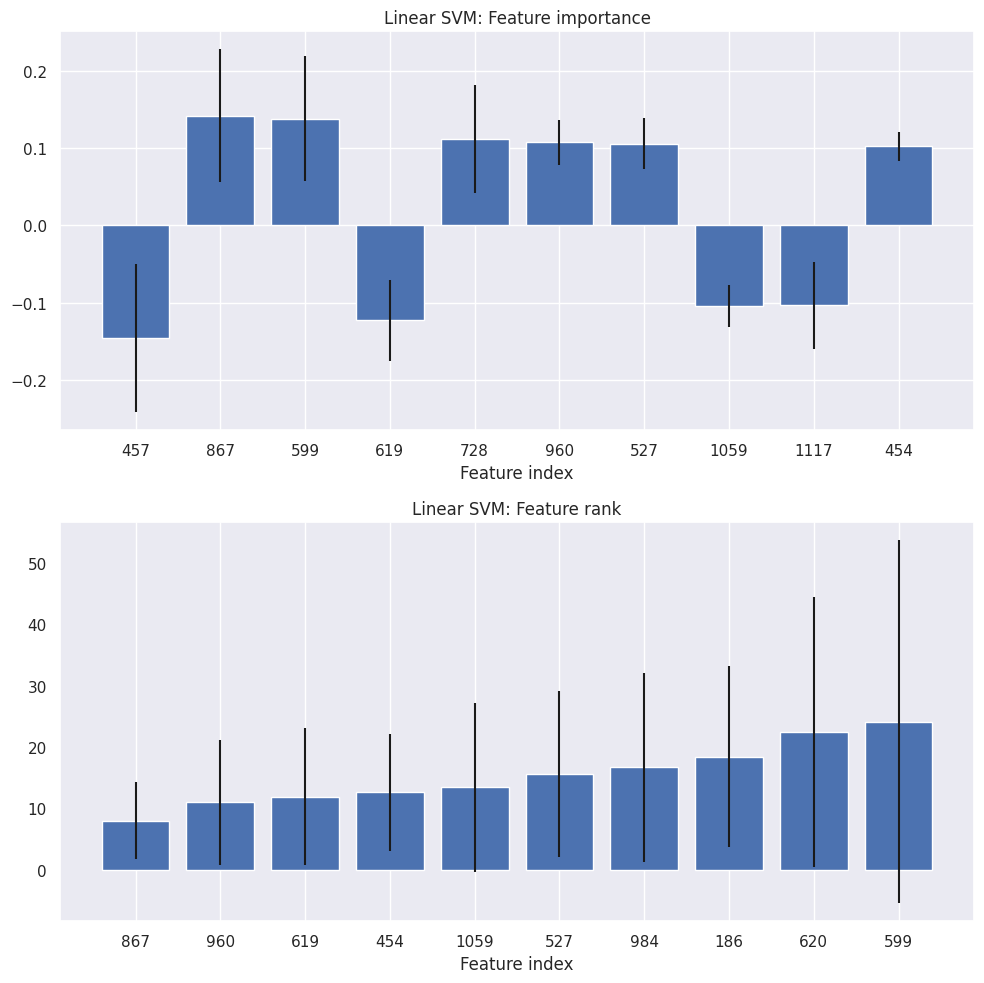

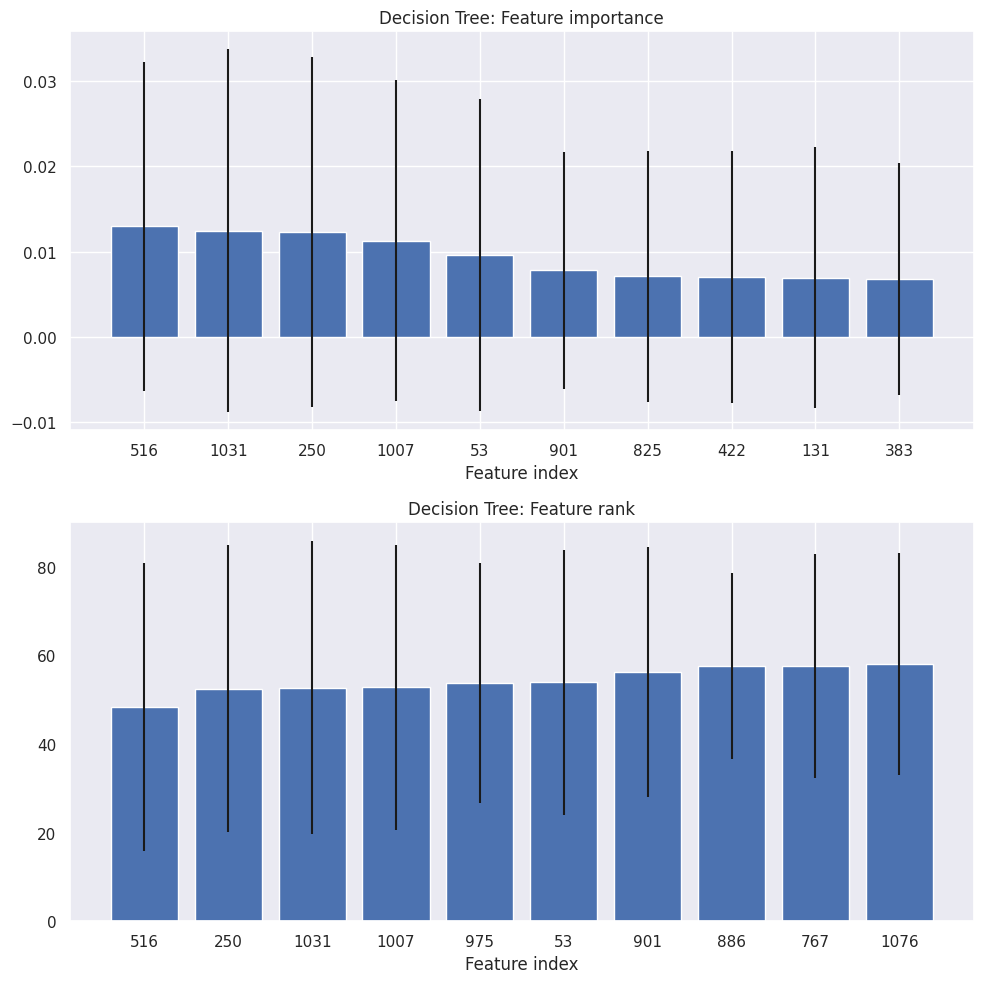

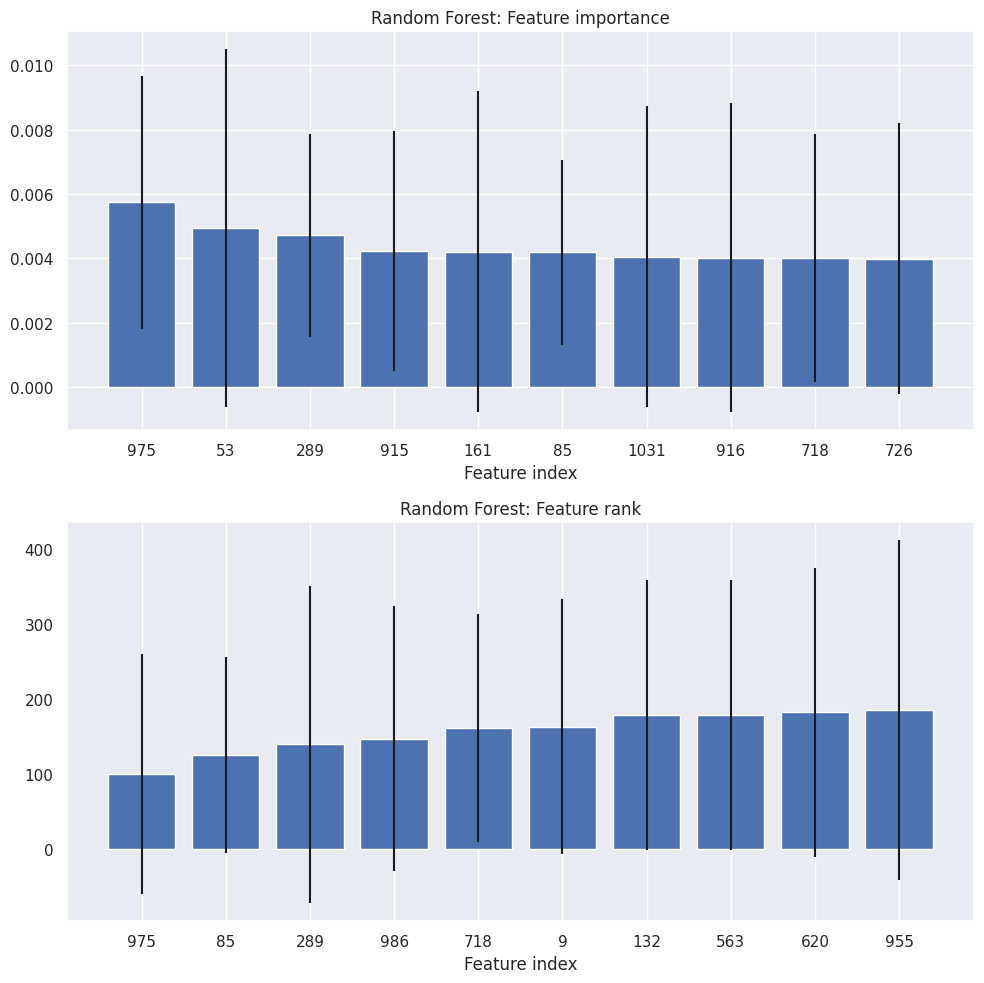

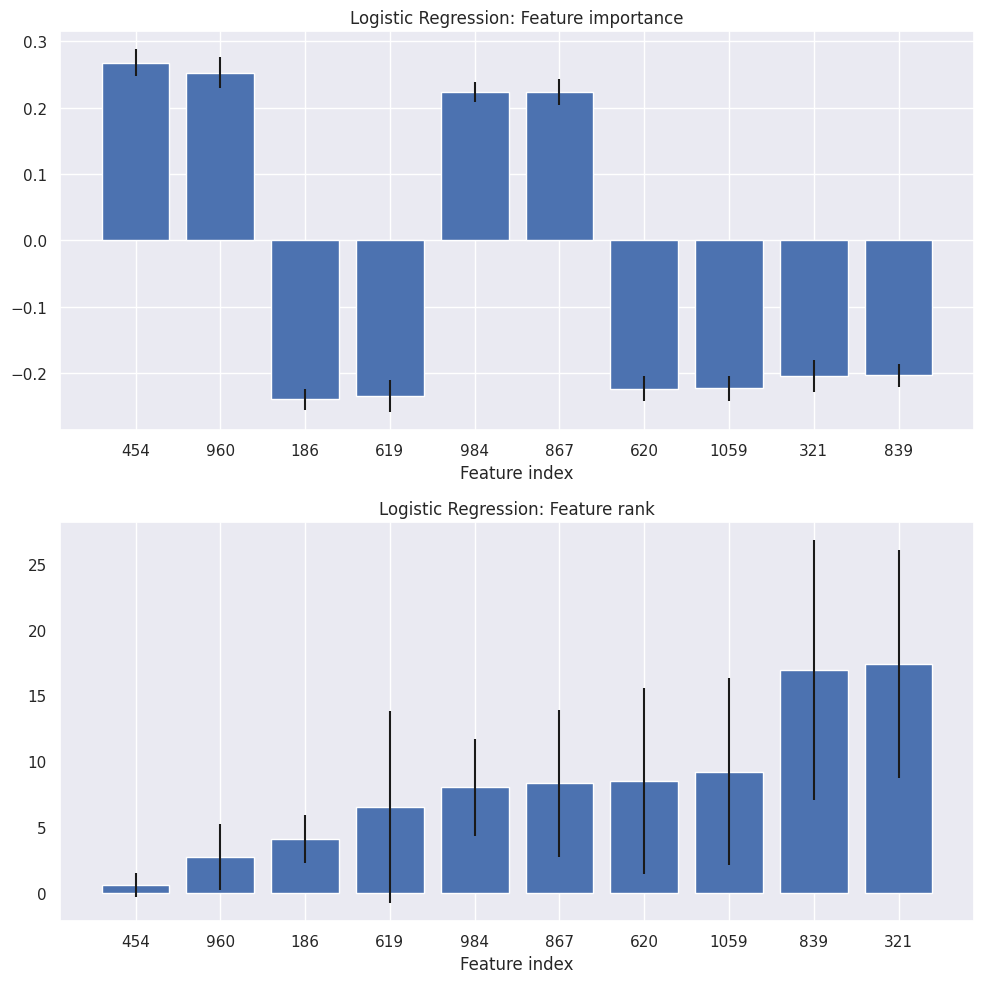

In [15]:
run_polyssifier.plot_features(ntop=10)

# Logistic model regression

In [5]:
df_boot = pd.read_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}_{seed_name}_voxelcorrelations.nii.gz"
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)

data = {}

for seed in SEEDS:
    for sub in tqdm(df_boot["subject_label"]):
        img_path = img_tpl.format(seed_name=seed, participant_id=sub)
        data[(sub, seed)] = img4d2vector(img_path, masker)
        

/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/nilearn/datasets/atlas.py:288: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)
100%|█████████████████████████████████████████| 570/570 [02:17<00:00,  4.15it/s]


In [15]:
def machine_learning_logistic(x, y):
    # split the sample o training/test with a 80/20 % ratio 
    # and stratify sex by class, also shuffle the data
    X_train, X_test, y_train, y_test = train_test_split( 
                                                        x,  # x 
                                                        y,  # y 
                                                        test_size = 0.2, # 80%/20% split 
                                                        shuffle = True,  #shuffle dataset before splitting
                                                        stratify = y,  # keep distribution of sex_class consistent between train and test sets
                                                        random_state = 123) #same shuffle each time 

    print('train:', len(X_train),'test:', len(X_test))
    
    
    score = []
    model = LogisticRegression(random_state = 123)
    score.append(cross_val_score(model, X_train, y_train, cv=10, n_jobs = 3))
    print(score)
    
    
    model.fit(X_train,y_train) #fit the model/ train the model
    y_pred = model.predict(X_test)

    #calculate the model accuracy
    acc_test = model.score(X_test, y_test)
    acc_train = model.score(X_train, y_train) 

    #compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    df_result = pd.DataFrame(data=[[tp, fn],[fp,tn]], index= ["Femme", "Homme"], columns = ["Femme", "Homme"])
    df_result = df_result.rename_axis("actual class")
    df_result = df_result.rename_axis("predicted class", axis="columns")
    print(df_result)
    
    # print results
    print('accuracy test (r2) =', acc_test)
    print('accuracy train (r2) =', acc_train)
    
    return {
        "len_X_train": len(X_train),
        "len_X_test": len(X_test),
        "score": score,
        "confusion_matrix": df_result,
        "acc_test": acc_test,
        "acc_train": acc_train,
        "model": model,
    }

In [16]:
def run_logistic(df_boot, data, seed):

    # print(df_bootstrap["Gender"])  # should have the whole list

    x_correl = []
    nb_subjects = len(df_boot)
    subject_label = df_boot["subject_label"][:nb_subjects]

    x_correl = []
    for sub in tqdm(subject_label):
        for seed_name in seed:
            x_correl.append(data[sub, seed_name])

    x_correl = np.array(x_correl)
    x_correl = x_correl.reshape(len(df_boot), len(seed)*148)  # autant de lignes que de sujets, autant de colones (nb region atlas x 8 (seeds))


    y_sex = df_boot["Gender"][:nb_subjects]  # maybe list(df["Gender"])

    coef = machine_learning_logistic(x_correl, y_sex)

    return x_correl

In [17]:
run_logistic = run(df_boot, data, SEEDS)

100%|█████████████████████████████████████| 570/570 [00:00<00:00, 340757.31it/s]

train: 456 test: 114


[array([0.93478261, 0.7826087 , 0.82608696, 0.73913043, 0.7173913 ,
       0.65217391, 0.8       , 0.77777778, 0.77777778, 0.71111111])]
predicted class  Femme  Homme
actual class                 
Femme               41     20
Homme               14     39
accuracy test (r2) = 0.7017543859649122
accuracy train (r2) = 1.0


/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

# Polyssifier seed by seed

In [8]:
df_boot = pd.read_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}_{seed_name}_voxelcorrelations.nii.gz"
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)

data = {}

for seed in SEEDS:
    for sub in tqdm(df_boot["subject_label"]):
        img_path = img_tpl.format(seed_name=seed, participant_id=sub)
        data[(sub, seed)] = img4d2vector(img_path, masker)

/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/nilearn/datasets/atlas.py:288: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)
100%|█████████████████████████████████████████| 570/570 [02:13<00:00,  4.28it/s]


## opIFG_L

100%|████████████████████████████████████| 570/570 [00:00<00:00, 1214813.66it/s]
2023-03-28 11:17:35,653 - polyssifier - INFO - Detected 2 classes in label
2023-03-28 11:17:35,653 - polyssifier - INFO - Building classifiers ...
2023-03-28 11:17:35,658 - polyssifier - INFO - Initialization, done.
2023-03-28 11:17:35,672 - polyssifier - INFO - Training Multilayer Perceptron 0
2023-03-28 11:17:38,709 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.87, 3.04 sec
2023-03-28 11:17:38,712 - polyssifier - INFO - Training Multilayer Perceptron 1
2023-03-28 11:17:41,484 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.85, 2.77 sec
2023-03-28 11:17:41,486 - polyssifier - INFO - Training Multilayer Perceptron 2
2023-03-28 11:17:44,381 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.89, 2.89 sec
2023-03-28 11:17:44,384 - polyssifier - INFO - Training Multilayer Perceptron 3
2023-03-28 11:17:47,122 - polyssifier - INFO - Multilayer P

predict proba return shape (57,)


2023-03-28 11:18:16,494 - polyssifier - INFO - Linear SVM                 1: Train 0.86/Test 0.62, 0.71 sec
2023-03-28 11:18:16,497 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2023-03-28 11:18:17,232 - polyssifier - INFO - Linear SVM                 2: Train 0.85/Test 0.82, 0.74 sec
2023-03-28 11:18:17,234 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2023-03-28 11:18:17,959 - polyssifier - INFO - Linear SVM                 3: Train 0.87/Test 0.59, 0.72 sec
2023-03-28 11:18:17,962 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2023-03-28 11:18:18,693 - polyssifier - INFO - Linear SVM                 4: Train 0.86/Test 0.67, 0.73 sec
2023-03-28 11:18:18,698 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2023-03-28 11:18:19,431 - polyssifier - INFO - Linear SVM                 5: Train 0.85/Test 0.66, 0.73 sec
2023-03-28 11:18:19,434 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2023-03-28 11:18:20,166 - polyssifier - INFO - Linear SVM                 6: Train 0.86/Test 0.67, 0.73 sec
2023-03-28 11:18:20,169 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2023-03-28 11:18:20,892 - polyssifier - INFO - Linear SVM                 7: Train 0.86/Test 0.64, 0.72 sec
2023-03-28 11:18:20,895 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2023-03-28 11:18:21,608 - polyssifier - INFO - Linear SVM                 8: Train 0.86/Test 0.66, 0.71 sec
2023-03-28 11:18:21,611 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2023-03-28 11:18:22,335 - polyssifier - INFO - Linear SVM                 9: Train 0.85/Test 0.83, 0.72 sec
2023-03-28 11:18:22,338 - polyssifier - INFO - Training Decision Tree 0
2023-03-28 11:18:22,356 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.59, 0.02 sec
2023-03-28 11:18:22,364 - polyssifier - INFO - Training Decision Tree 1
2023-03-28 11:18:22,382 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.47, 0.02 sec
2023-03-28 11:18:22,385 - polyssifier - INFO - Training Decision Tree 2
2023-03-28 11:18:22,403 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.67, 0.02 sec
2023-03-28 11:18:22,405 - polyssifier - INFO - Training Decision Tree 3
2023-03-28 11:18:22,416 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.60, 0.01 sec
2023-03-28 11:18:22,417 - polyssifier - INFO - Training Decision Tree 4
2023-03-28 11:18:22,428 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.57, 0

predict proba return shape (57,)


2023-03-28 11:18:23,916 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.71, 1.42 sec
2023-03-28 11:18:23,921 - polyssifier - INFO - Training Random Forest 1
2023-03-28 11:18:25,336 - polyssifier - INFO - Random Forest              1: Train 1.00/Test 0.77, 1.41 sec
2023-03-28 11:18:25,340 - polyssifier - INFO - Training Random Forest 2
2023-03-28 11:18:26,748 - polyssifier - INFO - Random Forest              2: Train 1.00/Test 0.67, 1.41 sec
2023-03-28 11:18:26,752 - polyssifier - INFO - Training Random Forest 3
2023-03-28 11:18:28,220 - polyssifier - INFO - Random Forest              3: Train 1.00/Test 0.70, 1.47 sec
2023-03-28 11:18:28,224 - polyssifier - INFO - Training Random Forest 4
2023-03-28 11:18:29,645 - polyssifier - INFO - Random Forest              4: Train 1.00/Test 0.59, 1.42 sec
2023-03-28 11:18:29,650 - polyssifier - INFO - Training Random Forest 5
2023-03-28 11:18:31,073 - polyssifier - INFO - Random Forest              5: Train 1.00/Test 0.74, 1

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.829306  0.058689  0.710918  0.893827
Nearest Neighbors     train  0.791215  0.018828  0.767848  0.827288
                      test   0.715429  0.082641  0.580025  0.830864
SVM                   train  0.967369  0.003880  0.961054  0.973804
                      test   0.796158  0.069991  0.712779  0.887654
Linear SVM            train  0.857805  0.006473  0.847257  0.869275
                      test   0.683520  0.078891  0.591358  0.830025
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.581473  0.062637  0.470370  0.666667
Random Forest         train  0.999983  0.000022  0.999947  1.000000
                      test   0.699517  0.053165  0.591811  0.767901
Logistic Regression   train  0.734662  0.044985  0.705329  0.860943
                      test   0.671967  0.073299 

2023-03-28 11:18:45,237 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2023-03-28 11:18:45,686 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2023-03-28 11:18:45,977 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2023-03-28 11:18:46,282 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


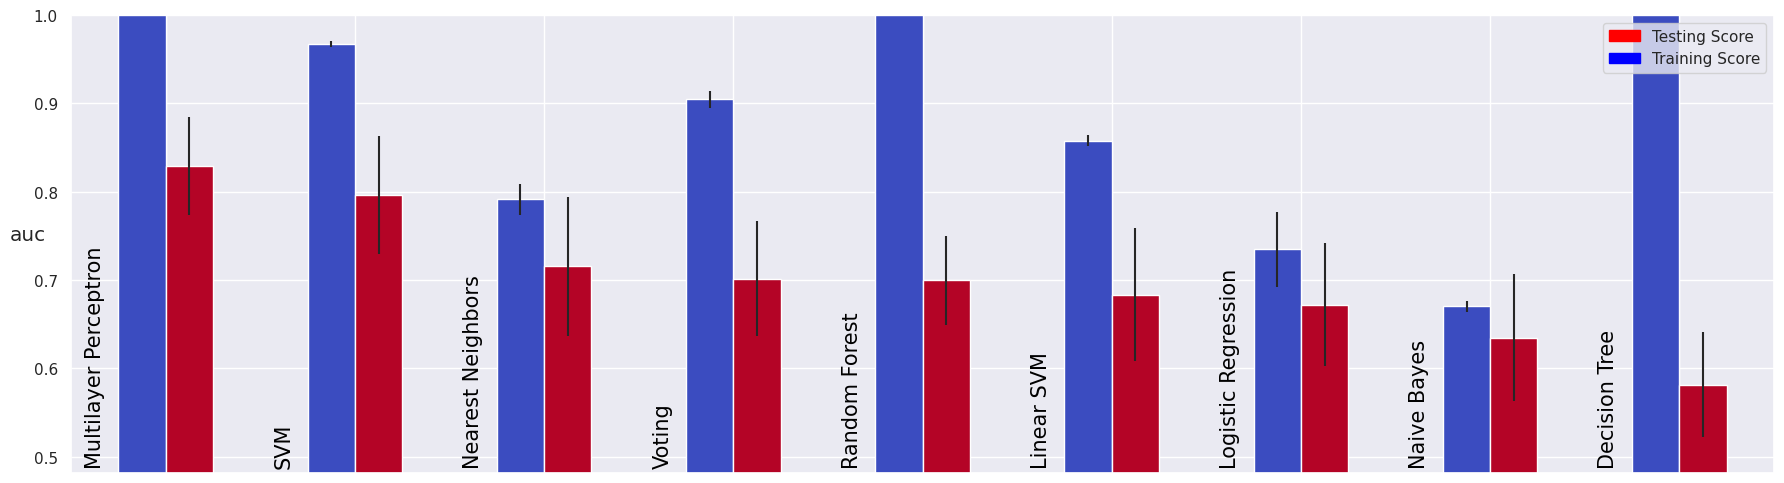

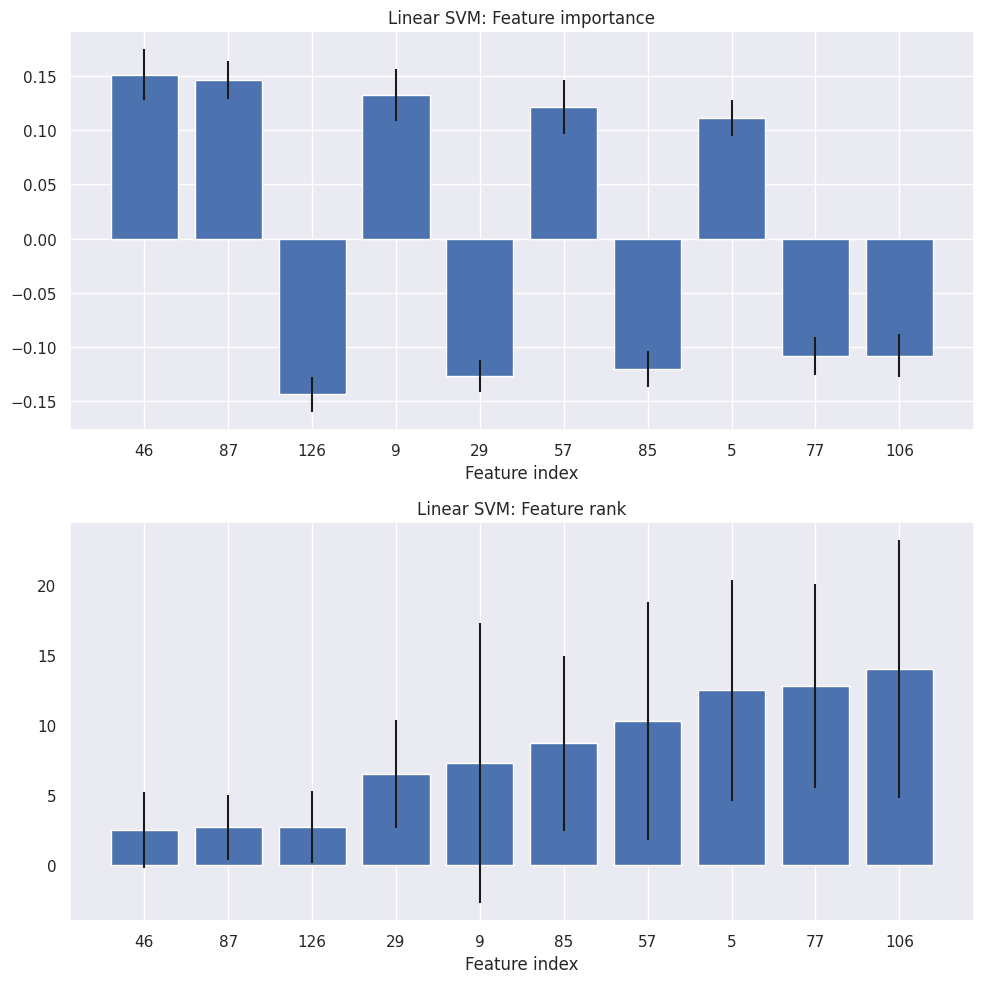

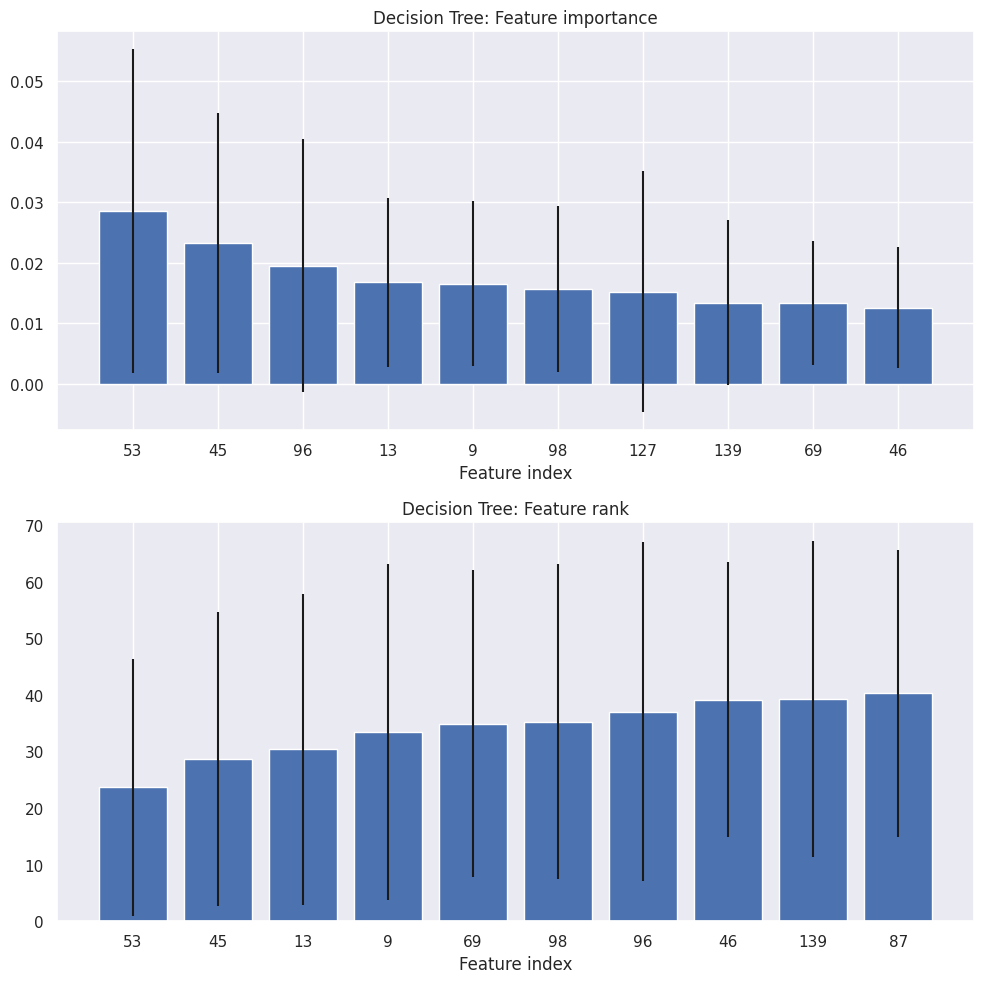

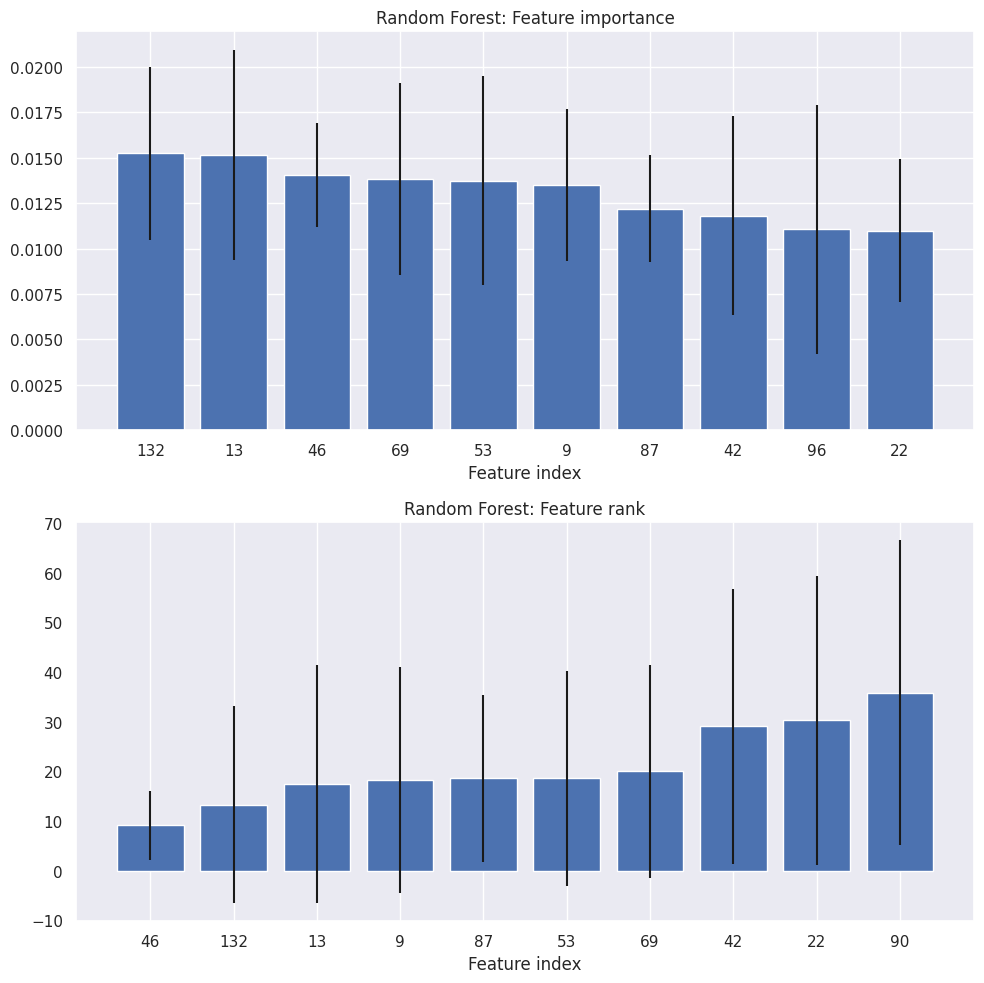

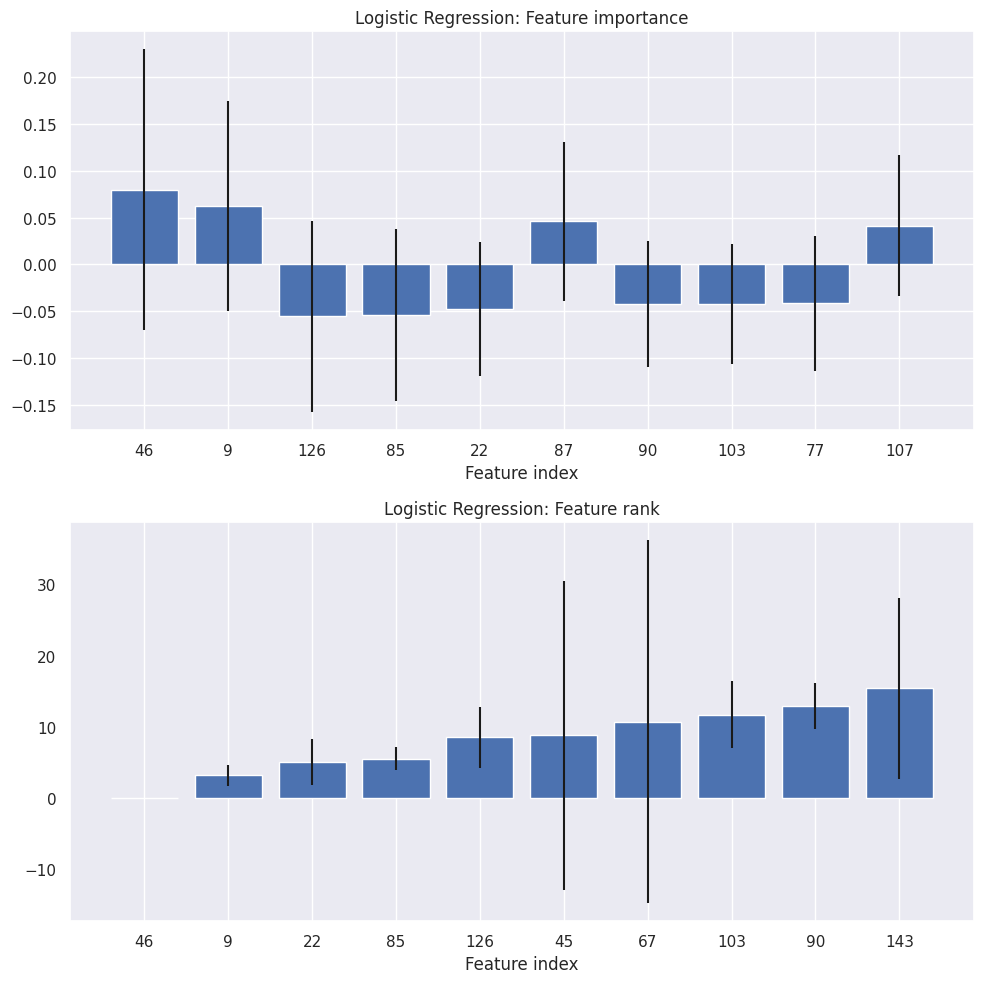

In [12]:
seed = ["opIFG_L"]

run_opIFG_L = run_poly(df_boot, data, seed)
run_opIFG_L.plot_scores()
run_opIFG_L.plot_features(ntop=10)

## Planumtemp_L

100%|█████████████████████████████████████| 570/570 [00:00<00:00, 814012.01it/s]
2023-03-28 11:23:05,195 - polyssifier - INFO - Detected 2 classes in label
2023-03-28 11:23:05,195 - polyssifier - INFO - Building classifiers ...
2023-03-28 11:23:05,202 - polyssifier - INFO - Initialization, done.
2023-03-28 11:23:05,222 - polyssifier - INFO - Training Multilayer Perceptron 0
2023-03-28 11:23:08,134 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.88, 2.91 sec
2023-03-28 11:23:08,136 - polyssifier - INFO - Training Multilayer Perceptron 1
2023-03-28 11:23:11,113 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.75, 2.98 sec
2023-03-28 11:23:11,116 - polyssifier - INFO - Training Multilayer Perceptron 2
2023-03-28 11:23:13,840 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.80, 2.72 sec
2023-03-28 11:23:13,843 - polyssifier - INFO - Training Multilayer Perceptron 3
2023-03-28 11:23:16,938 - polyssifier - INFO - Multilayer P

predict proba return shape (57,)


2023-03-28 11:23:47,998 - polyssifier - INFO - Linear SVM                 1: Train 0.88/Test 0.62, 0.73 sec
2023-03-28 11:23:48,001 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2023-03-28 11:23:48,723 - polyssifier - INFO - Linear SVM                 2: Train 0.87/Test 0.74, 0.72 sec
2023-03-28 11:23:48,726 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2023-03-28 11:23:49,460 - polyssifier - INFO - Linear SVM                 3: Train 0.87/Test 0.70, 0.73 sec
2023-03-28 11:23:49,463 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2023-03-28 11:23:50,173 - polyssifier - INFO - Linear SVM                 4: Train 0.88/Test 0.73, 0.71 sec
2023-03-28 11:23:50,176 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2023-03-28 11:23:50,909 - polyssifier - INFO - Linear SVM                 5: Train 0.87/Test 0.68, 0.73 sec
2023-03-28 11:23:50,911 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2023-03-28 11:23:51,641 - polyssifier - INFO - Linear SVM                 6: Train 0.86/Test 0.75, 0.73 sec
2023-03-28 11:23:51,643 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2023-03-28 11:23:52,355 - polyssifier - INFO - Linear SVM                 7: Train 0.87/Test 0.72, 0.71 sec
2023-03-28 11:23:52,357 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2023-03-28 11:23:53,058 - polyssifier - INFO - Linear SVM                 8: Train 0.88/Test 0.65, 0.70 sec
2023-03-28 11:23:53,061 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2023-03-28 11:23:53,796 - polyssifier - INFO - Linear SVM                 9: Train 0.87/Test 0.68, 0.74 sec
2023-03-28 11:23:53,799 - polyssifier - INFO - Training Decision Tree 0
2023-03-28 11:23:53,813 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.57, 0.01 sec
2023-03-28 11:23:53,816 - polyssifier - INFO - Training Decision Tree 1
2023-03-28 11:23:53,831 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.47, 0.02 sec
2023-03-28 11:23:53,834 - polyssifier - INFO - Training Decision Tree 2
2023-03-28 11:23:53,850 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.54, 0.02 sec
2023-03-28 11:23:53,852 - polyssifier - INFO - Training Decision Tree 3
2023-03-28 11:23:53,866 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.63, 0.01 sec
2023-03-28 11:23:53,868 - polyssifier - INFO - Training Decision Tree 4
2023-03-28 11:23:53,878 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.56, 0

predict proba return shape (57,)


2023-03-28 11:23:55,360 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.81, 1.42 sec
2023-03-28 11:23:55,364 - polyssifier - INFO - Training Random Forest 1
2023-03-28 11:23:56,739 - polyssifier - INFO - Random Forest              1: Train 1.00/Test 0.64, 1.37 sec
2023-03-28 11:23:56,743 - polyssifier - INFO - Training Random Forest 2
2023-03-28 11:23:58,156 - polyssifier - INFO - Random Forest              2: Train 1.00/Test 0.77, 1.41 sec
2023-03-28 11:23:58,160 - polyssifier - INFO - Training Random Forest 3
2023-03-28 11:23:59,576 - polyssifier - INFO - Random Forest              3: Train 1.00/Test 0.84, 1.42 sec
2023-03-28 11:23:59,581 - polyssifier - INFO - Training Random Forest 4
2023-03-28 11:24:01,007 - polyssifier - INFO - Random Forest              4: Train 1.00/Test 0.68, 1.43 sec
2023-03-28 11:24:01,011 - polyssifier - INFO - Training Random Forest 5
2023-03-28 11:24:02,448 - polyssifier - INFO - Random Forest              5: Train 1.00/Test 0.60, 1

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.785701  0.070128  0.656328  0.883951
Nearest Neighbors     train  0.807499  0.010201  0.787456  0.821131
                      test   0.733061  0.068071  0.658809  0.872222
SVM                   train  0.963177  0.002590  0.959679  0.968419
                      test   0.791728  0.069646  0.674938  0.886420
Linear SVM            train  0.870170  0.007944  0.856815  0.882560
                      test   0.714430  0.067192  0.620988  0.865432
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.563540  0.066729  0.453474  0.649504
Random Forest         train  0.999975  0.000036  0.999908  1.000000
                      test   0.701581  0.084260  0.600496  0.840123
Logistic Regression   train  0.880522  0.006256  0.867058  0.889152
                      test   0.721253  0.069402 

2023-03-28 11:24:14,027 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2023-03-28 11:24:14,404 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2023-03-28 11:24:14,704 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2023-03-28 11:24:14,997 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


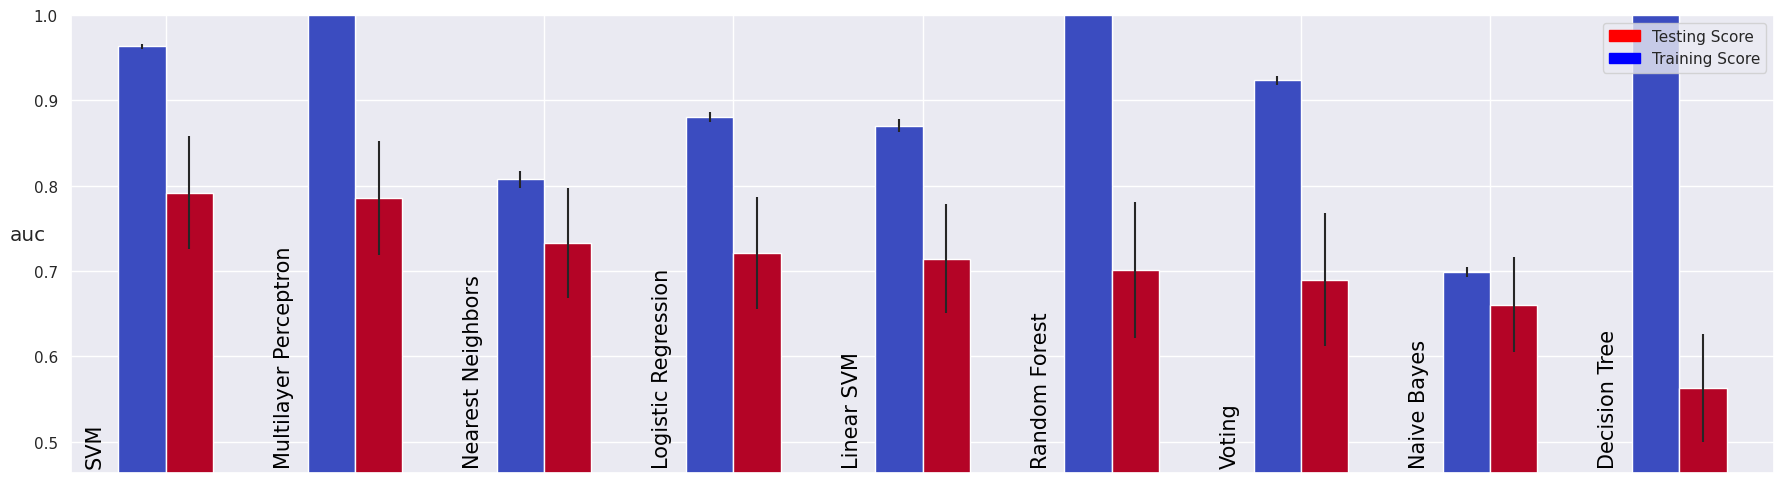

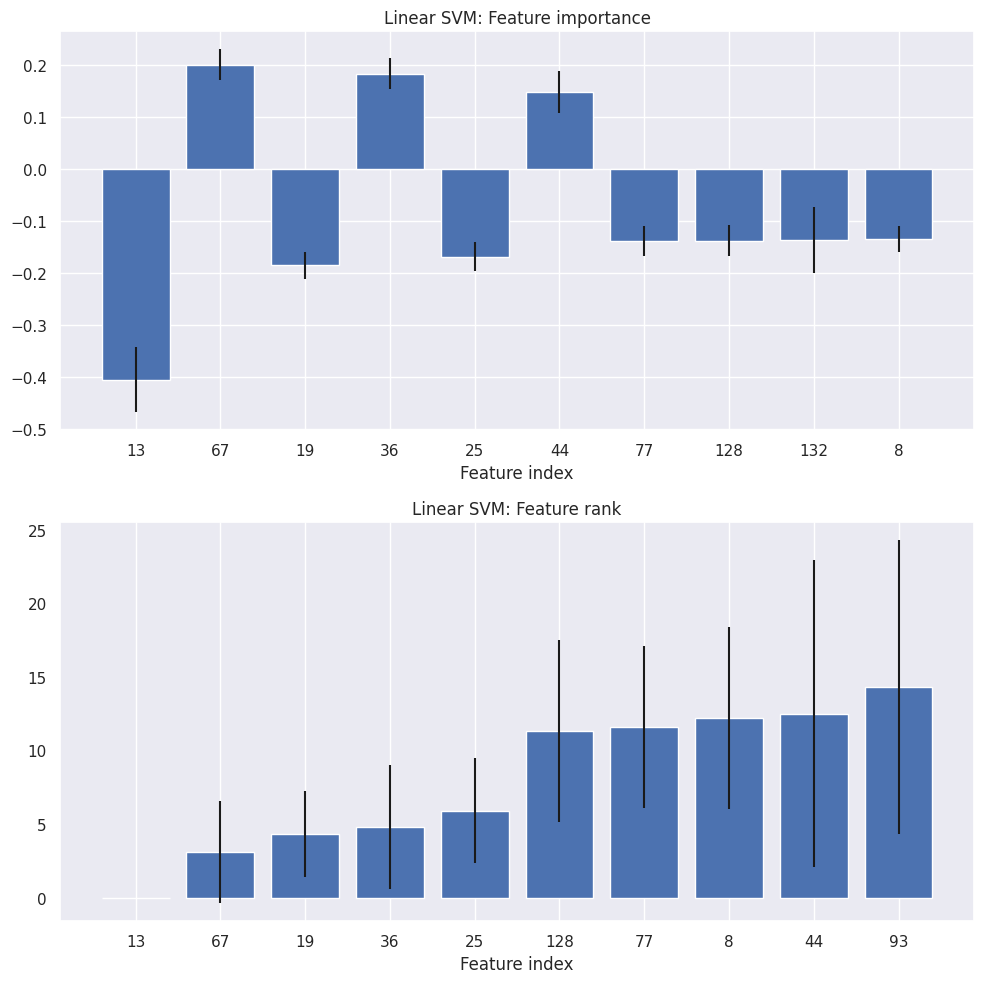

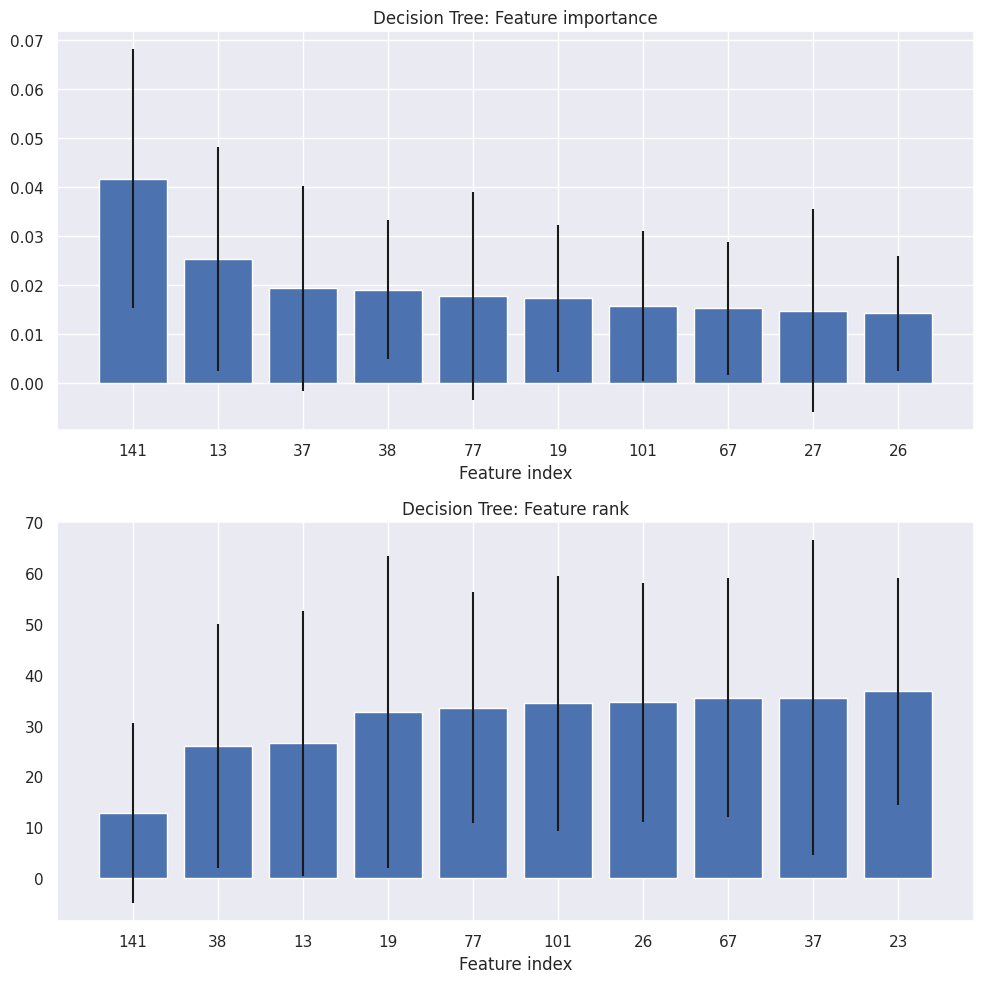

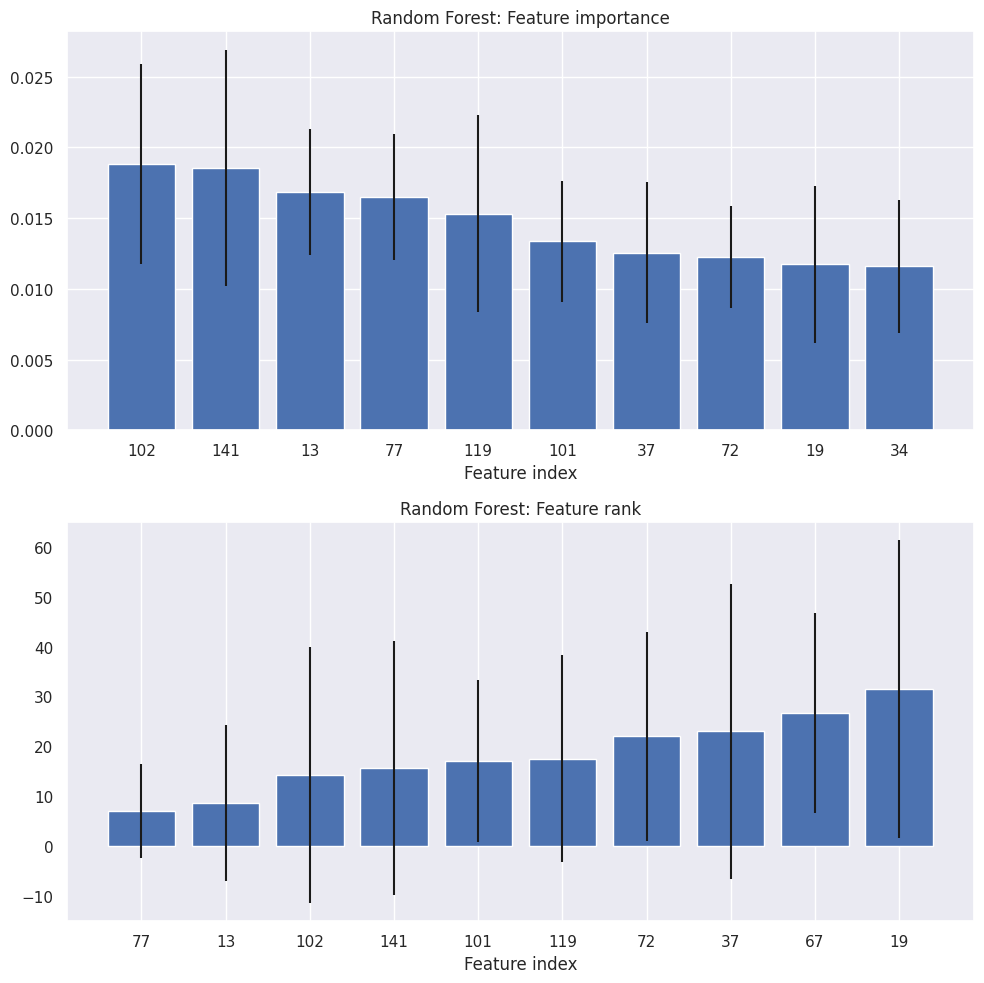

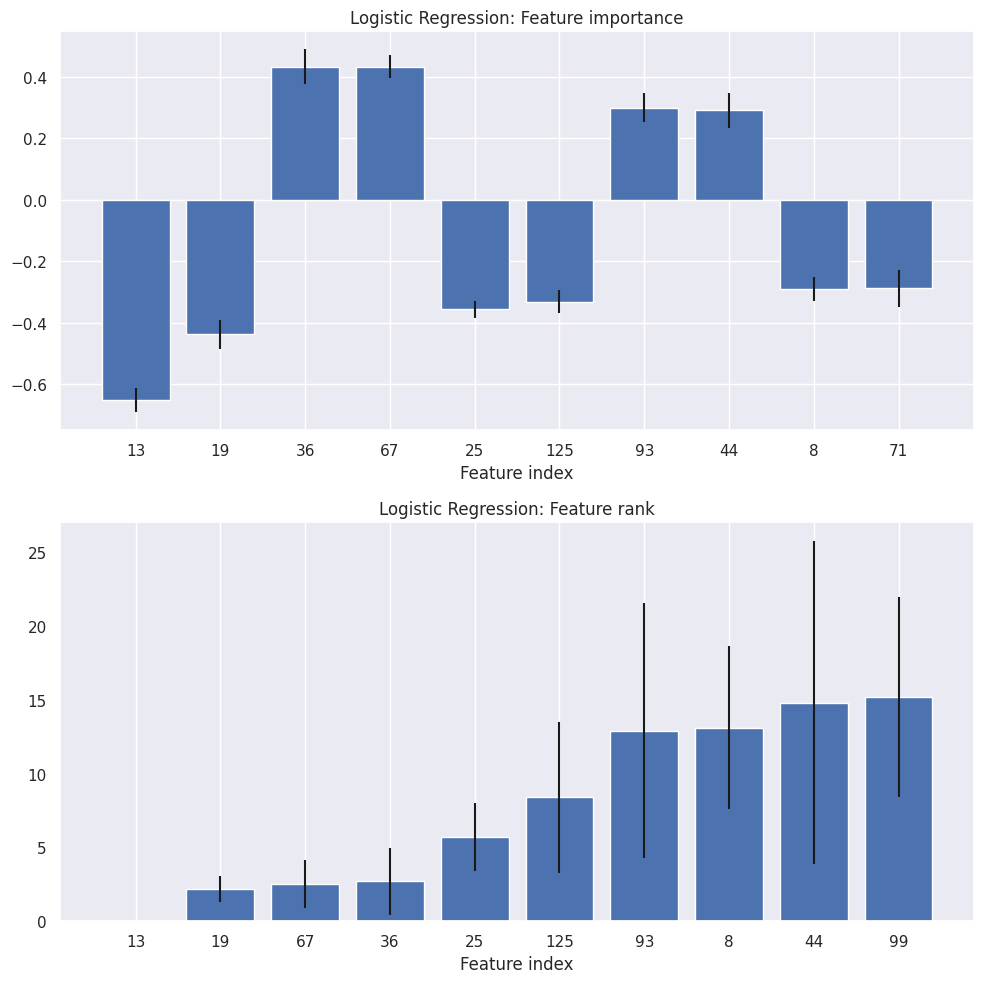

In [13]:
seed = ["planumtemp_L"]

run_planumtemp_L = run_poly(df_boot, data, seed)
run_planumtemp_L.plot_scores()
run_planumtemp_L.plot_features(ntop=10)

## aMTG_L

2023-03-28 11:27:22,022 - polyssifier - INFO - Detected 2 classes in label
2023-03-28 11:27:22,023 - polyssifier - INFO - Building classifiers ...
2023-03-28 11:27:22,026 - polyssifier - INFO - Initialization, done.
2023-03-28 11:27:22,044 - polyssifier - INFO - Training Multilayer Perceptron 0
2023-03-28 11:27:25,173 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.89, 3.13 sec
2023-03-28 11:27:25,176 - polyssifier - INFO - Training Multilayer Perceptron 1
2023-03-28 11:27:28,106 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.87, 2.93 sec
2023-03-28 11:27:28,109 - polyssifier - INFO - Training Multilayer Perceptron 2
2023-03-28 11:27:30,815 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.84, 2.71 sec
2023-03-28 11:27:30,818 - polyssifier - INFO - Training Multilayer Perceptron 3
2023-03-28 11:27:33,586 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.88, 2.77 sec
2023-03-28 11:27:33,589 - polyss

predict proba return shape (57,)


2023-03-28 11:28:01,612 - polyssifier - INFO - Linear SVM                 1: Train 0.85/Test 0.80, 0.78 sec
2023-03-28 11:28:01,615 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2023-03-28 11:28:02,406 - polyssifier - INFO - Linear SVM                 2: Train 0.86/Test 0.72, 0.79 sec
2023-03-28 11:28:02,409 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2023-03-28 11:28:03,313 - polyssifier - INFO - Linear SVM                 3: Train 0.86/Test 0.75, 0.90 sec
2023-03-28 11:28:03,316 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2023-03-28 11:28:04,186 - polyssifier - INFO - Linear SVM                 4: Train 0.86/Test 0.64, 0.87 sec
2023-03-28 11:28:04,189 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2023-03-28 11:28:05,020 - polyssifier - INFO - Linear SVM                 5: Train 0.87/Test 0.71, 0.83 sec
2023-03-28 11:28:05,023 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2023-03-28 11:28:05,730 - polyssifier - INFO - Linear SVM                 6: Train 0.88/Test 0.59, 0.71 sec
2023-03-28 11:28:05,732 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2023-03-28 11:28:06,439 - polyssifier - INFO - Linear SVM                 7: Train 0.86/Test 0.68, 0.71 sec
2023-03-28 11:28:06,442 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2023-03-28 11:28:07,168 - polyssifier - INFO - Linear SVM                 8: Train 0.85/Test 0.79, 0.73 sec
2023-03-28 11:28:07,171 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2023-03-28 11:28:07,878 - polyssifier - INFO - Linear SVM                 9: Train 0.88/Test 0.55, 0.71 sec
2023-03-28 11:28:07,881 - polyssifier - INFO - Training Decision Tree 0
2023-03-28 11:28:07,899 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.68, 0.02 sec
2023-03-28 11:28:07,902 - polyssifier - INFO - Training Decision Tree 1
2023-03-28 11:28:07,920 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.55, 0.02 sec
2023-03-28 11:28:07,923 - polyssifier - INFO - Training Decision Tree 2
2023-03-28 11:28:07,940 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.72, 0.02 sec
2023-03-28 11:28:07,941 - polyssifier - INFO - Training Decision Tree 3
2023-03-28 11:28:07,952 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.63, 0.01 sec
2023-03-28 11:28:07,954 - polyssifier - INFO - Training Decision Tree 4
2023-03-28 11:28:07,964 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.41, 0

predict proba return shape (57,)


2023-03-28 11:28:09,413 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.69, 1.39 sec
2023-03-28 11:28:09,417 - polyssifier - INFO - Training Random Forest 1
2023-03-28 11:28:10,821 - polyssifier - INFO - Random Forest              1: Train 1.00/Test 0.63, 1.40 sec
2023-03-28 11:28:10,825 - polyssifier - INFO - Training Random Forest 2
2023-03-28 11:28:12,223 - polyssifier - INFO - Random Forest              2: Train 1.00/Test 0.85, 1.40 sec
2023-03-28 11:28:12,227 - polyssifier - INFO - Training Random Forest 3
2023-03-28 11:28:13,616 - polyssifier - INFO - Random Forest              3: Train 1.00/Test 0.68, 1.39 sec
2023-03-28 11:28:13,620 - polyssifier - INFO - Training Random Forest 4
2023-03-28 11:28:15,044 - polyssifier - INFO - Random Forest              4: Train 1.00/Test 0.75, 1.42 sec
2023-03-28 11:28:15,049 - polyssifier - INFO - Training Random Forest 5
2023-03-28 11:28:16,461 - polyssifier - INFO - Random Forest              5: Train 1.00/Test 0.76, 1

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.832017  0.063785  0.735732  0.909429
Nearest Neighbors     train  0.844318  0.016814  0.815447  0.879961
                      test   0.730867  0.069770  0.613524  0.826303
SVM                   train  0.985711  0.001980  0.982572  0.989160
                      test   0.823872  0.042775  0.746898  0.879012
Linear SVM            train  0.860186  0.012360  0.846127  0.882842
                      test   0.701956  0.086297  0.545906  0.802469
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.587117  0.095741  0.408809  0.716667
Random Forest         train  0.999932  0.000096  0.999786  1.000000
                      test   0.715953  0.063610  0.630864  0.853086
Logistic Regression   train  0.868469  0.008116  0.858069  0.883040
                      test   0.698126  0.078182 

2023-03-28 11:28:27,840 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2023-03-28 11:28:28,197 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2023-03-28 11:28:28,654 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2023-03-28 11:28:28,994 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


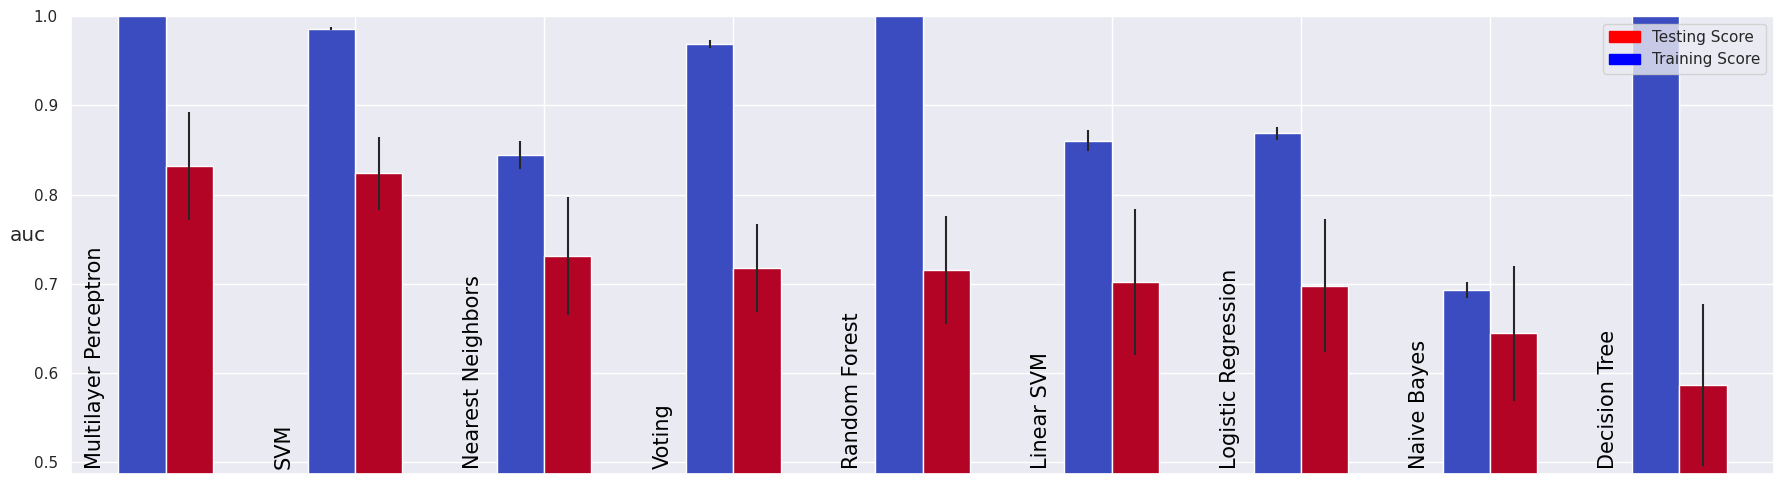

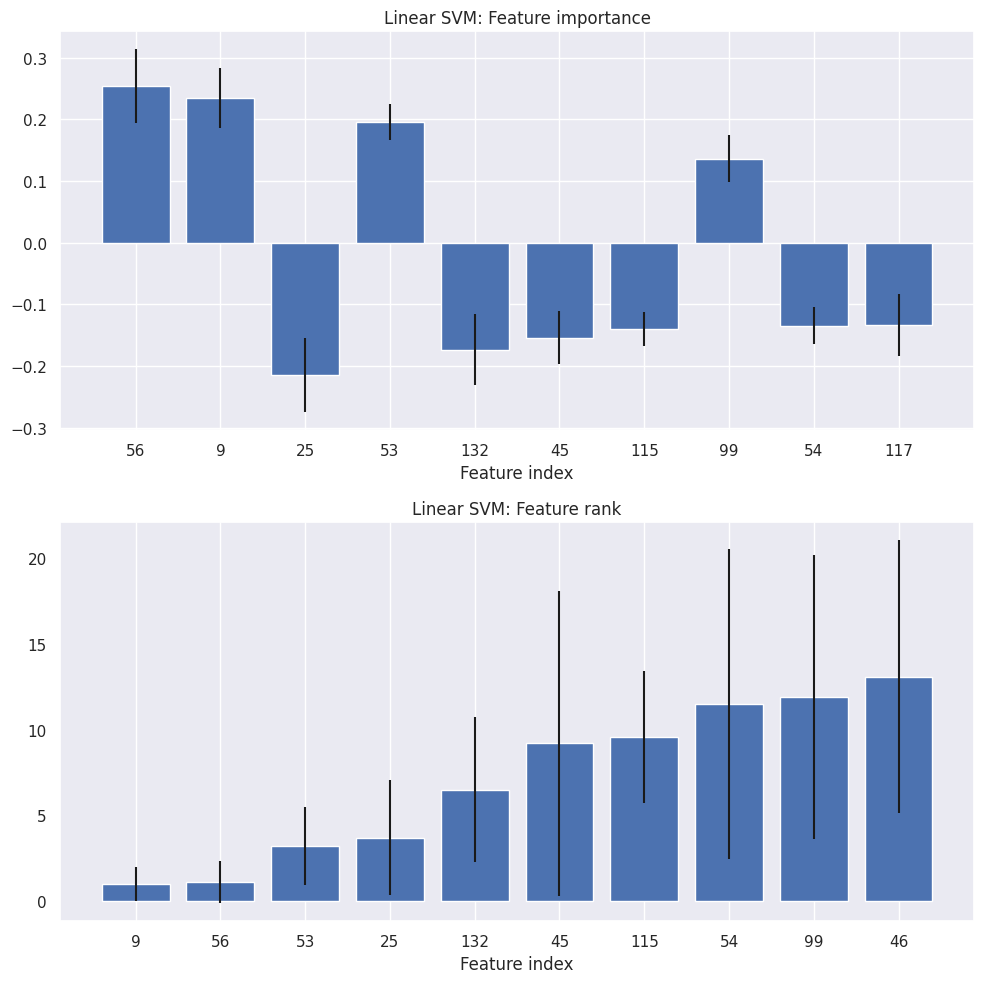

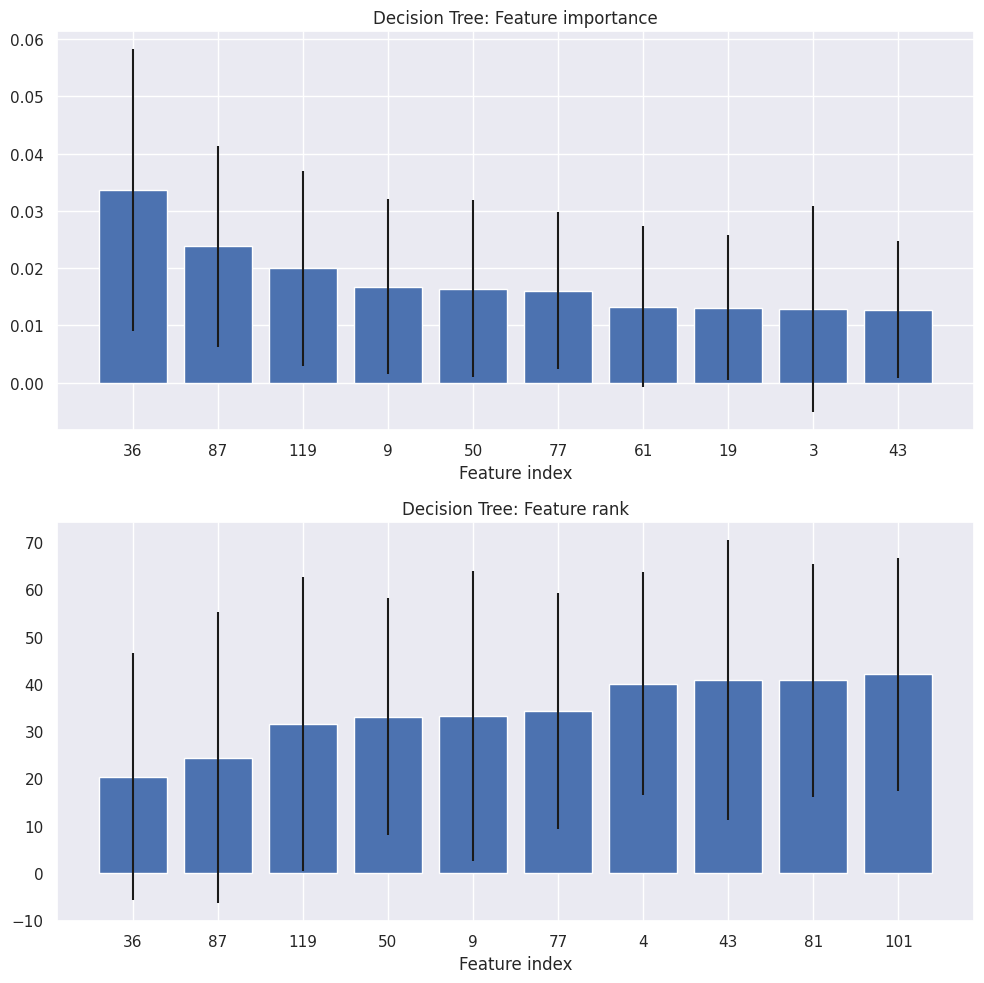

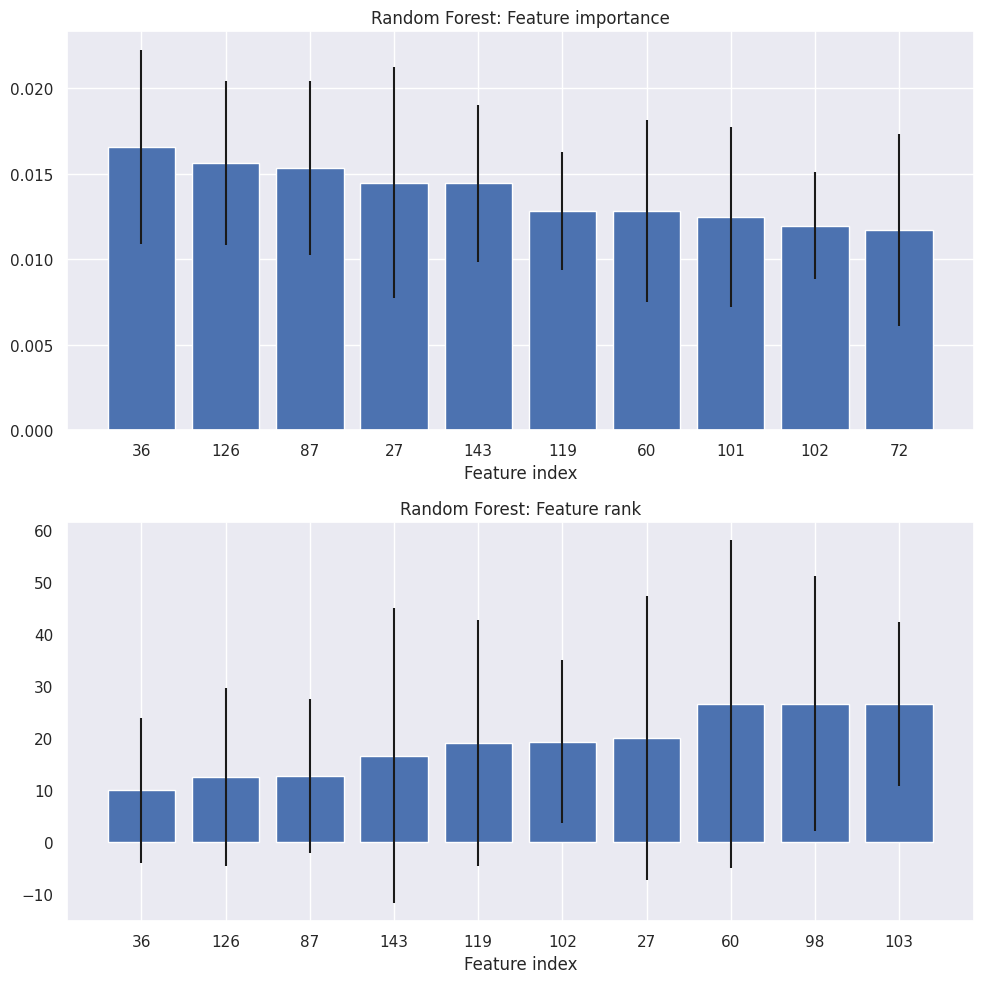

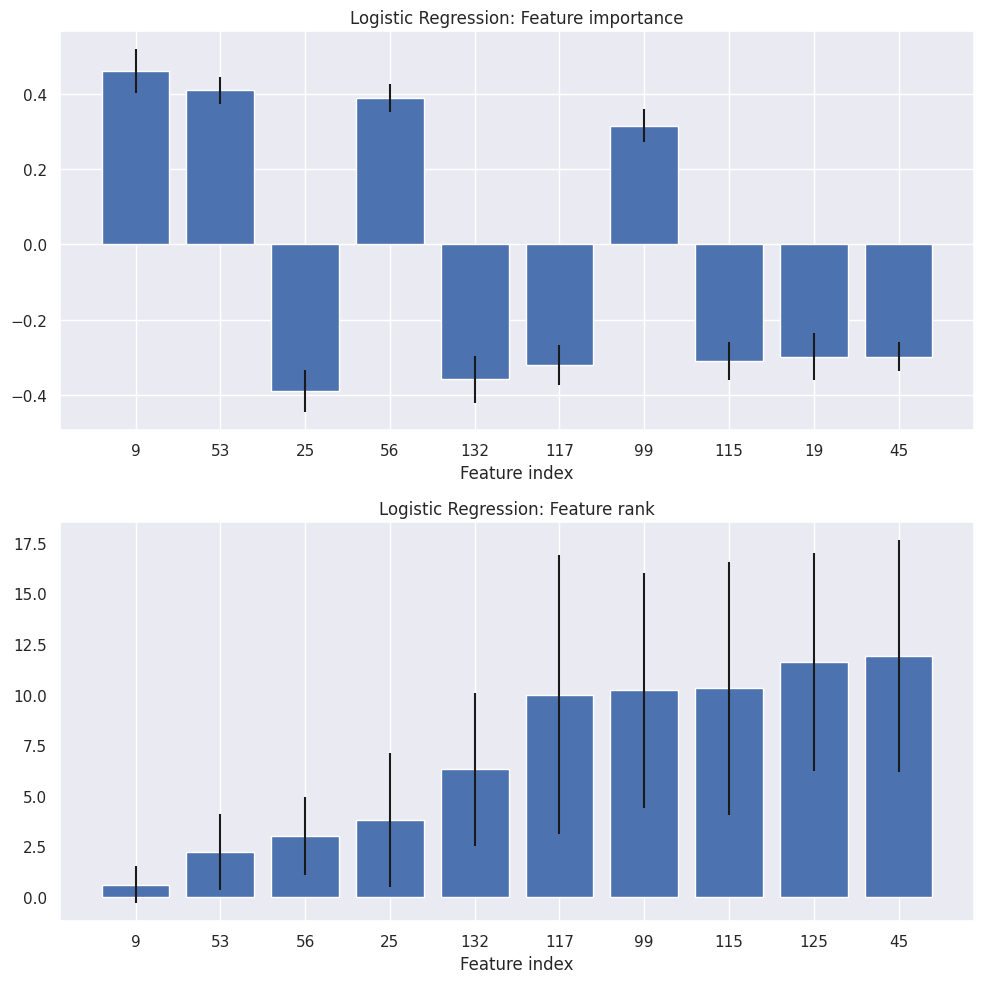

In [17]:
seed = ["aMTG_L"]

run_aMTG_L = run_poly(df_boot, data, seed)
run_aMTG_L.plot_scores()
run_aMTG_L.plot_features(ntop=10)

## pIFG_L

2023-03-28 11:30:00,759 - polyssifier - INFO - Detected 2 classes in label
2023-03-28 11:30:00,760 - polyssifier - INFO - Building classifiers ...
2023-03-28 11:30:00,766 - polyssifier - INFO - Initialization, done.
2023-03-28 11:30:00,783 - polyssifier - INFO - Training Multilayer Perceptron 0
2023-03-28 11:30:03,579 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.88, 2.80 sec
2023-03-28 11:30:03,581 - polyssifier - INFO - Training Multilayer Perceptron 1
2023-03-28 11:30:06,328 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.83, 2.75 sec
2023-03-28 11:30:06,331 - polyssifier - INFO - Training Multilayer Perceptron 2
2023-03-28 11:30:09,149 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.89, 2.82 sec
2023-03-28 11:30:09,152 - polyssifier - INFO - Training Multilayer Perceptron 3
2023-03-28 11:30:11,876 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.91, 2.72 sec
2023-03-28 11:30:11,878 - polyss

predict proba return shape (57,)


2023-03-28 11:30:40,439 - polyssifier - INFO - Linear SVM                 1: Train 0.84/Test 0.77, 0.74 sec
2023-03-28 11:30:40,442 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2023-03-28 11:30:41,166 - polyssifier - INFO - Linear SVM                 2: Train 0.86/Test 0.73, 0.72 sec
2023-03-28 11:30:41,168 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2023-03-28 11:30:41,881 - polyssifier - INFO - Linear SVM                 3: Train 0.86/Test 0.74, 0.71 sec
2023-03-28 11:30:41,883 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2023-03-28 11:30:42,572 - polyssifier - INFO - Linear SVM                 4: Train 0.88/Test 0.68, 0.69 sec
2023-03-28 11:30:42,574 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2023-03-28 11:30:43,267 - polyssifier - INFO - Linear SVM                 5: Train 0.87/Test 0.61, 0.69 sec
2023-03-28 11:30:43,270 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2023-03-28 11:30:43,981 - polyssifier - INFO - Linear SVM                 6: Train 0.86/Test 0.78, 0.71 sec
2023-03-28 11:30:43,984 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2023-03-28 11:30:44,688 - polyssifier - INFO - Linear SVM                 7: Train 0.86/Test 0.68, 0.70 sec
2023-03-28 11:30:44,691 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2023-03-28 11:30:45,407 - polyssifier - INFO - Linear SVM                 8: Train 0.86/Test 0.56, 0.72 sec
2023-03-28 11:30:45,409 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2023-03-28 11:30:46,115 - polyssifier - INFO - Linear SVM                 9: Train 0.85/Test 0.72, 0.71 sec
2023-03-28 11:30:46,118 - polyssifier - INFO - Training Decision Tree 0
2023-03-28 11:30:46,135 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.65, 0.02 sec
2023-03-28 11:30:46,138 - polyssifier - INFO - Training Decision Tree 1
2023-03-28 11:30:46,157 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.65, 0.02 sec
2023-03-28 11:30:46,160 - polyssifier - INFO - Training Decision Tree 2
2023-03-28 11:30:46,176 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.60, 0.02 sec
2023-03-28 11:30:46,178 - polyssifier - INFO - Training Decision Tree 3
2023-03-28 11:30:46,189 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.63, 0.01 sec
2023-03-28 11:30:46,190 - polyssifier - INFO - Training Decision Tree 4
2023-03-28 11:30:46,200 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.46, 0

predict proba return shape (57,)


2023-03-28 11:30:47,664 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.69, 1.40 sec
2023-03-28 11:30:47,668 - polyssifier - INFO - Training Random Forest 1
2023-03-28 11:30:49,131 - polyssifier - INFO - Random Forest              1: Train 1.00/Test 0.57, 1.46 sec
2023-03-28 11:30:49,135 - polyssifier - INFO - Training Random Forest 2
2023-03-28 11:30:50,549 - polyssifier - INFO - Random Forest              2: Train 1.00/Test 0.83, 1.41 sec
2023-03-28 11:30:50,554 - polyssifier - INFO - Training Random Forest 3
2023-03-28 11:30:51,967 - polyssifier - INFO - Random Forest              3: Train 1.00/Test 0.76, 1.41 sec
2023-03-28 11:30:51,971 - polyssifier - INFO - Training Random Forest 4
2023-03-28 11:30:53,396 - polyssifier - INFO - Random Forest              4: Train 1.00/Test 0.52, 1.43 sec
2023-03-28 11:30:53,401 - polyssifier - INFO - Training Random Forest 5
2023-03-28 11:30:54,819 - polyssifier - INFO - Random Forest              5: Train 1.00/Test 0.58, 1

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.858803  0.051311  0.774194  0.921836
Nearest Neighbors     train  0.821296  0.031886  0.788617  0.870604
                      test   0.701388  0.087438  0.563275  0.865385
SVM                   train  0.973535  0.002502  0.970298  0.979259
                      test   0.824434  0.065332  0.729529  0.920596
Linear SVM            train  0.860058  0.010123  0.841482  0.876975
                      test   0.701492  0.071951  0.557072  0.779156
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.616237  0.066459  0.463400  0.691067
Random Forest         train  0.999976  0.000040  0.999878  1.000000
                      test   0.674142  0.100041  0.522333  0.833333
Logistic Regression   train  0.868294  0.006430  0.856632  0.877876
                      test   0.709669  0.071217 

2023-03-28 11:31:06,379 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2023-03-28 11:31:06,670 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2023-03-28 11:31:06,963 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2023-03-28 11:31:07,259 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


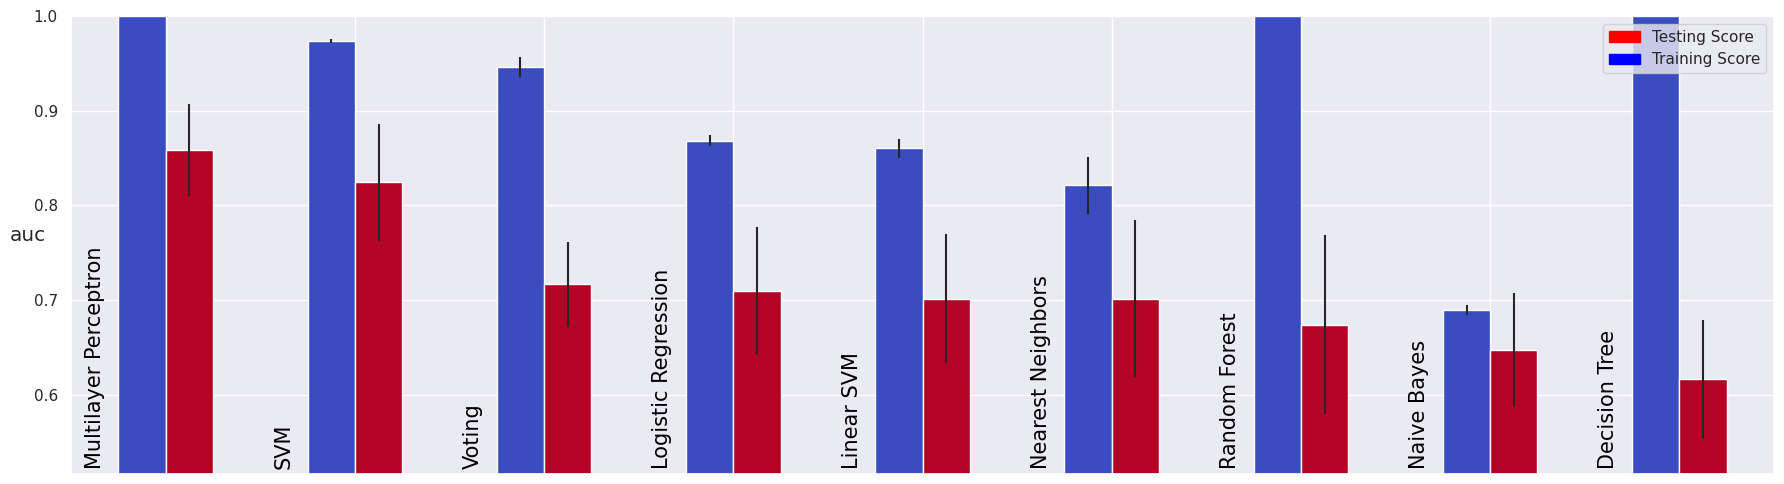

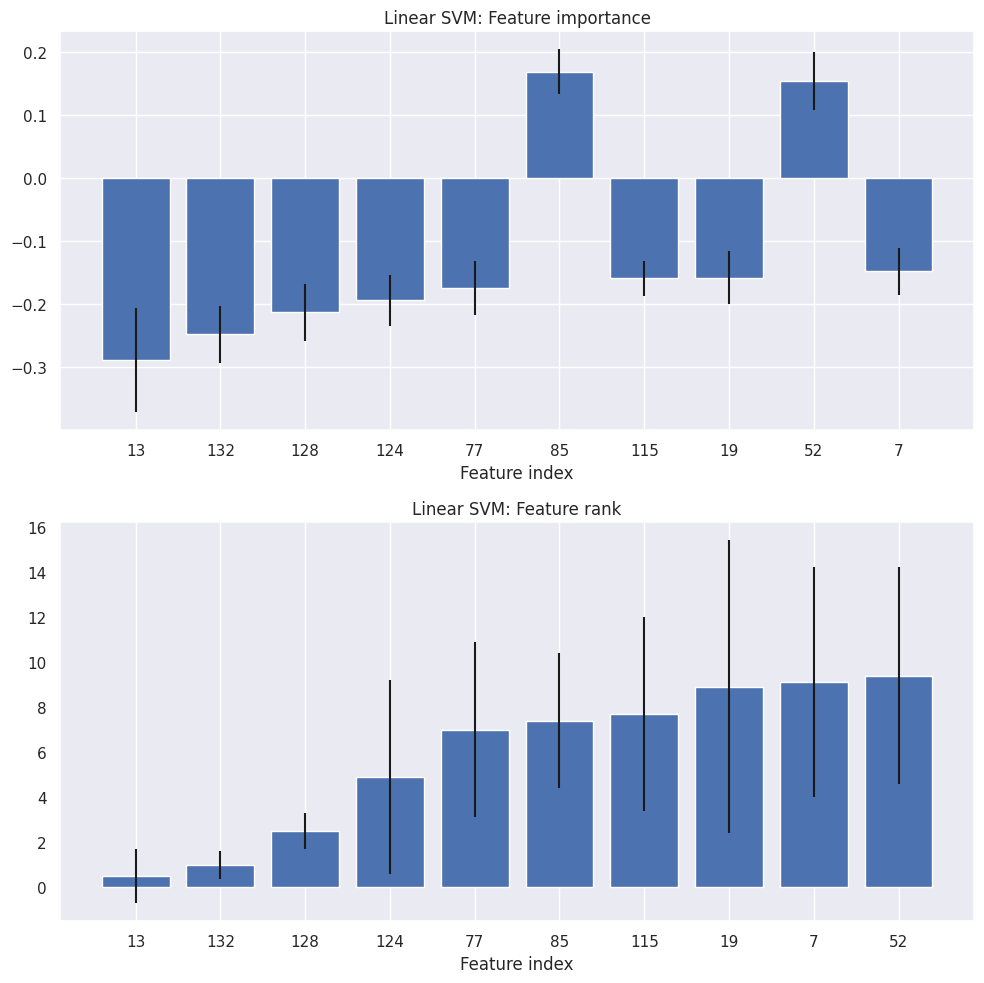

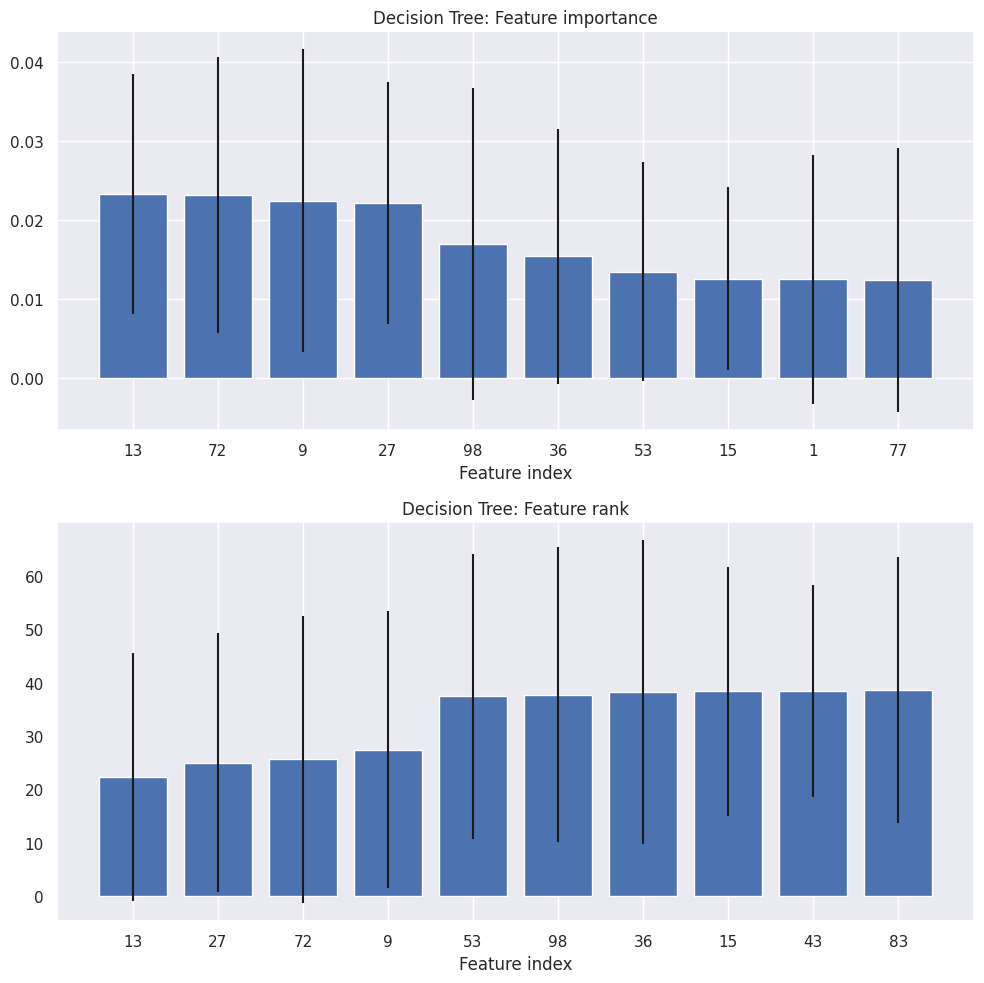

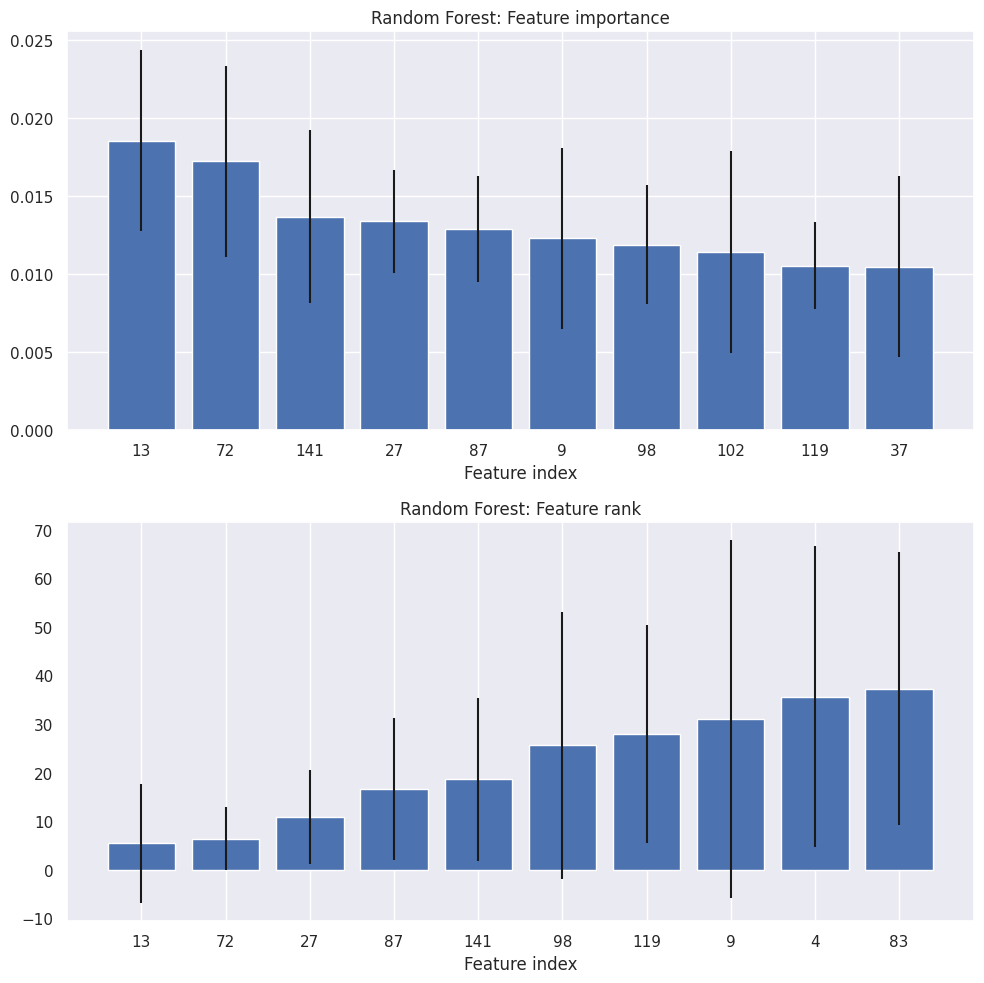

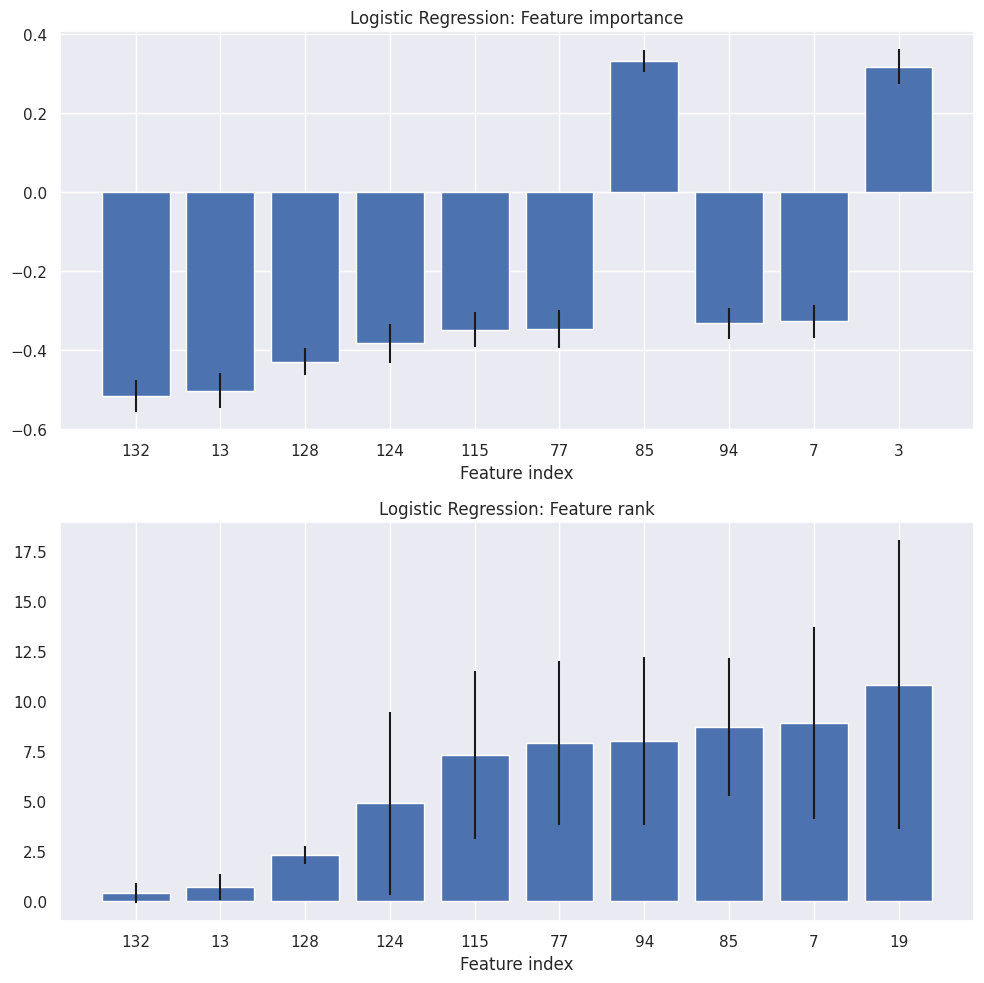

In [18]:
seed = ["pITG_L"]

run_pITG_L = run_poly(df_boot, data, seed)
run_pITG_L.plot_scores()
run_pITG_L.plot_features(ntop=10)

## opIFG_R

2023-03-28 11:32:15,548 - polyssifier - INFO - Detected 2 classes in label
2023-03-28 11:32:15,549 - polyssifier - INFO - Building classifiers ...
2023-03-28 11:32:15,553 - polyssifier - INFO - Initialization, done.
2023-03-28 11:32:15,570 - polyssifier - INFO - Training Multilayer Perceptron 0
2023-03-28 11:32:18,434 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.85, 2.86 sec
2023-03-28 11:32:18,437 - polyssifier - INFO - Training Multilayer Perceptron 1
2023-03-28 11:32:21,479 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.82, 3.04 sec
2023-03-28 11:32:21,481 - polyssifier - INFO - Training Multilayer Perceptron 2
2023-03-28 11:32:24,932 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.91, 3.45 sec
2023-03-28 11:32:24,935 - polyssifier - INFO - Training Multilayer Perceptron 3
2023-03-28 11:32:28,255 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.87, 3.32 sec
2023-03-28 11:32:28,258 - polyss

predict proba return shape (57,)


2023-03-28 11:32:59,099 - polyssifier - INFO - Linear SVM                 1: Train 0.89/Test 0.77, 0.68 sec
2023-03-28 11:32:59,102 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2023-03-28 11:32:59,811 - polyssifier - INFO - Linear SVM                 2: Train 0.89/Test 0.81, 0.71 sec
2023-03-28 11:32:59,814 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2023-03-28 11:33:00,519 - polyssifier - INFO - Linear SVM                 3: Train 0.88/Test 0.88, 0.71 sec
2023-03-28 11:33:00,522 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2023-03-28 11:33:01,230 - polyssifier - INFO - Linear SVM                 4: Train 0.89/Test 0.71, 0.71 sec
2023-03-28 11:33:01,233 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2023-03-28 11:33:01,920 - polyssifier - INFO - Linear SVM                 5: Train 0.89/Test 0.80, 0.69 sec
2023-03-28 11:33:01,923 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2023-03-28 11:33:02,593 - polyssifier - INFO - Linear SVM                 6: Train 0.90/Test 0.64, 0.67 sec
2023-03-28 11:33:02,596 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2023-03-28 11:33:03,308 - polyssifier - INFO - Linear SVM                 7: Train 0.88/Test 0.77, 0.71 sec
2023-03-28 11:33:03,311 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2023-03-28 11:33:03,994 - polyssifier - INFO - Linear SVM                 8: Train 0.89/Test 0.74, 0.68 sec
2023-03-28 11:33:03,997 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2023-03-28 11:33:04,726 - polyssifier - INFO - Linear SVM                 9: Train 0.88/Test 0.82, 0.73 sec
2023-03-28 11:33:04,729 - polyssifier - INFO - Training Decision Tree 0
2023-03-28 11:33:04,748 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.61, 0.02 sec
2023-03-28 11:33:04,753 - polyssifier - INFO - Training Decision Tree 1
2023-03-28 11:33:04,771 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.58, 0.02 sec
2023-03-28 11:33:04,776 - polyssifier - INFO - Training Decision Tree 2
2023-03-28 11:33:04,792 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.65, 0.02 sec
2023-03-28 11:33:04,793 - polyssifier - INFO - Training Decision Tree 3
2023-03-28 11:33:04,805 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.63, 0.01 sec
2023-03-28 11:33:04,807 - polyssifier - INFO - Training Decision Tree 4
2023-03-28 11:33:04,821 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.52, 0

predict proba return shape (57,)


2023-03-28 11:33:06,285 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.77, 1.40 sec
2023-03-28 11:33:06,289 - polyssifier - INFO - Training Random Forest 1
2023-03-28 11:33:07,723 - polyssifier - INFO - Random Forest              1: Train 1.00/Test 0.73, 1.43 sec
2023-03-28 11:33:07,728 - polyssifier - INFO - Training Random Forest 2
2023-03-28 11:33:09,157 - polyssifier - INFO - Random Forest              2: Train 1.00/Test 0.85, 1.43 sec
2023-03-28 11:33:09,161 - polyssifier - INFO - Training Random Forest 3
2023-03-28 11:33:10,587 - polyssifier - INFO - Random Forest              3: Train 1.00/Test 0.85, 1.43 sec
2023-03-28 11:33:10,591 - polyssifier - INFO - Training Random Forest 4
2023-03-28 11:33:11,976 - polyssifier - INFO - Random Forest              4: Train 1.00/Test 0.66, 1.39 sec
2023-03-28 11:33:11,981 - polyssifier - INFO - Training Random Forest 5
2023-03-28 11:33:13,388 - polyssifier - INFO - Random Forest              5: Train 1.00/Test 0.67, 1

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.850771  0.042492  0.779156  0.906173
Nearest Neighbors     train  0.827327  0.016856  0.812070  0.858312
                      test   0.746157  0.067742  0.616005  0.833747
SVM                   train  0.972966  0.001575  0.970449  0.975157
                      test   0.854406  0.048396  0.804938  0.953086
Linear SVM            train  0.890006  0.006691  0.880688  0.903652
                      test   0.765790  0.068219  0.635236  0.883951
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.603119  0.041387  0.524194  0.665633
Random Forest         train  0.999939  0.000107  0.999656  1.000000
                      test   0.757097  0.067842  0.657568  0.851852
Logistic Regression   train  0.893874  0.005575  0.883141  0.904034
                      test   0.757627  0.068540 

2023-03-28 11:33:25,623 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2023-03-28 11:33:25,916 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2023-03-28 11:33:26,309 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2023-03-28 11:33:26,599 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


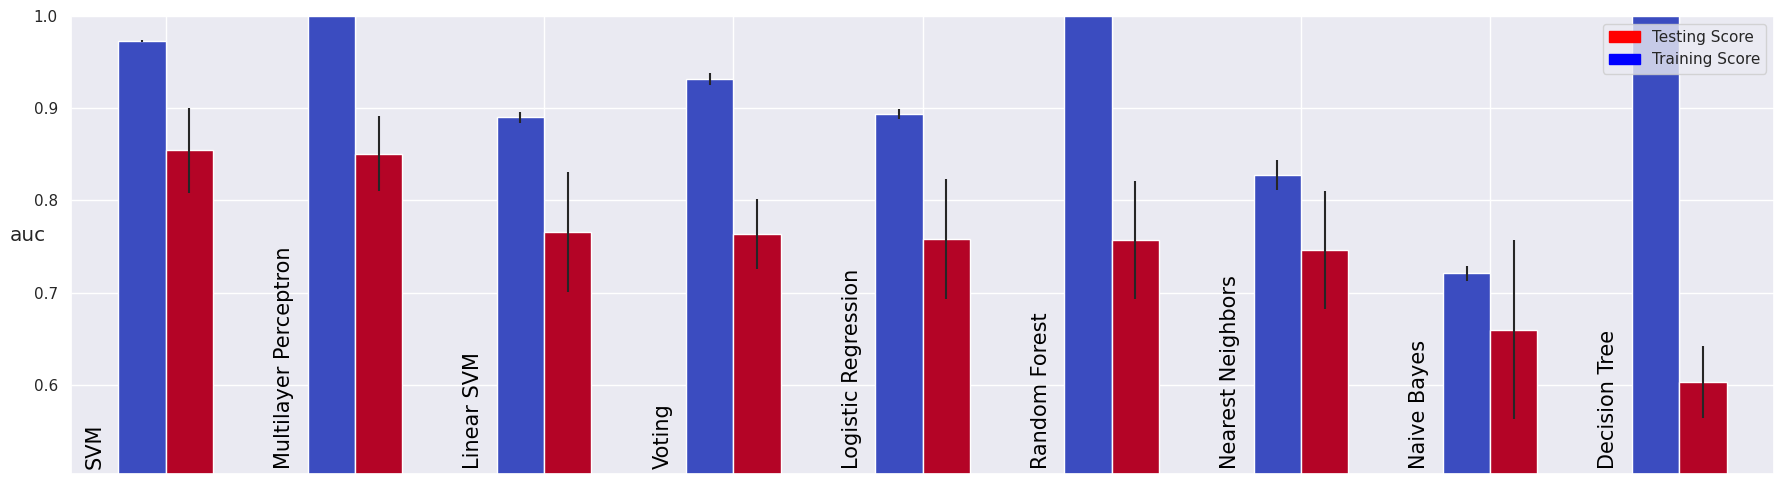

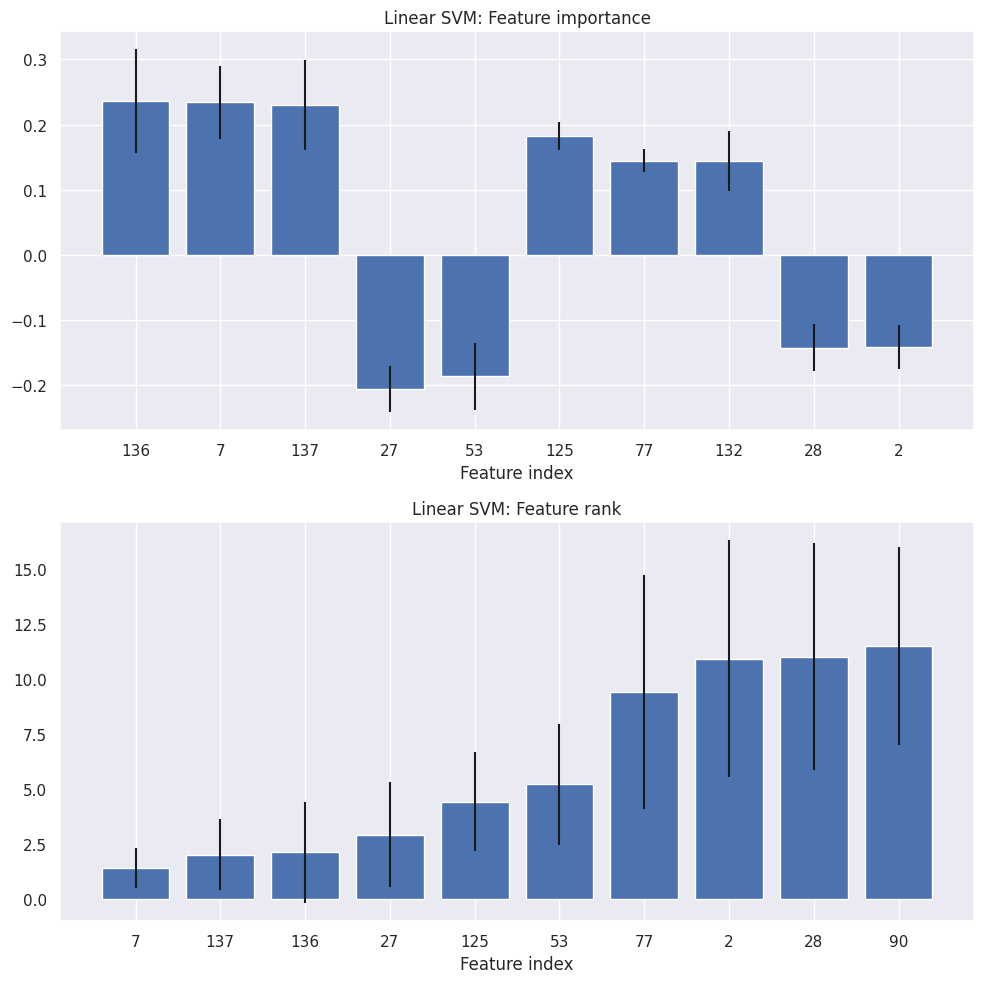

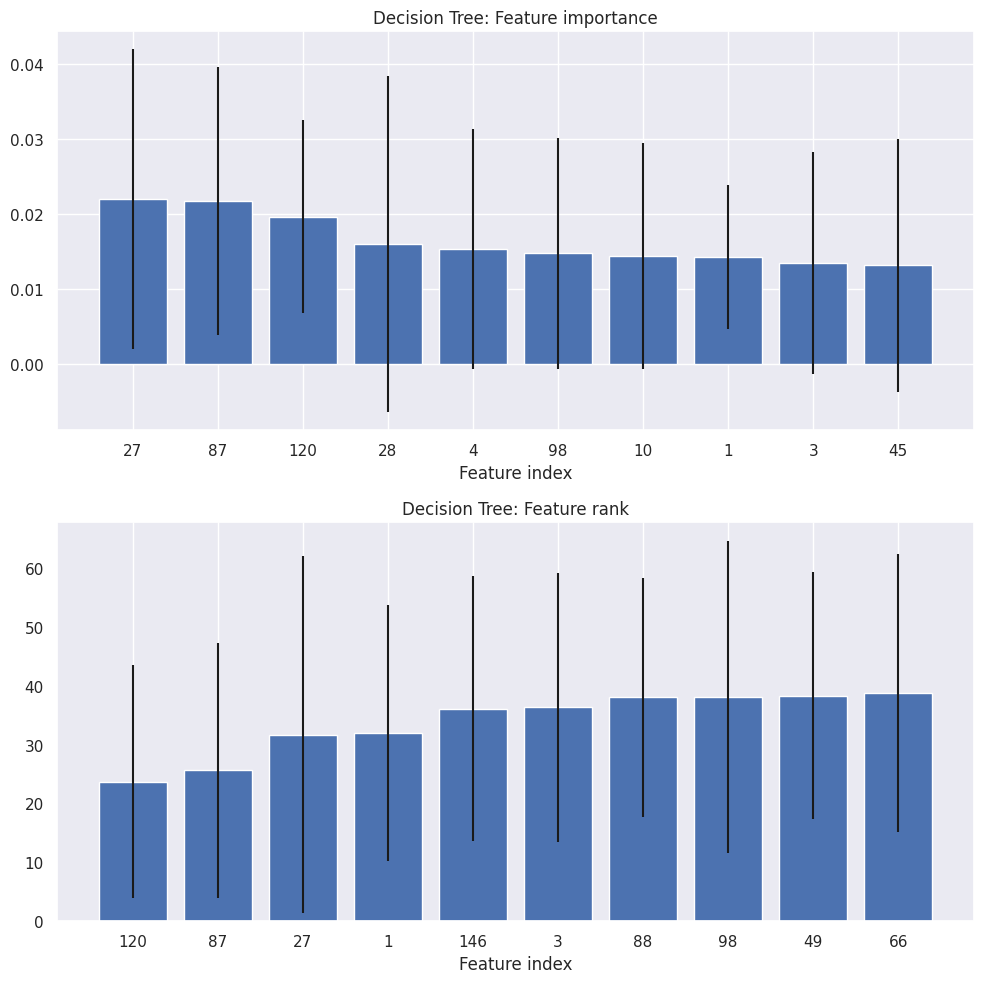

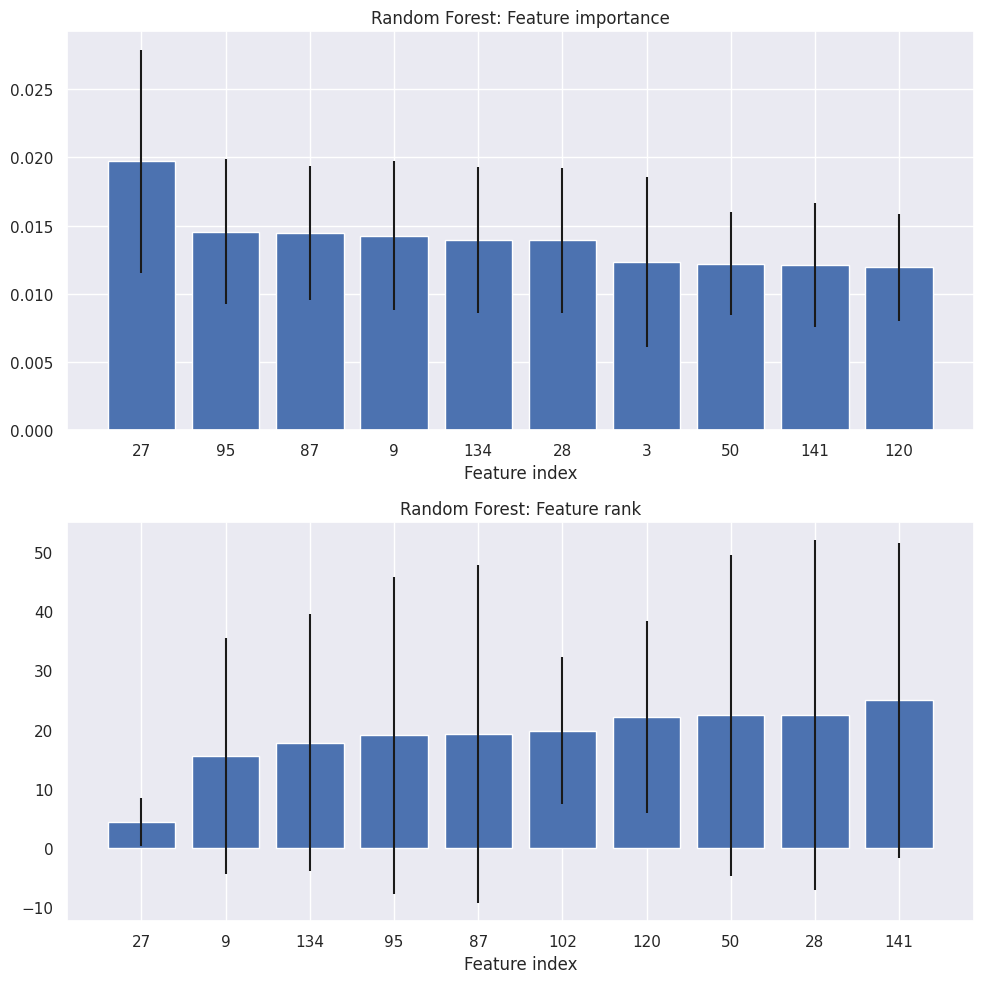

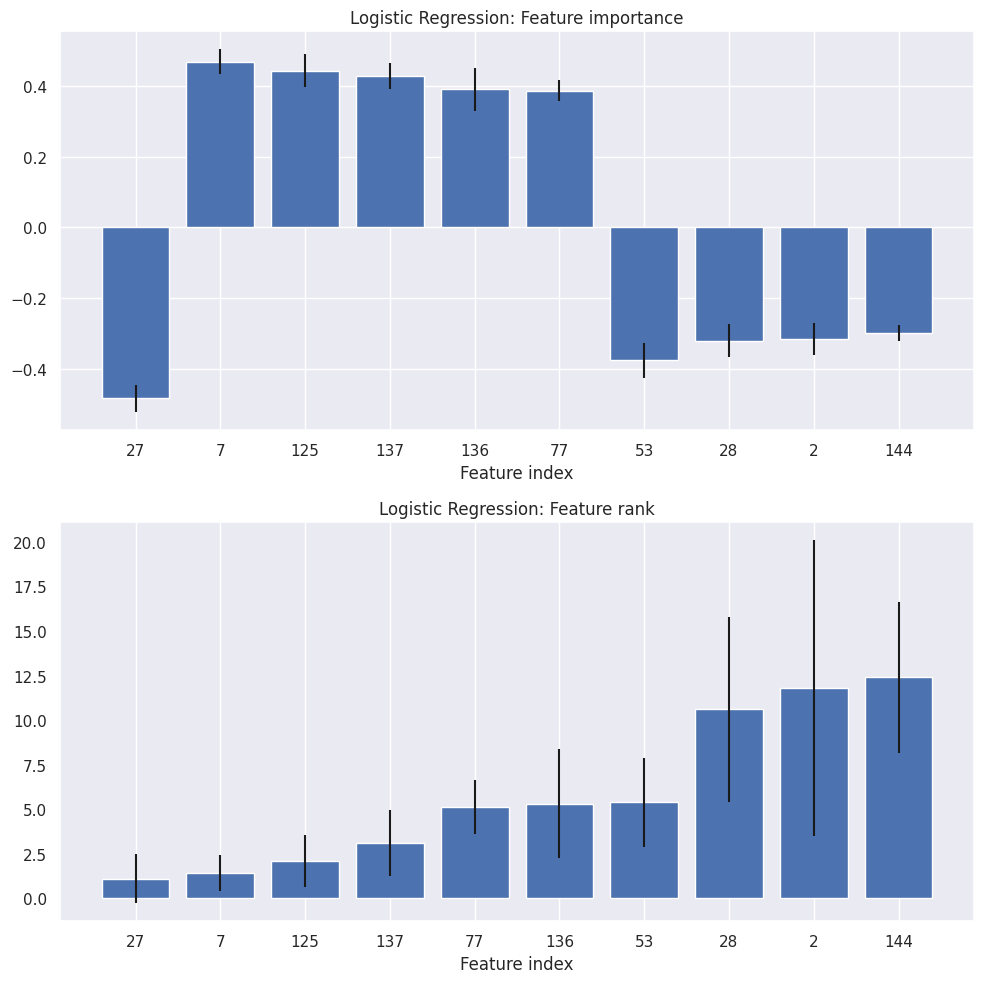

In [19]:
seed = ["opIFG_R"]

run_opIFG_R = run_poly(df_boot, data, seed)
run_opIFG_R.plot_scores()
run_opIFG_R.plot_features(ntop=10)

## planumtemp_R

2023-03-28 11:34:36,304 - polyssifier - INFO - Detected 2 classes in label
2023-03-28 11:34:36,305 - polyssifier - INFO - Building classifiers ...
2023-03-28 11:34:36,312 - polyssifier - INFO - Initialization, done.
2023-03-28 11:34:36,332 - polyssifier - INFO - Training Multilayer Perceptron 0
2023-03-28 11:34:39,019 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.86, 2.69 sec
2023-03-28 11:34:39,024 - polyssifier - INFO - Training Multilayer Perceptron 1
2023-03-28 11:34:42,111 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.83, 3.09 sec
2023-03-28 11:34:42,114 - polyssifier - INFO - Training Multilayer Perceptron 2
2023-03-28 11:34:44,924 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.83, 2.81 sec
2023-03-28 11:34:44,927 - polyssifier - INFO - Training Multilayer Perceptron 3
2023-03-28 11:34:47,643 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.79, 2.72 sec
2023-03-28 11:34:47,656 - polyss

predict proba return shape (57,)


2023-03-28 11:35:15,733 - polyssifier - INFO - Linear SVM                 1: Train 0.91/Test 0.81, 0.69 sec
2023-03-28 11:35:15,735 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2023-03-28 11:35:16,401 - polyssifier - INFO - Linear SVM                 2: Train 0.91/Test 0.80, 0.67 sec
2023-03-28 11:35:16,403 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2023-03-28 11:35:17,096 - polyssifier - INFO - Linear SVM                 3: Train 0.92/Test 0.78, 0.69 sec
2023-03-28 11:35:17,098 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2023-03-28 11:35:17,788 - polyssifier - INFO - Linear SVM                 4: Train 0.90/Test 0.81, 0.69 sec
2023-03-28 11:35:17,791 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2023-03-28 11:35:18,446 - polyssifier - INFO - Linear SVM                 5: Train 0.91/Test 0.75, 0.66 sec
2023-03-28 11:35:18,449 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2023-03-28 11:35:19,131 - polyssifier - INFO - Linear SVM                 6: Train 0.92/Test 0.73, 0.68 sec
2023-03-28 11:35:19,133 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2023-03-28 11:35:19,830 - polyssifier - INFO - Linear SVM                 7: Train 0.90/Test 0.74, 0.70 sec
2023-03-28 11:35:19,833 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2023-03-28 11:35:20,513 - polyssifier - INFO - Linear SVM                 8: Train 0.91/Test 0.73, 0.68 sec
2023-03-28 11:35:20,516 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2023-03-28 11:35:21,177 - polyssifier - INFO - Linear SVM                 9: Train 0.91/Test 0.79, 0.66 sec
2023-03-28 11:35:21,180 - polyssifier - INFO - Training Decision Tree 0
2023-03-28 11:35:21,198 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.59, 0.02 sec
2023-03-28 11:35:21,201 - polyssifier - INFO - Training Decision Tree 1
2023-03-28 11:35:21,218 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.63, 0.02 sec
2023-03-28 11:35:21,221 - polyssifier - INFO - Training Decision Tree 2
2023-03-28 11:35:21,240 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.56, 0.02 sec
2023-03-28 11:35:21,242 - polyssifier - INFO - Training Decision Tree 3
2023-03-28 11:35:21,253 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.54, 0.01 sec
2023-03-28 11:35:21,255 - polyssifier - INFO - Training Decision Tree 4
2023-03-28 11:35:21,267 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.58, 0

predict proba return shape (57,)


2023-03-28 11:35:22,740 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.74, 1.41 sec
2023-03-28 11:35:22,745 - polyssifier - INFO - Training Random Forest 1
2023-03-28 11:35:24,158 - polyssifier - INFO - Random Forest              1: Train 1.00/Test 0.63, 1.41 sec
2023-03-28 11:35:24,162 - polyssifier - INFO - Training Random Forest 2
2023-03-28 11:35:25,571 - polyssifier - INFO - Random Forest              2: Train 1.00/Test 0.65, 1.41 sec
2023-03-28 11:35:25,575 - polyssifier - INFO - Training Random Forest 3
2023-03-28 11:35:26,976 - polyssifier - INFO - Random Forest              3: Train 1.00/Test 0.64, 1.40 sec
2023-03-28 11:35:26,981 - polyssifier - INFO - Training Random Forest 4
2023-03-28 11:35:28,401 - polyssifier - INFO - Random Forest              4: Train 1.00/Test 0.71, 1.42 sec
2023-03-28 11:35:28,405 - polyssifier - INFO - Training Random Forest 5
2023-03-28 11:35:29,770 - polyssifier - INFO - Random Forest              5: Train 1.00/Test 0.62, 1

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.843462  0.047525  0.761787  0.900744
Nearest Neighbors     train  0.796030  0.005813  0.784339  0.801871
                      test   0.720021  0.078798  0.625310  0.849256
SVM                   train  0.978836  0.001687  0.976883  0.981624
                      test   0.838401  0.041189  0.788889  0.909429
Linear SVM            train  0.908662  0.005144  0.901589  0.916241
                      test   0.780025  0.040288  0.730769  0.851852
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.613857  0.047430  0.542593  0.687965
Random Forest         train  0.999627  0.000666  0.997913  1.000000
                      test   0.670641  0.065914  0.546526  0.749380
Logistic Regression   train  0.909660  0.003937  0.903657  0.916272
                      test   0.783247  0.043422 

2023-03-28 11:35:41,326 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2023-03-28 11:35:41,613 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2023-03-28 11:35:41,899 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2023-03-28 11:35:42,201 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


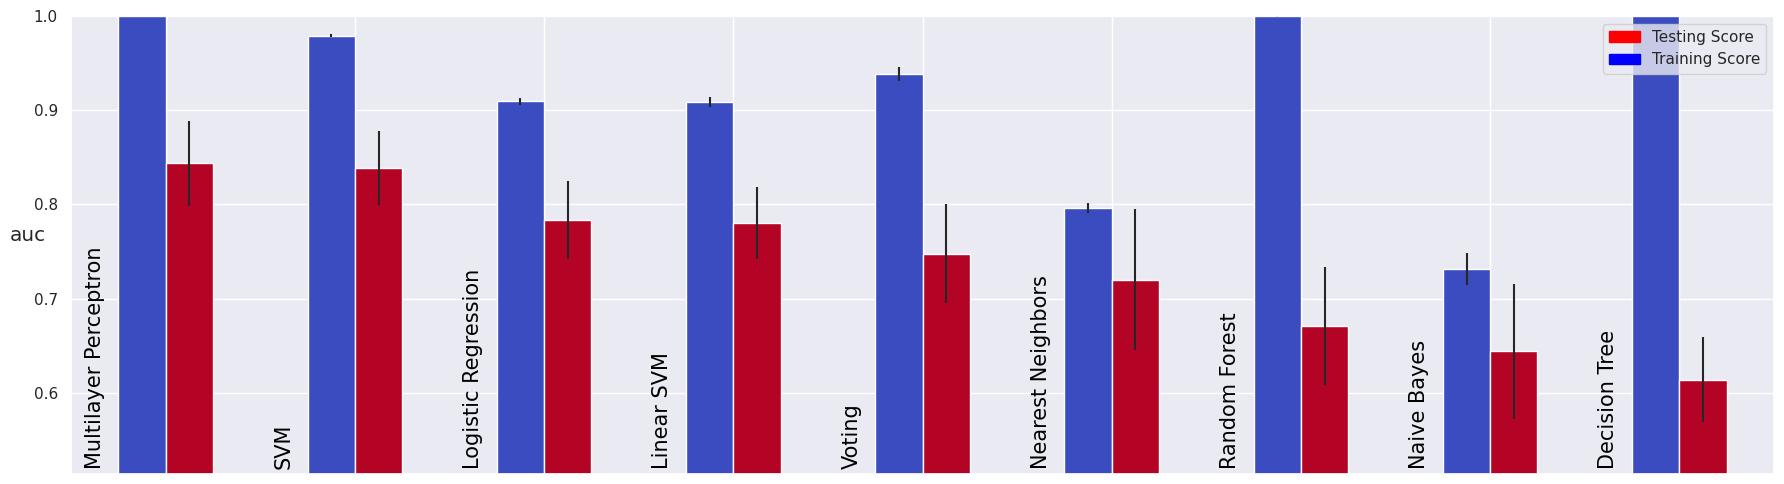

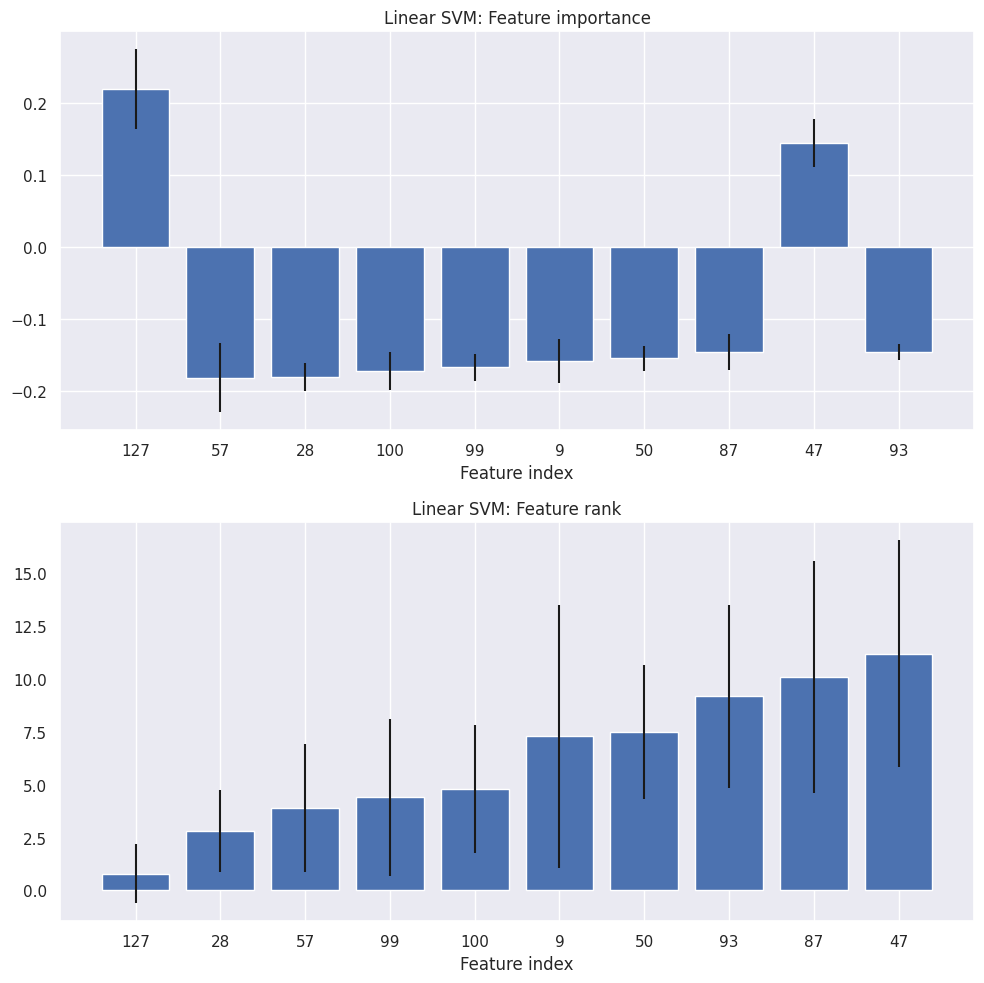

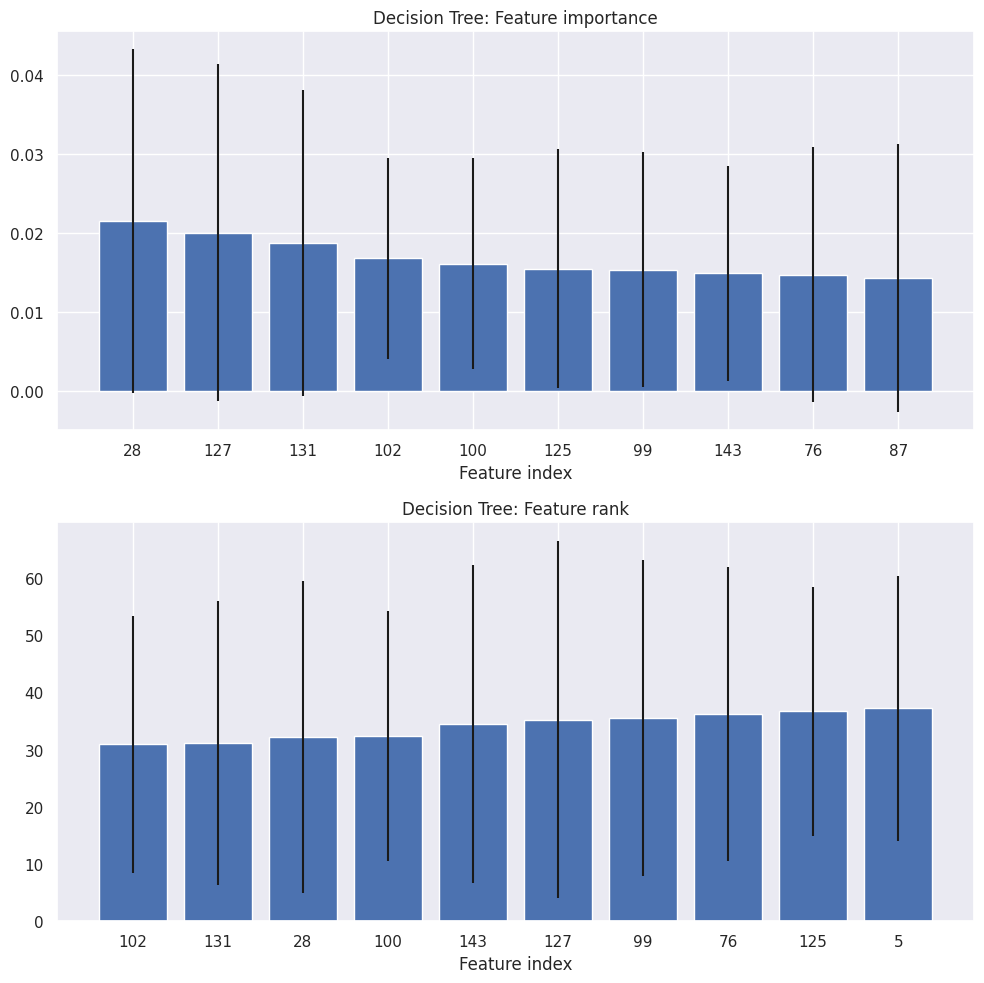

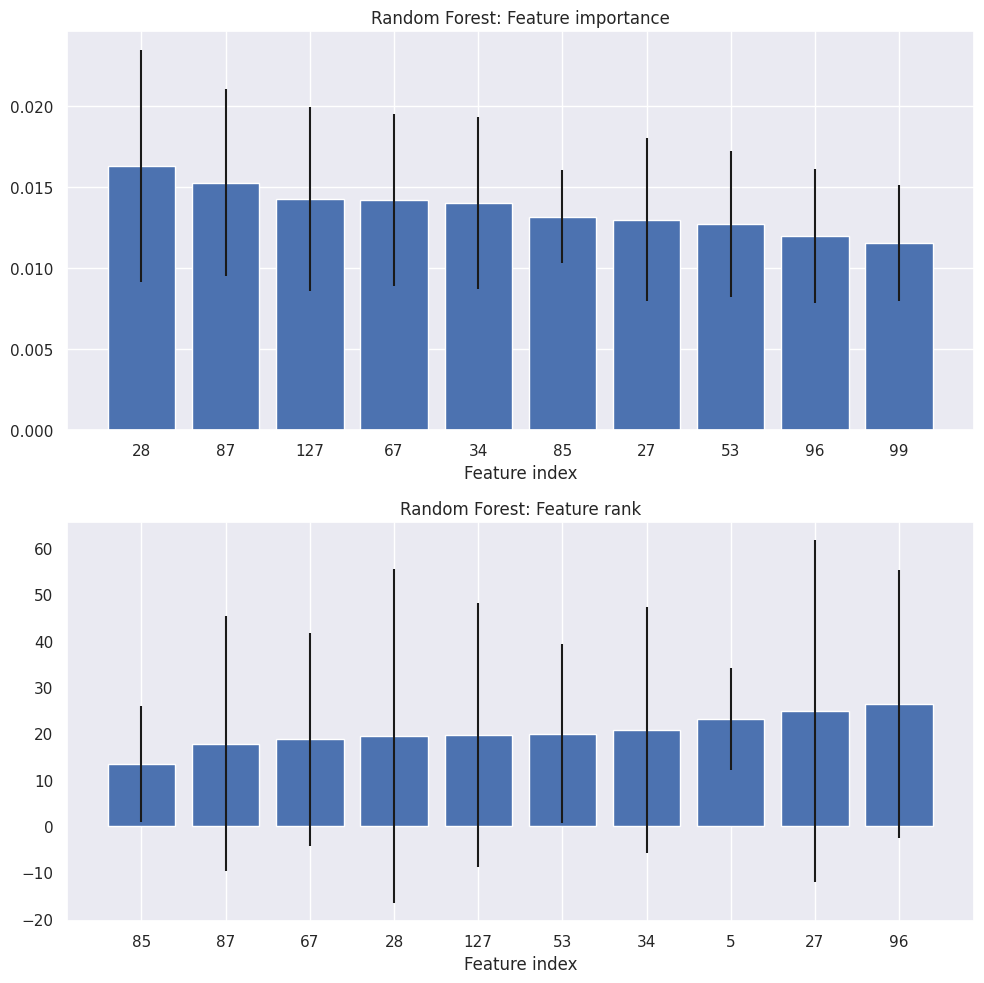

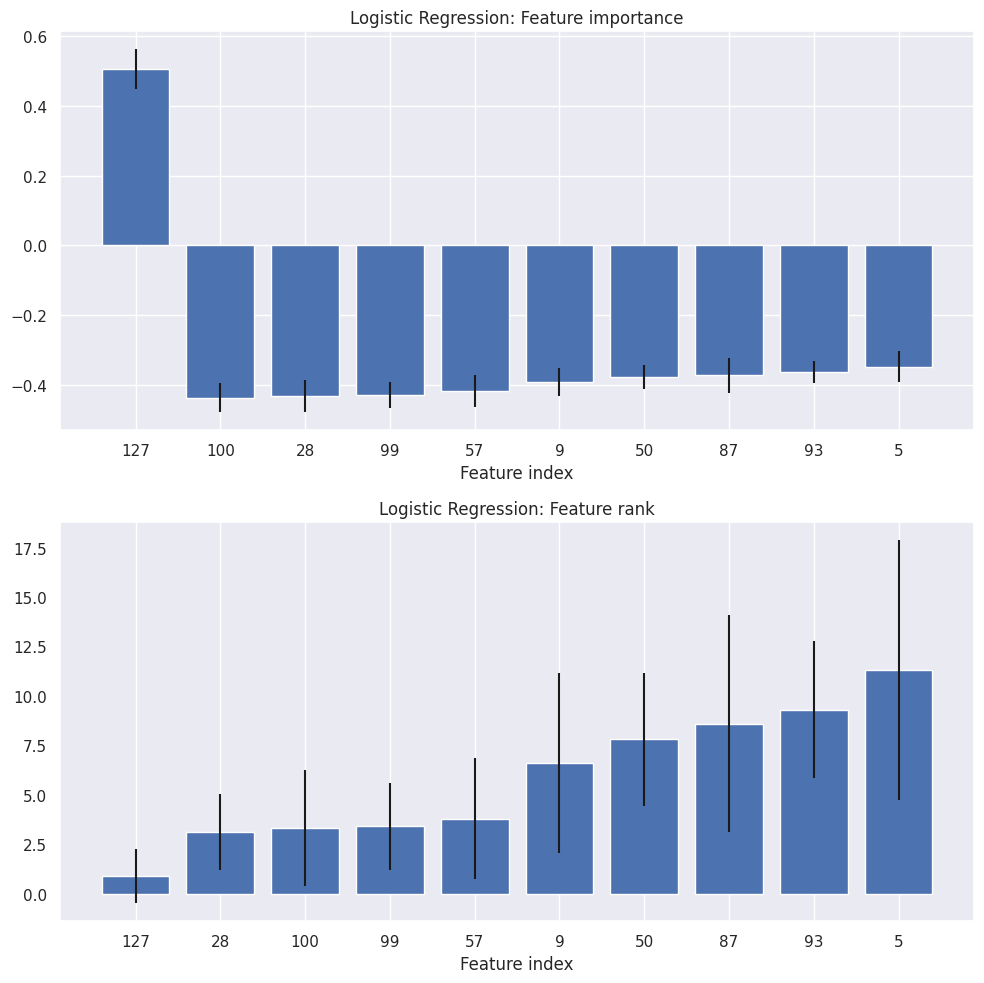

In [20]:
seed = ["planumtemp_R"]

run_planumtemp_R = run_poly(df_boot, data, seed)
run_planumtemp_R.plot_scores()
run_planumtemp_R.plot_features(ntop=10)

## aMTG_R

2023-03-28 11:42:48,637 - polyssifier - INFO - Detected 2 classes in label
2023-03-28 11:42:48,637 - polyssifier - INFO - Building classifiers ...
2023-03-28 11:42:48,641 - polyssifier - INFO - Initialization, done.
2023-03-28 11:42:48,659 - polyssifier - INFO - Training Multilayer Perceptron 0
2023-03-28 11:42:51,191 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.90, 2.53 sec
2023-03-28 11:42:51,194 - polyssifier - INFO - Training Multilayer Perceptron 1
2023-03-28 11:42:53,618 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.89, 2.42 sec
2023-03-28 11:42:53,620 - polyssifier - INFO - Training Multilayer Perceptron 2
2023-03-28 11:42:55,983 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.94, 2.36 sec
2023-03-28 11:42:55,986 - polyssifier - INFO - Training Multilayer Perceptron 3
2023-03-28 11:42:58,599 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.93, 2.61 sec
2023-03-28 11:42:58,602 - polyss

predict proba return shape (57,)


2023-03-28 11:43:25,183 - polyssifier - INFO - Linear SVM                 1: Train 0.92/Test 0.86, 0.66 sec
2023-03-28 11:43:25,185 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2023-03-28 11:43:25,833 - polyssifier - INFO - Linear SVM                 2: Train 0.92/Test 0.87, 0.65 sec
2023-03-28 11:43:25,835 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2023-03-28 11:43:26,466 - polyssifier - INFO - Linear SVM                 3: Train 0.92/Test 0.91, 0.63 sec
2023-03-28 11:43:26,468 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2023-03-28 11:43:27,129 - polyssifier - INFO - Linear SVM                 4: Train 0.93/Test 0.78, 0.66 sec
2023-03-28 11:43:27,131 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2023-03-28 11:43:27,789 - polyssifier - INFO - Linear SVM                 5: Train 0.93/Test 0.86, 0.66 sec
2023-03-28 11:43:27,791 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2023-03-28 11:43:28,446 - polyssifier - INFO - Linear SVM                 6: Train 0.92/Test 0.88, 0.65 sec
2023-03-28 11:43:28,448 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2023-03-28 11:43:29,100 - polyssifier - INFO - Linear SVM                 7: Train 0.93/Test 0.79, 0.65 sec
2023-03-28 11:43:29,102 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2023-03-28 11:43:29,775 - polyssifier - INFO - Linear SVM                 8: Train 0.93/Test 0.79, 0.67 sec
2023-03-28 11:43:29,777 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2023-03-28 11:43:30,424 - polyssifier - INFO - Linear SVM                 9: Train 0.93/Test 0.81, 0.65 sec
2023-03-28 11:43:30,426 - polyssifier - INFO - Training Decision Tree 0
2023-03-28 11:43:30,443 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.64, 0.02 sec
2023-03-28 11:43:30,445 - polyssifier - INFO - Training Decision Tree 1
2023-03-28 11:43:30,463 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.47, 0.02 sec
2023-03-28 11:43:30,465 - polyssifier - INFO - Training Decision Tree 2
2023-03-28 11:43:30,483 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.51, 0.02 sec
2023-03-28 11:43:30,485 - polyssifier - INFO - Training Decision Tree 3
2023-03-28 11:43:30,497 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.56, 0.01 sec
2023-03-28 11:43:30,499 - polyssifier - INFO - Training Decision Tree 4
2023-03-28 11:43:30,510 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.61, 0

predict proba return shape (57,)


2023-03-28 11:43:31,949 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.69, 1.38 sec
2023-03-28 11:43:31,954 - polyssifier - INFO - Training Random Forest 1
2023-03-28 11:43:33,326 - polyssifier - INFO - Random Forest              1: Train 1.00/Test 0.59, 1.37 sec
2023-03-28 11:43:33,330 - polyssifier - INFO - Training Random Forest 2
2023-03-28 11:43:34,713 - polyssifier - INFO - Random Forest              2: Train 1.00/Test 0.76, 1.38 sec
2023-03-28 11:43:34,718 - polyssifier - INFO - Training Random Forest 3
2023-03-28 11:43:36,112 - polyssifier - INFO - Random Forest              3: Train 1.00/Test 0.85, 1.39 sec
2023-03-28 11:43:36,117 - polyssifier - INFO - Training Random Forest 4
2023-03-28 11:43:37,497 - polyssifier - INFO - Random Forest              4: Train 1.00/Test 0.75, 1.38 sec
2023-03-28 11:43:37,502 - polyssifier - INFO - Training Random Forest 5
2023-03-28 11:43:38,907 - polyssifier - INFO - Random Forest              5: Train 1.00/Test 0.59, 1

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.890251  0.034268  0.838710  0.938272
Nearest Neighbors     train  0.813383  0.008939  0.798724  0.826194
                      test   0.740643  0.078660  0.632134  0.907568
SVM                   train  0.988527  0.001307  0.986631  0.990542
                      test   0.880030  0.043810  0.818519  0.956576
Linear SVM            train  0.926738  0.005256  0.918043  0.933705
                      test   0.831555  0.048848  0.772840  0.909877
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.592898  0.062607  0.472222  0.681762
Random Forest         train  0.999992  0.000021  0.999931  1.000000
                      test   0.723379  0.094354  0.587469  0.877171
Logistic Regression   train  0.927998  0.004548  0.922109  0.933140
                      test   0.838985  0.043673 

2023-03-28 11:43:50,175 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2023-03-28 11:43:50,467 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2023-03-28 11:43:50,899 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2023-03-28 11:43:51,187 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


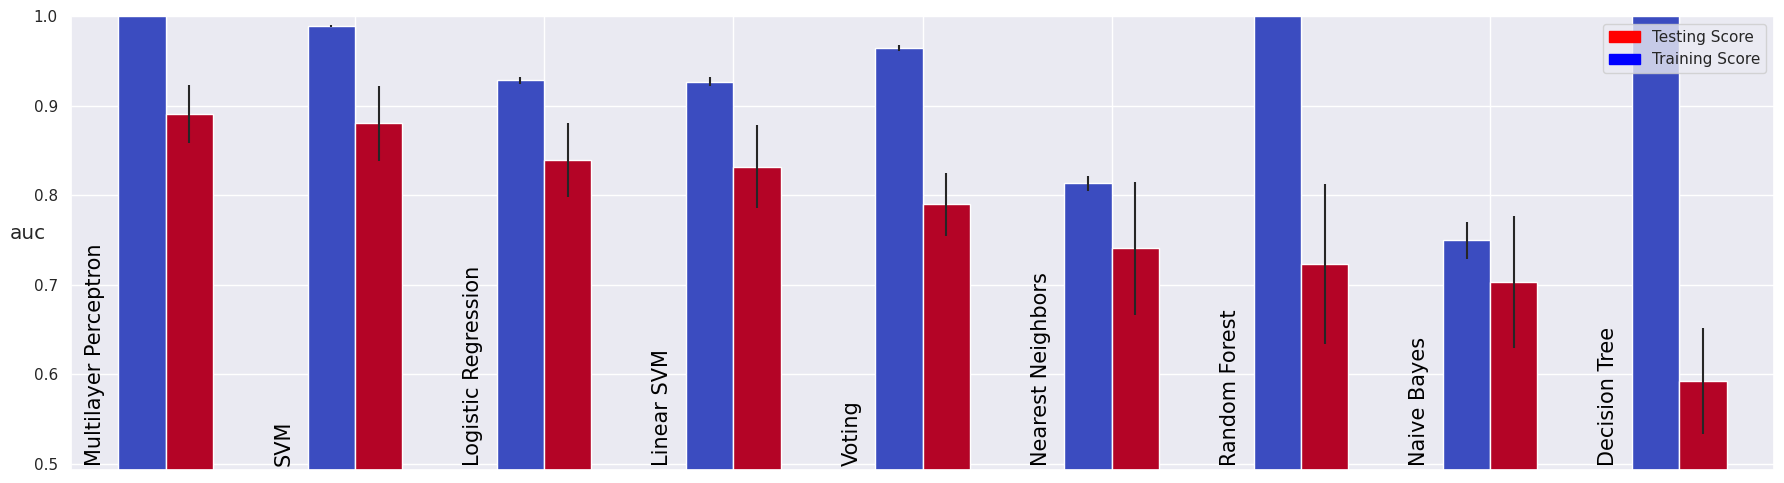

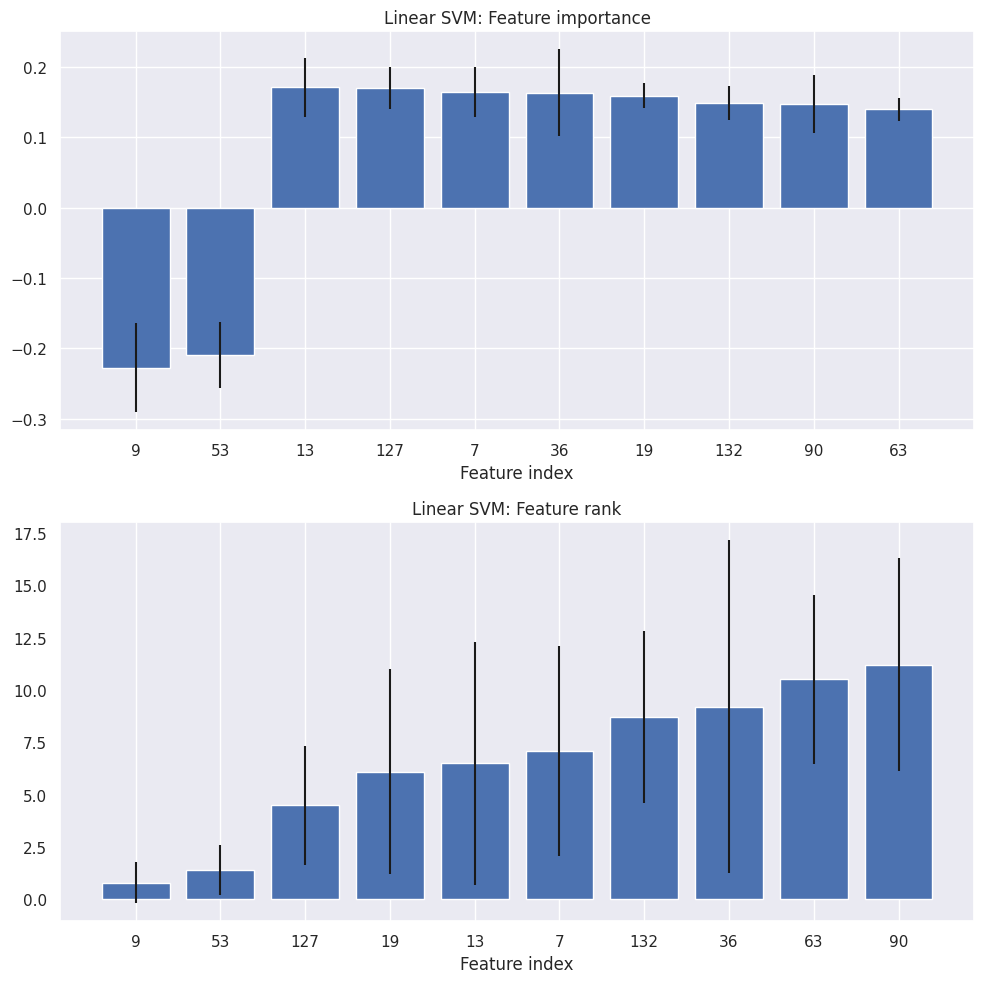

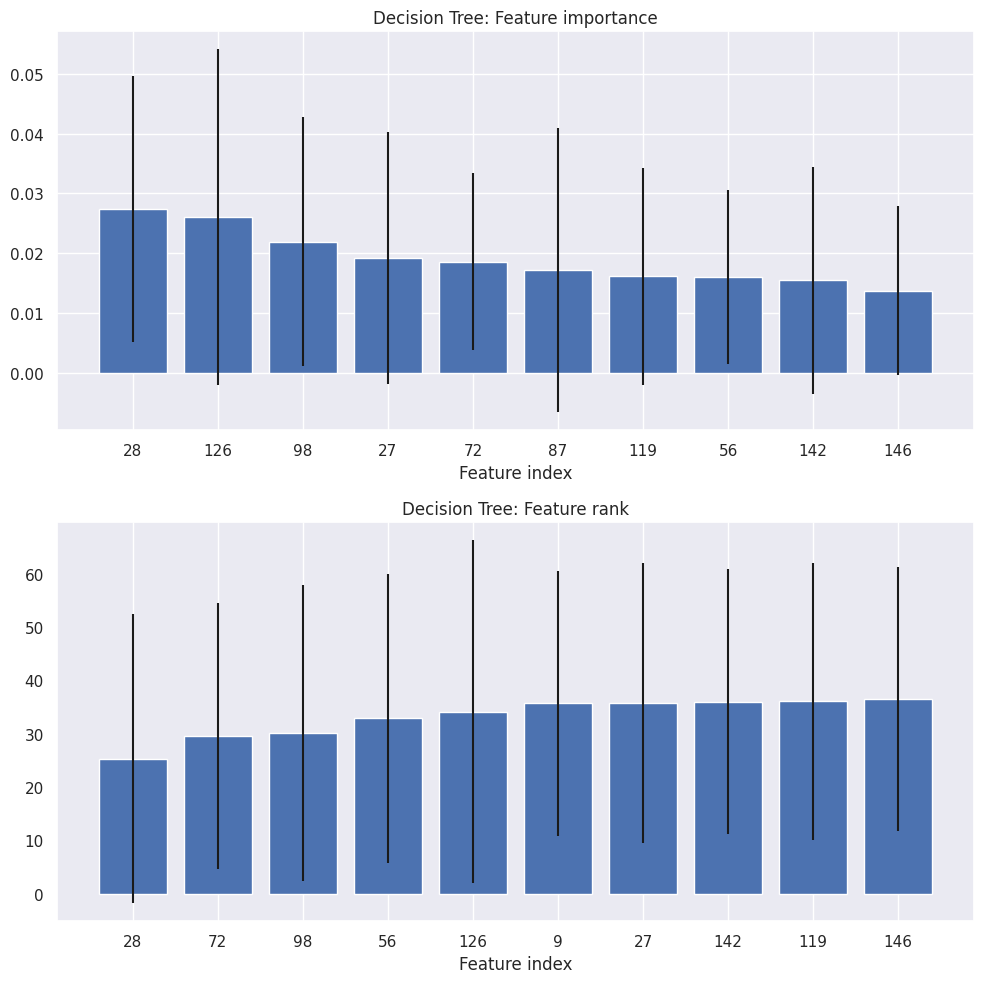

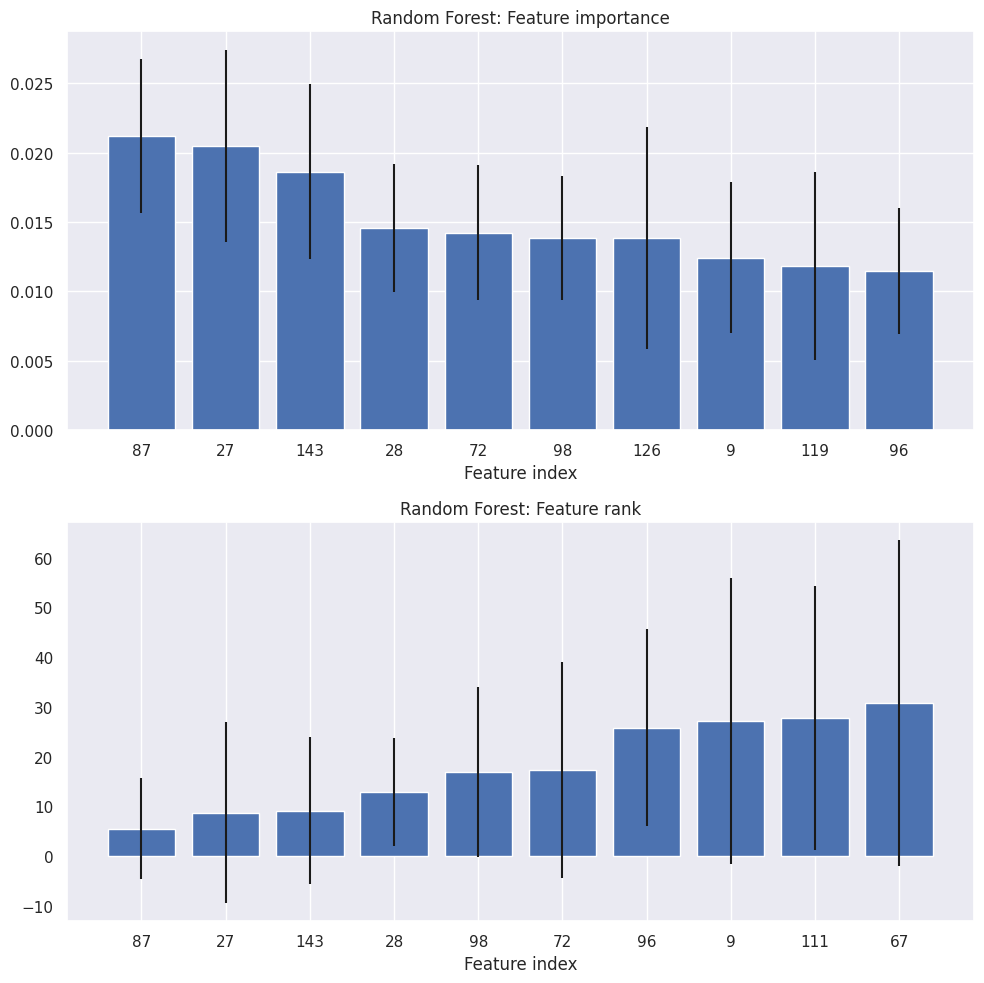

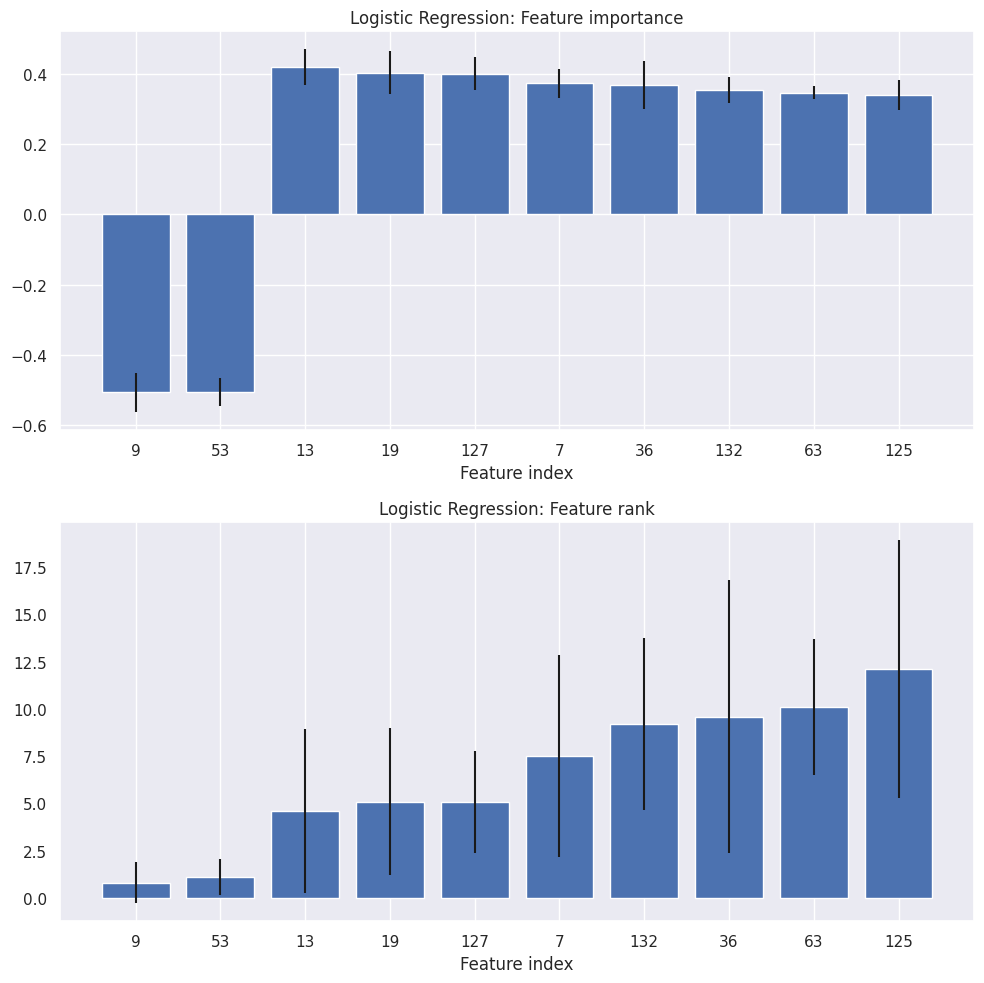

In [21]:
seed = ["aMTG_R"]

run_aMTG_R = run_poly(df_boot, data, seed)
run_aMTG_R.plot_scores()
run_aMTG_R.plot_features(ntop=10)

## pITG_R

2023-03-28 11:45:37,645 - polyssifier - INFO - Detected 2 classes in label
2023-03-28 11:45:37,646 - polyssifier - INFO - Building classifiers ...
2023-03-28 11:45:37,650 - polyssifier - INFO - Initialization, done.
2023-03-28 11:45:37,669 - polyssifier - INFO - Training Multilayer Perceptron 0
2023-03-28 11:45:40,793 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.86, 3.12 sec
2023-03-28 11:45:40,796 - polyssifier - INFO - Training Multilayer Perceptron 1
2023-03-28 11:45:43,695 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.89, 2.90 sec
2023-03-28 11:45:43,698 - polyssifier - INFO - Training Multilayer Perceptron 2
2023-03-28 11:45:46,510 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.79, 2.81 sec
2023-03-28 11:45:46,513 - polyssifier - INFO - Training Multilayer Perceptron 3
2023-03-28 11:45:49,315 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.90, 2.80 sec
2023-03-28 11:45:49,317 - polyss

predict proba return shape (57,)


2023-03-28 11:46:17,218 - polyssifier - INFO - Linear SVM                 1: Train 0.78/Test 0.61, 0.78 sec
2023-03-28 11:46:17,220 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2023-03-28 11:46:17,961 - polyssifier - INFO - Linear SVM                 2: Train 0.63/Test 0.52, 0.74 sec
2023-03-28 11:46:17,963 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2023-03-28 11:46:18,715 - polyssifier - INFO - Linear SVM                 3: Train 0.77/Test 0.66, 0.75 sec
2023-03-28 11:46:18,717 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2023-03-28 11:46:19,417 - polyssifier - INFO - Linear SVM                 4: Train 0.61/Test 0.53, 0.70 sec
2023-03-28 11:46:19,419 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2023-03-28 11:46:20,100 - polyssifier - INFO - Linear SVM                 5: Train 0.62/Test 0.46, 0.68 sec
2023-03-28 11:46:20,102 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2023-03-28 11:46:20,853 - polyssifier - INFO - Linear SVM                 6: Train 0.79/Test 0.55, 0.75 sec
2023-03-28 11:46:20,856 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2023-03-28 11:46:21,625 - polyssifier - INFO - Linear SVM                 7: Train 0.79/Test 0.54, 0.77 sec
2023-03-28 11:46:21,628 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2023-03-28 11:46:22,393 - polyssifier - INFO - Linear SVM                 8: Train 0.78/Test 0.55, 0.77 sec
2023-03-28 11:46:22,396 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2023-03-28 11:46:23,082 - polyssifier - INFO - Linear SVM                 9: Train 0.63/Test 0.56, 0.69 sec
2023-03-28 11:46:23,084 - polyssifier - INFO - Training Decision Tree 0
2023-03-28 11:46:23,099 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.56, 0.01 sec
2023-03-28 11:46:23,102 - polyssifier - INFO - Training Decision Tree 1
2023-03-28 11:46:23,119 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.53, 0.02 sec
2023-03-28 11:46:23,122 - polyssifier - INFO - Training Decision Tree 2
2023-03-28 11:46:23,137 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.47, 0.02 sec
2023-03-28 11:46:23,140 - polyssifier - INFO - Training Decision Tree 3
2023-03-28 11:46:23,153 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.49, 0.01 sec
2023-03-28 11:46:23,155 - polyssifier - INFO - Training Decision Tree 4
2023-03-28 11:46:23,168 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.61, 0

predict proba return shape (57,)


2023-03-28 11:46:24,710 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.63, 1.48 sec
2023-03-28 11:46:24,715 - polyssifier - INFO - Training Random Forest 1
2023-03-28 11:46:26,156 - polyssifier - INFO - Random Forest              1: Train 1.00/Test 0.63, 1.44 sec
2023-03-28 11:46:26,161 - polyssifier - INFO - Training Random Forest 2
2023-03-28 11:46:27,588 - polyssifier - INFO - Random Forest              2: Train 1.00/Test 0.65, 1.43 sec
2023-03-28 11:46:27,592 - polyssifier - INFO - Training Random Forest 3
2023-03-28 11:46:29,036 - polyssifier - INFO - Random Forest              3: Train 1.00/Test 0.73, 1.44 sec
2023-03-28 11:46:29,041 - polyssifier - INFO - Training Random Forest 4
2023-03-28 11:46:30,509 - polyssifier - INFO - Random Forest              4: Train 1.00/Test 0.61, 1.47 sec
2023-03-28 11:46:30,514 - polyssifier - INFO - Training Random Forest 5
2023-03-28 11:46:31,976 - polyssifier - INFO - Random Forest              5: Train 1.00/Test 0.58, 1

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.820753  0.051285  0.725806  0.895062
Nearest Neighbors     train  0.836226  0.007714  0.825584  0.848770
                      test   0.720643  0.087432  0.553970  0.859801
SVM                   train  0.970933  0.002981  0.965320  0.975523
                      test   0.800727  0.065319  0.648883  0.866005
Linear SVM            train  0.722418  0.089421  0.612116  0.835978
                      test   0.547501  0.057322  0.462779  0.664198
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.543029  0.073086  0.472222  0.710918
Random Forest         train  0.999930  0.000131  0.999564  1.000000
                      test   0.646148  0.094117  0.510546  0.826303
Logistic Regression   train  0.644143  0.003993  0.637834  0.651398
                      test   0.594500  0.053436 

2023-03-28 11:46:43,779 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2023-03-28 11:46:44,069 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2023-03-28 11:46:44,364 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2023-03-28 11:46:44,661 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


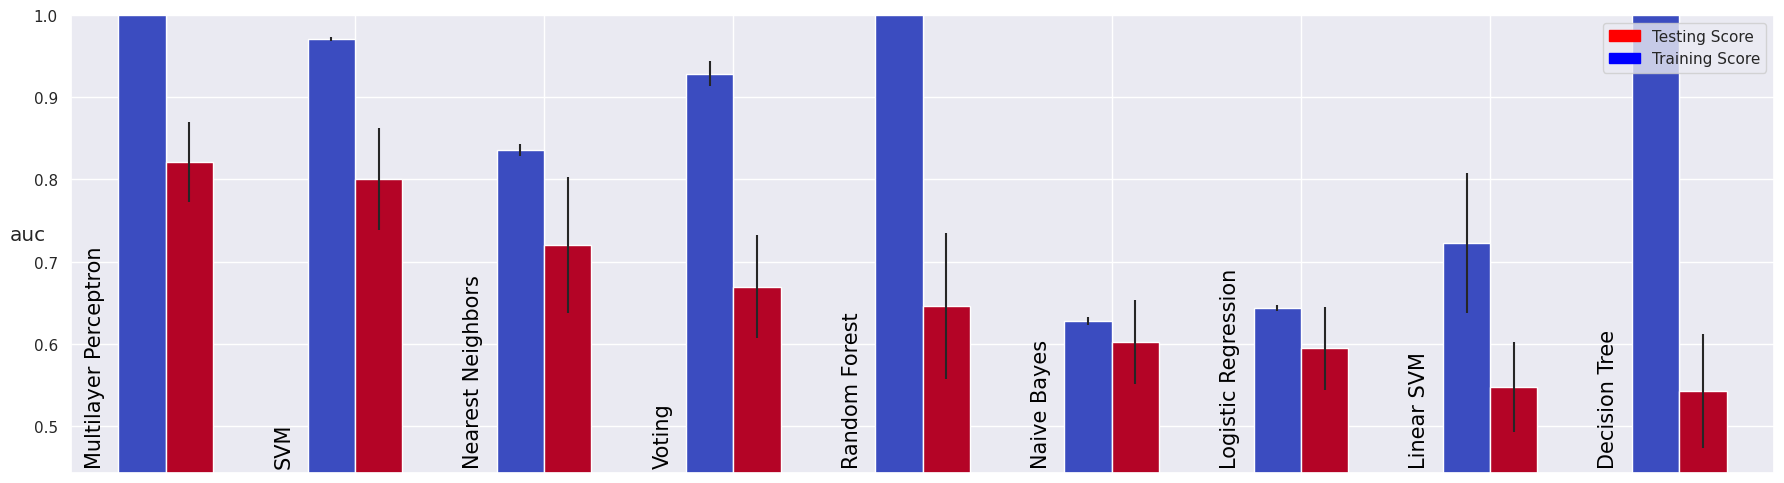

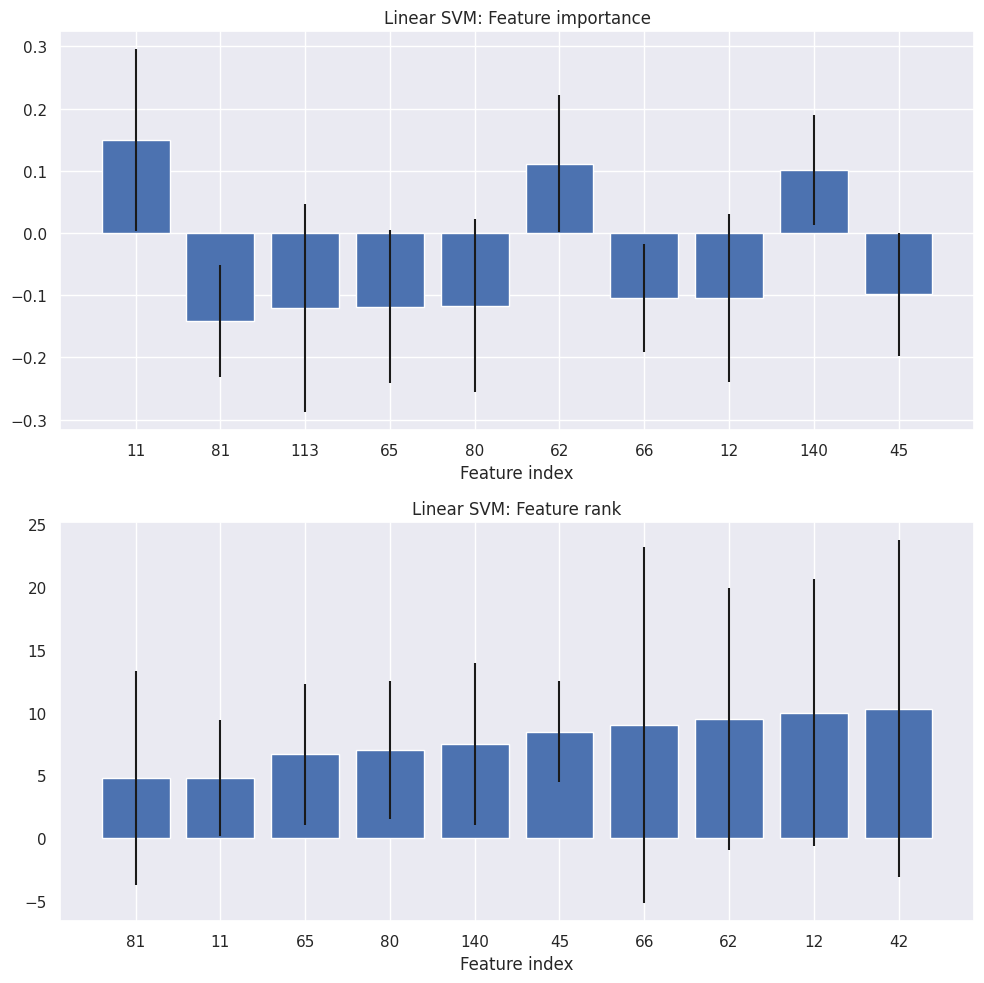

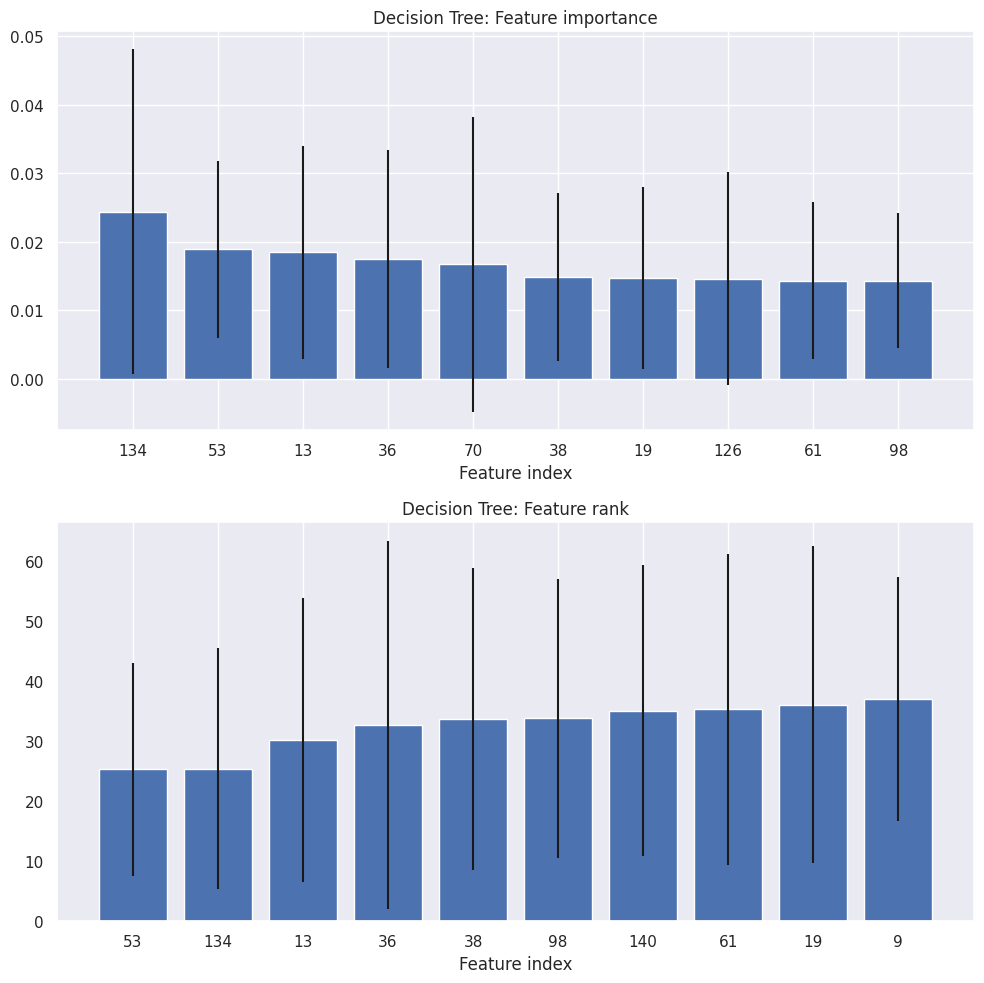

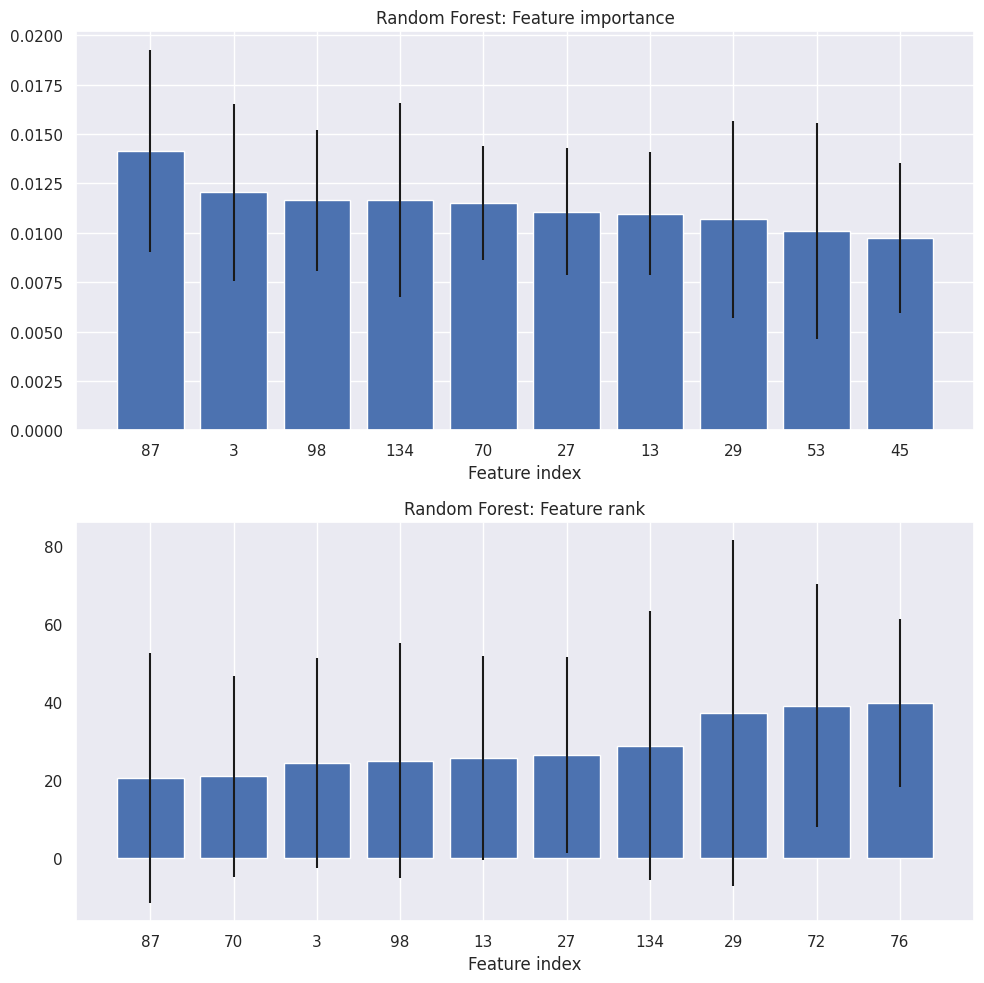

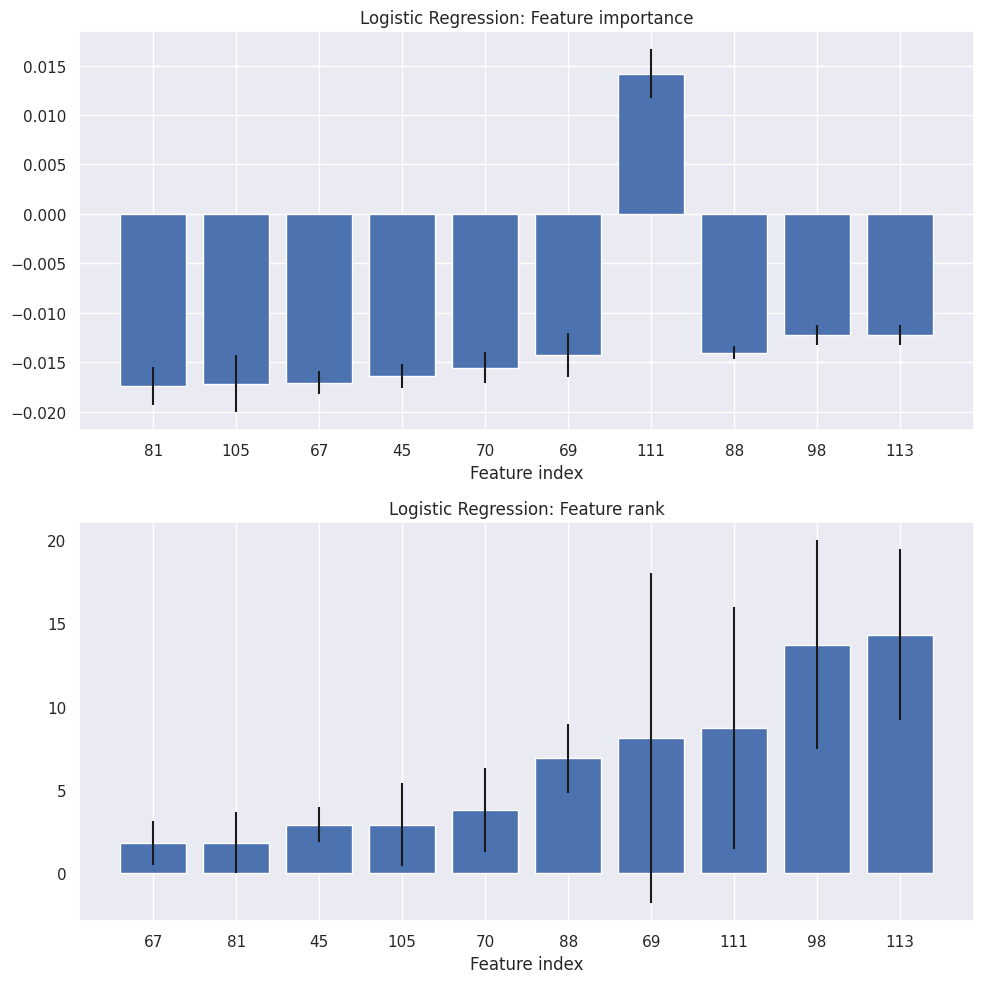

In [22]:
seed = ["pITG_R"]

run_pITG_R = run_poly(df_boot, data, seed)
run_pITG_R.plot_scores()
run_pITG_R.plot_features(ntop=10)

## All left

2023-03-28 11:48:02,902 - polyssifier - INFO - Detected 2 classes in label
2023-03-28 11:48:02,903 - polyssifier - INFO - Building classifiers ...
2023-03-28 11:48:02,907 - polyssifier - INFO - Initialization, done.
2023-03-28 11:48:02,932 - polyssifier - INFO - Training Multilayer Perceptron 0
2023-03-28 11:48:05,160 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.84, 2.23 sec
2023-03-28 11:48:05,166 - polyssifier - INFO - Training Multilayer Perceptron 1
2023-03-28 11:48:07,362 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.83, 2.20 sec
2023-03-28 11:48:07,368 - polyssifier - INFO - Training Multilayer Perceptron 2
2023-03-28 11:48:09,763 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.92, 2.39 sec
2023-03-28 11:48:09,768 - polyssifier - INFO - Training Multilayer Perceptron 3
2023-03-28 11:48:12,331 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.87, 2.56 sec
2023-03-28 11:48:12,335 - polyss

predict proba return shape (57,)


2023-03-28 11:49:00,165 - polyssifier - INFO - Linear SVM                 1: Train 0.99/Test 0.82, 4.36 sec
2023-03-28 11:49:00,169 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2023-03-28 11:49:04,413 - polyssifier - INFO - Linear SVM                 2: Train 1.00/Test 0.76, 4.24 sec
2023-03-28 11:49:04,417 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2023-03-28 11:49:09,553 - polyssifier - INFO - Linear SVM                 3: Train 1.00/Test 0.78, 5.14 sec
2023-03-28 11:49:09,558 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2023-03-28 11:49:14,192 - polyssifier - INFO - Linear SVM                 4: Train 1.00/Test 0.77, 4.63 sec
2023-03-28 11:49:14,196 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2023-03-28 11:49:18,896 - polyssifier - INFO - Linear SVM                 5: Train 1.00/Test 0.76, 4.70 sec
2023-03-28 11:49:18,901 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2023-03-28 11:49:23,333 - polyssifier - INFO - Linear SVM                 6: Train 1.00/Test 0.78, 4.43 sec
2023-03-28 11:49:23,337 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2023-03-28 11:49:27,859 - polyssifier - INFO - Linear SVM                 7: Train 1.00/Test 0.74, 4.52 sec
2023-03-28 11:49:27,865 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2023-03-28 11:49:32,378 - polyssifier - INFO - Linear SVM                 8: Train 1.00/Test 0.71, 4.51 sec
2023-03-28 11:49:32,383 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2023-03-28 11:49:37,243 - polyssifier - INFO - Linear SVM                 9: Train 1.00/Test 0.78, 4.86 sec
2023-03-28 11:49:37,248 - polyssifier - INFO - Training Decision Tree 0
2023-03-28 11:49:37,278 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.58, 0.03 sec
2023-03-28 11:49:37,284 - polyssifier - INFO - Training Decision Tree 1
2023-03-28 11:49:37,311 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.58, 0.03 sec
2023-03-28 11:49:37,315 - polyssifier - INFO - Training Decision Tree 2
2023-03-28 11:49:37,335 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.52, 0.02 sec
2023-03-28 11:49:37,340 - polyssifier - INFO - Training Decision Tree 3
2023-03-28 11:49:37,359 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.62, 0.02 sec
2023-03-28 11:49:37,363 - polyssifier - INFO - Training Decision Tree 4
2023-03-28 11:49:37,381 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.53, 0

predict proba return shape (57,)


2023-03-28 11:49:37,450 - polyssifier - INFO - Decision Tree              7: Train 1.00/Test 0.48, 0.02 sec
2023-03-28 11:49:37,455 - polyssifier - INFO - Training Decision Tree 8
2023-03-28 11:49:37,473 - polyssifier - INFO - Decision Tree              8: Train 1.00/Test 0.62, 0.02 sec
2023-03-28 11:49:37,477 - polyssifier - INFO - Training Decision Tree 9
2023-03-28 11:49:37,495 - polyssifier - INFO - Decision Tree              9: Train 1.00/Test 0.52, 0.02 sec
2023-03-28 11:49:37,499 - polyssifier - INFO - Training Random Forest 0
2023-03-28 11:49:39,642 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.74, 2.14 sec
2023-03-28 11:49:39,648 - polyssifier - INFO - Training Random Forest 1
2023-03-28 11:49:41,805 - polyssifier - INFO - Random Forest              1: Train 1.00/Test 0.62, 2.16 sec
2023-03-28 11:49:41,812 - polyssifier - INFO - Training Random Forest 2
2023-03-28 11:49:43,978 - polyssifier - INFO - Random Forest              2: Train 1.00/Test 0.74, 2

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.824213  0.055281  0.728288  0.918519
Nearest Neighbors     train  0.782451  0.015272  0.762612  0.816295
                      test   0.697053  0.054714  0.617901  0.813580
SVM                   train  0.989386  0.001292  0.988037  0.992254
                      test   0.793347  0.076337  0.702233  0.884615
Linear SVM            train  0.997880  0.004093  0.986287  0.999633
                      test   0.776928  0.045989  0.705955  0.875309
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.570323  0.053808  0.475806  0.643300
Random Forest         train  0.999963  0.000048  0.999862  1.000000
                      test   0.705235  0.055480  0.620370  0.774814
Logistic Regression   train  0.984144  0.047415  0.849202  0.999710
                      test   0.770899  0.051335 

2023-03-28 11:50:06,953 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2023-03-28 11:50:07,358 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2023-03-28 11:50:07,656 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2023-03-28 11:50:07,941 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


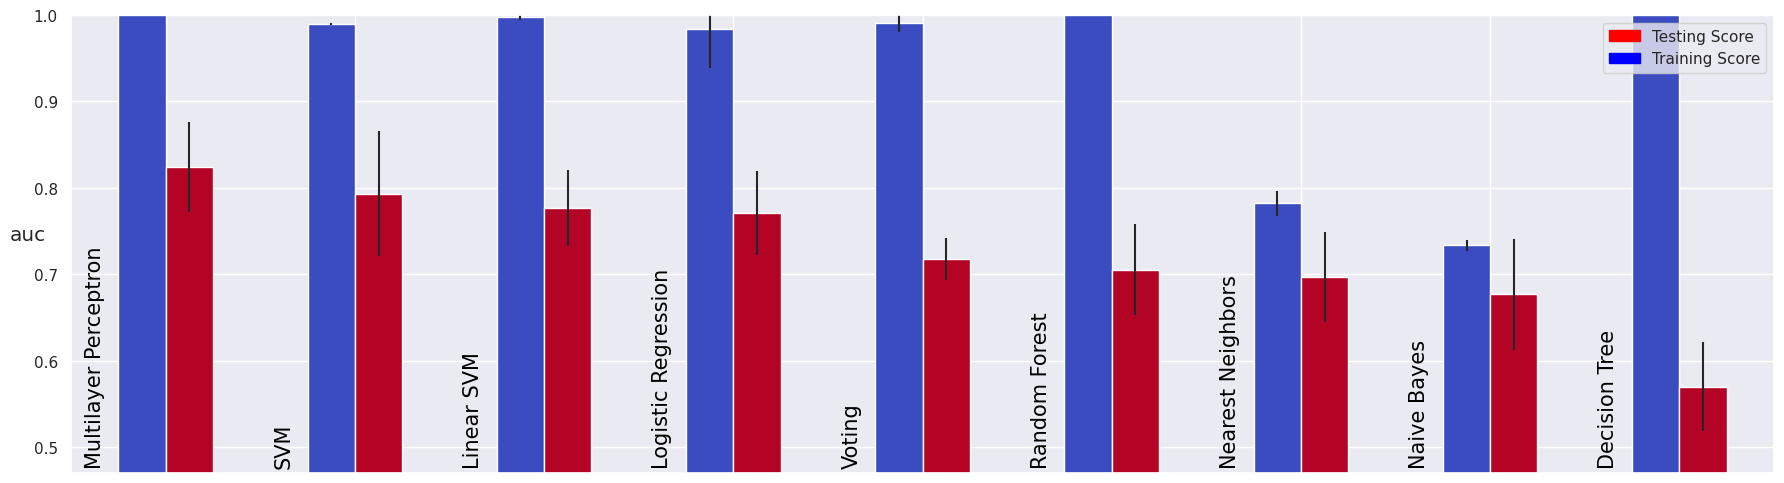

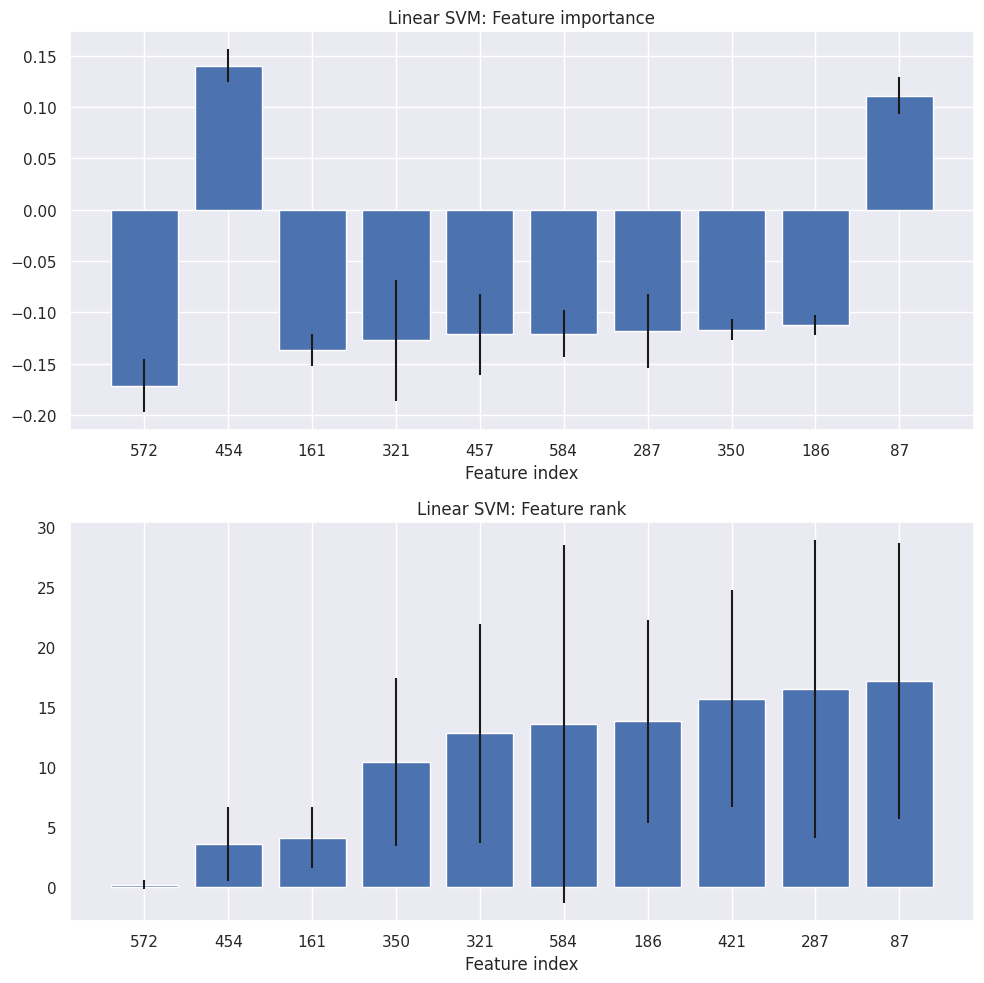

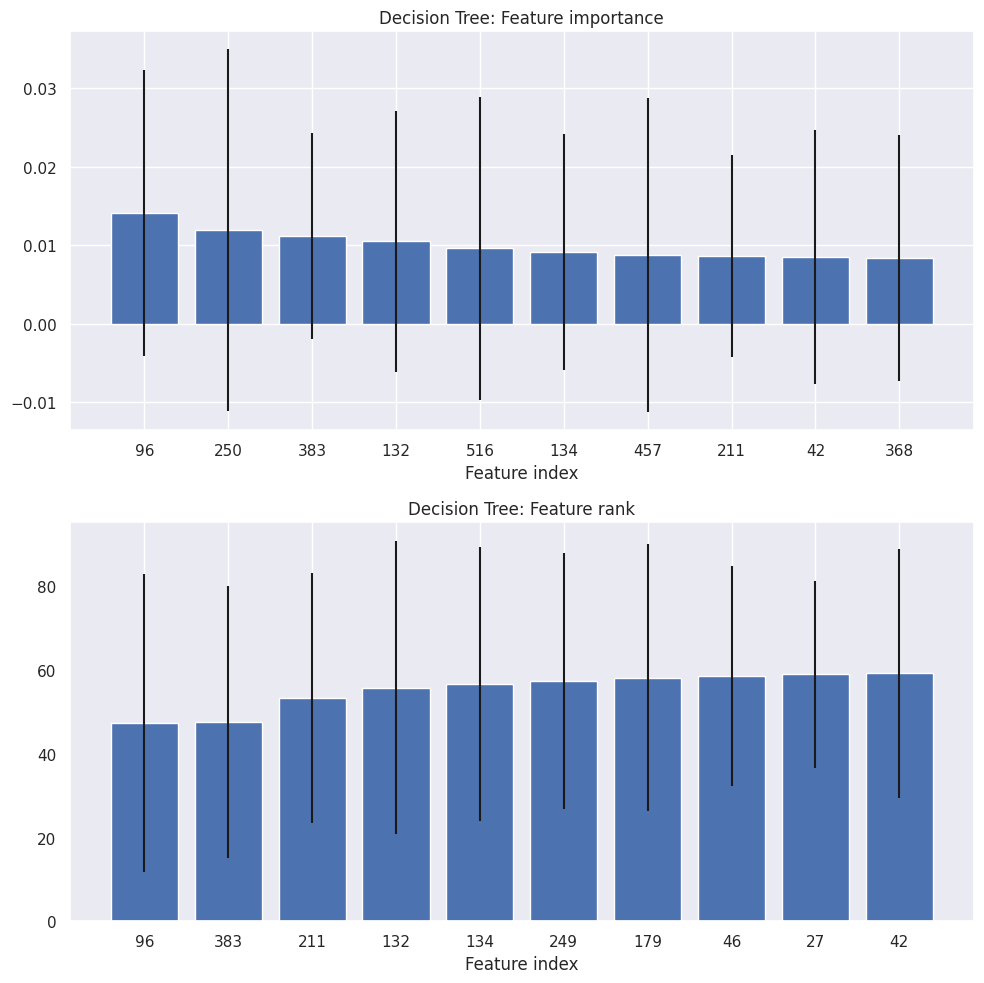

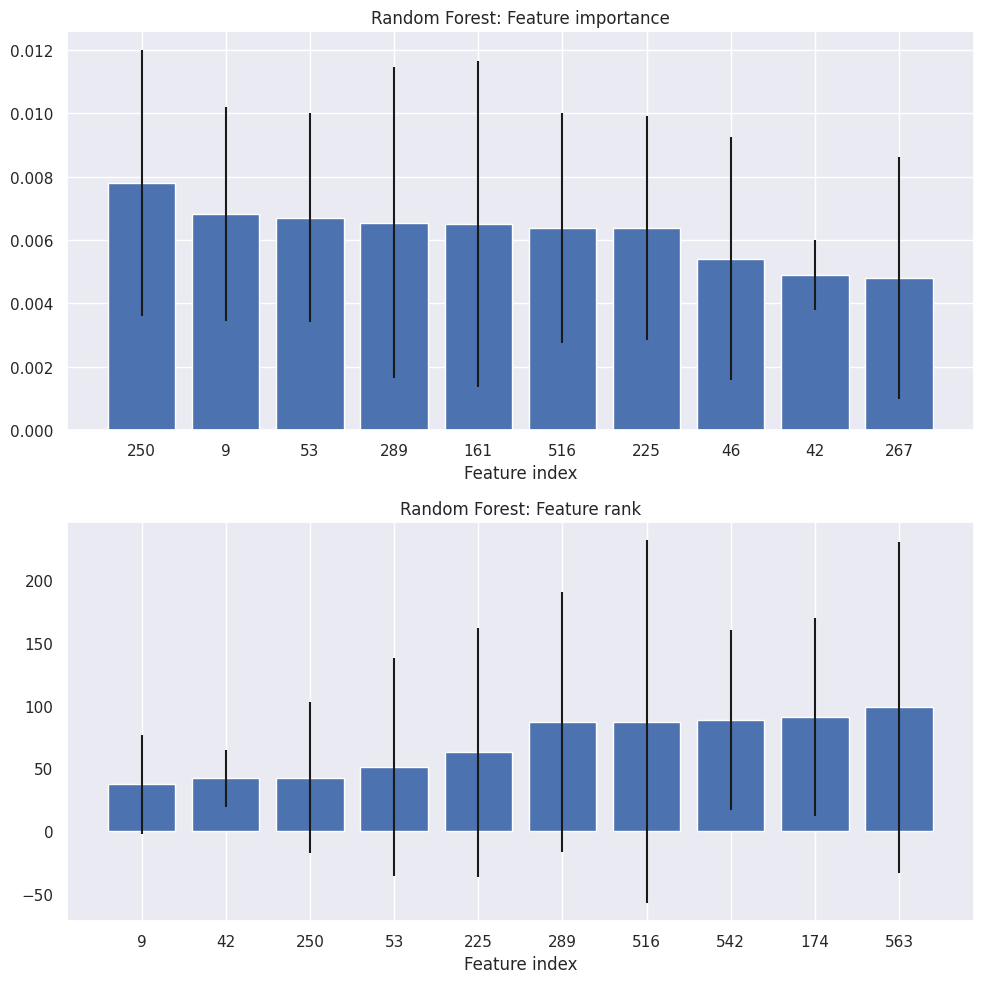

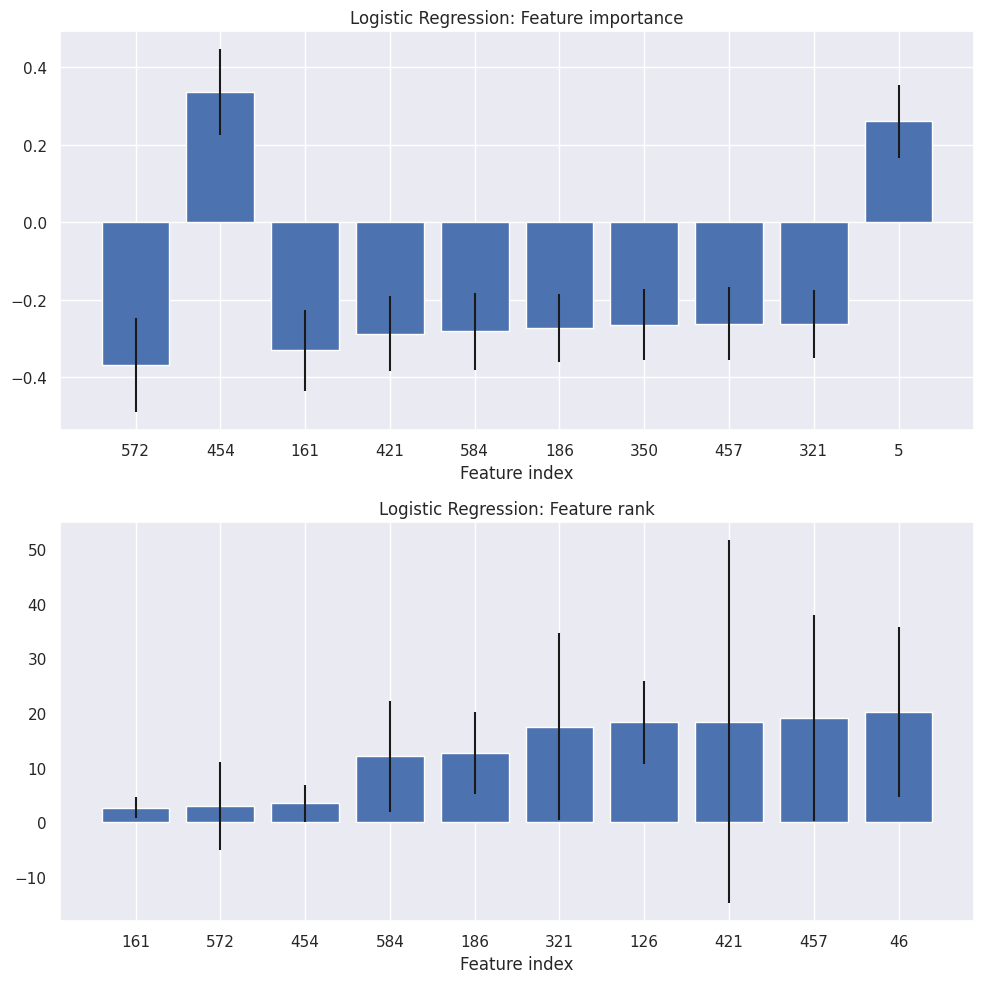

In [23]:
seed = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L"]

run_all_L = run_poly(df_boot, data, seed)
run_all_L.plot_scores()
run_all_L.plot_features(ntop=10)

## All right

2023-03-28 11:51:05,295 - polyssifier - INFO - Detected 2 classes in label
2023-03-28 11:51:05,295 - polyssifier - INFO - Building classifiers ...
2023-03-28 11:51:05,299 - polyssifier - INFO - Initialization, done.
2023-03-28 11:51:05,324 - polyssifier - INFO - Training Multilayer Perceptron 0
2023-03-28 11:51:07,658 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.88, 2.33 sec
2023-03-28 11:51:07,664 - polyssifier - INFO - Training Multilayer Perceptron 1
2023-03-28 11:51:09,651 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.88, 1.99 sec
2023-03-28 11:51:09,657 - polyssifier - INFO - Training Multilayer Perceptron 2
2023-03-28 11:51:11,678 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.92, 2.02 sec
2023-03-28 11:51:11,684 - polyssifier - INFO - Training Multilayer Perceptron 3
2023-03-28 11:51:13,696 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.87, 2.01 sec
2023-03-28 11:51:13,701 - polyss

predict proba return shape (57,)


2023-03-28 11:51:57,151 - polyssifier - INFO - Linear SVM                 1: Train 1.00/Test 0.86, 5.01 sec
2023-03-28 11:51:57,156 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2023-03-28 11:52:01,709 - polyssifier - INFO - Linear SVM                 2: Train 1.00/Test 0.85, 4.55 sec
2023-03-28 11:52:01,713 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2023-03-28 11:52:06,559 - polyssifier - INFO - Linear SVM                 3: Train 1.00/Test 0.93, 4.85 sec
2023-03-28 11:52:06,563 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2023-03-28 11:52:11,082 - polyssifier - INFO - Linear SVM                 4: Train 1.00/Test 0.85, 4.52 sec
2023-03-28 11:52:11,086 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2023-03-28 11:52:15,966 - polyssifier - INFO - Linear SVM                 5: Train 1.00/Test 0.86, 4.88 sec
2023-03-28 11:52:15,971 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2023-03-28 11:52:20,931 - polyssifier - INFO - Linear SVM                 6: Train 1.00/Test 0.89, 4.96 sec
2023-03-28 11:52:20,936 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2023-03-28 11:52:26,515 - polyssifier - INFO - Linear SVM                 7: Train 1.00/Test 0.86, 5.58 sec
2023-03-28 11:52:26,520 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2023-03-28 11:52:31,122 - polyssifier - INFO - Linear SVM                 8: Train 1.00/Test 0.84, 4.60 sec
2023-03-28 11:52:31,128 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2023-03-28 11:52:35,757 - polyssifier - INFO - Linear SVM                 9: Train 1.00/Test 0.87, 4.63 sec
2023-03-28 11:52:35,762 - polyssifier - INFO - Training Decision Tree 0
2023-03-28 11:52:35,788 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.52, 0.03 sec
2023-03-28 11:52:35,793 - polyssifier - INFO - Training Decision Tree 1
2023-03-28 11:52:35,824 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.58, 0.03 sec
2023-03-28 11:52:35,828 - polyssifier - INFO - Training Decision Tree 2
2023-03-28 11:52:35,847 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.49, 0.02 sec
2023-03-28 11:52:35,851 - polyssifier - INFO - Training Decision Tree 3
2023-03-28 11:52:35,871 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.58, 0.02 sec
2023-03-28 11:52:35,875 - polyssifier - INFO - Training Decision Tree 4
2023-03-28 11:52:35,893 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.50, 0

predict proba return shape (57,)


2023-03-28 11:52:35,958 - polyssifier - INFO - Decision Tree              7: Train 1.00/Test 0.46, 0.02 sec
2023-03-28 11:52:35,963 - polyssifier - INFO - Training Decision Tree 8
2023-03-28 11:52:35,981 - polyssifier - INFO - Decision Tree              8: Train 1.00/Test 0.59, 0.02 sec
2023-03-28 11:52:35,986 - polyssifier - INFO - Training Decision Tree 9
2023-03-28 11:52:36,004 - polyssifier - INFO - Decision Tree              9: Train 1.00/Test 0.49, 0.02 sec
2023-03-28 11:52:36,008 - polyssifier - INFO - Training Random Forest 0
2023-03-28 11:52:38,147 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.62, 2.14 sec
2023-03-28 11:52:38,154 - polyssifier - INFO - Training Random Forest 1
2023-03-28 11:52:40,316 - polyssifier - INFO - Random Forest              1: Train 1.00/Test 0.71, 2.16 sec
2023-03-28 11:52:40,323 - polyssifier - INFO - Training Random Forest 2
2023-03-28 11:52:42,447 - polyssifier - INFO - Random Forest              2: Train 1.00/Test 0.74, 2

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.863873  0.047224  0.761787  0.933002
Nearest Neighbors     train  0.831995  0.020836  0.811724  0.871887
                      test   0.720719  0.054792  0.645161  0.786420
SVM                   train  0.996217  0.000610  0.995215  0.996944
                      test   0.850652  0.048098  0.794045  0.937965
Linear SVM            train  0.999737  0.000466  0.998426  1.000000
                      test   0.870213  0.025012  0.837469  0.928395
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.530874  0.046086  0.459677  0.585608
Random Forest         train  0.999942  0.000096  0.999702  1.000000
                      test   0.703123  0.049136  0.622222  0.761728
Logistic Regression   train  0.999849  0.000106  0.999694  1.000000
                      test   0.876016  0.034686 

2023-03-28 11:53:05,212 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2023-03-28 11:53:05,512 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2023-03-28 11:53:05,841 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2023-03-28 11:53:06,128 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


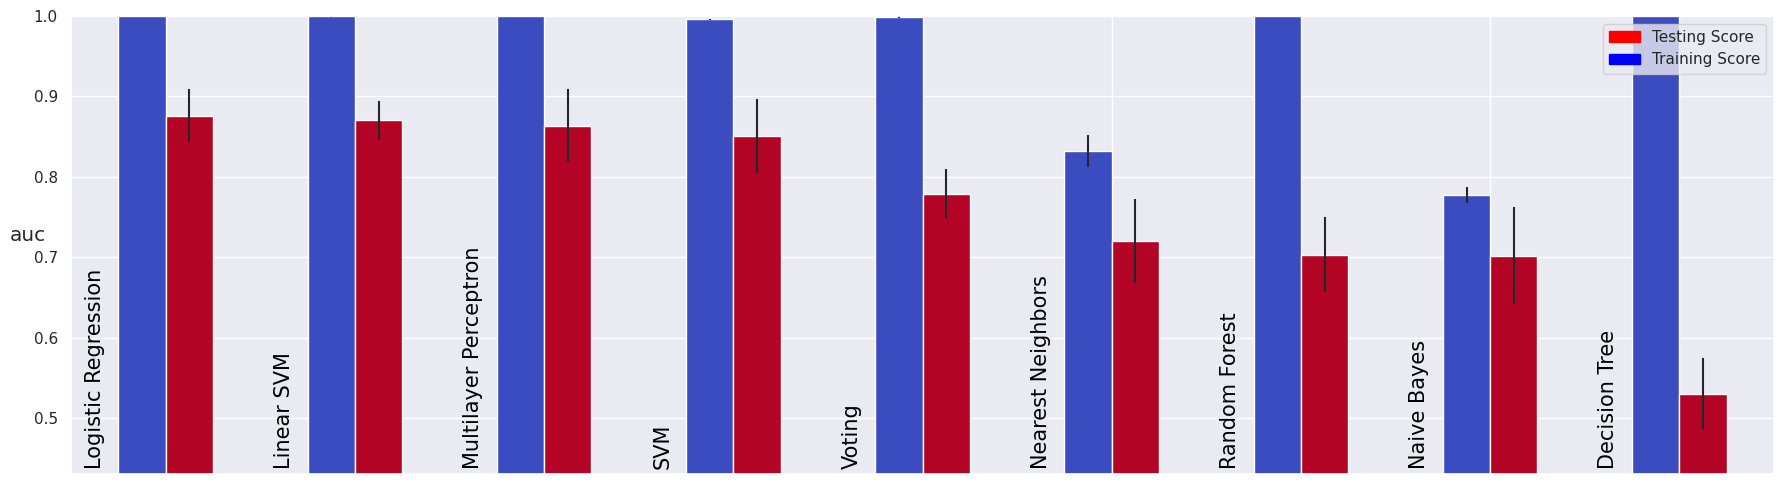

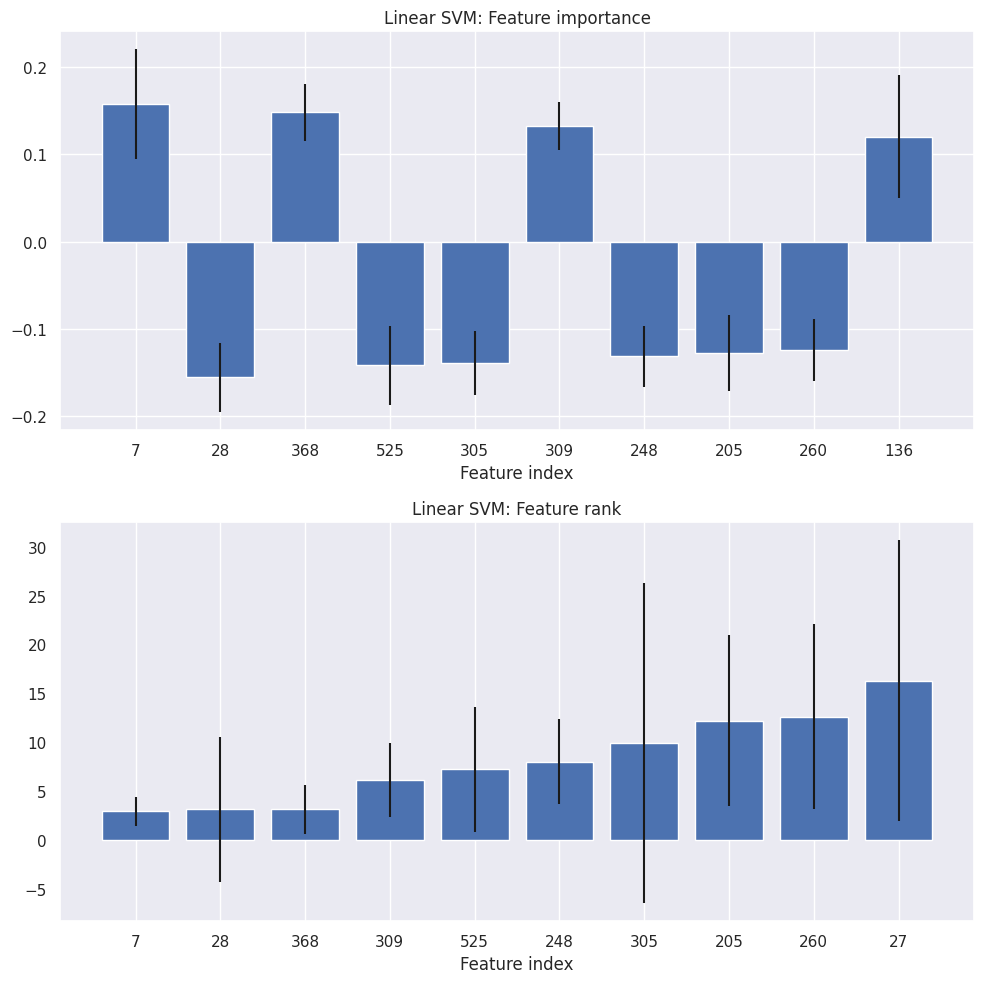

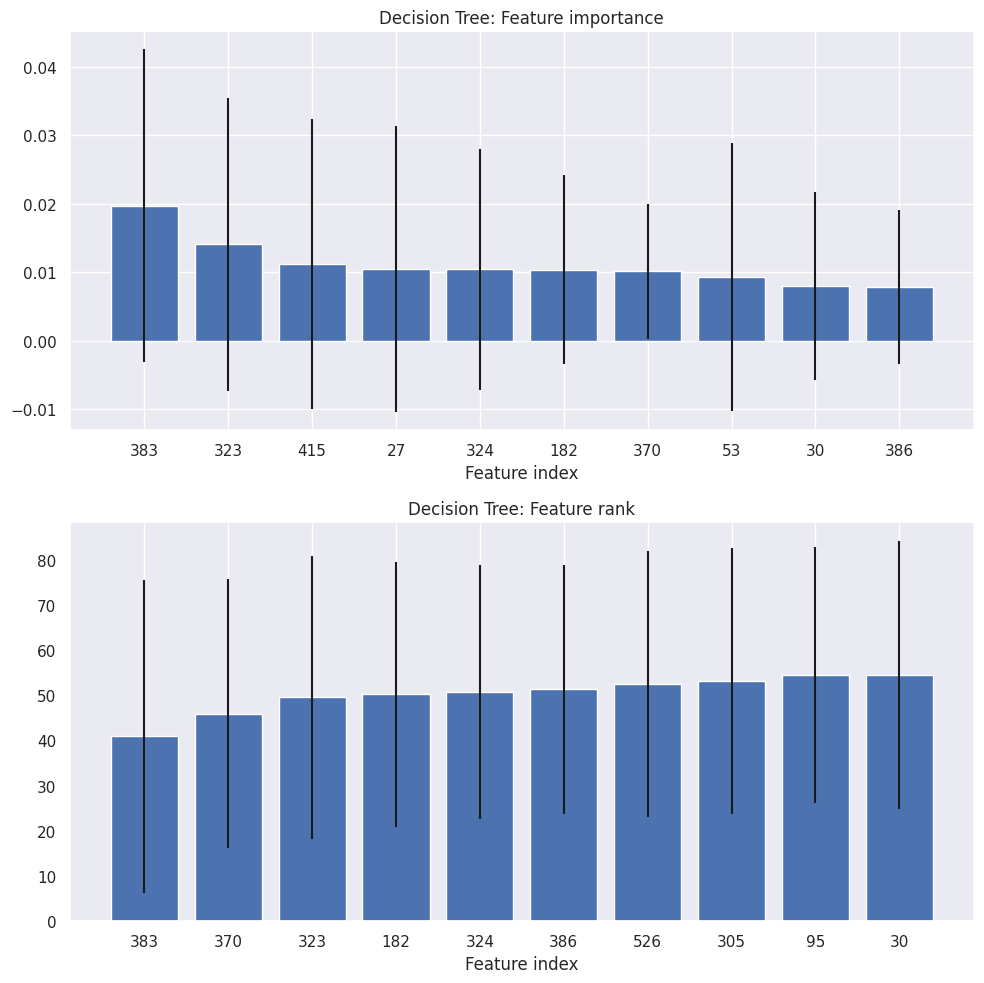

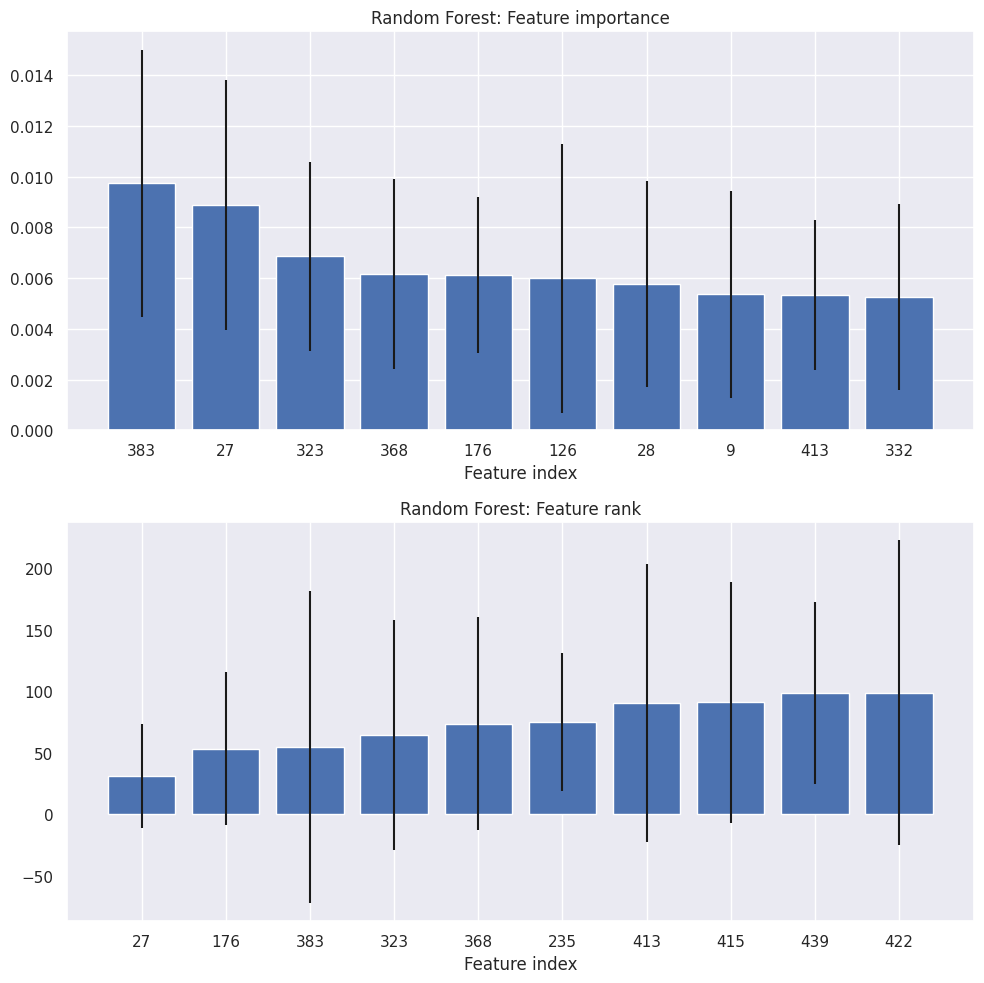

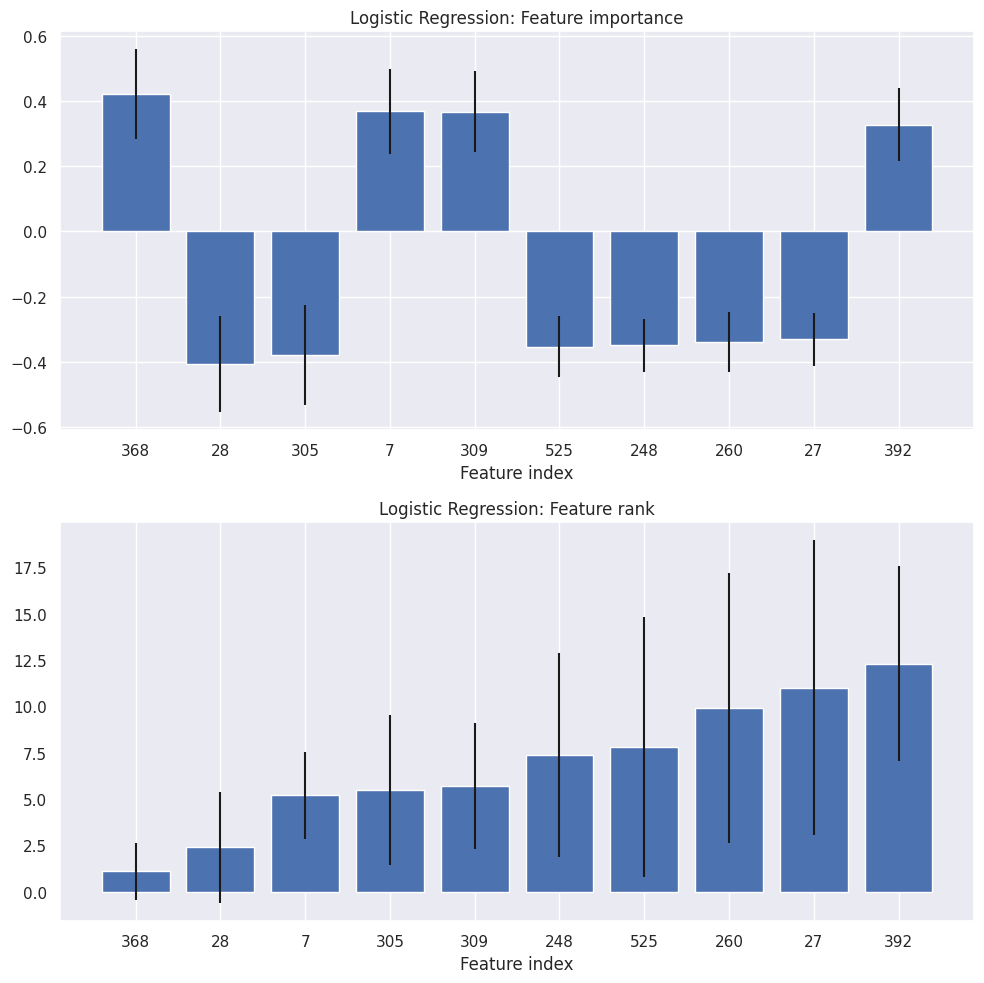

In [24]:
seed = ["opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]

run_all_R = run_poly(df_boot, data, seed)
run_all_R.plot_scores()
run_all_R.plot_features(ntop=10)

# 1 resting state scan

In [ ]:
def run(df_boot, data, seed):\n",
    #    df_bootstrap = pd.DataFrame()\n",
    #     for j in range(0, len(df_boot)):\n",
    #         index = random.randint(0, len(df_boot)-1)\n",
    "#         frames = [df_bootstrap, df_boot[index:index+1]]\n",
    "#         df_bootstrap = pd.concat(frames)\n",
    "\n",
    "#     df_bootstrap = df_bootstrap.drop(df_bootstrap.columns[0], axis=1)\n",
    "\n",
    "    # print(df_bootstrap[\"Gender\"])  # should have the whole list\n",
    "\n",
        x_correl = []\n",
        nb_subjects = len(df_boot)\n",
        subject_label = df_boot[\"subject_label\"][:nb_subjects]\n",
    \n",
        x_correl = []\n",
        for sub in tqdm(subject_label):\n",
            for seed_name in seed:\n",
                x_correl.append(data[sub, seed_name])\n",
    \n",
        x_correl = np.array(x_correl)\n",
        x_correl = x_correl.reshape(len(df_boot), len(seed)*148) # autant de lignes que de sujets, autant de colones (nb region atlas x 8 (seeds))\n",
        \n",
    
        y_sex = df_boot[\"Gender\"][:nb_subjects]  # maybe list(df[\"Gender\"])

        coef = poly(x_correl, y_sex, n_folds=10)
    
        return coef"
   

## REST1_LR

In [20]:
bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_ses-{rest_name}_seed-{seed_name}__voxelcorrelations.nii.gz"
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)
rest = "REST1LR"
data = {}

for seed in SEEDS:
    for sub in tqdm(df_boot["subject_label"]):
        img_path = img_tpl.format(seed_name=seed, participant_id=sub, rest_name = rest)
        data[(sub, seed)] = img4d2vector(img_path, masker)

100%|█████████████████████████████████████████| 570/570 [03:18<00:00,  2.87it/s]


In [21]:
run_polyssifier = run_poly(df_boot, data, ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])

2024-02-23 11:14:27,662 - polyssifier - INFO - Detected 2 classes in label
2024-02-23 11:14:27,663 - polyssifier - INFO - Building classifiers ...
2024-02-23 11:14:27,668 - polyssifier - INFO - Initialization, done.
2024-02-23 11:14:27,695 - polyssifier - INFO - Training Multilayer Perceptron 0
2024-02-23 11:14:31,226 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.87, 3.53 sec
2024-02-23 11:14:31,235 - polyssifier - INFO - Training Multilayer Perceptron 1
2024-02-23 11:14:33,887 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.84, 2.65 sec
2024-02-23 11:14:33,896 - polyssifier - INFO - Training Multilayer Perceptron 2
2024-02-23 11:14:36,556 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.85, 2.66 sec
2024-02-23 11:14:36,565 - polyssifier - INFO - Training Multilayer Perceptron 3
2024-02-23 11:14:39,305 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.88, 2.74 sec
2024-02-23 11:14:39,314 - polyss

predict proba return shape (57,)


2024-02-23 11:15:43,214 - polyssifier - INFO - Linear SVM                 1: Train 1.00/Test 0.83, 4.95 sec
2024-02-23 11:15:43,222 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2024-02-23 11:15:49,355 - polyssifier - INFO - Linear SVM                 2: Train 1.00/Test 0.88, 6.13 sec
2024-02-23 11:15:49,363 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2024-02-23 11:15:54,559 - polyssifier - INFO - Linear SVM                 3: Train 1.00/Test 0.88, 5.20 sec
2024-02-23 11:15:54,566 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2024-02-23 11:15:59,602 - polyssifier - INFO - Linear SVM                 4: Train 1.00/Test 0.83, 5.04 sec
2024-02-23 11:15:59,610 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2024-02-23 11:16:04,859 - polyssifier - INFO - Linear SVM                 5: Train 1.00/Test 0.83, 5.25 sec
2024-02-23 11:16:04,867 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2024-02-23 11:16:10,112 - polyssifier - INFO - Linear SVM                 6: Train 1.00/Test 0.85, 5.24 sec
2024-02-23 11:16:10,120 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2024-02-23 11:16:15,247 - polyssifier - INFO - Linear SVM                 7: Train 1.00/Test 0.86, 5.13 sec
2024-02-23 11:16:15,256 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2024-02-23 11:16:20,824 - polyssifier - INFO - Linear SVM                 8: Train 1.00/Test 0.92, 5.57 sec
2024-02-23 11:16:20,831 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2024-02-23 11:16:25,510 - polyssifier - INFO - Linear SVM                 9: Train 1.00/Test 0.92, 4.68 sec
2024-02-23 11:16:25,517 - polyssifier - INFO - Training Decision Tree 0
2024-02-23 11:16:25,555 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.56, 0.04 sec
2024-02-23 11:16:25,562 - polyssifier - INFO - Training Decision Tree 1
2024-02-23 11:16:25,594 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.47, 0.03 sec
2024-02-23 11:16:25,601 - polyssifier - INFO - Training Decision Tree 2
2024-02-23 11:16:25,626 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.60, 0.02 sec
2024-02-23 11:16:25,632 - polyssifier - INFO - Training Decision Tree 3
2024-02-23 11:16:25,659 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.57, 0.03 sec
2024-02-23 11:16:25,664 - polyssifier - INFO - Training Decision Tree 4
2024-02-23 11:16:25,692 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.61, 0

predict proba return shape (57,)


2024-02-23 11:16:25,725 - polyssifier - INFO - Decision Tree              5: Train 1.00/Test 0.61, 0.03 sec
2024-02-23 11:16:25,730 - polyssifier - INFO - Training Decision Tree 6
2024-02-23 11:16:25,756 - polyssifier - INFO - Decision Tree              6: Train 1.00/Test 0.53, 0.03 sec
2024-02-23 11:16:25,763 - polyssifier - INFO - Training Decision Tree 7
2024-02-23 11:16:25,790 - polyssifier - INFO - Decision Tree              7: Train 1.00/Test 0.50, 0.03 sec
2024-02-23 11:16:25,796 - polyssifier - INFO - Training Decision Tree 8
2024-02-23 11:16:25,822 - polyssifier - INFO - Decision Tree              8: Train 1.00/Test 0.54, 0.03 sec
2024-02-23 11:16:25,828 - polyssifier - INFO - Training Decision Tree 9
2024-02-23 11:16:25,851 - polyssifier - INFO - Decision Tree              9: Train 1.00/Test 0.54, 0.02 sec
2024-02-23 11:16:25,857 - polyssifier - INFO - Training Random Forest 0
2024-02-23 11:16:28,516 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.63, 2

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.856861  0.027604  0.807692  0.897022
Nearest Neighbors     train  0.759620  0.005317  0.751231  0.765363
                      test   0.694066  0.047881  0.612346  0.746278
SVM                   train  0.985938  0.002036  0.982259  0.989335
                      test   0.823069  0.040253  0.771712  0.895062
Linear SVM            train  1.000000  0.000000  1.000000  1.000000
                      test   0.872582  0.034823  0.831266  0.921836
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.554054  0.045688  0.474074  0.614144
Random Forest         train  0.999835  0.000160  0.999503  1.000000
                      test   0.699897  0.068604  0.588272  0.798387
Logistic Regression   train  1.000000  0.000000  1.000000  1.000000
                      test   0.882996  0.032178 

2024-02-23 11:17:12,630 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2024-02-23 11:17:12,947 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2024-02-23 11:17:13,230 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2024-02-23 11:17:13,528 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


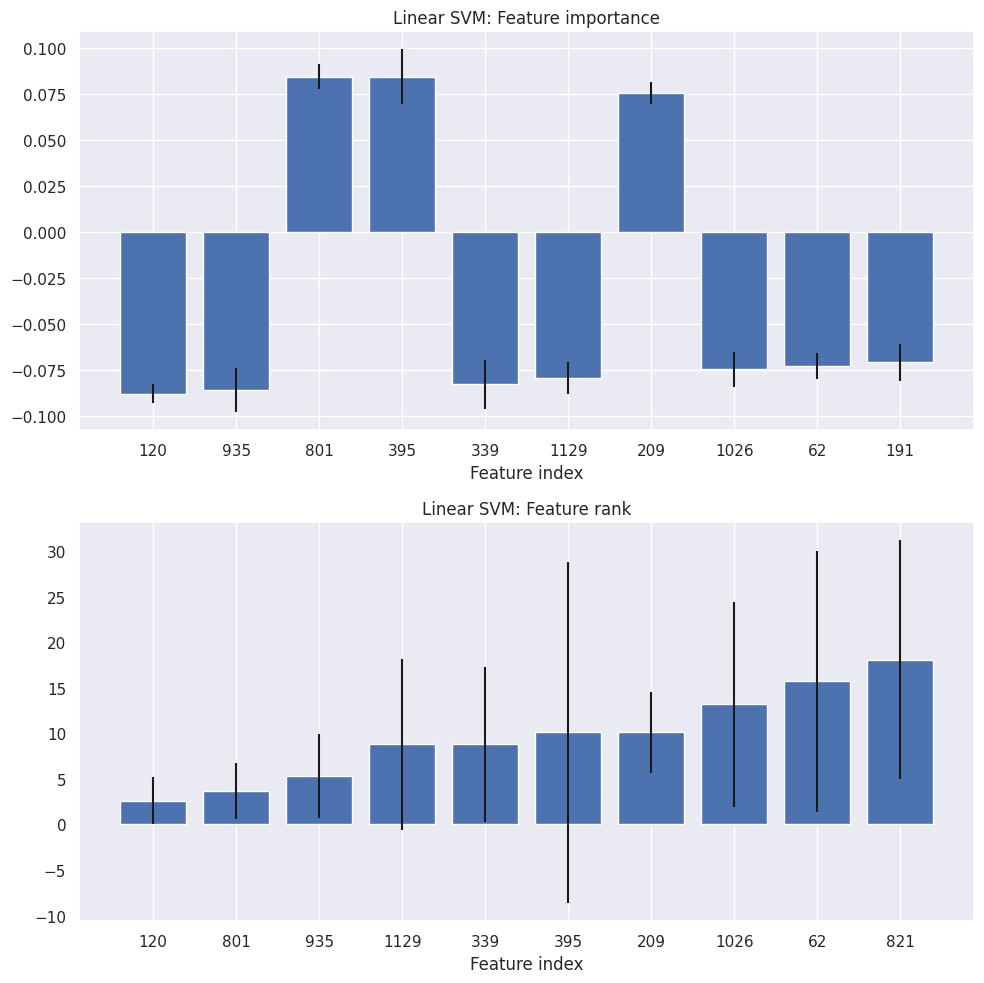

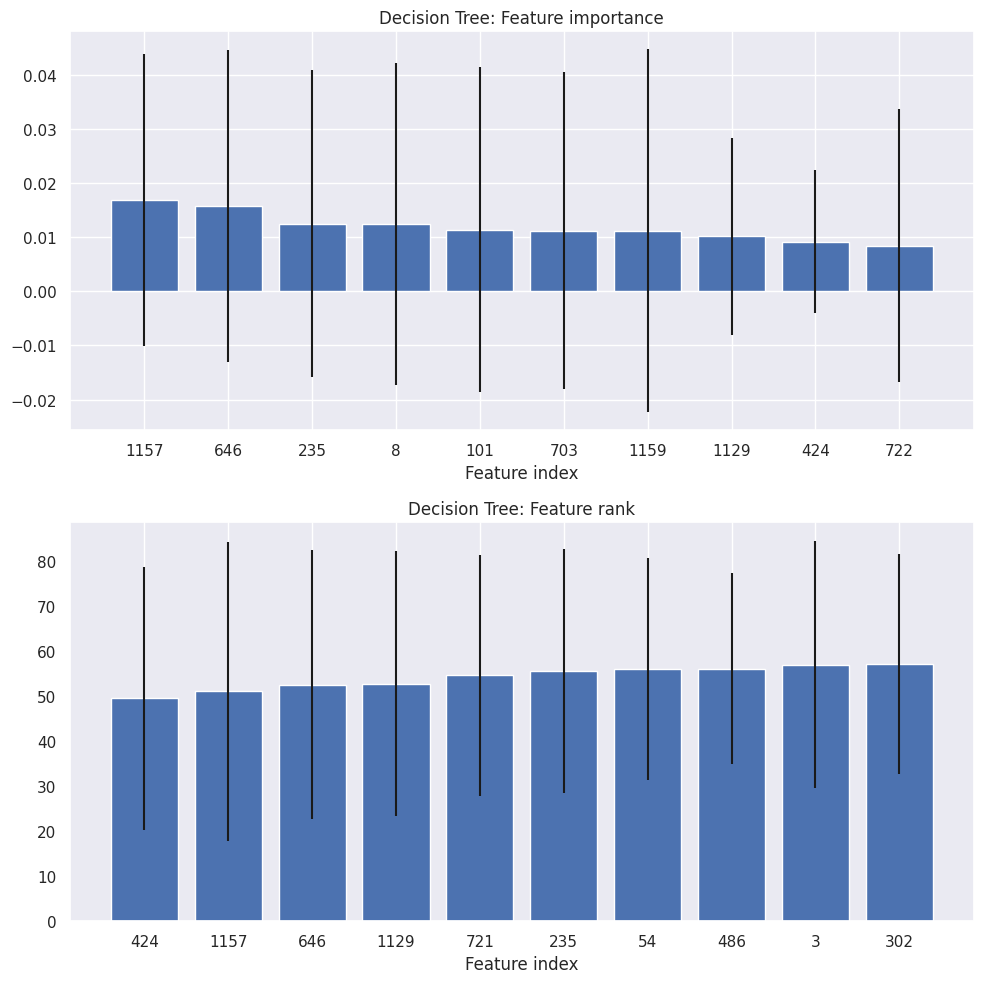

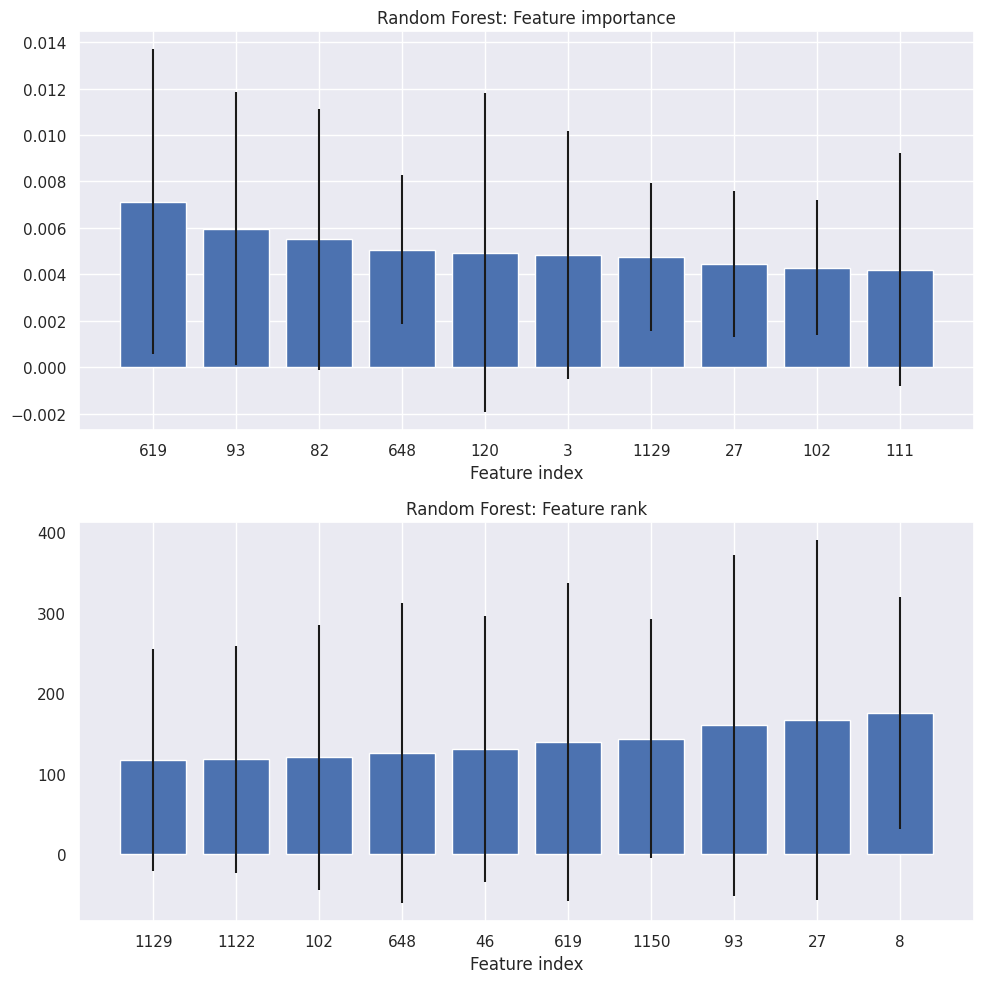

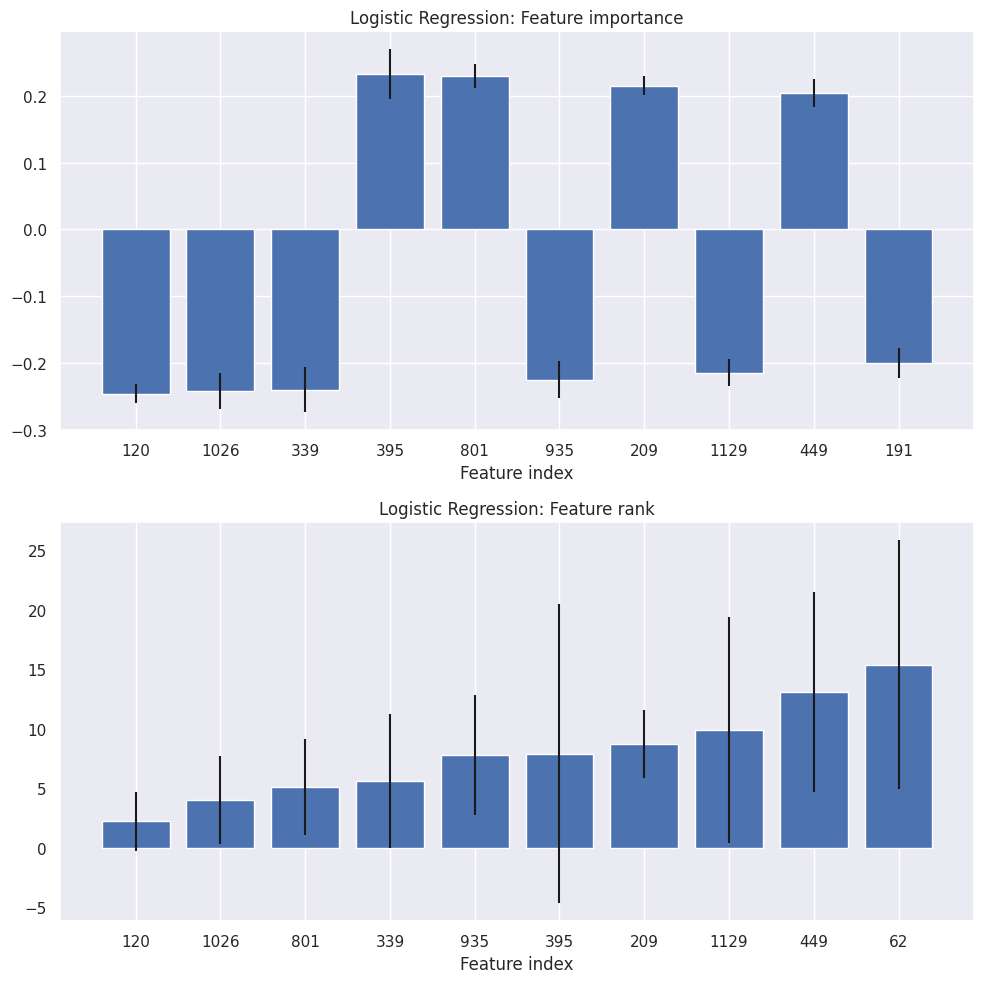

In [22]:
run_polyssifier.plot_features(ntop=10)

## REST1_RL

In [23]:
bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_ses-{rest_name}_seed-{seed_name}__voxelcorrelations.nii.gz"
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)
rest = "REST1RL"
data = {}

for seed in SEEDS:
    for sub in tqdm(df_boot["subject_label"]):
        img_path = img_tpl.format(seed_name=seed, participant_id=sub, rest_name = rest)
        data[(sub, seed)] = img4d2vector(img_path, masker)

100%|█████████████████████████████████████████| 570/570 [03:58<00:00,  2.39it/s]


In [24]:
run_polyssifier = run_poly(df_boot, data, ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])

2024-02-23 11:56:56,539 - polyssifier - INFO - Detected 2 classes in label
2024-02-23 11:56:56,539 - polyssifier - INFO - Building classifiers ...
2024-02-23 11:56:56,544 - polyssifier - INFO - Initialization, done.
2024-02-23 11:56:56,575 - polyssifier - INFO - Training Multilayer Perceptron 0
2024-02-23 11:56:59,499 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.80, 2.92 sec
2024-02-23 11:56:59,507 - polyssifier - INFO - Training Multilayer Perceptron 1
2024-02-23 11:57:02,684 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.80, 3.18 sec
2024-02-23 11:57:02,693 - polyssifier - INFO - Training Multilayer Perceptron 2
2024-02-23 11:57:05,281 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.91, 2.59 sec
2024-02-23 11:57:05,290 - polyssifier - INFO - Training Multilayer Perceptron 3
2024-02-23 11:57:07,805 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.80, 2.52 sec
2024-02-23 11:57:07,817 - polyss

predict proba return shape (57,)


2024-02-23 11:58:10,463 - polyssifier - INFO - Linear SVM                 1: Train 1.00/Test 0.79, 5.24 sec
2024-02-23 11:58:10,471 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2024-02-23 11:58:15,644 - polyssifier - INFO - Linear SVM                 2: Train 1.00/Test 0.94, 5.17 sec
2024-02-23 11:58:15,652 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2024-02-23 11:58:20,129 - polyssifier - INFO - Linear SVM                 3: Train 1.00/Test 0.81, 4.48 sec
2024-02-23 11:58:20,137 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2024-02-23 11:58:24,819 - polyssifier - INFO - Linear SVM                 4: Train 1.00/Test 0.81, 4.68 sec
2024-02-23 11:58:24,827 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2024-02-23 11:58:30,180 - polyssifier - INFO - Linear SVM                 5: Train 1.00/Test 0.85, 5.35 sec
2024-02-23 11:58:30,187 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2024-02-23 11:58:35,239 - polyssifier - INFO - Linear SVM                 6: Train 1.00/Test 0.89, 5.05 sec
2024-02-23 11:58:35,247 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2024-02-23 11:58:40,243 - polyssifier - INFO - Linear SVM                 7: Train 1.00/Test 0.87, 5.00 sec
2024-02-23 11:58:40,252 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2024-02-23 11:58:45,464 - polyssifier - INFO - Linear SVM                 8: Train 1.00/Test 0.85, 5.21 sec
2024-02-23 11:58:45,472 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2024-02-23 11:58:50,130 - polyssifier - INFO - Linear SVM                 9: Train 1.00/Test 0.92, 4.66 sec
2024-02-23 11:58:50,138 - polyssifier - INFO - Training Decision Tree 0
2024-02-23 11:58:50,186 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.56, 0.05 sec
2024-02-23 11:58:50,195 - polyssifier - INFO - Training Decision Tree 1
2024-02-23 11:58:50,222 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.53, 0.03 sec
2024-02-23 11:58:50,229 - polyssifier - INFO - Training Decision Tree 2
2024-02-23 11:58:50,255 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.61, 0.03 sec
2024-02-23 11:58:50,261 - polyssifier - INFO - Training Decision Tree 3
2024-02-23 11:58:50,284 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.63, 0.02 sec
2024-02-23 11:58:50,291 - polyssifier - INFO - Training Decision Tree 4
2024-02-23 11:58:50,317 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.57, 0

predict proba return shape (57,)


2024-02-23 11:58:50,351 - polyssifier - INFO - Decision Tree              5: Train 1.00/Test 0.49, 0.03 sec
2024-02-23 11:58:50,357 - polyssifier - INFO - Training Decision Tree 6
2024-02-23 11:58:50,382 - polyssifier - INFO - Decision Tree              6: Train 1.00/Test 0.47, 0.02 sec
2024-02-23 11:58:50,388 - polyssifier - INFO - Training Decision Tree 7
2024-02-23 11:58:50,415 - polyssifier - INFO - Decision Tree              7: Train 1.00/Test 0.51, 0.03 sec
2024-02-23 11:58:50,422 - polyssifier - INFO - Training Decision Tree 8
2024-02-23 11:58:50,448 - polyssifier - INFO - Decision Tree              8: Train 1.00/Test 0.66, 0.03 sec
2024-02-23 11:58:50,454 - polyssifier - INFO - Training Decision Tree 9
2024-02-23 11:58:50,482 - polyssifier - INFO - Decision Tree              9: Train 1.00/Test 0.55, 0.03 sec
2024-02-23 11:58:50,489 - polyssifier - INFO - Training Random Forest 0
2024-02-23 11:58:53,147 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.60, 2

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.847490  0.048925  0.798765  0.921836
Nearest Neighbors     train  0.769102  0.007009  0.756356  0.779039
                      test   0.707454  0.052355  0.626543  0.812035
SVM                   train  0.978560  0.001893  0.976211  0.981100
                      test   0.813676  0.050244  0.742593  0.872208
Linear SVM            train  1.000000  0.000000  1.000000  1.000000
                      test   0.858983  0.046661  0.793827  0.939506
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.558272  0.061161  0.472705  0.659429
Random Forest         train  0.999663  0.000498  0.998494  1.000000
                      test   0.687842  0.059492  0.601235  0.774814
Logistic Regression   train  1.000000  0.000000  1.000000  1.000000
                      test   0.863818  0.044462 

2024-02-23 11:59:30,671 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2024-02-23 11:59:30,995 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2024-02-23 11:59:31,279 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2024-02-23 11:59:31,550 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


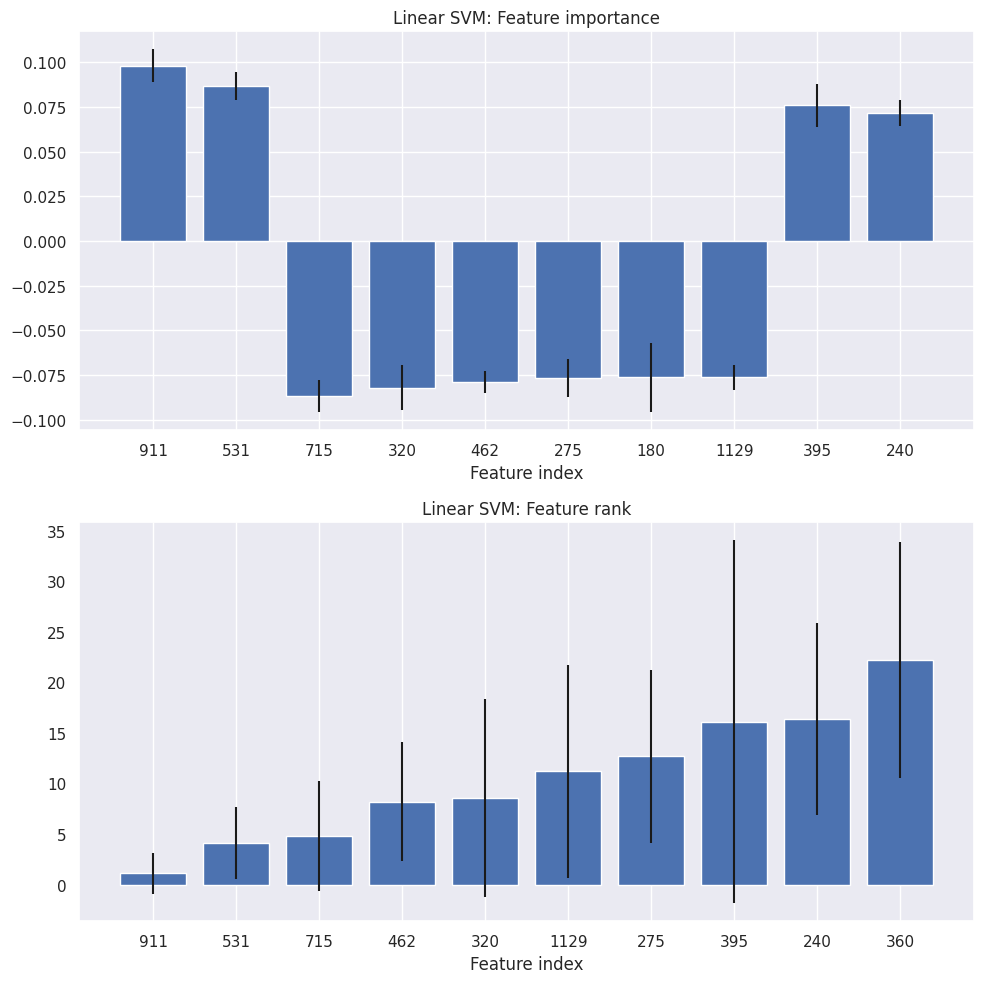

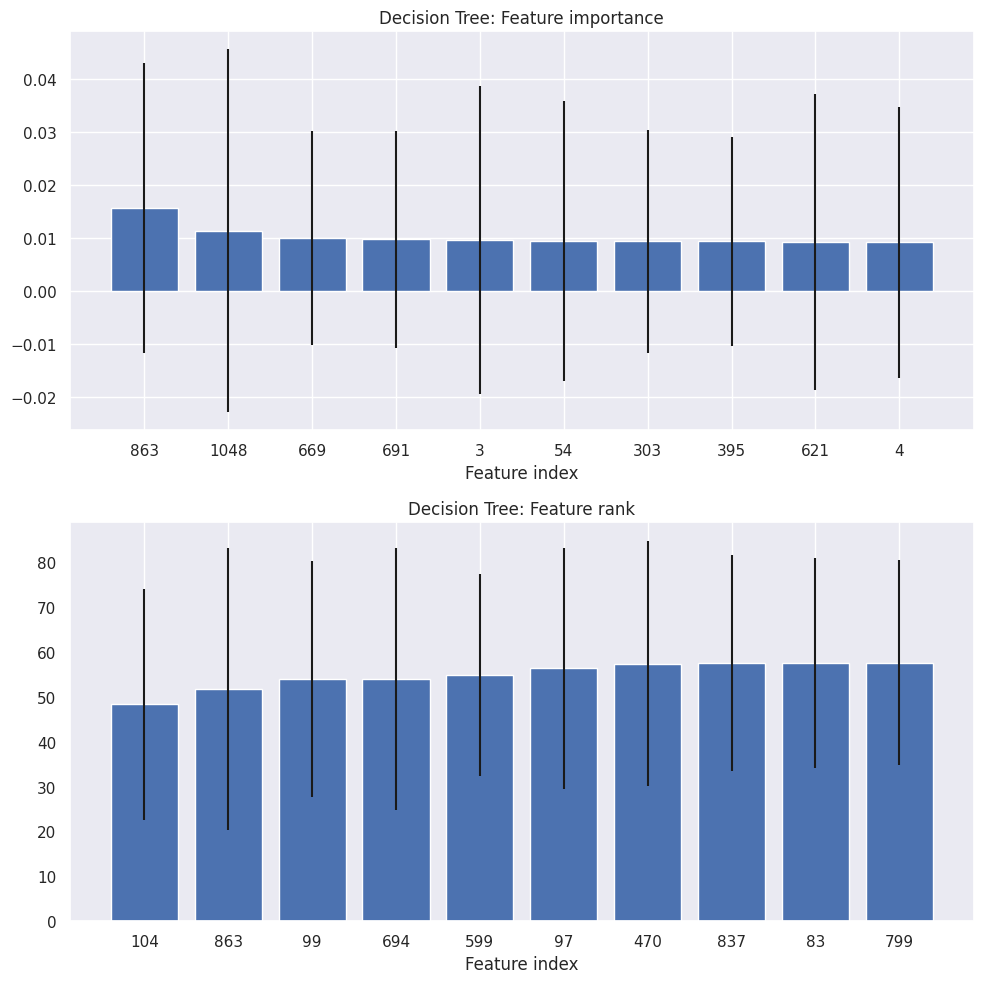

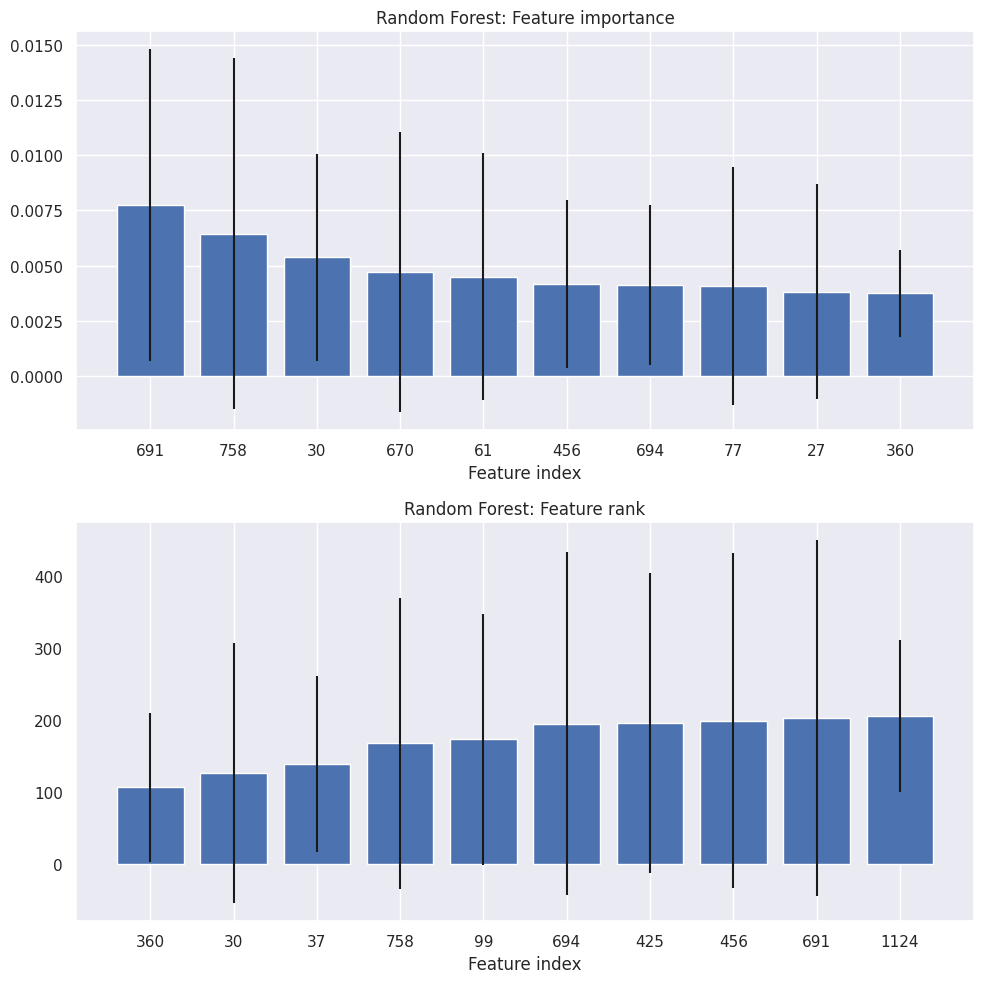

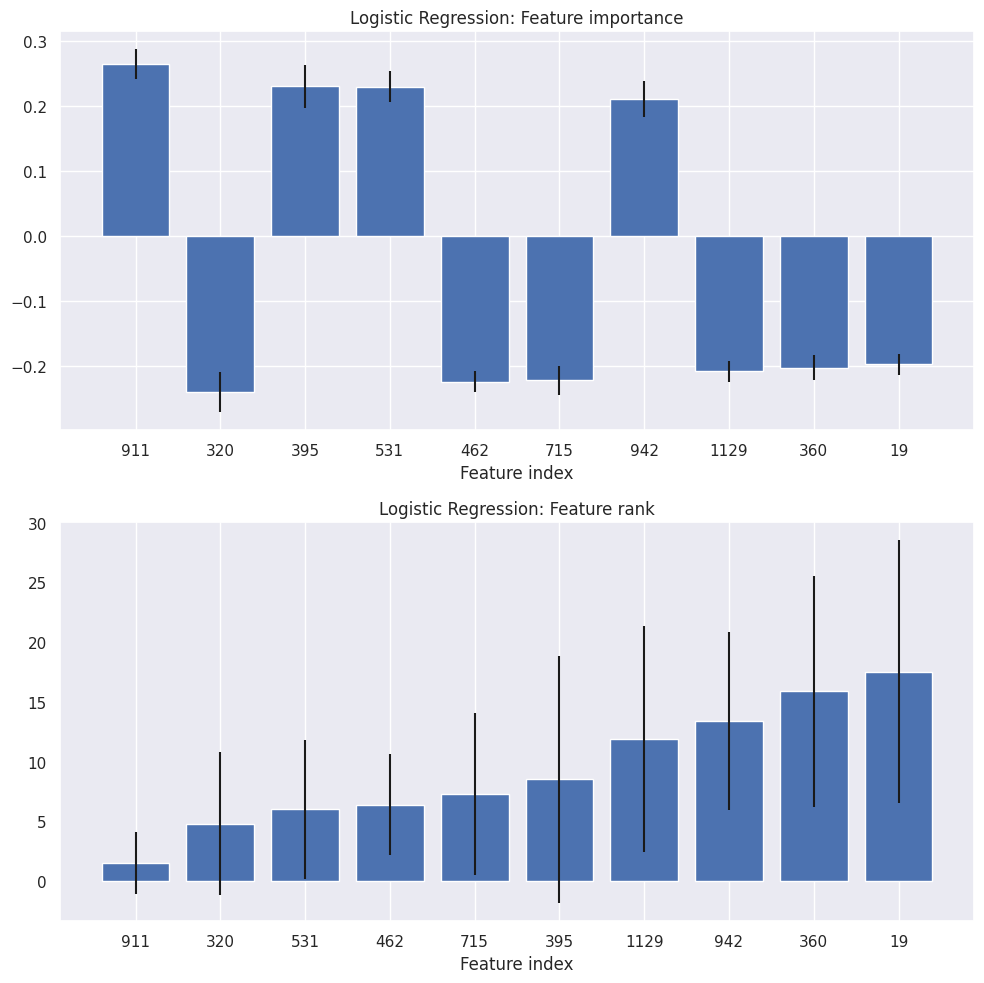

In [25]:
run_polyssifier.plot_features(ntop=10)

## REST2_LR

In [11]:
bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_ses-{rest_name}_seed-{seed_name}__voxelcorrelations.nii.gz"
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)
rest = "REST2LR"
data = {}

for seed in SEEDS:
    for sub in tqdm(df_boot["subject_label"]):
        img_path = img_tpl.format(seed_name=seed, participant_id=sub, rest_name = rest)
        data[(sub, seed)] = img4d2vector(img_path, masker)

100%|█████████████████████████████████████████| 570/570 [02:46<00:00,  3.42it/s]


In [12]:
run_polyssifier = run_poly(df_boot, data, ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])

2024-02-28 11:46:45,286 - polyssifier - INFO - Detected 2 classes in label
2024-02-28 11:46:45,287 - polyssifier - INFO - Building classifiers ...
2024-02-28 11:46:45,294 - polyssifier - INFO - Initialization, done.
2024-02-28 11:46:45,347 - polyssifier - INFO - Training Multilayer Perceptron 0
2024-02-28 11:46:48,769 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.84, 3.42 sec
2024-02-28 11:46:48,779 - polyssifier - INFO - Training Multilayer Perceptron 1
2024-02-28 11:46:51,269 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.88, 2.49 sec
2024-02-28 11:46:51,278 - polyssifier - INFO - Training Multilayer Perceptron 2
2024-02-28 11:46:53,907 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.87, 2.63 sec
2024-02-28 11:46:53,915 - polyssifier - INFO - Training Multilayer Perceptron 3
2024-02-28 11:46:56,729 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.85, 2.81 sec
2024-02-28 11:46:56,738 - polyss

predict proba return shape (57,)


2024-02-28 11:48:00,406 - polyssifier - INFO - Linear SVM                 1: Train 1.00/Test 0.86, 4.64 sec
2024-02-28 11:48:00,414 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2024-02-28 11:48:06,241 - polyssifier - INFO - Linear SVM                 2: Train 1.00/Test 0.86, 5.83 sec
2024-02-28 11:48:06,249 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2024-02-28 11:48:11,379 - polyssifier - INFO - Linear SVM                 3: Train 1.00/Test 0.83, 5.13 sec
2024-02-28 11:48:11,388 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2024-02-28 11:48:16,833 - polyssifier - INFO - Linear SVM                 4: Train 1.00/Test 0.85, 5.45 sec
2024-02-28 11:48:16,842 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2024-02-28 11:48:21,773 - polyssifier - INFO - Linear SVM                 5: Train 1.00/Test 0.87, 4.93 sec
2024-02-28 11:48:21,784 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2024-02-28 11:48:27,379 - polyssifier - INFO - Linear SVM                 6: Train 1.00/Test 0.81, 5.59 sec
2024-02-28 11:48:27,386 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2024-02-28 11:48:31,985 - polyssifier - INFO - Linear SVM                 7: Train 1.00/Test 0.92, 4.60 sec
2024-02-28 11:48:31,993 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2024-02-28 11:48:37,913 - polyssifier - INFO - Linear SVM                 8: Train 1.00/Test 0.93, 5.92 sec
2024-02-28 11:48:37,920 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2024-02-28 11:48:42,945 - polyssifier - INFO - Linear SVM                 9: Train 1.00/Test 0.88, 5.02 sec
2024-02-28 11:48:42,953 - polyssifier - INFO - Training Decision Tree 0
2024-02-28 11:48:42,995 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.49, 0.04 sec
2024-02-28 11:48:43,009 - polyssifier - INFO - Training Decision Tree 1
2024-02-28 11:48:43,035 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.51, 0.03 sec
2024-02-28 11:48:43,041 - polyssifier - INFO - Training Decision Tree 2
2024-02-28 11:48:43,064 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.63, 0.02 sec
2024-02-28 11:48:43,070 - polyssifier - INFO - Training Decision Tree 3
2024-02-28 11:48:43,097 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.58, 0.03 sec
2024-02-28 11:48:43,103 - polyssifier - INFO - Training Decision Tree 4
2024-02-28 11:48:43,129 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.58, 0

predict proba return shape (57,)


2024-02-28 11:48:43,163 - polyssifier - INFO - Decision Tree              5: Train 1.00/Test 0.66, 0.03 sec
2024-02-28 11:48:43,169 - polyssifier - INFO - Training Decision Tree 6
2024-02-28 11:48:43,195 - polyssifier - INFO - Decision Tree              6: Train 1.00/Test 0.59, 0.03 sec
2024-02-28 11:48:43,201 - polyssifier - INFO - Training Decision Tree 7
2024-02-28 11:48:43,228 - polyssifier - INFO - Decision Tree              7: Train 1.00/Test 0.47, 0.03 sec
2024-02-28 11:48:43,234 - polyssifier - INFO - Training Decision Tree 8
2024-02-28 11:48:43,261 - polyssifier - INFO - Decision Tree              8: Train 1.00/Test 0.74, 0.03 sec
2024-02-28 11:48:43,266 - polyssifier - INFO - Training Decision Tree 9
2024-02-28 11:48:43,292 - polyssifier - INFO - Decision Tree              9: Train 1.00/Test 0.56, 0.03 sec
2024-02-28 11:48:43,298 - polyssifier - INFO - Training Random Forest 0
2024-02-28 11:48:46,138 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.66, 2

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.851392  0.046488  0.781638  0.935484
Nearest Neighbors     train  0.765652  0.006948  0.757227  0.775149
                      test   0.711382  0.066667  0.631514  0.839950
SVM                   train  0.980088  0.002485  0.976547  0.984116
                      test   0.817957  0.054963  0.759305  0.928040
Linear SVM            train  1.000000  0.000000  1.000000  1.000000
                      test   0.863956  0.038289  0.813896  0.933002
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.580355  0.081864  0.472705  0.742556
Random Forest         train  0.999973  0.000040  0.999901  1.000000
                      test   0.706722  0.078490  0.592593  0.835608
Logistic Regression   train  1.000000  0.000000  1.000000  1.000000
                      test   0.873114  0.038809 

2024-02-28 11:49:34,370 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2024-02-28 11:49:35,073 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2024-02-28 11:49:35,388 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2024-02-28 11:49:35,692 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


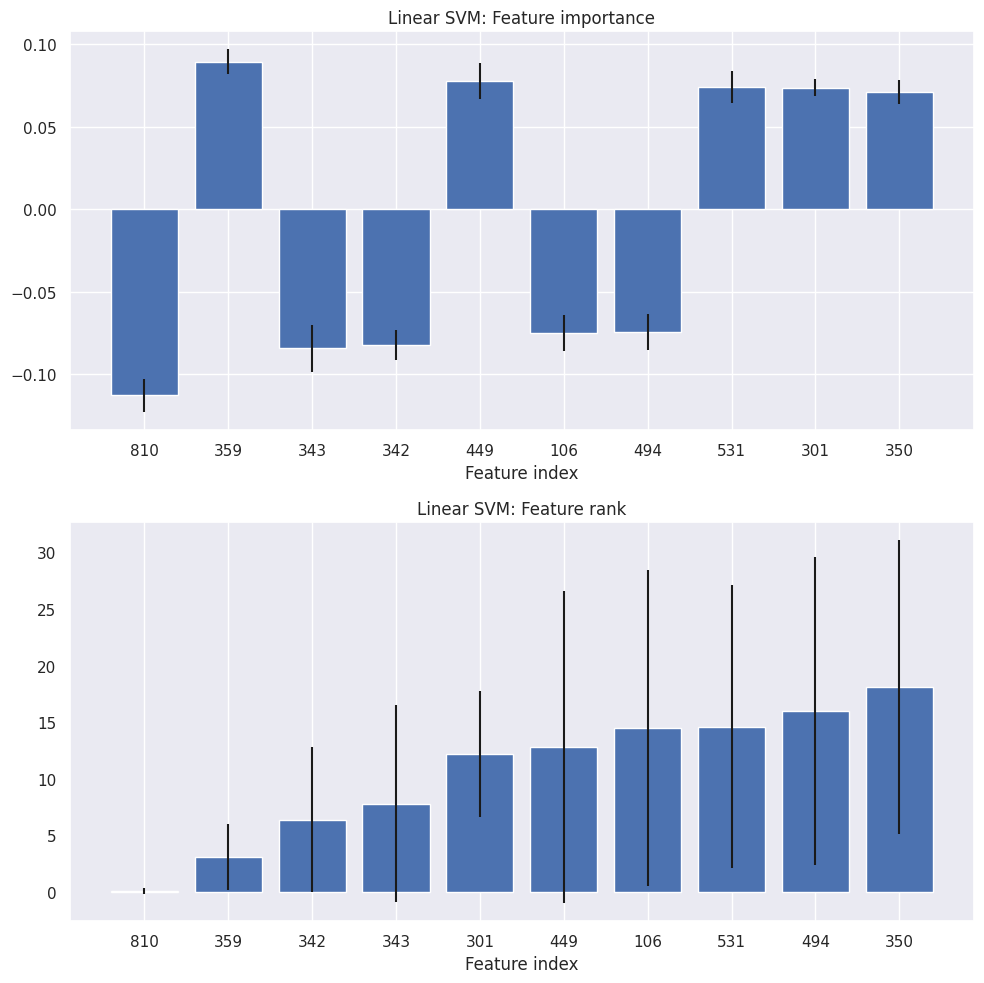

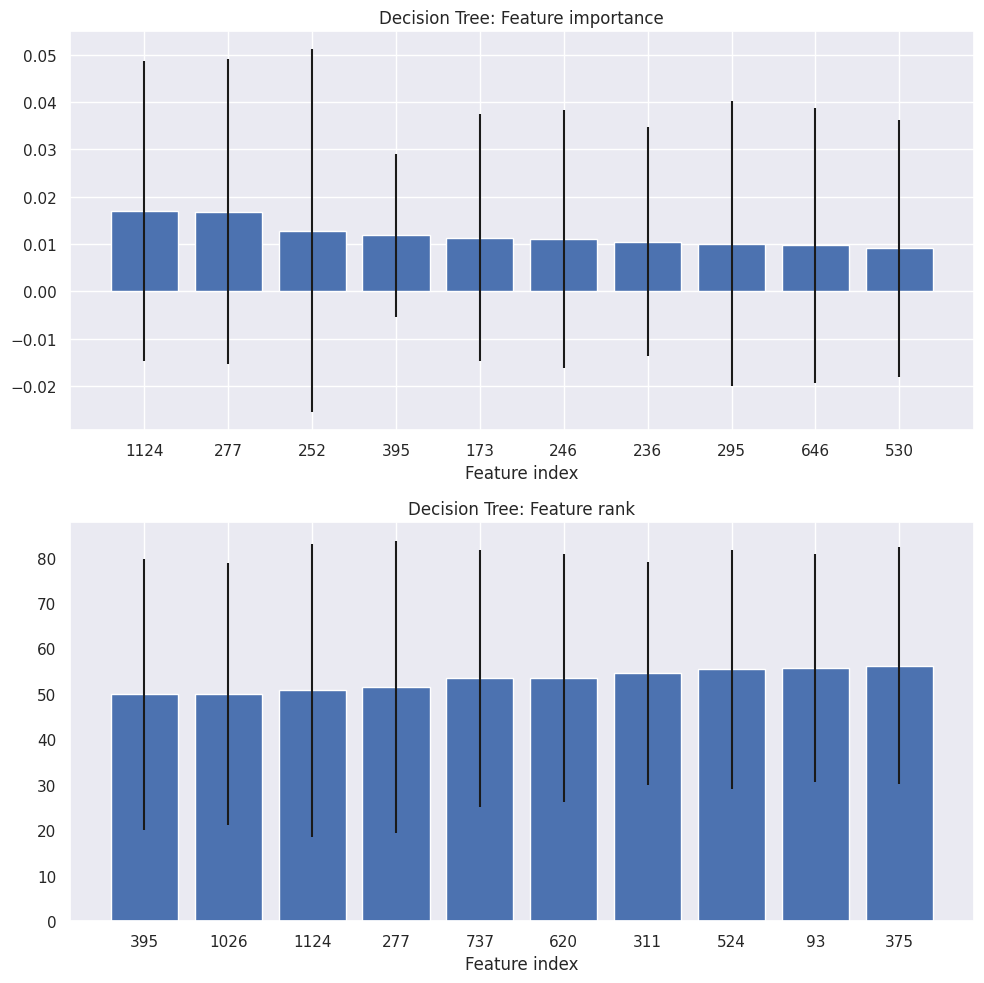

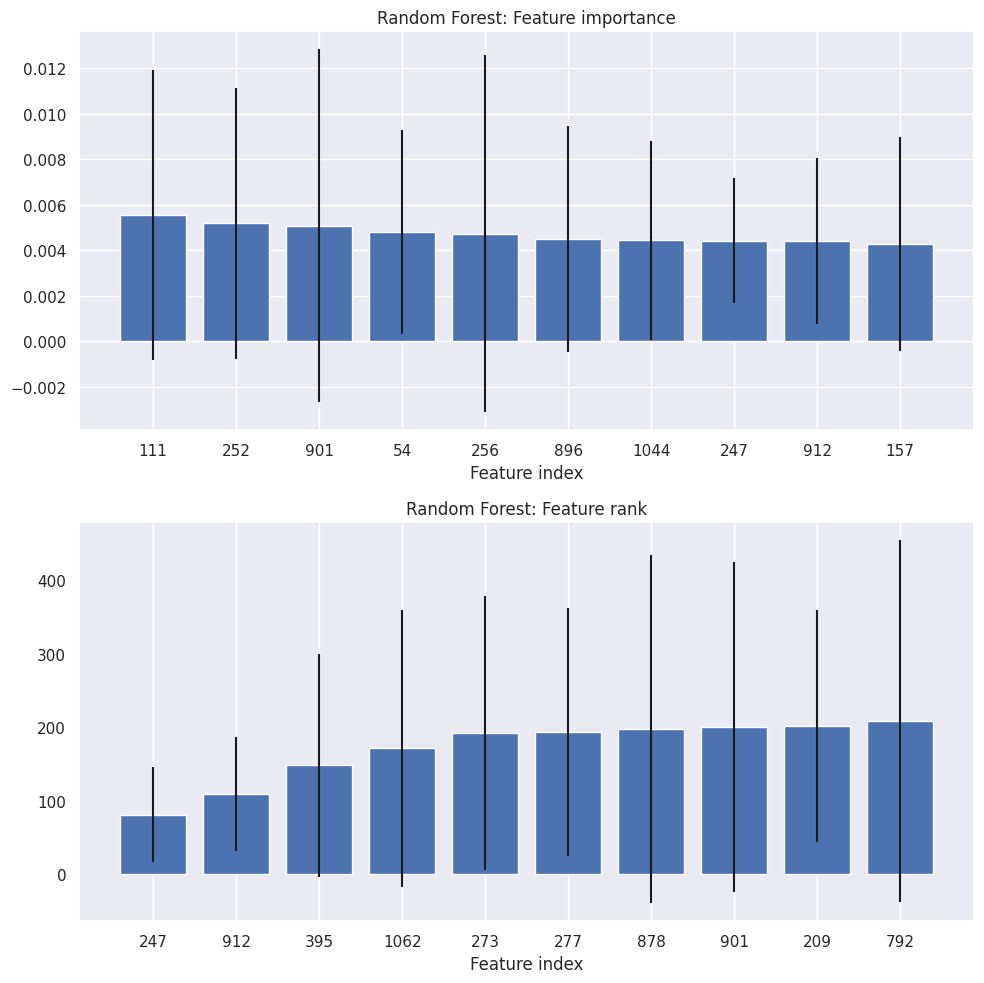

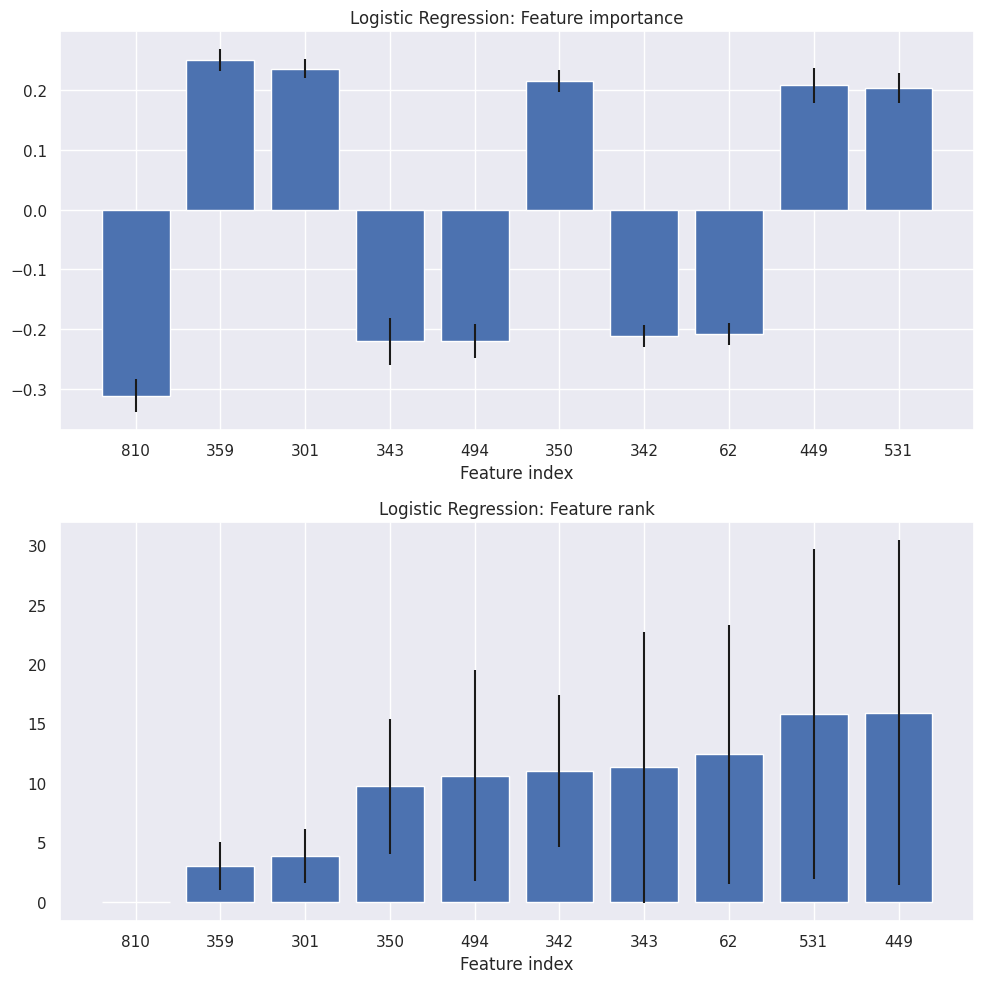

In [13]:
run_polyssifier.plot_features(ntop=10)

## REST2_RL

In [14]:
bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_ses-{rest_name}_seed-{seed_name}__voxelcorrelations.nii.gz"
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)
rest = "REST2RL"
data = {}

for seed in SEEDS:
    for sub in tqdm(df_boot["subject_label"]):
        img_path = img_tpl.format(seed_name=seed, participant_id=sub, rest_name = rest)
        data[(sub, seed)] = img4d2vector(img_path, masker)

100%|█████████████████████████████████████████| 570/570 [02:33<00:00,  3.71it/s]


In [15]:
run_polyssifier = run_poly(df_boot, data, ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])

2024-02-28 12:26:38,860 - polyssifier - INFO - Detected 2 classes in label
2024-02-28 12:26:38,860 - polyssifier - INFO - Building classifiers ...
2024-02-28 12:26:38,865 - polyssifier - INFO - Initialization, done.
2024-02-28 12:26:38,893 - polyssifier - INFO - Training Multilayer Perceptron 0
2024-02-28 12:26:41,534 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.84, 2.64 sec
2024-02-28 12:26:41,544 - polyssifier - INFO - Training Multilayer Perceptron 1
2024-02-28 12:26:44,070 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.77, 2.53 sec
2024-02-28 12:26:44,078 - polyssifier - INFO - Training Multilayer Perceptron 2
2024-02-28 12:26:46,574 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.86, 2.50 sec
2024-02-28 12:26:46,586 - polyssifier - INFO - Training Multilayer Perceptron 3
2024-02-28 12:26:49,480 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.90, 2.89 sec
2024-02-28 12:26:49,489 - polyss

predict proba return shape (57,)


2024-02-28 12:27:57,114 - polyssifier - INFO - Linear SVM                 1: Train 1.00/Test 0.82, 7.11 sec
2024-02-28 12:27:57,123 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2024-02-28 12:28:04,278 - polyssifier - INFO - Linear SVM                 2: Train 1.00/Test 0.86, 7.16 sec
2024-02-28 12:28:04,286 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2024-02-28 12:28:10,600 - polyssifier - INFO - Linear SVM                 3: Train 1.00/Test 0.87, 6.31 sec
2024-02-28 12:28:10,609 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2024-02-28 12:28:17,023 - polyssifier - INFO - Linear SVM                 4: Train 1.00/Test 0.83, 6.41 sec
2024-02-28 12:28:17,030 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2024-02-28 12:28:24,942 - polyssifier - INFO - Linear SVM                 5: Train 1.00/Test 0.89, 7.91 sec
2024-02-28 12:28:24,949 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2024-02-28 12:28:30,623 - polyssifier - INFO - Linear SVM                 6: Train 1.00/Test 0.82, 5.67 sec
2024-02-28 12:28:30,630 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2024-02-28 12:28:37,439 - polyssifier - INFO - Linear SVM                 7: Train 1.00/Test 0.87, 6.81 sec
2024-02-28 12:28:37,447 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2024-02-28 12:28:44,425 - polyssifier - INFO - Linear SVM                 8: Train 1.00/Test 0.92, 6.98 sec
2024-02-28 12:28:44,433 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2024-02-28 12:28:51,243 - polyssifier - INFO - Linear SVM                 9: Train 1.00/Test 0.86, 6.81 sec
2024-02-28 12:28:51,251 - polyssifier - INFO - Training Decision Tree 0
2024-02-28 12:28:51,296 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.59, 0.04 sec
2024-02-28 12:28:51,304 - polyssifier - INFO - Training Decision Tree 1
2024-02-28 12:28:51,334 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.51, 0.03 sec
2024-02-28 12:28:51,339 - polyssifier - INFO - Training Decision Tree 2
2024-02-28 12:28:51,364 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.56, 0.02 sec
2024-02-28 12:28:51,370 - polyssifier - INFO - Training Decision Tree 3
2024-02-28 12:28:51,397 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.63, 0.03 sec
2024-02-28 12:28:51,404 - polyssifier - INFO - Training Decision Tree 4
2024-02-28 12:28:51,430 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.45, 0

predict proba return shape (57,)


2024-02-28 12:28:51,462 - polyssifier - INFO - Decision Tree              5: Train 1.00/Test 0.64, 0.03 sec
2024-02-28 12:28:51,468 - polyssifier - INFO - Training Decision Tree 6
2024-02-28 12:28:51,494 - polyssifier - INFO - Decision Tree              6: Train 1.00/Test 0.69, 0.03 sec
2024-02-28 12:28:51,500 - polyssifier - INFO - Training Decision Tree 7
2024-02-28 12:28:51,527 - polyssifier - INFO - Decision Tree              7: Train 1.00/Test 0.50, 0.03 sec
2024-02-28 12:28:51,533 - polyssifier - INFO - Training Decision Tree 8
2024-02-28 12:28:51,561 - polyssifier - INFO - Decision Tree              8: Train 1.00/Test 0.43, 0.03 sec
2024-02-28 12:28:51,568 - polyssifier - INFO - Training Decision Tree 9
2024-02-28 12:28:51,593 - polyssifier - INFO - Decision Tree              9: Train 1.00/Test 0.63, 0.03 sec
2024-02-28 12:28:51,600 - polyssifier - INFO - Training Random Forest 0
2024-02-28 12:28:54,521 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.66, 2

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.823262  0.055207  0.728288  0.904938
Nearest Neighbors     train  0.741642  0.011705  0.727871  0.768131
                      test   0.673424  0.072552  0.558313  0.790323
SVM                   train  0.978249  0.001886  0.974851  0.981402
                      test   0.786674  0.048798  0.709877  0.856079
Linear SVM            train  1.000000  0.000000  1.000000  1.000000
                      test   0.868000  0.037097  0.817618  0.924691
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.563936  0.085847  0.434243  0.687965
Random Forest         train  0.999821  0.000437  0.998594  1.000000
                      test   0.678275  0.060389  0.607407  0.770988
Logistic Regression   train  1.000000  0.000000  1.000000  1.000000
                      test   0.867883  0.039248 

2024-02-28 12:30:30,218 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2024-02-28 12:30:30,570 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2024-02-28 12:30:30,866 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2024-02-28 12:30:31,156 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


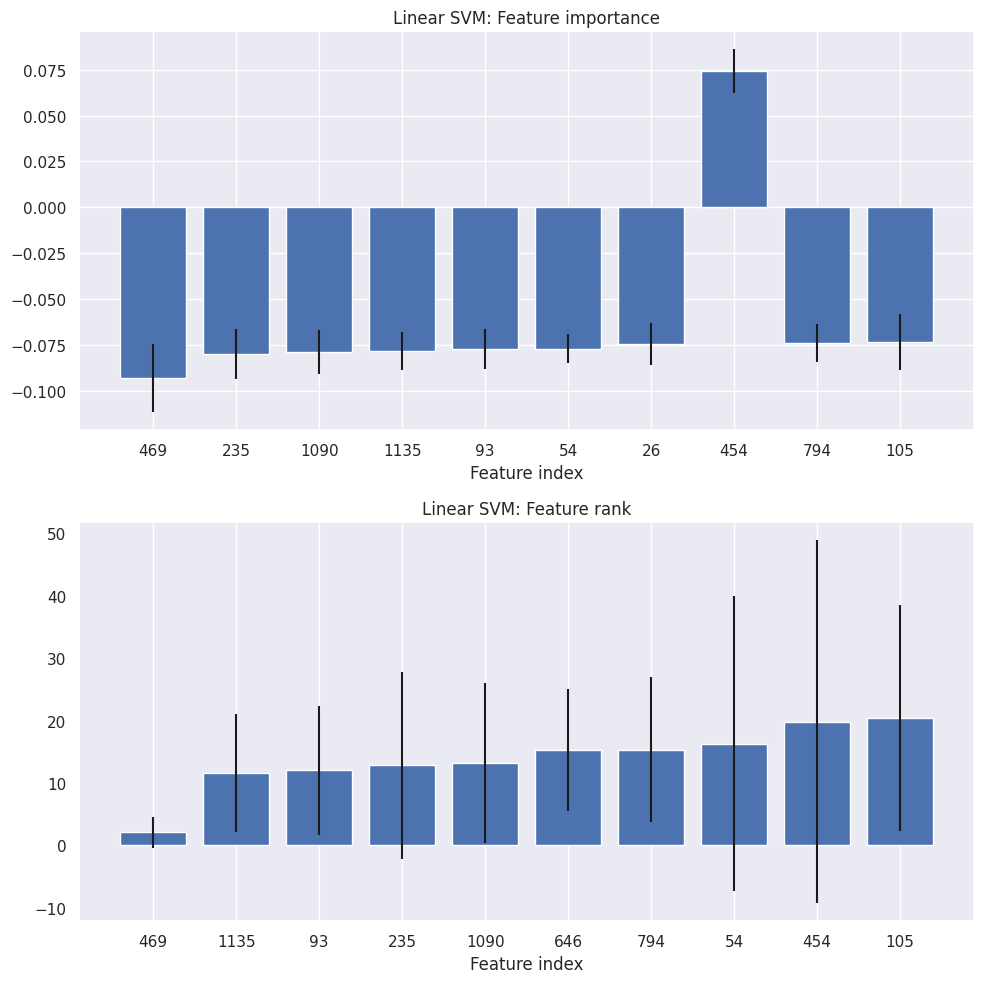

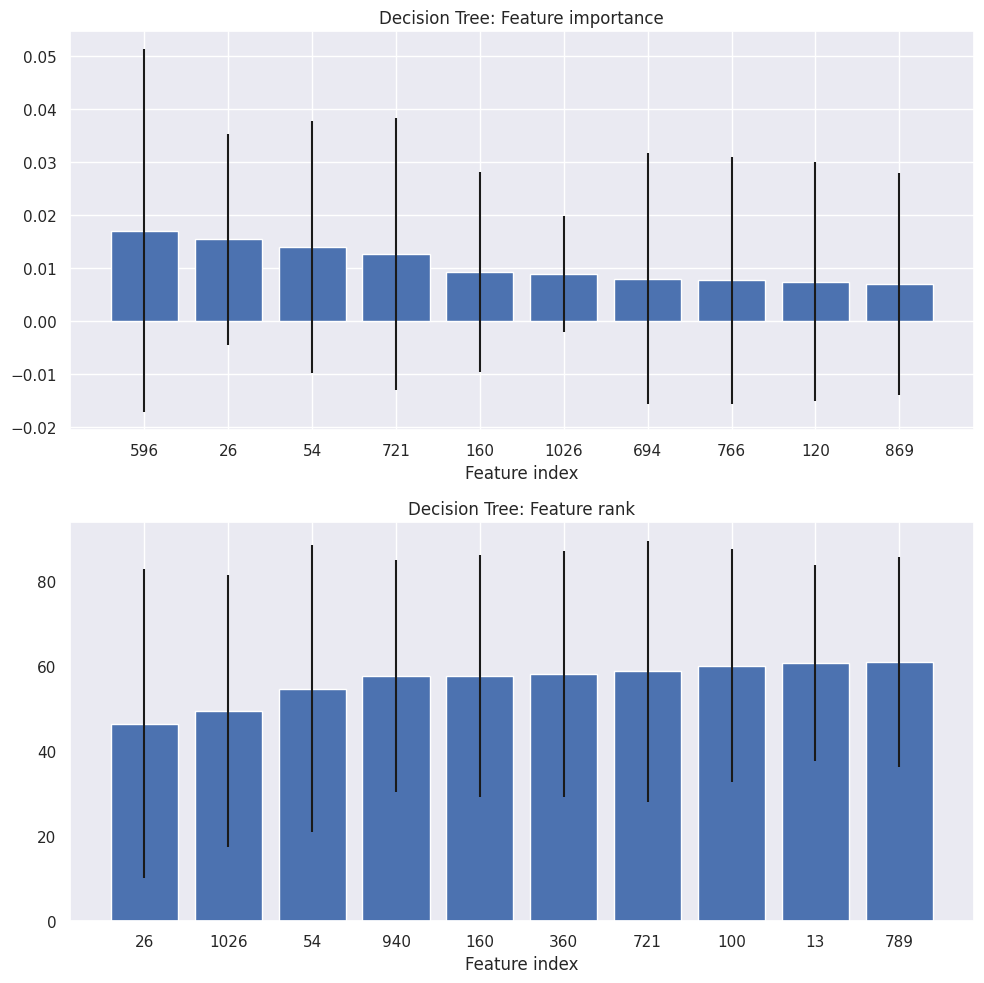

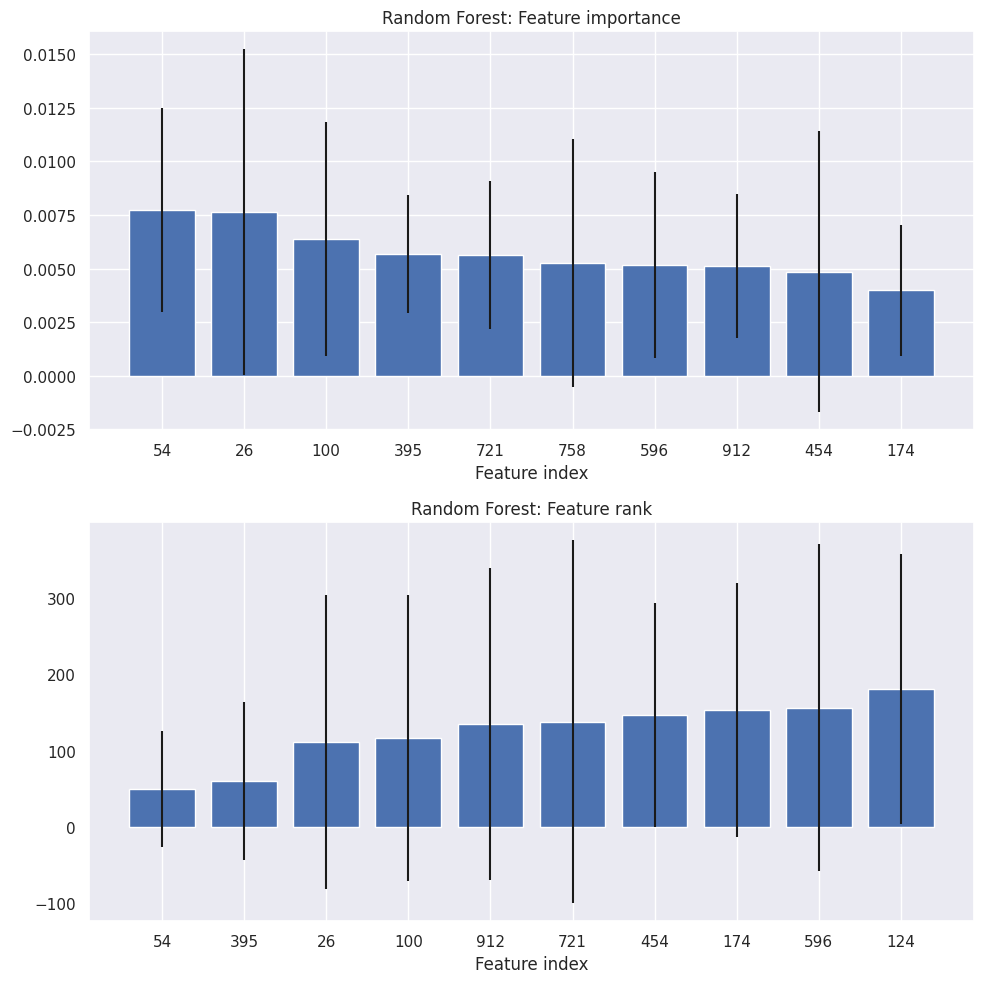

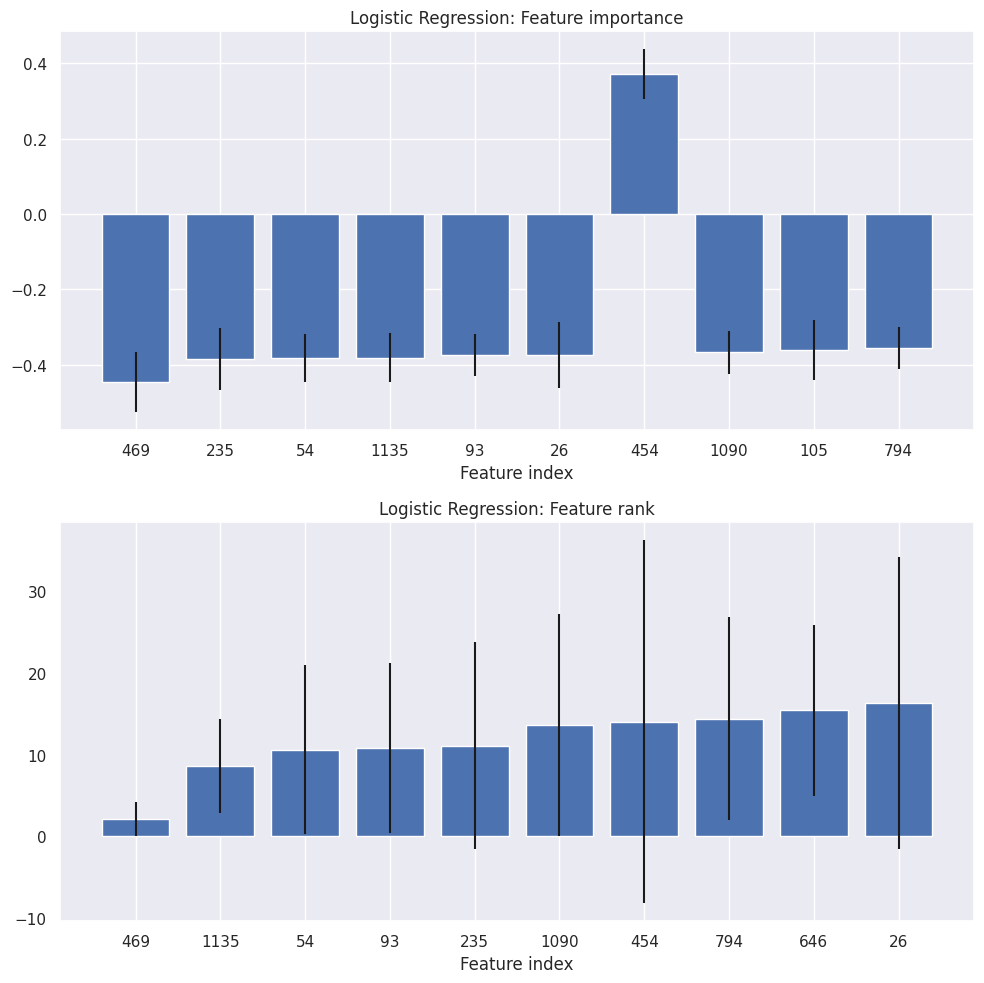

In [16]:
run_polyssifier.plot_features(ntop=10)

# Average 2 scans 

## Average scan 2 + 4

In [24]:
bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_ses-{rest_name}_seed-{seed_name}__voxelcorrelations.nii.gz"
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)
data = {}

for seed in SEEDS:
    for sub in tqdm(df_boot["subject_label"]):
        img_path_2 = img_tpl.format(seed_name=seed, participant_id=sub, rest_name = "REST1RL")
        img_path_4 = img_tpl.format(seed_name=seed, participant_id=sub, rest_name = "REST2RL")
        mean_image = image.mean_img([img_path_1, img_path_2])
        data[(sub, seed)] = img4d2vector(mean_image, masker)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 570/570 [04:57<00:00,  1.92it/s]


In [25]:
run_polyssifier = run_poly(df_boot, data, ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])

2024-02-22 11:14:28,588 - polyssifier - INFO - Detected 2 classes in label
2024-02-22 11:14:28,588 - polyssifier - INFO - Building classifiers ...
2024-02-22 11:14:28,593 - polyssifier - INFO - Initialization, done.
2024-02-22 11:14:28,622 - polyssifier - INFO - Training Multilayer Perceptron 0
2024-02-22 11:14:31,837 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.83, 3.21 sec
2024-02-22 11:14:31,846 - polyssifier - INFO - Training Multilayer Perceptron 1
2024-02-22 11:14:34,312 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.82, 2.47 sec
2024-02-22 11:14:34,321 - polyssifier - INFO - Training Multilayer Perceptron 2
2024-02-22 11:14:36,711 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.90, 2.39 sec
2024-02-22 11:14:36,730 - polyssifier - INFO - Training Multilayer Perceptron 3
2024-02-22 11:14:39,259 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.88, 2.53 sec
2024-02-22 11:14:39,268 - polyss

predict proba return shape (57,)


2024-02-22 11:15:38,791 - polyssifier - INFO - Linear SVM                 1: Train 1.00/Test 0.85, 5.25 sec
2024-02-22 11:15:38,799 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2024-02-22 11:15:43,719 - polyssifier - INFO - Linear SVM                 2: Train 1.00/Test 0.90, 4.92 sec
2024-02-22 11:15:43,727 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2024-02-22 11:15:48,003 - polyssifier - INFO - Linear SVM                 3: Train 1.00/Test 0.87, 4.28 sec
2024-02-22 11:15:48,011 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2024-02-22 11:15:51,718 - polyssifier - INFO - Linear SVM                 4: Train 1.00/Test 0.89, 3.71 sec
2024-02-22 11:15:51,726 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2024-02-22 11:15:57,356 - polyssifier - INFO - Linear SVM                 5: Train 1.00/Test 0.93, 5.63 sec
2024-02-22 11:15:57,364 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2024-02-22 11:16:01,897 - polyssifier - INFO - Linear SVM                 6: Train 1.00/Test 0.86, 4.53 sec
2024-02-22 11:16:01,905 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2024-02-22 11:16:06,810 - polyssifier - INFO - Linear SVM                 7: Train 1.00/Test 0.89, 4.91 sec
2024-02-22 11:16:06,818 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2024-02-22 11:16:11,253 - polyssifier - INFO - Linear SVM                 8: Train 1.00/Test 0.91, 4.44 sec
2024-02-22 11:16:11,259 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2024-02-22 11:16:15,920 - polyssifier - INFO - Linear SVM                 9: Train 1.00/Test 0.93, 4.66 sec
2024-02-22 11:16:15,928 - polyssifier - INFO - Training Decision Tree 0
2024-02-22 11:16:15,972 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.65, 0.04 sec
2024-02-22 11:16:15,981 - polyssifier - INFO - Training Decision Tree 1
2024-02-22 11:16:16,007 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.51, 0.03 sec
2024-02-22 11:16:16,013 - polyssifier - INFO - Training Decision Tree 2
2024-02-22 11:16:16,037 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.55, 0.02 sec
2024-02-22 11:16:16,044 - polyssifier - INFO - Training Decision Tree 3
2024-02-22 11:16:16,070 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.51, 0.03 sec
2024-02-22 11:16:16,076 - polyssifier - INFO - Training Decision Tree 4
2024-02-22 11:16:16,103 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.56, 0

predict proba return shape (57,)


2024-02-22 11:16:16,134 - polyssifier - INFO - Decision Tree              5: Train 1.00/Test 0.57, 0.02 sec
2024-02-22 11:16:16,140 - polyssifier - INFO - Training Decision Tree 6
2024-02-22 11:16:16,165 - polyssifier - INFO - Decision Tree              6: Train 1.00/Test 0.54, 0.03 sec
2024-02-22 11:16:16,171 - polyssifier - INFO - Training Decision Tree 7
2024-02-22 11:16:16,197 - polyssifier - INFO - Decision Tree              7: Train 1.00/Test 0.55, 0.03 sec
2024-02-22 11:16:16,203 - polyssifier - INFO - Training Decision Tree 8
2024-02-22 11:16:16,228 - polyssifier - INFO - Decision Tree              8: Train 1.00/Test 0.53, 0.02 sec
2024-02-22 11:16:16,234 - polyssifier - INFO - Training Decision Tree 9
2024-02-22 11:16:16,260 - polyssifier - INFO - Decision Tree              9: Train 1.00/Test 0.61, 0.03 sec
2024-02-22 11:16:16,266 - polyssifier - INFO - Training Random Forest 0
2024-02-22 11:16:18,957 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.75, 2

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.867654  0.031339  0.816049  0.903226
Nearest Neighbors     train  0.780823  0.006098  0.771413  0.789702
                      test   0.727962  0.065201  0.617866  0.798387
SVM                   train  0.984984  0.001617  0.982659  0.987296
                      test   0.834154  0.045244  0.742593  0.885856
Linear SVM            train  1.000000  0.000000  1.000000  1.000000
                      test   0.893290  0.027576  0.854321  0.931762
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.555914  0.043504  0.507407  0.646296
Random Forest         train  0.999588  0.000932  0.996998  0.999992
                      test   0.728180  0.059165  0.634615  0.805556
Logistic Regression   train  1.000000  0.000000  1.000000  1.000000
                      test   0.895397  0.031873 

2024-02-28 13:06:38,433 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2024-02-28 13:06:38,736 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2024-02-28 13:06:39,015 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2024-02-28 13:06:39,301 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


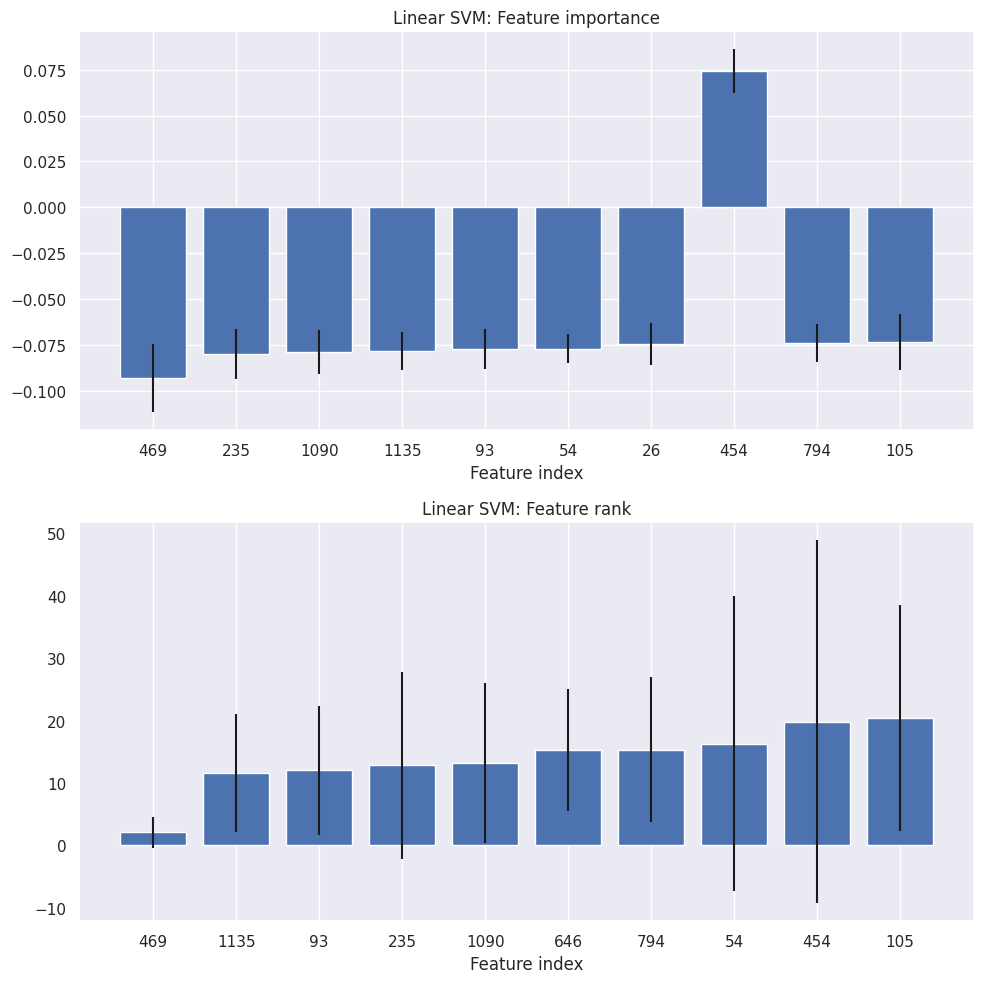

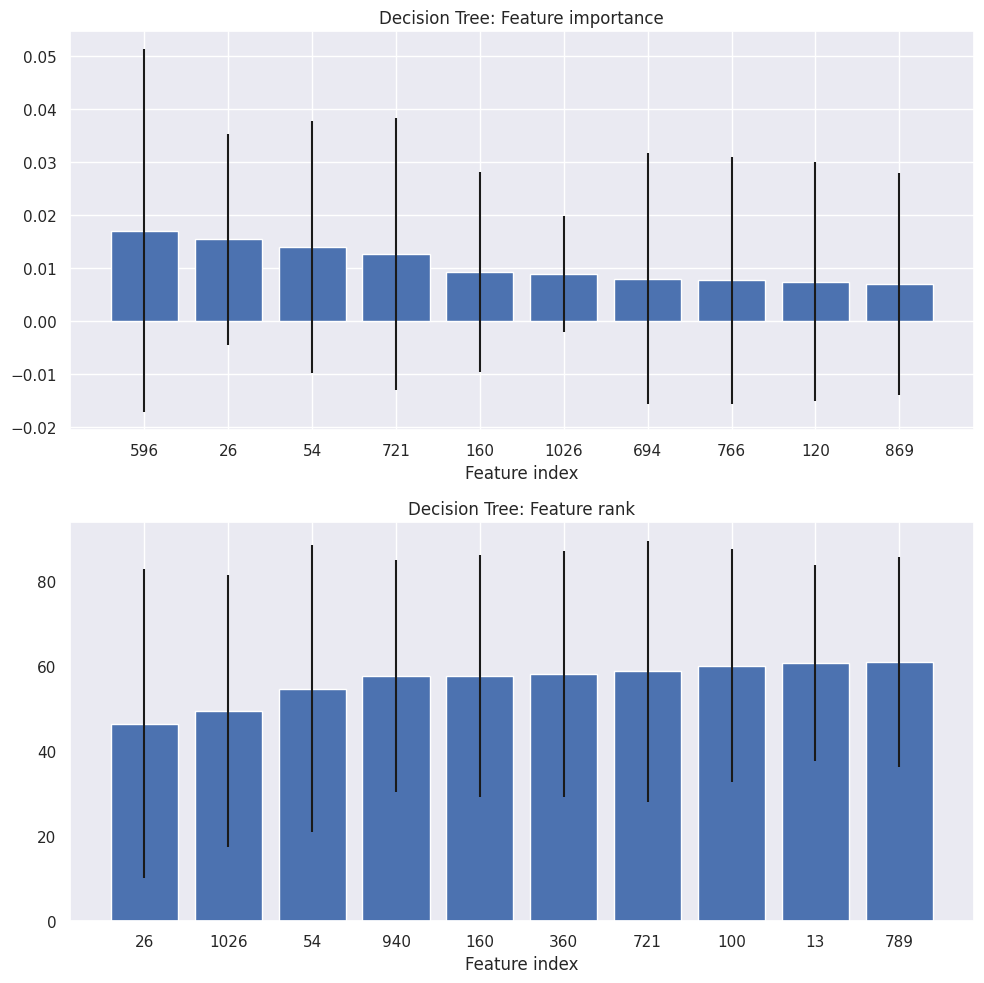

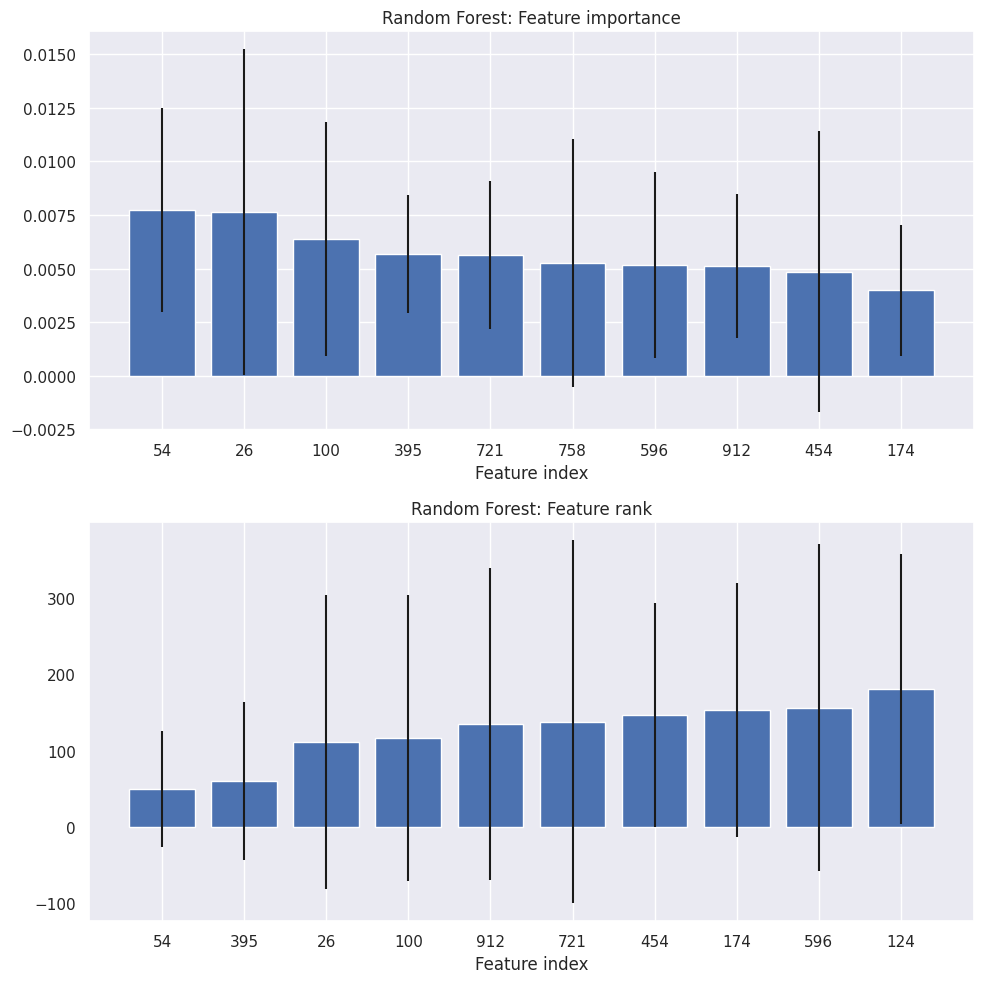

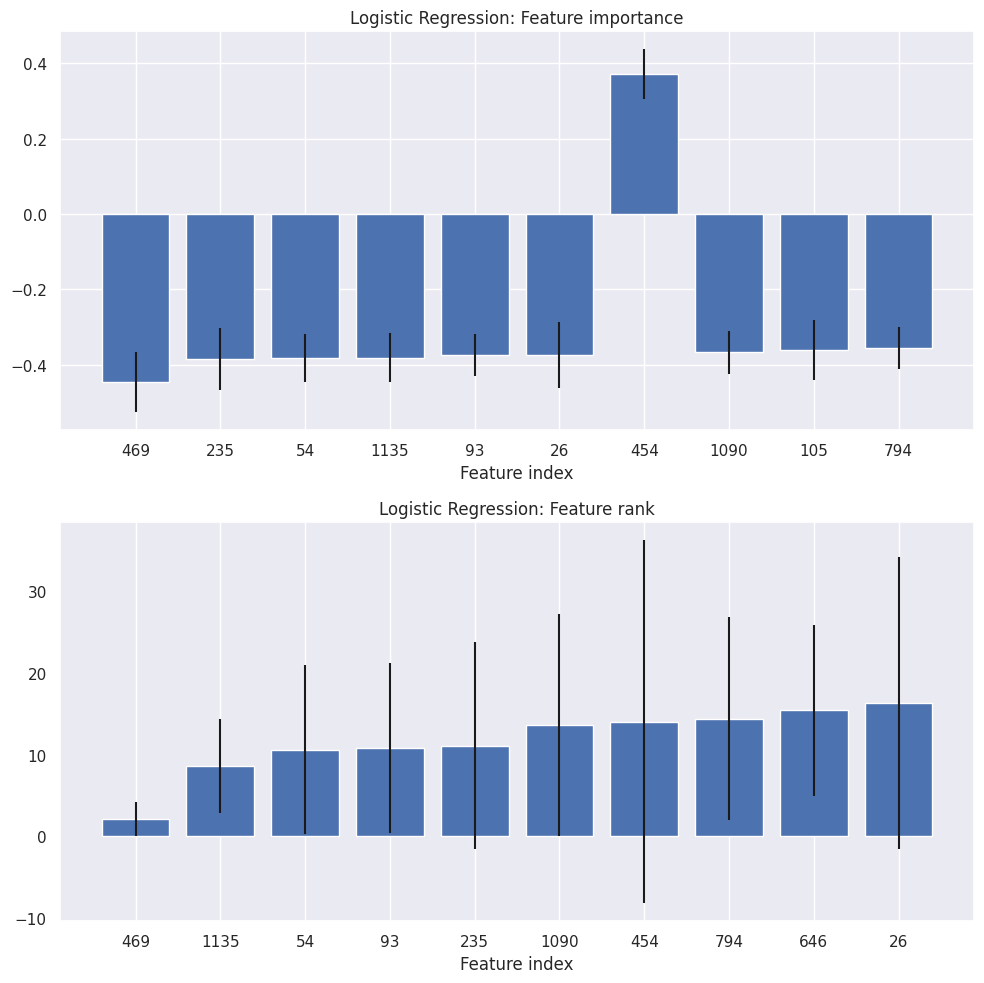

In [18]:
run_polyssifier.plot_features(ntop=10)

## average 1+2 

In [17]:
bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_ses-{rest_name}_seed-{seed_name}__voxelcorrelations.nii.gz"
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)
data = {}

for seed in SEEDS:
    for sub in tqdm(df_boot["subject_label"]):
        img_path_1 = img_tpl.format(seed_name=seed, participant_id=sub, rest_name = "REST1LR")
        img_path_2 = img_tpl.format(seed_name=seed, participant_id=sub, rest_name = "REST1RL")
        mean_image = image.mean_img([img_path_1, img_path_2])
        data[(sub, seed)] = img4d2vector(mean_image, masker)

100%|█████████████████████████████████████████| 570/570 [03:49<00:00,  2.48it/s]


In [19]:
run_polyssifier = run_poly(df_boot, data, ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])

2024-02-28 13:06:59,060 - polyssifier - INFO - Detected 2 classes in label
2024-02-28 13:06:59,061 - polyssifier - INFO - Building classifiers ...
2024-02-28 13:06:59,066 - polyssifier - INFO - Initialization, done.
2024-02-28 13:06:59,098 - polyssifier - INFO - Training Multilayer Perceptron 0
2024-02-28 13:07:02,199 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.84, 3.10 sec
2024-02-28 13:07:02,207 - polyssifier - INFO - Training Multilayer Perceptron 1
2024-02-28 13:07:04,787 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.81, 2.58 sec
2024-02-28 13:07:04,795 - polyssifier - INFO - Training Multilayer Perceptron 2
2024-02-28 13:07:07,183 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.93, 2.39 sec
2024-02-28 13:07:07,192 - polyssifier - INFO - Training Multilayer Perceptron 3
2024-02-28 13:07:09,625 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.85, 2.43 sec
2024-02-28 13:07:09,634 - polyss

predict proba return shape (57,)


2024-02-28 13:08:09,295 - polyssifier - INFO - Linear SVM                 1: Train 1.00/Test 0.81, 4.21 sec
2024-02-28 13:08:09,303 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2024-02-28 13:08:12,867 - polyssifier - INFO - Linear SVM                 2: Train 1.00/Test 0.93, 3.56 sec
2024-02-28 13:08:12,875 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2024-02-28 13:08:16,997 - polyssifier - INFO - Linear SVM                 3: Train 1.00/Test 0.86, 4.12 sec
2024-02-28 13:08:17,005 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2024-02-28 13:08:20,952 - polyssifier - INFO - Linear SVM                 4: Train 1.00/Test 0.91, 3.95 sec
2024-02-28 13:08:20,959 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2024-02-28 13:08:24,943 - polyssifier - INFO - Linear SVM                 5: Train 1.00/Test 0.89, 3.98 sec
2024-02-28 13:08:24,952 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2024-02-28 13:08:28,828 - polyssifier - INFO - Linear SVM                 6: Train 1.00/Test 0.88, 3.88 sec
2024-02-28 13:08:28,837 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2024-02-28 13:08:33,366 - polyssifier - INFO - Linear SVM                 7: Train 1.00/Test 0.93, 4.53 sec
2024-02-28 13:08:33,375 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2024-02-28 13:08:37,398 - polyssifier - INFO - Linear SVM                 8: Train 1.00/Test 0.94, 4.02 sec
2024-02-28 13:08:37,406 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2024-02-28 13:08:41,642 - polyssifier - INFO - Linear SVM                 9: Train 1.00/Test 0.98, 4.24 sec
2024-02-28 13:08:41,649 - polyssifier - INFO - Training Decision Tree 0
2024-02-28 13:08:41,688 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.55, 0.04 sec
2024-02-28 13:08:41,696 - polyssifier - INFO - Training Decision Tree 1
2024-02-28 13:08:41,727 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.61, 0.03 sec
2024-02-28 13:08:41,734 - polyssifier - INFO - Training Decision Tree 2
2024-02-28 13:08:41,762 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.55, 0.03 sec
2024-02-28 13:08:41,768 - polyssifier - INFO - Training Decision Tree 3
2024-02-28 13:08:41,793 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.55, 0.02 sec
2024-02-28 13:08:41,799 - polyssifier - INFO - Training Decision Tree 4
2024-02-28 13:08:41,826 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.50, 0

predict proba return shape (57,)


2024-02-28 13:08:41,861 - polyssifier - INFO - Decision Tree              5: Train 1.00/Test 0.55, 0.03 sec
2024-02-28 13:08:41,867 - polyssifier - INFO - Training Decision Tree 6
2024-02-28 13:08:41,893 - polyssifier - INFO - Decision Tree              6: Train 1.00/Test 0.60, 0.03 sec
2024-02-28 13:08:41,899 - polyssifier - INFO - Training Decision Tree 7
2024-02-28 13:08:41,925 - polyssifier - INFO - Decision Tree              7: Train 1.00/Test 0.66, 0.03 sec
2024-02-28 13:08:41,931 - polyssifier - INFO - Training Decision Tree 8
2024-02-28 13:08:41,957 - polyssifier - INFO - Decision Tree              8: Train 1.00/Test 0.54, 0.03 sec
2024-02-28 13:08:41,963 - polyssifier - INFO - Training Decision Tree 9
2024-02-28 13:08:41,988 - polyssifier - INFO - Decision Tree              9: Train 1.00/Test 0.54, 0.02 sec
2024-02-28 13:08:41,993 - polyssifier - INFO - Training Random Forest 0
2024-02-28 13:08:44,655 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.69, 2

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.873856  0.038654  0.807407  0.939206
Nearest Neighbors     train  0.792917  0.006761  0.783606  0.806035
                      test   0.729173  0.036130  0.667901  0.791563
SVM                   train  0.984543  0.001895  0.982338  0.988854
                      test   0.846940  0.038356  0.765432  0.887097
Linear SVM            train  1.000000  0.000000  1.000000  1.000000
                      test   0.900376  0.046566  0.811111  0.975186
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.565256  0.045809  0.504963  0.662531
Random Forest         train  0.999940  0.000097  0.999679  1.000000
                      test   0.726190  0.038676  0.662963  0.784119
Logistic Regression   train  1.000000  0.000000  1.000000  1.000000
                      test   0.903597  0.047470 

2024-02-28 13:09:22,067 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2024-02-28 13:09:22,374 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2024-02-28 13:09:22,733 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2024-02-28 13:09:23,009 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


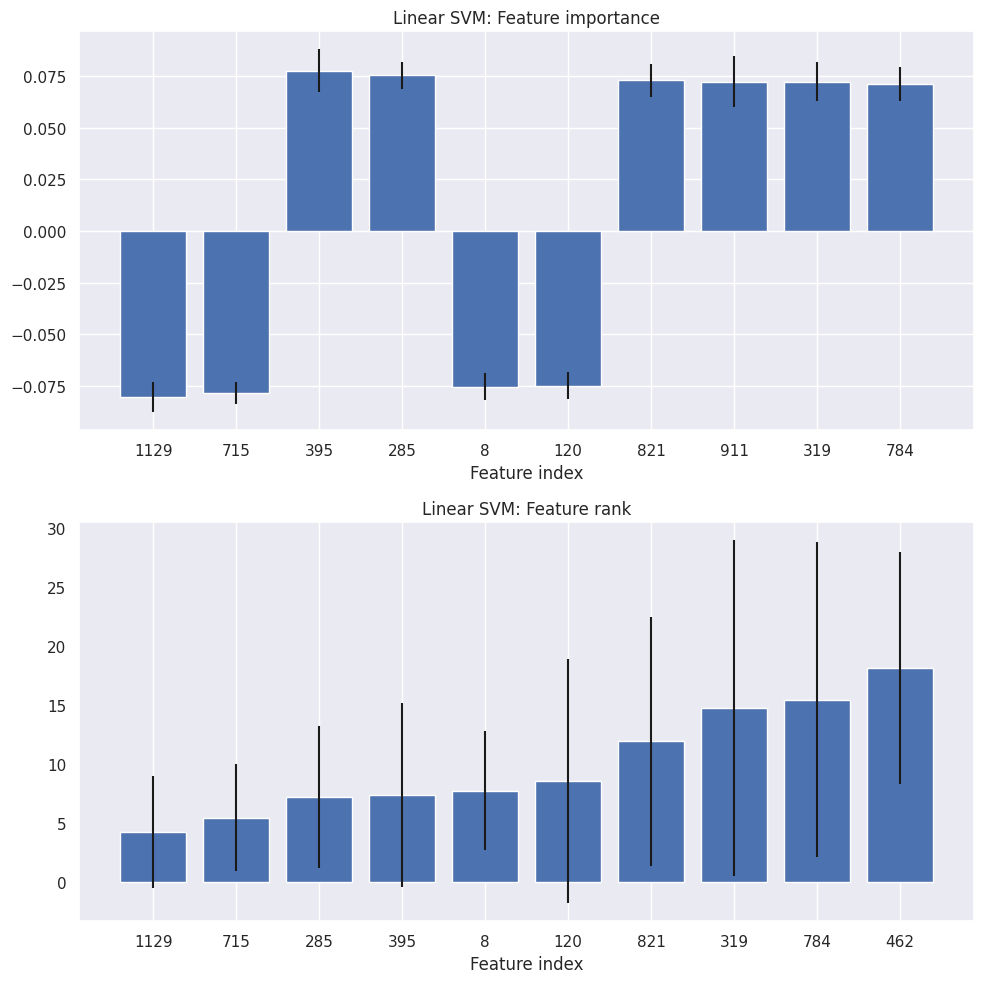

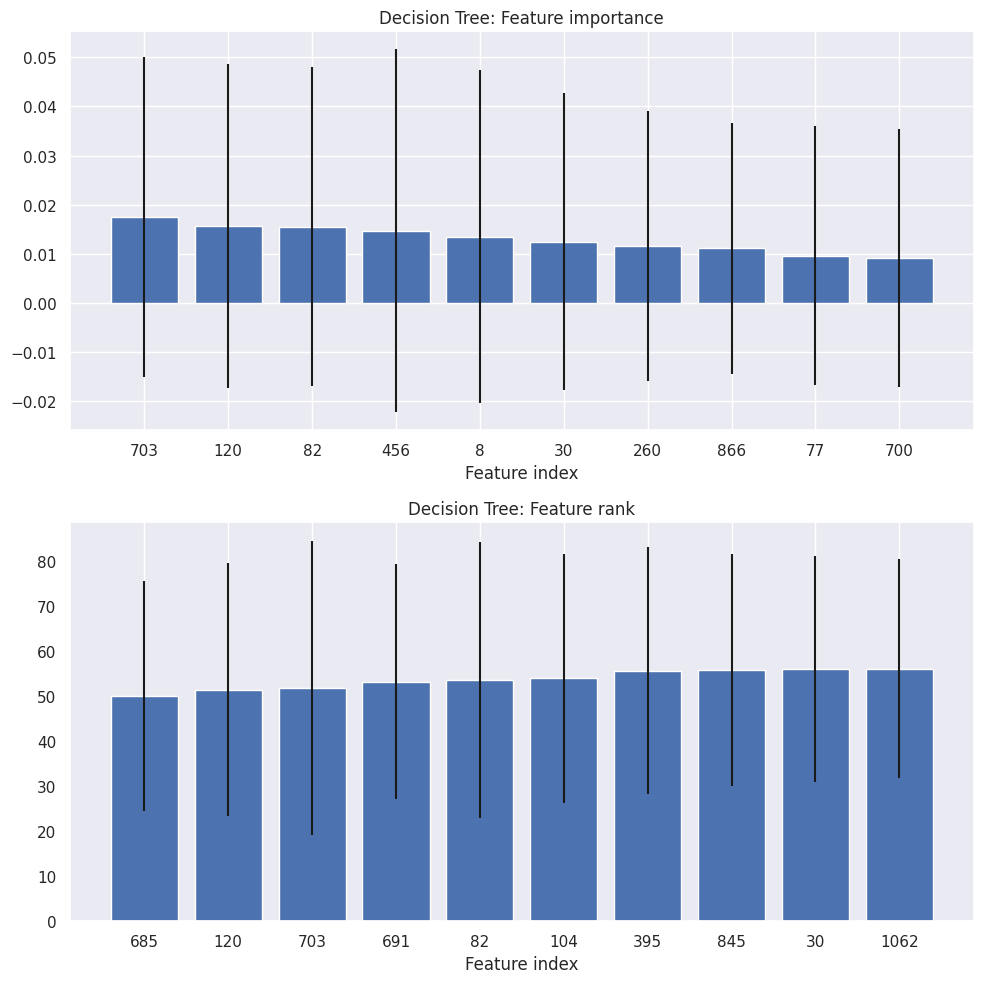

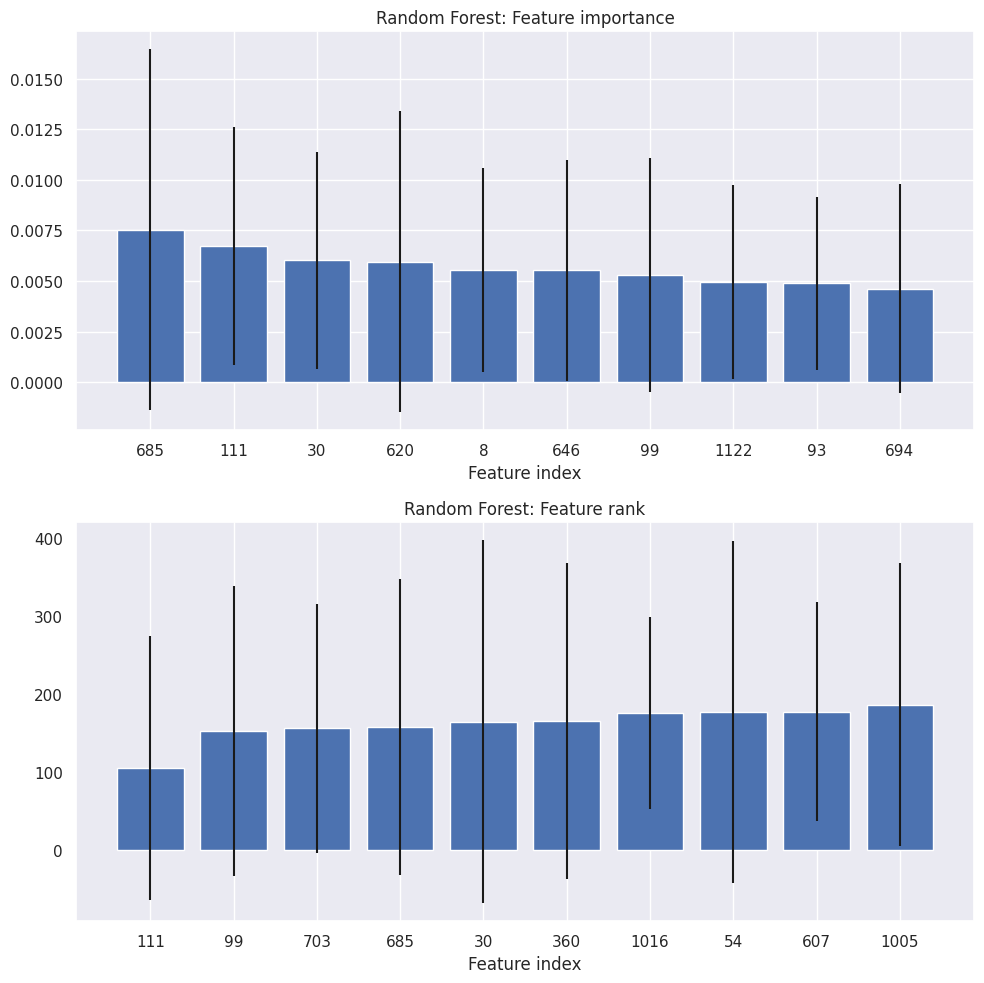

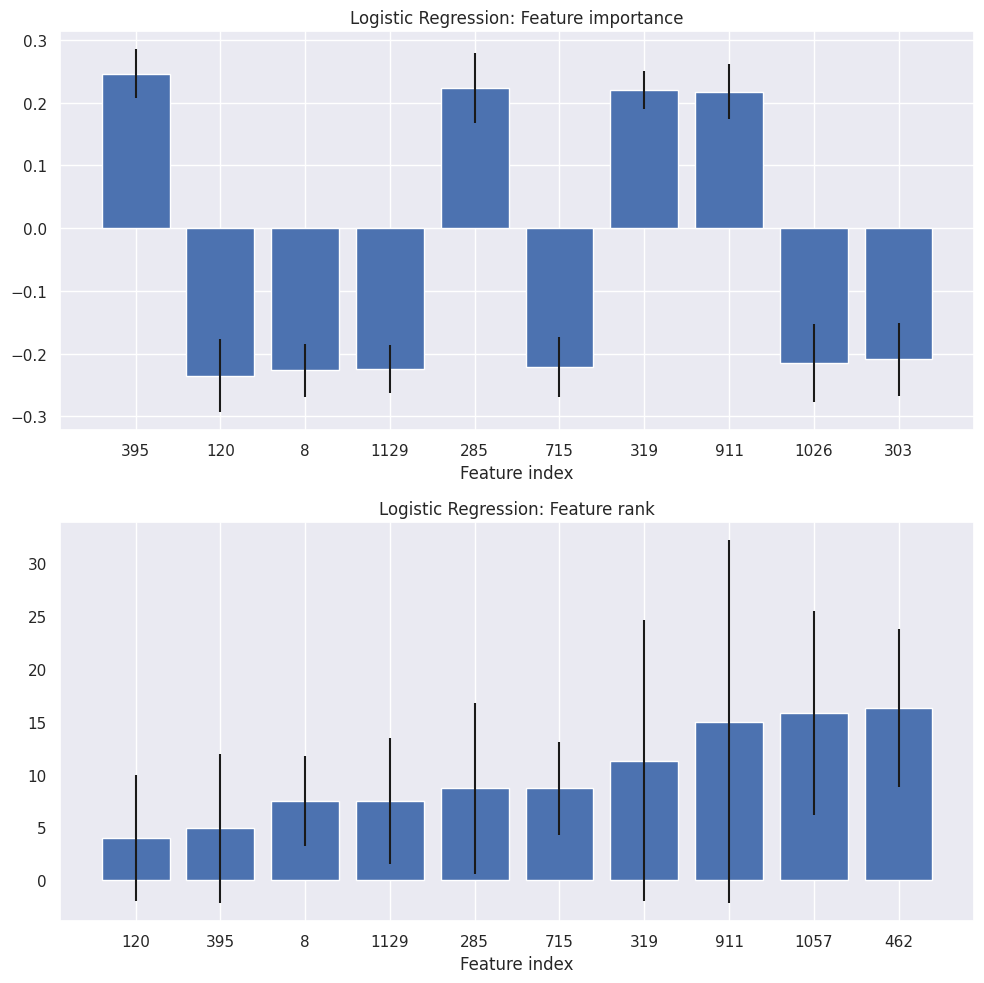

In [20]:
run_polyssifier.plot_features(ntop=10)

## Average 1 +3 

In [10]:
bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_ses-{rest_name}_seed-{seed_name}__voxelcorrelations.nii.gz"
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)
data = {}

for seed in SEEDS:
    for sub in tqdm(df_boot["subject_label"]):
        img_path_1 = img_tpl.format(seed_name=seed, participant_id=sub, rest_name = "REST1LR")
        img_path_3 = img_tpl.format(seed_name=seed, participant_id=sub, rest_name = "REST2LR")
        mean_image = image.mean_img([img_path_1, img_path_3])
        data[(sub, seed)] = img4d2vector(mean_image, masker)

100%|█████████████████████████████████████████| 570/570 [04:07<00:00,  2.31it/s]


In [11]:
run_polyssifier = run_poly(df_boot, data, ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])

2024-02-23 09:10:25,506 - polyssifier - INFO - Detected 2 classes in label
2024-02-23 09:10:25,509 - polyssifier - INFO - Building classifiers ...
2024-02-23 09:10:25,513 - polyssifier - INFO - Initialization, done.
2024-02-23 09:10:25,538 - polyssifier - INFO - Training Multilayer Perceptron 0
2024-02-23 09:10:28,052 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.88, 2.51 sec
2024-02-23 09:10:28,062 - polyssifier - INFO - Training Multilayer Perceptron 1
2024-02-23 09:10:30,569 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.89, 2.51 sec
2024-02-23 09:10:30,577 - polyssifier - INFO - Training Multilayer Perceptron 2
2024-02-23 09:10:33,021 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.89, 2.44 sec
2024-02-23 09:10:33,028 - polyssifier - INFO - Training Multilayer Perceptron 3
2024-02-23 09:10:35,400 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.91, 2.37 sec
2024-02-23 09:10:35,406 - polyss

predict proba return shape (57,)


2024-02-23 09:11:31,586 - polyssifier - INFO - Linear SVM                 1: Train 1.00/Test 0.87, 3.97 sec
2024-02-23 09:11:31,594 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2024-02-23 09:11:35,339 - polyssifier - INFO - Linear SVM                 2: Train 1.00/Test 0.91, 3.74 sec
2024-02-23 09:11:35,347 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2024-02-23 09:11:39,601 - polyssifier - INFO - Linear SVM                 3: Train 1.00/Test 0.89, 4.25 sec
2024-02-23 09:11:39,609 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2024-02-23 09:11:43,226 - polyssifier - INFO - Linear SVM                 4: Train 1.00/Test 0.88, 3.62 sec
2024-02-23 09:11:43,234 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2024-02-23 09:11:47,561 - polyssifier - INFO - Linear SVM                 5: Train 1.00/Test 0.90, 4.33 sec
2024-02-23 09:11:47,567 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2024-02-23 09:11:51,282 - polyssifier - INFO - Linear SVM                 6: Train 1.00/Test 0.88, 3.72 sec
2024-02-23 09:11:51,290 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2024-02-23 09:11:55,127 - polyssifier - INFO - Linear SVM                 7: Train 1.00/Test 0.93, 3.84 sec
2024-02-23 09:11:55,135 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2024-02-23 09:11:59,214 - polyssifier - INFO - Linear SVM                 8: Train 1.00/Test 0.95, 4.08 sec
2024-02-23 09:11:59,221 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2024-02-23 09:12:03,156 - polyssifier - INFO - Linear SVM                 9: Train 1.00/Test 0.95, 3.93 sec
2024-02-23 09:12:03,164 - polyssifier - INFO - Training Decision Tree 0
2024-02-23 09:12:03,207 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.56, 0.04 sec
2024-02-23 09:12:03,220 - polyssifier - INFO - Training Decision Tree 1
2024-02-23 09:12:03,245 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.57, 0.03 sec
2024-02-23 09:12:03,252 - polyssifier - INFO - Training Decision Tree 2
2024-02-23 09:12:03,277 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.60, 0.02 sec
2024-02-23 09:12:03,283 - polyssifier - INFO - Training Decision Tree 3
2024-02-23 09:12:03,309 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.58, 0.03 sec
2024-02-23 09:12:03,315 - polyssifier - INFO - Training Decision Tree 4
2024-02-23 09:12:03,341 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.67, 0

predict proba return shape (57,)


2024-02-23 09:12:03,374 - polyssifier - INFO - Decision Tree              5: Train 1.00/Test 0.50, 0.03 sec
2024-02-23 09:12:03,380 - polyssifier - INFO - Training Decision Tree 6
2024-02-23 09:12:03,406 - polyssifier - INFO - Decision Tree              6: Train 1.00/Test 0.70, 0.03 sec
2024-02-23 09:12:03,412 - polyssifier - INFO - Training Decision Tree 7
2024-02-23 09:12:03,437 - polyssifier - INFO - Decision Tree              7: Train 1.00/Test 0.69, 0.03 sec
2024-02-23 09:12:03,442 - polyssifier - INFO - Training Decision Tree 8
2024-02-23 09:12:03,469 - polyssifier - INFO - Decision Tree              8: Train 1.00/Test 0.64, 0.03 sec
2024-02-23 09:12:03,475 - polyssifier - INFO - Training Decision Tree 9
2024-02-23 09:12:03,501 - polyssifier - INFO - Decision Tree              9: Train 1.00/Test 0.68, 0.03 sec
2024-02-23 09:12:03,507 - polyssifier - INFO - Training Random Forest 0
2024-02-23 09:12:06,175 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.63, 2

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.895870  0.026495  0.859801  0.939206
Nearest Neighbors     train  0.826400  0.026026  0.789167  0.889183
                      test   0.745288  0.072411  0.599256  0.837037
SVM                   train  0.991127  0.001077  0.988984  0.992819
                      test   0.864179  0.027612  0.823457  0.908189
Linear SVM            train  1.000000  0.000000  1.000000  1.000000
                      test   0.907651  0.030111  0.865432  0.952854
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.618336  0.065731  0.504963  0.697891
Random Forest         train  0.999926  0.000102  0.999710  1.000000
                      test   0.743713  0.061139  0.630247  0.841358
Logistic Regression   train  1.000000  0.000000  1.000000  1.000000
                      test   0.917300  0.026388 

2024-02-23 09:46:37,610 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2024-02-23 09:46:38,398 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2024-02-23 09:46:38,686 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2024-02-23 09:46:38,995 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


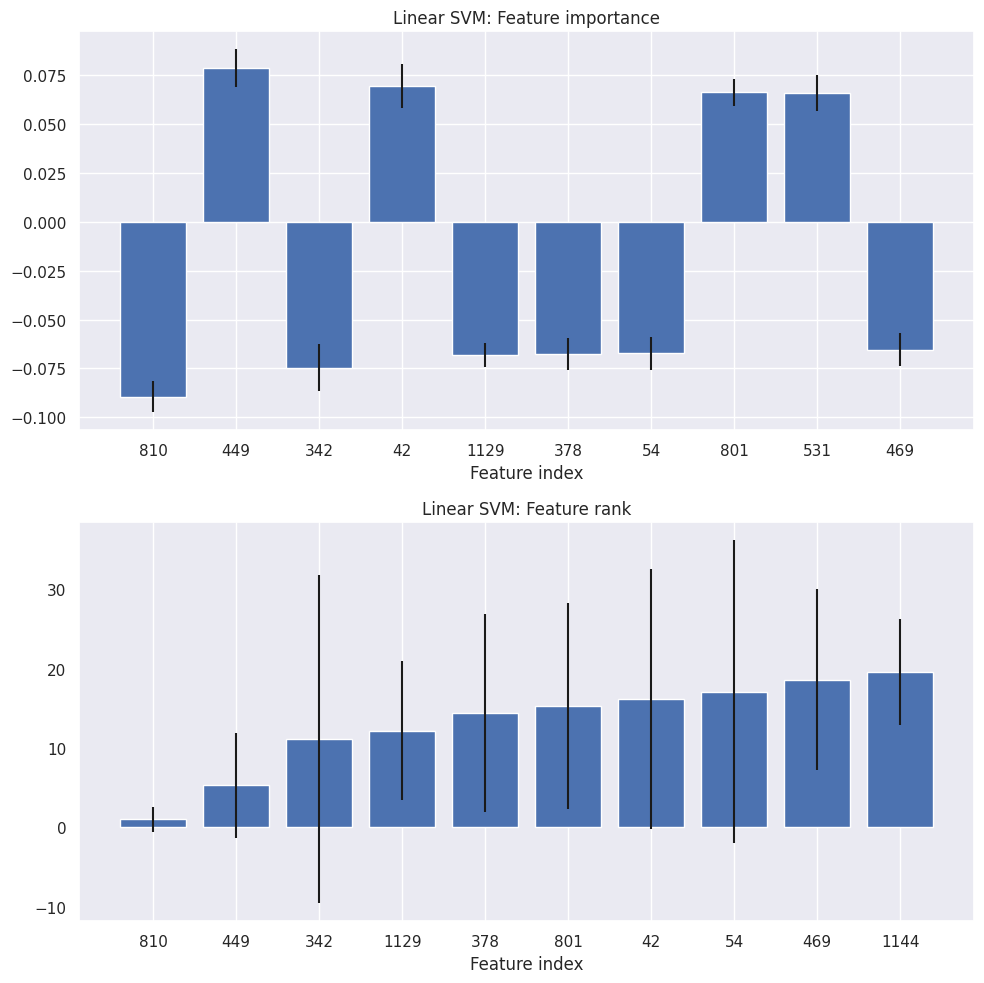

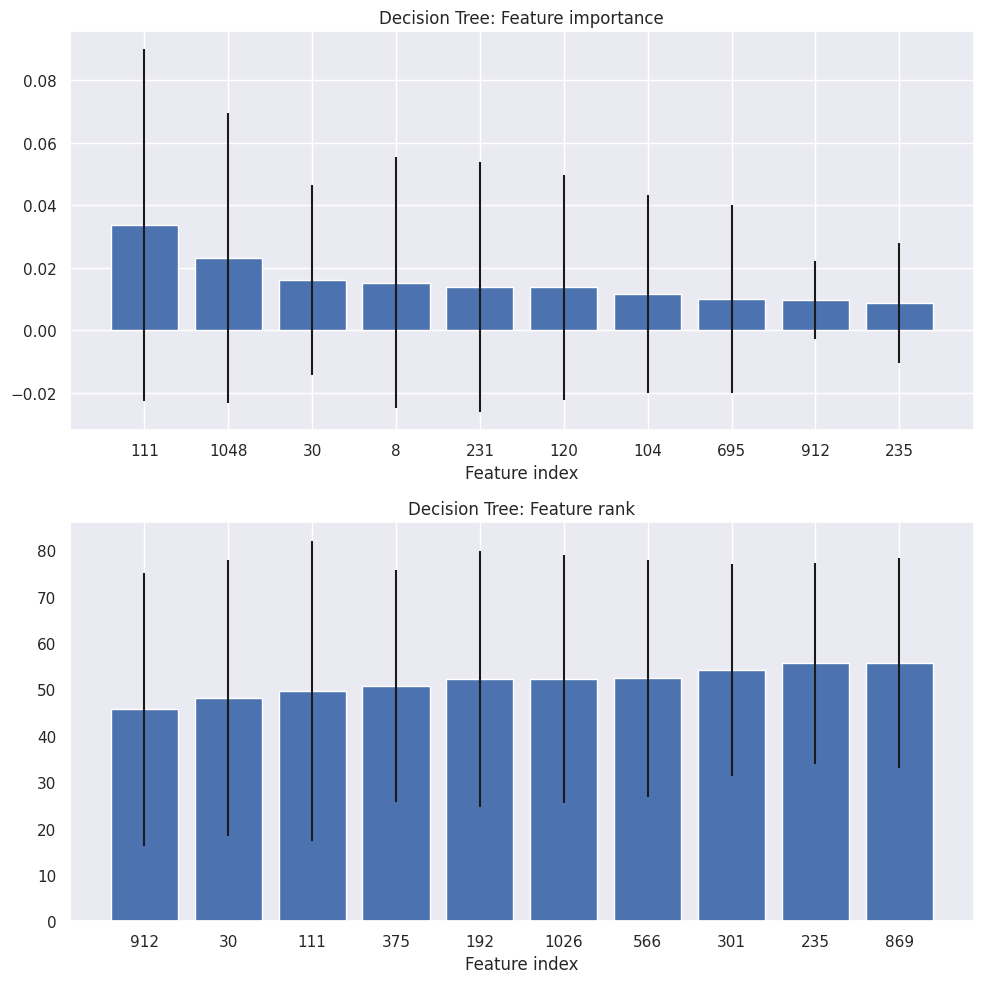

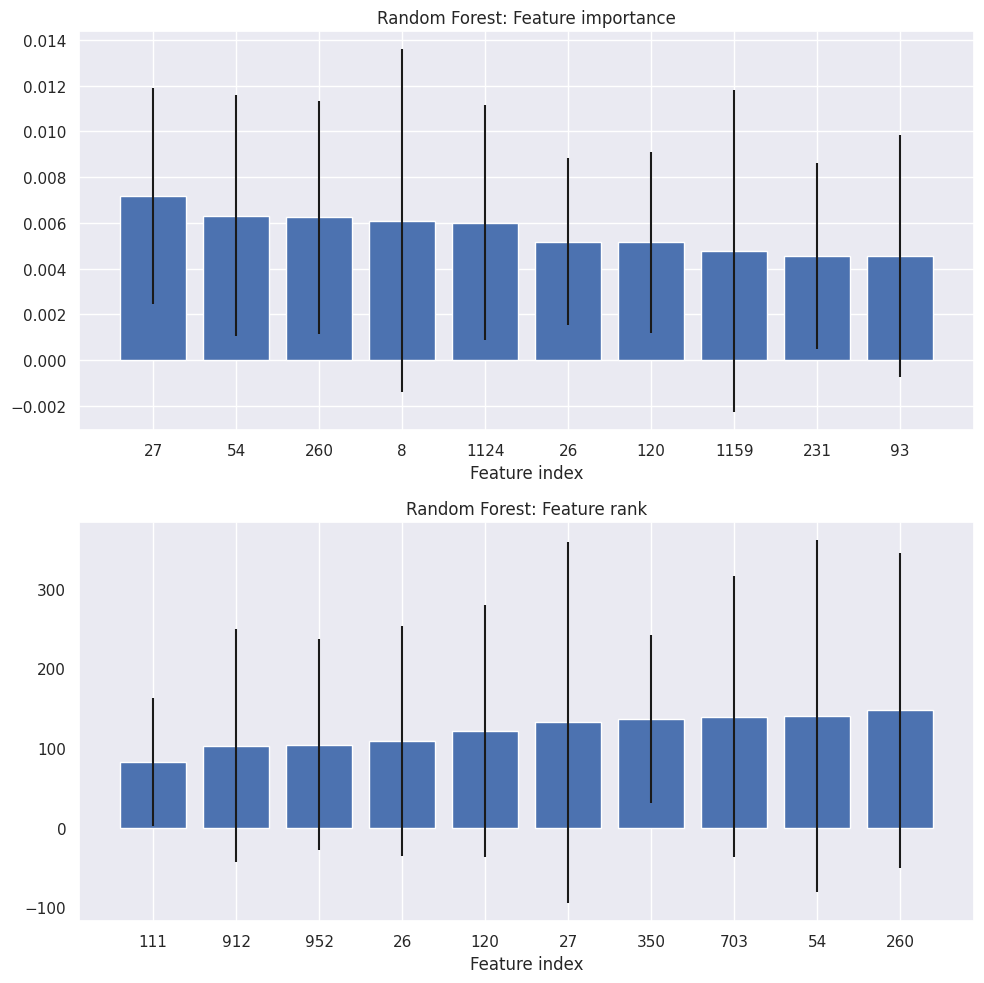

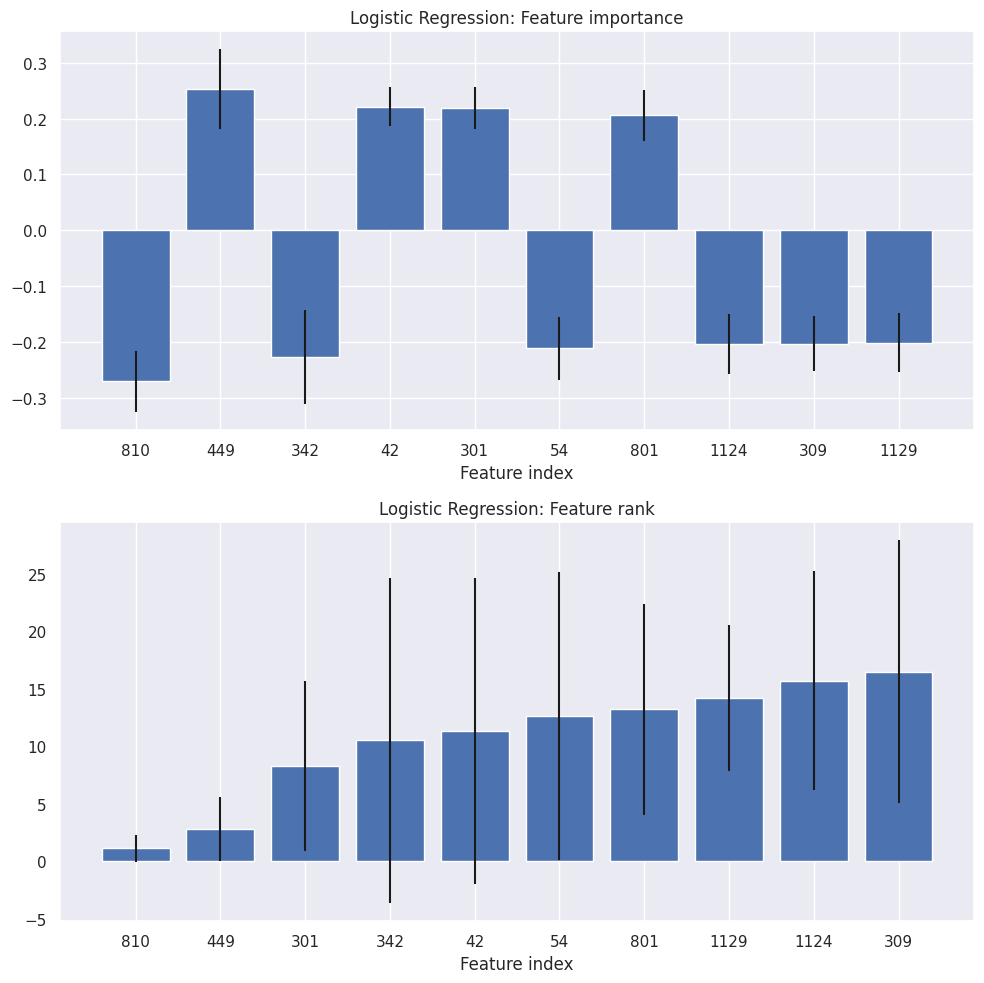

In [13]:
run_polyssifier.plot_features(ntop=10)

## average 1 +  4

In [12]:
bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_ses-{rest_name}_seed-{seed_name}__voxelcorrelations.nii.gz"
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)
data = {}

for seed in SEEDS:
    for sub in tqdm(df_boot["subject_label"]):
        img_path_1 = img_tpl.format(seed_name=seed, participant_id=sub, rest_name = "REST1LR")
        img_path_4 = img_tpl.format(seed_name=seed, participant_id=sub, rest_name = "REST2RL")
        mean_image = image.mean_img([img_path_1, img_path_4])
        data[(sub, seed)] = img4d2vector(mean_image, masker)

100%|█████████████████████████████████████████| 570/570 [03:23<00:00,  2.80it/s]


In [16]:
run_polyssifier = run_poly(df_boot, data, ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])

2024-02-23 09:59:51,733 - polyssifier - INFO - Detected 2 classes in label
2024-02-23 09:59:51,734 - polyssifier - INFO - Building classifiers ...
2024-02-23 09:59:51,738 - polyssifier - INFO - Initialization, done.
2024-02-23 09:59:51,766 - polyssifier - INFO - Training Multilayer Perceptron 0
2024-02-23 09:59:54,219 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.86, 2.45 sec
2024-02-23 09:59:54,231 - polyssifier - INFO - Training Multilayer Perceptron 1
2024-02-23 09:59:56,620 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.79, 2.39 sec
2024-02-23 09:59:56,629 - polyssifier - INFO - Training Multilayer Perceptron 2
2024-02-23 09:59:59,176 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.89, 2.55 sec
2024-02-23 09:59:59,182 - polyssifier - INFO - Training Multilayer Perceptron 3
2024-02-23 10:00:01,931 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.89, 2.75 sec
2024-02-23 10:00:01,942 - polyss

predict proba return shape (57,)


2024-02-23 10:00:59,884 - polyssifier - INFO - Linear SVM                 1: Train 1.00/Test 0.83, 4.69 sec
2024-02-23 10:00:59,892 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2024-02-23 10:01:04,530 - polyssifier - INFO - Linear SVM                 2: Train 1.00/Test 0.91, 4.64 sec
2024-02-23 10:01:04,539 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2024-02-23 10:01:09,254 - polyssifier - INFO - Linear SVM                 3: Train 1.00/Test 0.91, 4.72 sec
2024-02-23 10:01:09,262 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2024-02-23 10:01:13,448 - polyssifier - INFO - Linear SVM                 4: Train 1.00/Test 0.87, 4.19 sec
2024-02-23 10:01:13,456 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2024-02-23 10:01:18,254 - polyssifier - INFO - Linear SVM                 5: Train 1.00/Test 0.88, 4.80 sec
2024-02-23 10:01:18,262 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2024-02-23 10:01:22,470 - polyssifier - INFO - Linear SVM                 6: Train 1.00/Test 0.87, 4.21 sec
2024-02-23 10:01:22,478 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2024-02-23 10:01:27,136 - polyssifier - INFO - Linear SVM                 7: Train 1.00/Test 0.88, 4.66 sec
2024-02-23 10:01:27,143 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2024-02-23 10:01:31,478 - polyssifier - INFO - Linear SVM                 8: Train 1.00/Test 0.92, 4.34 sec
2024-02-23 10:01:31,486 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2024-02-23 10:01:35,798 - polyssifier - INFO - Linear SVM                 9: Train 1.00/Test 0.95, 4.31 sec
2024-02-23 10:01:35,806 - polyssifier - INFO - Training Decision Tree 0
2024-02-23 10:01:35,846 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.65, 0.04 sec
2024-02-23 10:01:35,856 - polyssifier - INFO - Training Decision Tree 1
2024-02-23 10:01:35,884 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.53, 0.03 sec
2024-02-23 10:01:35,890 - polyssifier - INFO - Training Decision Tree 2
2024-02-23 10:01:35,916 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.58, 0.03 sec
2024-02-23 10:01:35,922 - polyssifier - INFO - Training Decision Tree 3
2024-02-23 10:01:35,949 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.58, 0.03 sec
2024-02-23 10:01:35,955 - polyssifier - INFO - Training Decision Tree 4
2024-02-23 10:01:35,981 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.59, 0

predict proba return shape (57,)


2024-02-23 10:01:36,014 - polyssifier - INFO - Decision Tree              5: Train 1.00/Test 0.57, 0.03 sec
2024-02-23 10:01:36,019 - polyssifier - INFO - Training Decision Tree 6
2024-02-23 10:01:36,047 - polyssifier - INFO - Decision Tree              6: Train 1.00/Test 0.51, 0.03 sec
2024-02-23 10:01:36,053 - polyssifier - INFO - Training Decision Tree 7
2024-02-23 10:01:36,078 - polyssifier - INFO - Decision Tree              7: Train 1.00/Test 0.57, 0.03 sec
2024-02-23 10:01:36,084 - polyssifier - INFO - Training Decision Tree 8
2024-02-23 10:01:36,110 - polyssifier - INFO - Decision Tree              8: Train 1.00/Test 0.70, 0.03 sec
2024-02-23 10:01:36,115 - polyssifier - INFO - Training Decision Tree 9
2024-02-23 10:01:36,141 - polyssifier - INFO - Decision Tree              9: Train 1.00/Test 0.58, 0.03 sec
2024-02-23 10:01:36,146 - polyssifier - INFO - Training Random Forest 0
2024-02-23 10:01:38,788 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.64, 2

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.868272  0.040102  0.786420  0.919355
Nearest Neighbors     train  0.817168  0.038161  0.769740  0.867120
                      test   0.704415  0.064659  0.577160  0.776543
SVM                   train  0.993013  0.005985  0.982024  0.998930
                      test   0.809071  0.062611  0.674074  0.879012
Linear SVM            train  1.000000  0.000000  1.000000  1.000000
                      test   0.897965  0.037863  0.828395  0.949132
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.585563  0.055514  0.508065  0.700993
Random Forest         train  0.999791  0.000413  0.998694  1.000000
                      test   0.706297  0.060005  0.641975  0.816377
Logistic Regression   train  1.000000  0.000000  1.000000  1.000000
                      test   0.901927  0.034070 

2024-02-23 09:58:59,636 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2024-02-23 09:58:59,929 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2024-02-23 09:59:00,216 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2024-02-23 09:59:00,557 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


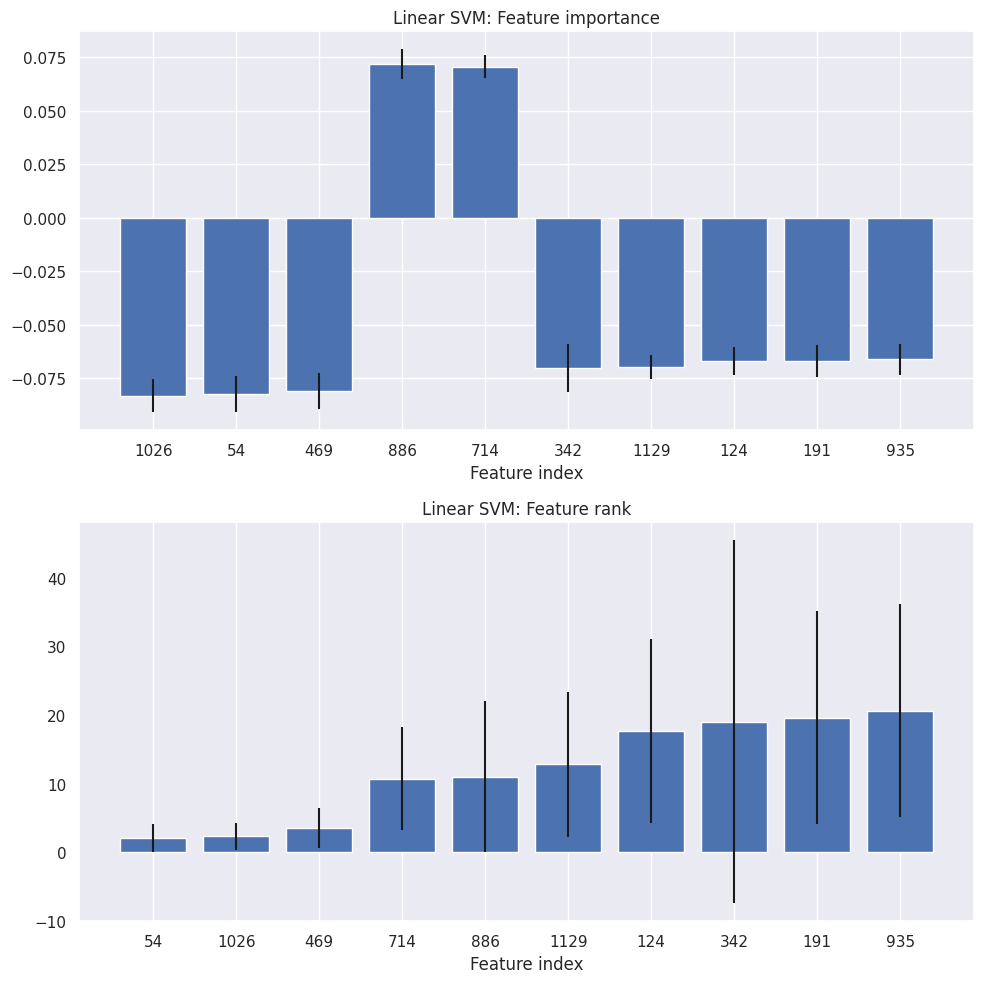

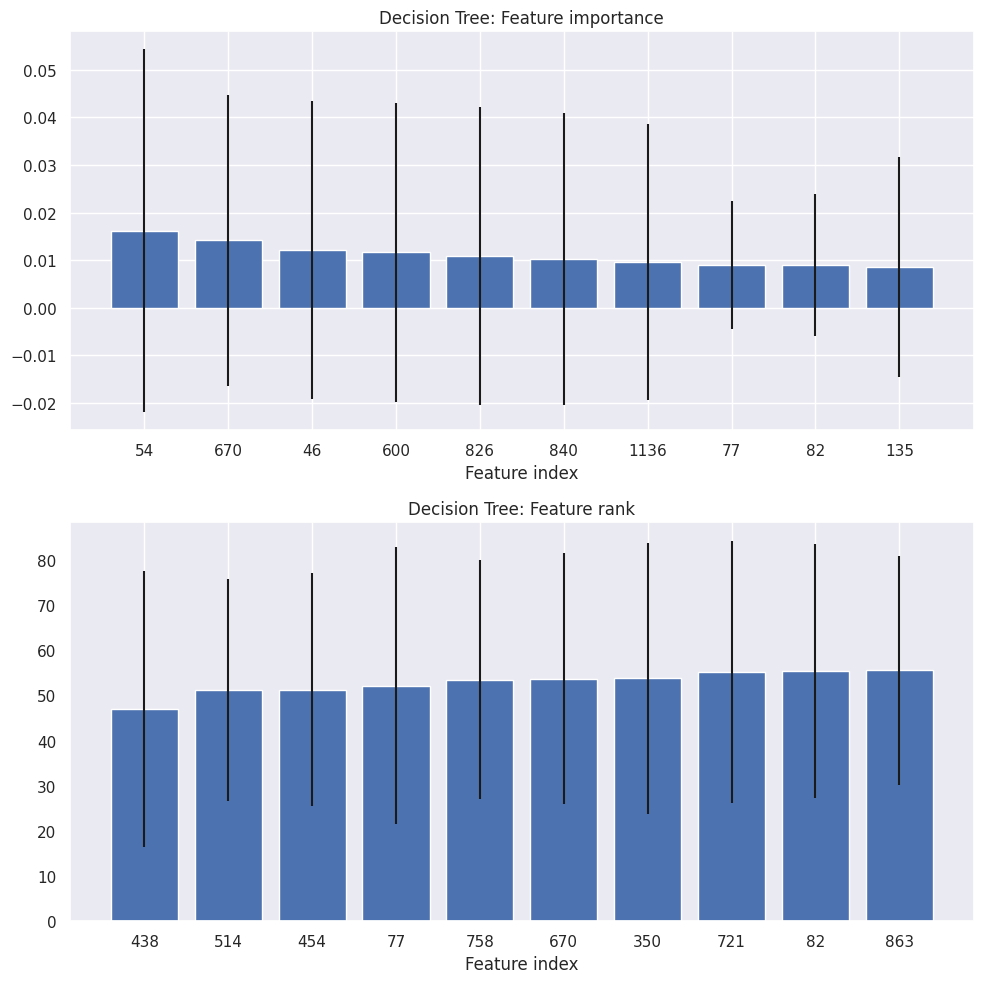

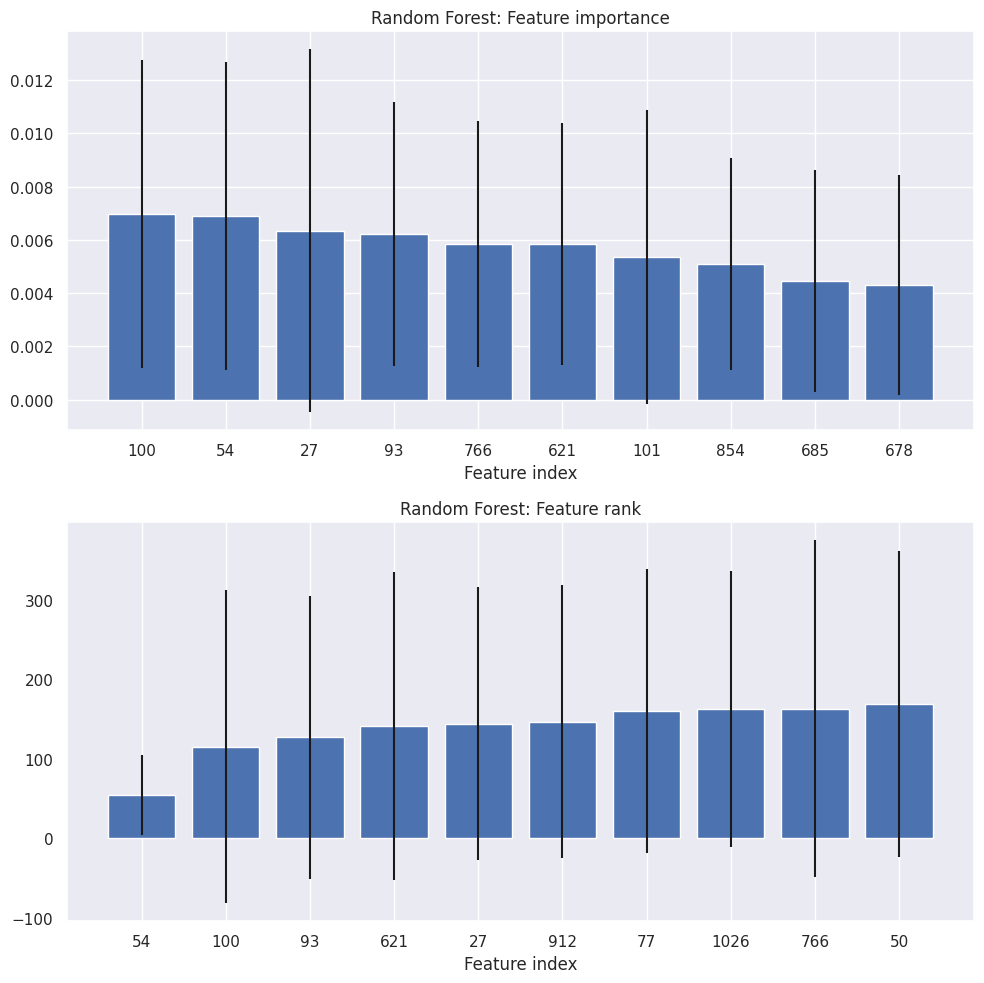

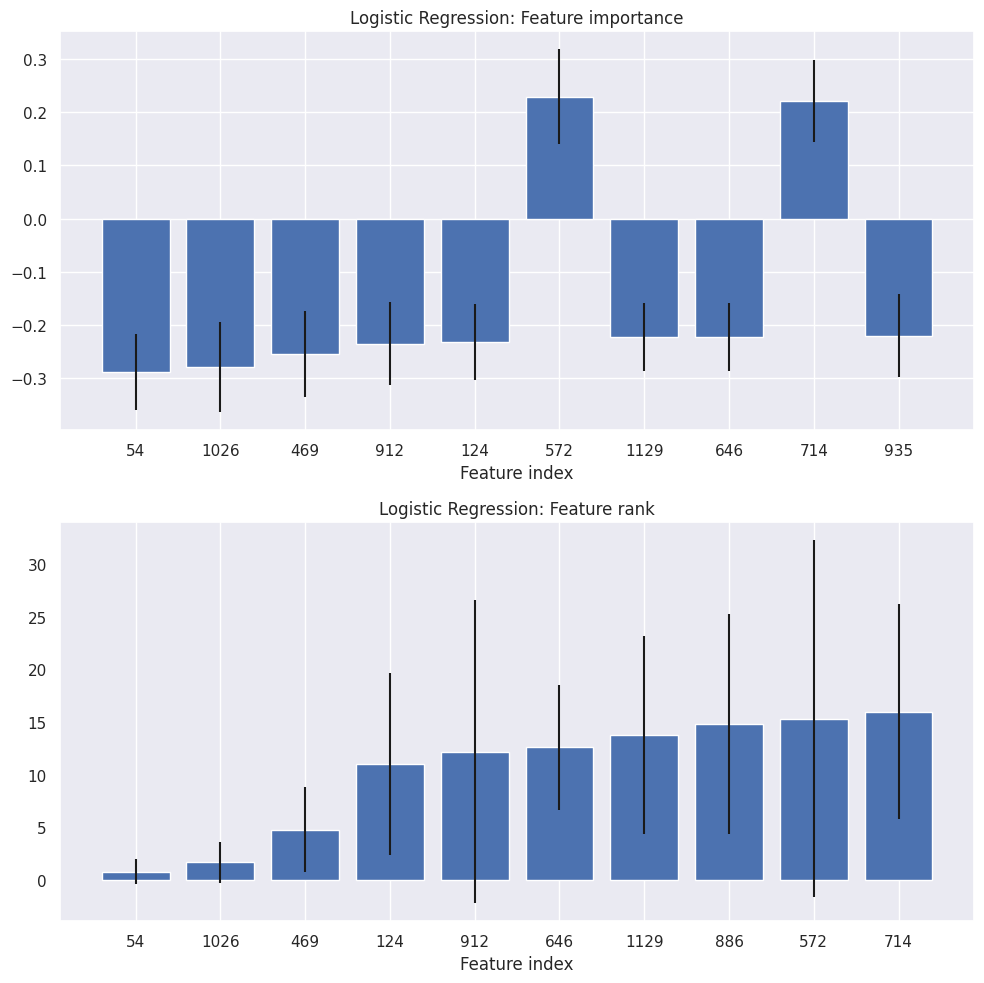

In [15]:
run_polyssifier.plot_features(ntop=10)

## Average 2+3

In [22]:
bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_ses-{rest_name}_seed-{seed_name}__voxelcorrelations.nii.gz"
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)
data = {}

for seed in SEEDS:
    for sub in tqdm(df_boot["subject_label"]):
        img_path_2 = img_tpl.format(seed_name=seed, participant_id=sub, rest_name = "REST1RL")
        img_path_3 = img_tpl.format(seed_name=seed, participant_id=sub, rest_name = "REST2LR")
        mean_image = image.mean_img([img_path_2, img_path_3])
        data[(sub, seed)] = img4d2vector(mean_image, masker)

100%|█████████████████████████████████████████| 570/570 [02:53<00:00,  3.28it/s]


In [23]:
run_polyssifier = run_poly(df_boot, data, ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])

2024-02-28 13:34:35,878 - polyssifier - INFO - Detected 2 classes in label
2024-02-28 13:34:35,878 - polyssifier - INFO - Building classifiers ...
2024-02-28 13:34:35,883 - polyssifier - INFO - Initialization, done.
2024-02-28 13:34:35,923 - polyssifier - INFO - Training Multilayer Perceptron 0
2024-02-28 13:34:38,964 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.82, 3.04 sec
2024-02-28 13:34:38,974 - polyssifier - INFO - Training Multilayer Perceptron 1
2024-02-28 13:34:41,950 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.86, 2.98 sec
2024-02-28 13:34:41,959 - polyssifier - INFO - Training Multilayer Perceptron 2
2024-02-28 13:34:44,564 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.91, 2.60 sec
2024-02-28 13:34:44,573 - polyssifier - INFO - Training Multilayer Perceptron 3
2024-02-28 13:34:47,356 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.87, 2.78 sec
2024-02-28 13:34:47,365 - polyss

predict proba return shape (57,)


2024-02-28 13:35:48,651 - polyssifier - INFO - Linear SVM                 1: Train 1.00/Test 0.88, 4.23 sec
2024-02-28 13:35:48,659 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2024-02-28 13:35:52,981 - polyssifier - INFO - Linear SVM                 2: Train 1.00/Test 0.95, 4.32 sec
2024-02-28 13:35:52,988 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2024-02-28 13:35:56,833 - polyssifier - INFO - Linear SVM                 3: Train 1.00/Test 0.90, 3.84 sec
2024-02-28 13:35:56,841 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2024-02-28 13:36:01,014 - polyssifier - INFO - Linear SVM                 4: Train 1.00/Test 0.89, 4.17 sec
2024-02-28 13:36:01,021 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2024-02-28 13:36:06,273 - polyssifier - INFO - Linear SVM                 5: Train 1.00/Test 0.91, 5.25 sec
2024-02-28 13:36:06,284 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2024-02-28 13:36:10,394 - polyssifier - INFO - Linear SVM                 6: Train 1.00/Test 0.89, 4.11 sec
2024-02-28 13:36:10,403 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2024-02-28 13:36:14,832 - polyssifier - INFO - Linear SVM                 7: Train 1.00/Test 0.92, 4.43 sec
2024-02-28 13:36:14,841 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2024-02-28 13:36:18,896 - polyssifier - INFO - Linear SVM                 8: Train 1.00/Test 0.89, 4.06 sec
2024-02-28 13:36:18,905 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2024-02-28 13:36:22,893 - polyssifier - INFO - Linear SVM                 9: Train 1.00/Test 0.94, 3.99 sec
2024-02-28 13:36:22,901 - polyssifier - INFO - Training Decision Tree 0
2024-02-28 13:36:22,944 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.53, 0.04 sec
2024-02-28 13:36:22,956 - polyssifier - INFO - Training Decision Tree 1
2024-02-28 13:36:22,983 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.72, 0.03 sec
2024-02-28 13:36:22,989 - polyssifier - INFO - Training Decision Tree 2
2024-02-28 13:36:23,013 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.52, 0.02 sec
2024-02-28 13:36:23,019 - polyssifier - INFO - Training Decision Tree 3
2024-02-28 13:36:23,044 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.65, 0.02 sec
2024-02-28 13:36:23,051 - polyssifier - INFO - Training Decision Tree 4
2024-02-28 13:36:23,076 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.54, 0

predict proba return shape (57,)


2024-02-28 13:36:23,109 - polyssifier - INFO - Decision Tree              5: Train 1.00/Test 0.54, 0.03 sec
2024-02-28 13:36:23,115 - polyssifier - INFO - Training Decision Tree 6
2024-02-28 13:36:23,143 - polyssifier - INFO - Decision Tree              6: Train 1.00/Test 0.51, 0.03 sec
2024-02-28 13:36:23,149 - polyssifier - INFO - Training Decision Tree 7
2024-02-28 13:36:23,176 - polyssifier - INFO - Decision Tree              7: Train 1.00/Test 0.61, 0.03 sec
2024-02-28 13:36:23,182 - polyssifier - INFO - Training Decision Tree 8
2024-02-28 13:36:23,209 - polyssifier - INFO - Decision Tree              8: Train 1.00/Test 0.62, 0.03 sec
2024-02-28 13:36:23,215 - polyssifier - INFO - Training Decision Tree 9
2024-02-28 13:36:23,241 - polyssifier - INFO - Decision Tree              9: Train 1.00/Test 0.60, 0.03 sec
2024-02-28 13:36:23,247 - polyssifier - INFO - Training Random Forest 0
2024-02-28 13:36:26,075 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.68, 2

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.872603  0.024936  0.823457  0.907407
Nearest Neighbors     train  0.799880  0.011016  0.787548  0.821016
                      test   0.746094  0.042597  0.666253  0.808933
SVM                   train  0.984278  0.002324  0.980879  0.987693
                      test   0.842820  0.041665  0.779630  0.913151
Linear SVM            train  1.000000  0.000000  1.000000  1.000000
                      test   0.904292  0.025504  0.864198  0.951852
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.583415  0.067500  0.508065  0.718519
Random Forest         train  0.999924  0.000092  0.999717  1.000000
                      test   0.725747  0.062415  0.646914  0.842432
Logistic Regression   train  1.000000  0.000000  1.000000  1.000000
                      test   0.907889  0.028066 

2024-02-28 13:37:06,085 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2024-02-28 13:37:06,460 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2024-02-28 13:37:06,776 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2024-02-28 13:37:07,101 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


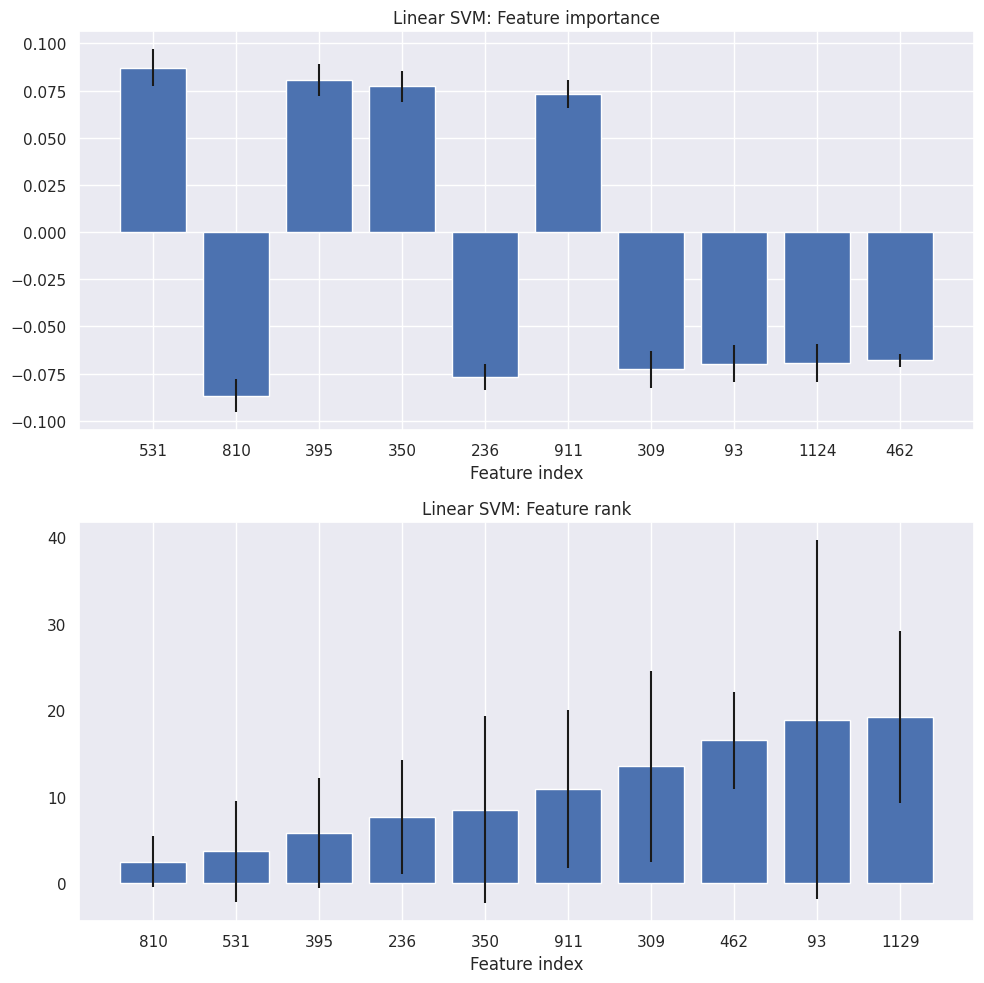

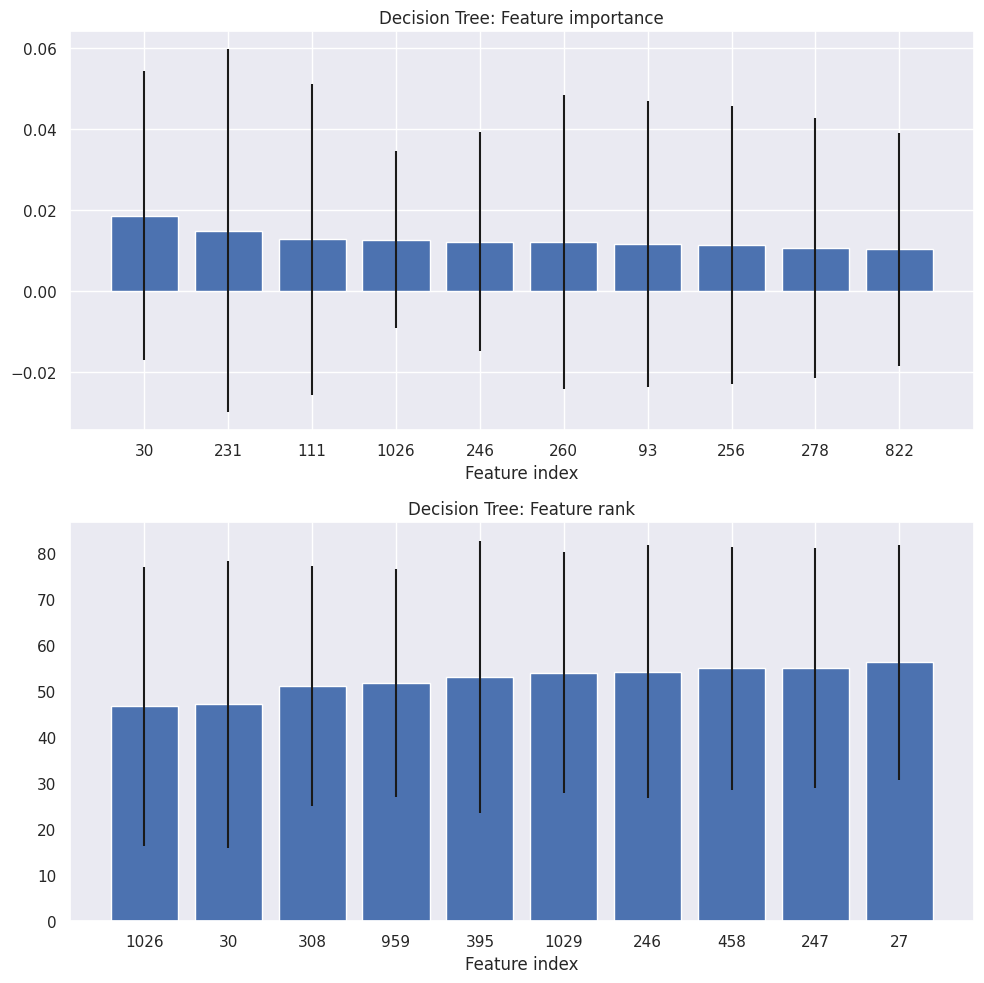

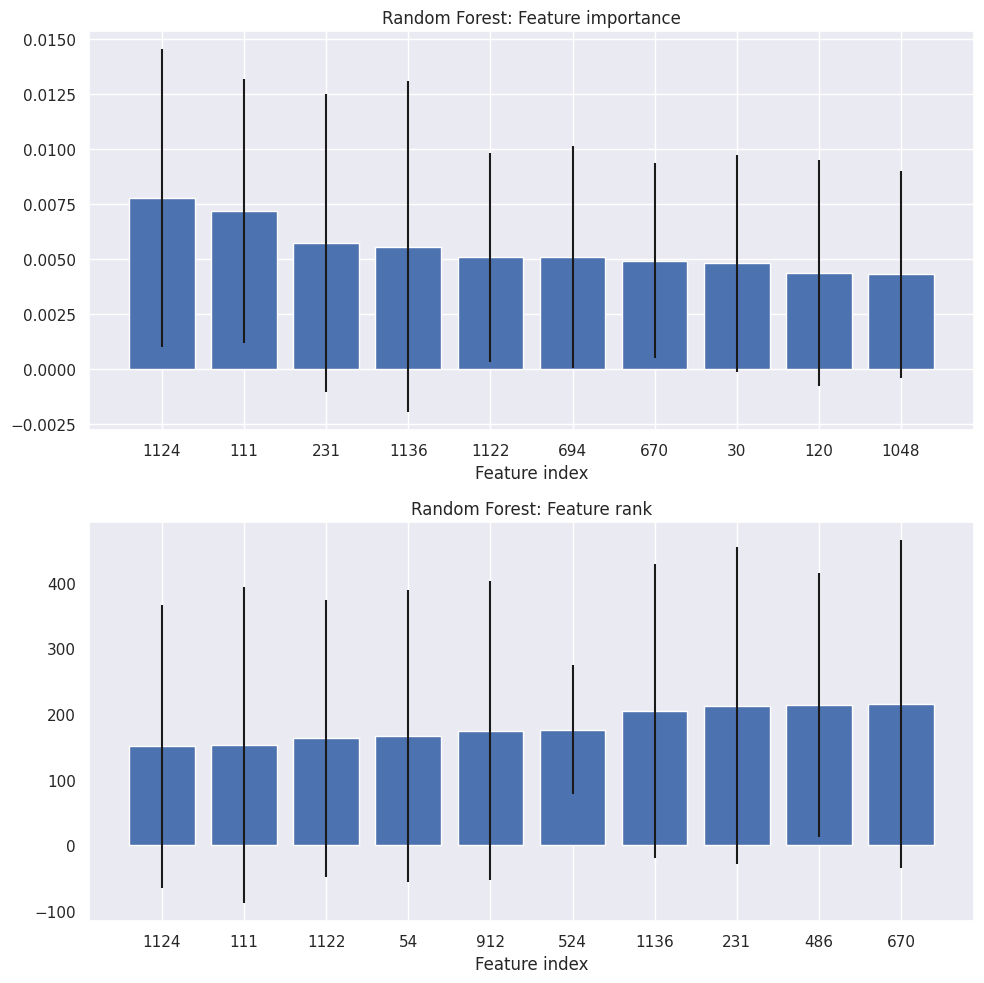

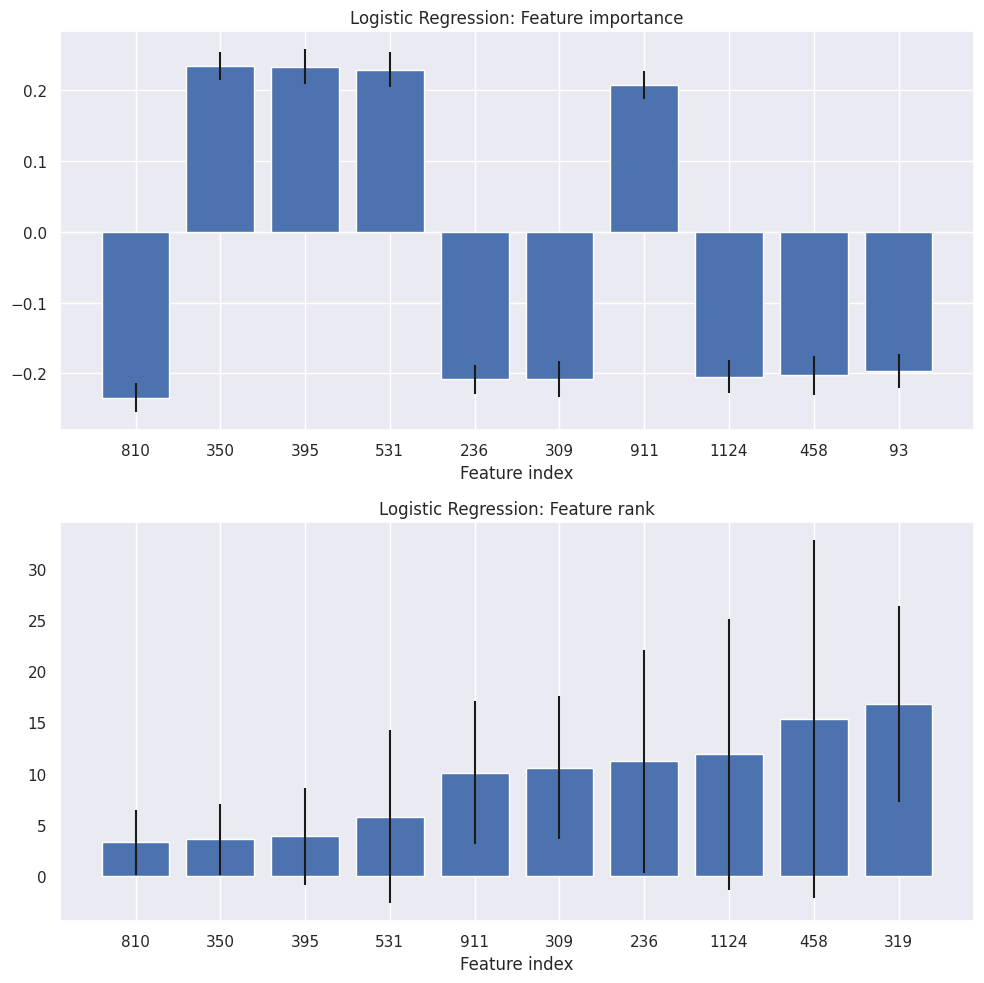

In [24]:
run_polyssifier.plot_features(ntop=10)

## Average 1,2,3 

In [6]:
bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_ses-{rest_name}_seed-{seed_name}__voxelcorrelations.nii.gz"
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)
data = {}

for seed in SEEDS:
    for sub in tqdm(df_boot["subject_label"]):
        img_path_1 = img_tpl.format(seed_name=seed, participant_id=sub, rest_name = "REST1LR")
        img_path_2 = img_tpl.format(seed_name=seed, participant_id=sub, rest_name = "REST1RL")
        img_path_3 = img_tpl.format(seed_name=seed, participant_id=sub, rest_name = "REST2LR")
        mean_image = image.mean_img([img_path_1, img_path_2, img_path_3])
        data[(sub, seed)] = img4d2vector(mean_image, masker)

100%|█████████████████████████████████████████| 570/570 [05:51<00:00,  1.62it/s]


In [7]:
run_polyssifier = run_poly(df_boot, data, ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])


2024-04-09 12:59:55,736 - polyssifier - INFO - Detected 2 classes in label
2024-04-09 12:59:55,737 - polyssifier - INFO - Building classifiers ...
2024-04-09 12:59:55,741 - polyssifier - INFO - Initialization, done.
2024-04-09 12:59:55,786 - polyssifier - INFO - Training Multilayer Perceptron 0
2024-04-09 12:59:58,691 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.84, 2.91 sec
2024-04-09 12:59:58,698 - polyssifier - INFO - Training Multilayer Perceptron 1
2024-04-09 13:00:01,434 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.81, 2.74 sec
2024-04-09 13:00:01,443 - polyssifier - INFO - Training Multilayer Perceptron 2
2024-04-09 13:00:04,132 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.90, 2.69 sec
2024-04-09 13:00:04,141 - polyssifier - INFO - Training Multilayer Perceptron 3
2024-04-09 13:00:06,950 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.88, 2.81 sec
2024-04-09 13:00:06,959 - polyss

predict proba return shape (57,)


2024-04-09 13:01:04,515 - polyssifier - INFO - Linear SVM                 1: Train 1.00/Test 0.87, 3.54 sec
2024-04-09 13:01:04,524 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2024-04-09 13:01:08,089 - polyssifier - INFO - Linear SVM                 2: Train 1.00/Test 0.94, 3.56 sec
2024-04-09 13:01:08,097 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2024-04-09 13:01:11,985 - polyssifier - INFO - Linear SVM                 3: Train 1.00/Test 0.91, 3.89 sec
2024-04-09 13:01:11,994 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2024-04-09 13:01:15,750 - polyssifier - INFO - Linear SVM                 4: Train 1.00/Test 0.92, 3.76 sec
2024-04-09 13:01:15,758 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2024-04-09 13:01:19,586 - polyssifier - INFO - Linear SVM                 5: Train 1.00/Test 0.90, 3.83 sec
2024-04-09 13:01:19,594 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2024-04-09 13:01:23,128 - polyssifier - INFO - Linear SVM                 6: Train 1.00/Test 0.89, 3.53 sec
2024-04-09 13:01:23,137 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2024-04-09 13:01:26,675 - polyssifier - INFO - Linear SVM                 7: Train 1.00/Test 0.93, 3.54 sec
2024-04-09 13:01:26,683 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2024-04-09 13:01:30,639 - polyssifier - INFO - Linear SVM                 8: Train 1.00/Test 0.92, 3.96 sec
2024-04-09 13:01:30,646 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2024-04-09 13:01:34,255 - polyssifier - INFO - Linear SVM                 9: Train 1.00/Test 0.97, 3.61 sec
2024-04-09 13:01:34,263 - polyssifier - INFO - Training Decision Tree 0
2024-04-09 13:01:34,304 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.56, 0.04 sec
2024-04-09 13:01:34,312 - polyssifier - INFO - Training Decision Tree 1
2024-04-09 13:01:34,341 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.57, 0.03 sec
2024-04-09 13:01:34,347 - polyssifier - INFO - Training Decision Tree 2
2024-04-09 13:01:34,375 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.65, 0.03 sec
2024-04-09 13:01:34,381 - polyssifier - INFO - Training Decision Tree 3
2024-04-09 13:01:34,405 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.67, 0.02 sec
2024-04-09 13:01:34,411 - polyssifier - INFO - Training Decision Tree 4
2024-04-09 13:01:34,436 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.61, 0

predict proba return shape (57,)


2024-04-09 13:01:34,467 - polyssifier - INFO - Decision Tree              5: Train 1.00/Test 0.48, 0.03 sec
2024-04-09 13:01:34,473 - polyssifier - INFO - Training Decision Tree 6
2024-04-09 13:01:34,498 - polyssifier - INFO - Decision Tree              6: Train 1.00/Test 0.50, 0.03 sec
2024-04-09 13:01:34,504 - polyssifier - INFO - Training Decision Tree 7
2024-04-09 13:01:34,530 - polyssifier - INFO - Decision Tree              7: Train 1.00/Test 0.56, 0.03 sec
2024-04-09 13:01:34,535 - polyssifier - INFO - Training Decision Tree 8
2024-04-09 13:01:34,559 - polyssifier - INFO - Decision Tree              8: Train 1.00/Test 0.63, 0.02 sec
2024-04-09 13:01:34,566 - polyssifier - INFO - Training Decision Tree 9
2024-04-09 13:01:34,592 - polyssifier - INFO - Decision Tree              9: Train 1.00/Test 0.43, 0.03 sec
2024-04-09 13:01:34,598 - polyssifier - INFO - Training Random Forest 0
2024-04-09 13:01:37,279 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.61, 2

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.890358  0.039843  0.807407  0.942928
Nearest Neighbors     train  0.798812  0.007930  0.790275  0.818374
                      test   0.756000  0.056889  0.654321  0.843052
SVM                   train  0.989016  0.001650  0.986593  0.991169
                      test   0.861852  0.034417  0.801235  0.911911
Linear SVM            train  1.000000  0.000000  1.000000  1.000000
                      test   0.914454  0.028324  0.872840  0.972705
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.566026  0.077699  0.434243  0.668519
Random Forest         train  0.999755  0.000305  0.999114  1.000000
                      test   0.740314  0.073860  0.609877  0.847395
Logistic Regression   train  1.000000  0.000000  1.000000  1.000000
                      test   0.921021  0.029623 

2024-04-09 13:02:20,095 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2024-04-09 13:02:20,873 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2024-04-09 13:02:21,156 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2024-04-09 13:02:21,428 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


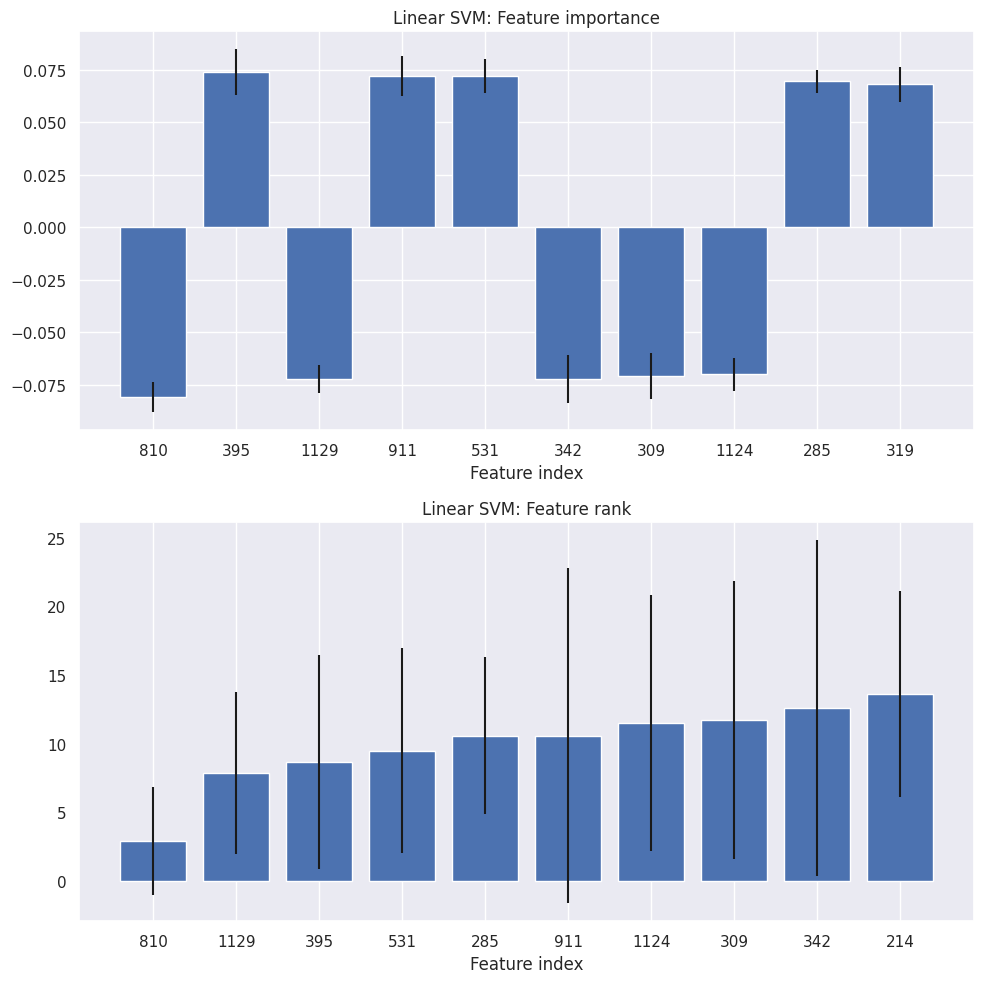

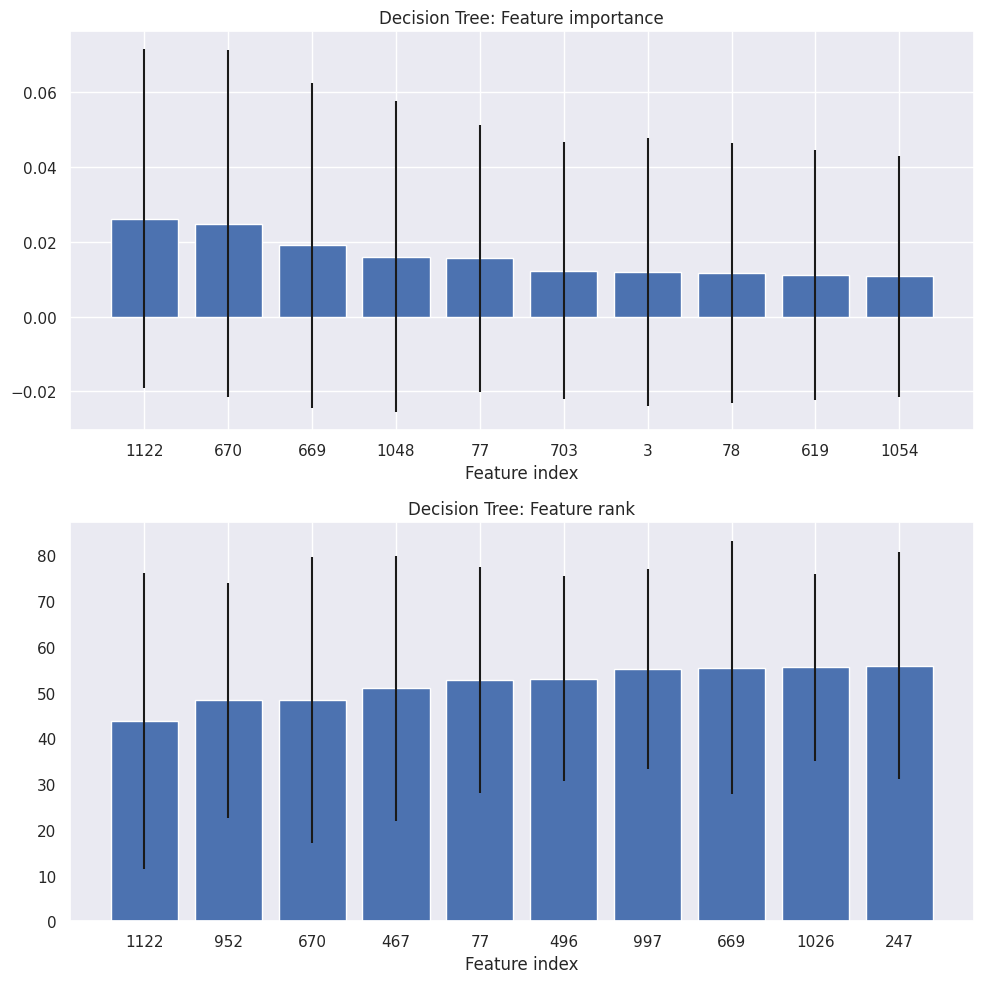

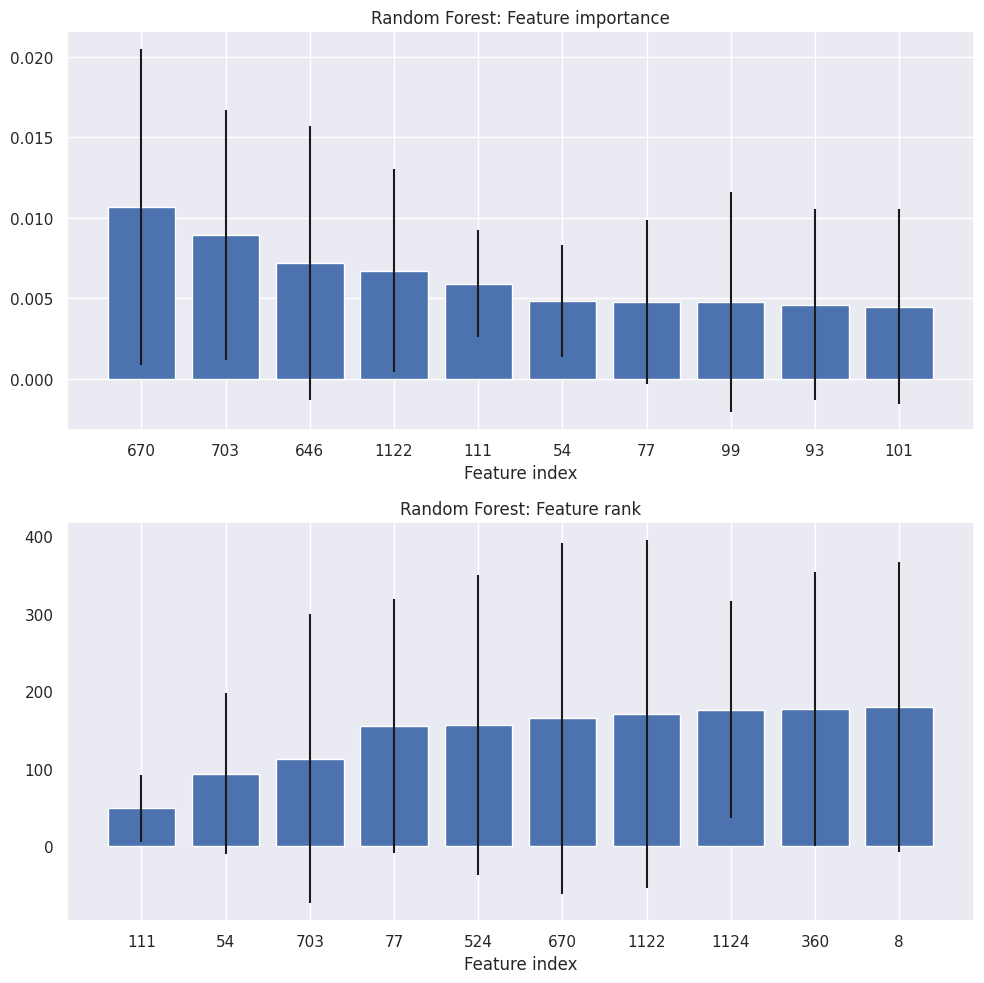

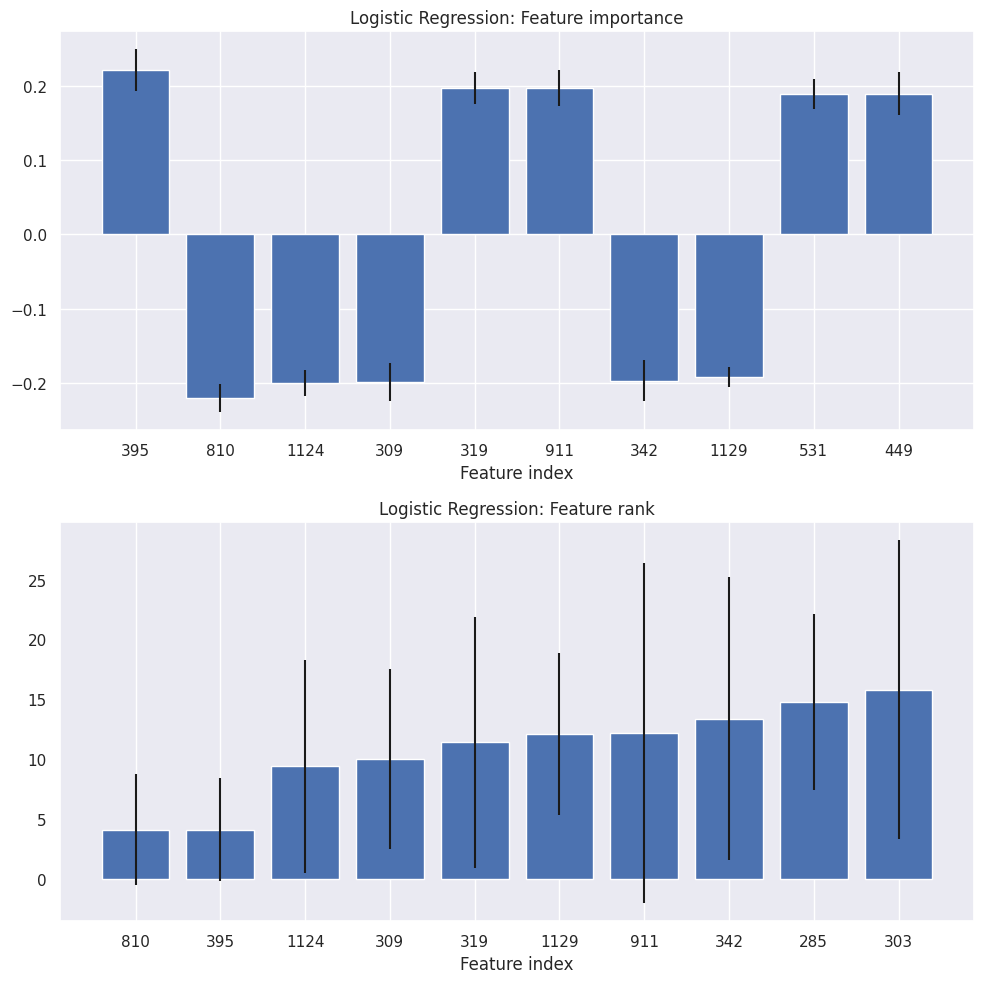

In [8]:
run_polyssifier.plot_features(ntop=10)

## average 2,3,4 

In [9]:
bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_ses-{rest_name}_seed-{seed_name}__voxelcorrelations.nii.gz"
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)
data = {}

for seed in SEEDS:
    for sub in tqdm(df_boot["subject_label"]):
        img_path_2 = img_tpl.format(seed_name=seed, participant_id=sub, rest_name = "REST1RL")
        img_path_3 = img_tpl.format(seed_name=seed, participant_id=sub, rest_name = "REST2LR")
        img_path_4 = img_tpl.format(seed_name=seed, participant_id=sub, rest_name = "REST2RL")
        mean_image = image.mean_img([img_path_2, img_path_3, img_path_4])
        data[(sub, seed)] = img4d2vector(mean_image, masker)

100%|█████████████████████████████████████████| 570/570 [04:43<00:00,  2.01it/s]


In [11]:
run_polyssifier = run_poly(df_boot, data, ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])


2024-04-09 13:50:51,036 - polyssifier - INFO - Detected 2 classes in label
2024-04-09 13:50:51,037 - polyssifier - INFO - Building classifiers ...
2024-04-09 13:50:51,040 - polyssifier - INFO - Initialization, done.
2024-04-09 13:50:51,068 - polyssifier - INFO - Training Multilayer Perceptron 0
2024-04-09 13:50:53,765 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.85, 2.70 sec
2024-04-09 13:50:53,774 - polyssifier - INFO - Training Multilayer Perceptron 1
2024-04-09 13:50:56,405 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.82, 2.63 sec
2024-04-09 13:50:56,414 - polyssifier - INFO - Training Multilayer Perceptron 2
2024-04-09 13:50:59,064 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.91, 2.65 sec
2024-04-09 13:50:59,071 - polyssifier - INFO - Training Multilayer Perceptron 3
2024-04-09 13:51:01,841 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.89, 2.77 sec
2024-04-09 13:51:01,850 - polyss

predict proba return shape (57,)


2024-04-09 13:52:00,665 - polyssifier - INFO - Linear SVM                 1: Train 1.00/Test 0.87, 4.00 sec
2024-04-09 13:52:00,673 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2024-04-09 13:52:04,869 - polyssifier - INFO - Linear SVM                 2: Train 1.00/Test 0.93, 4.20 sec
2024-04-09 13:52:04,877 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2024-04-09 13:52:08,984 - polyssifier - INFO - Linear SVM                 3: Train 1.00/Test 0.89, 4.11 sec
2024-04-09 13:52:08,991 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2024-04-09 13:52:12,973 - polyssifier - INFO - Linear SVM                 4: Train 1.00/Test 0.90, 3.98 sec
2024-04-09 13:52:12,981 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2024-04-09 13:52:17,348 - polyssifier - INFO - Linear SVM                 5: Train 1.00/Test 0.91, 4.37 sec
2024-04-09 13:52:17,356 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2024-04-09 13:52:20,978 - polyssifier - INFO - Linear SVM                 6: Train 1.00/Test 0.90, 3.62 sec
2024-04-09 13:52:20,986 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2024-04-09 13:52:24,515 - polyssifier - INFO - Linear SVM                 7: Train 1.00/Test 0.92, 3.53 sec
2024-04-09 13:52:24,523 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2024-04-09 13:52:28,682 - polyssifier - INFO - Linear SVM                 8: Train 1.00/Test 0.91, 4.16 sec
2024-04-09 13:52:28,691 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2024-04-09 13:52:32,630 - polyssifier - INFO - Linear SVM                 9: Train 1.00/Test 0.96, 3.94 sec
2024-04-09 13:52:32,638 - polyssifier - INFO - Training Decision Tree 0
2024-04-09 13:52:32,677 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.42, 0.04 sec
2024-04-09 13:52:32,686 - polyssifier - INFO - Training Decision Tree 1
2024-04-09 13:52:32,714 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.52, 0.03 sec
2024-04-09 13:52:32,721 - polyssifier - INFO - Training Decision Tree 2
2024-04-09 13:52:32,746 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.61, 0.03 sec
2024-04-09 13:52:32,753 - polyssifier - INFO - Training Decision Tree 3
2024-04-09 13:52:32,778 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.58, 0.03 sec
2024-04-09 13:52:32,784 - polyssifier - INFO - Training Decision Tree 4
2024-04-09 13:52:32,809 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.51, 0

predict proba return shape (57,)


2024-04-09 13:52:32,841 - polyssifier - INFO - Decision Tree              5: Train 1.00/Test 0.66, 0.03 sec
2024-04-09 13:52:32,847 - polyssifier - INFO - Training Decision Tree 6
2024-04-09 13:52:32,874 - polyssifier - INFO - Decision Tree              6: Train 1.00/Test 0.51, 0.03 sec
2024-04-09 13:52:32,880 - polyssifier - INFO - Training Decision Tree 7
2024-04-09 13:52:32,903 - polyssifier - INFO - Decision Tree              7: Train 1.00/Test 0.66, 0.02 sec
2024-04-09 13:52:32,909 - polyssifier - INFO - Training Decision Tree 8
2024-04-09 13:52:32,937 - polyssifier - INFO - Decision Tree              8: Train 1.00/Test 0.64, 0.03 sec
2024-04-09 13:52:32,943 - polyssifier - INFO - Training Decision Tree 9
2024-04-09 13:52:32,969 - polyssifier - INFO - Decision Tree              9: Train 1.00/Test 0.58, 0.03 sec
2024-04-09 13:52:32,975 - polyssifier - INFO - Training Random Forest 0
2024-04-09 13:52:35,609 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.70, 2

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.880659  0.031864  0.823457  0.926799
Nearest Neighbors     train  0.795719  0.007315  0.786339  0.808862
                      test   0.739043  0.048365  0.684864  0.833747
SVM                   train  0.990485  0.005393  0.981222  0.996532
                      test   0.822927  0.048570  0.754321  0.919753
Linear SVM            train  1.000000  0.000000  1.000000  1.000000
                      test   0.907408  0.025682  0.871605  0.962779
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.567556  0.077221  0.418519  0.659429
Random Forest         train  0.999785  0.000559  0.998205  1.000000
                      test   0.714802  0.071134  0.577160  0.813275
Logistic Regression   train  1.000000  0.000000  1.000000  1.000000
                      test   0.908278  0.028370 

2024-04-09 13:54:07,329 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2024-04-09 13:54:07,641 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2024-04-09 13:54:07,943 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2024-04-09 13:54:08,228 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


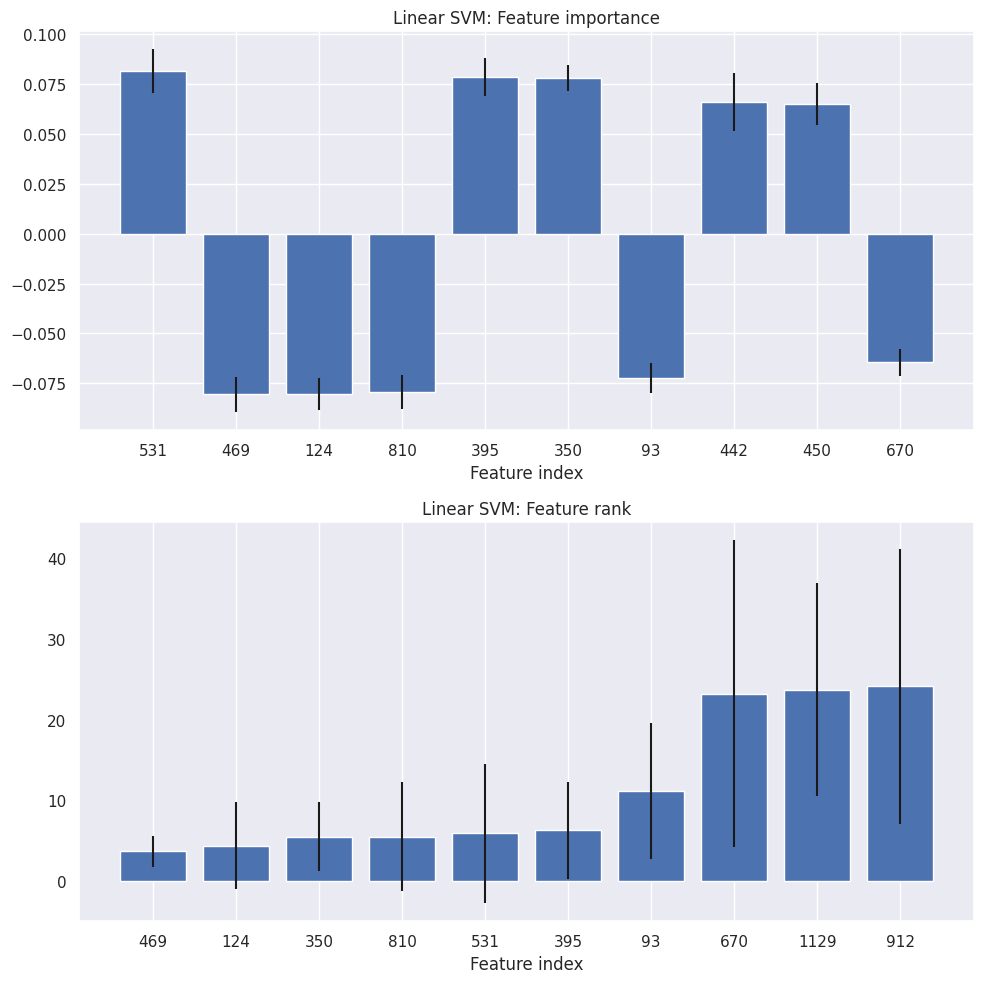

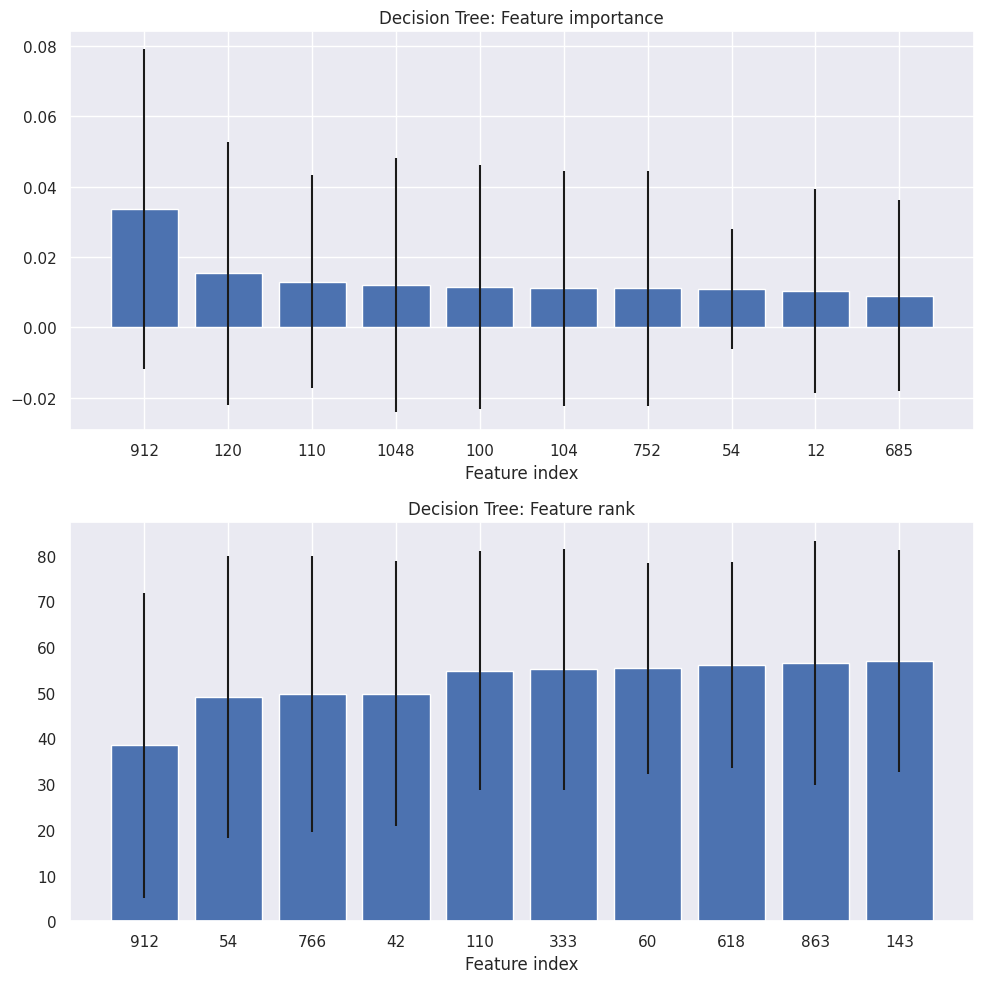

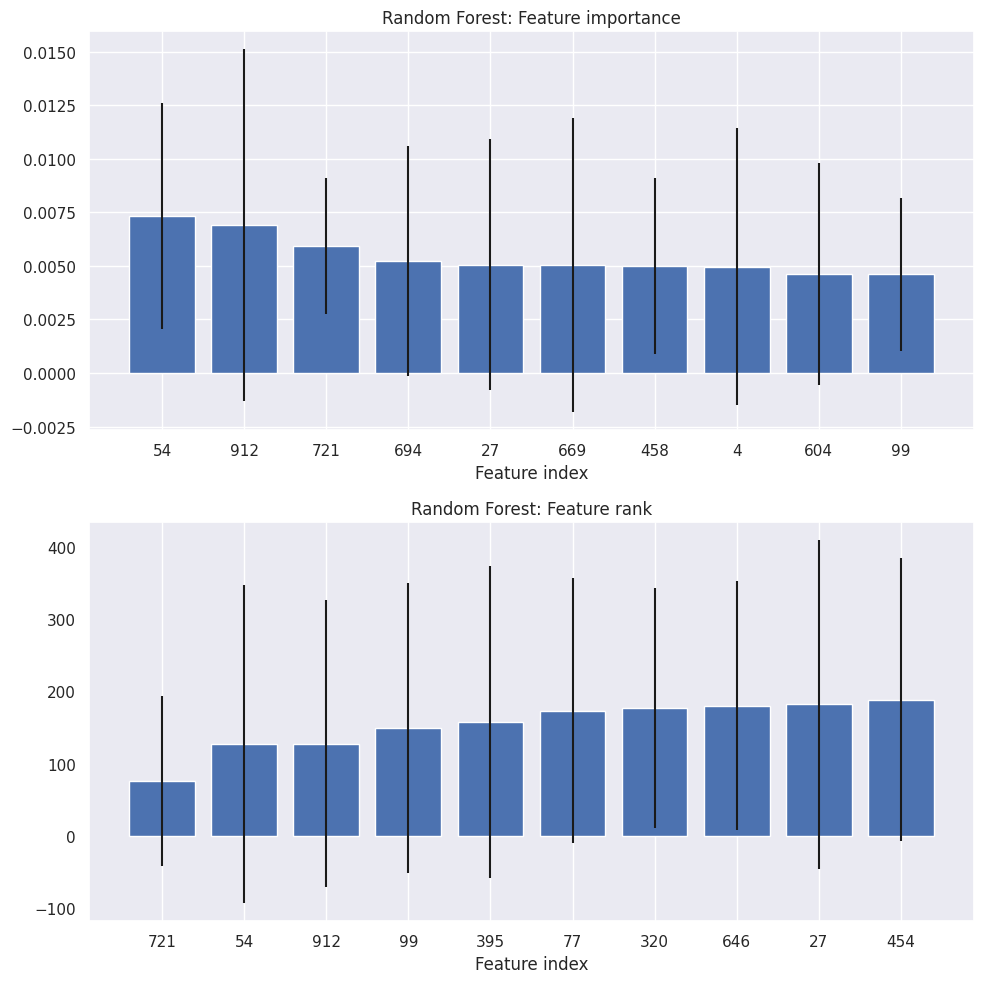

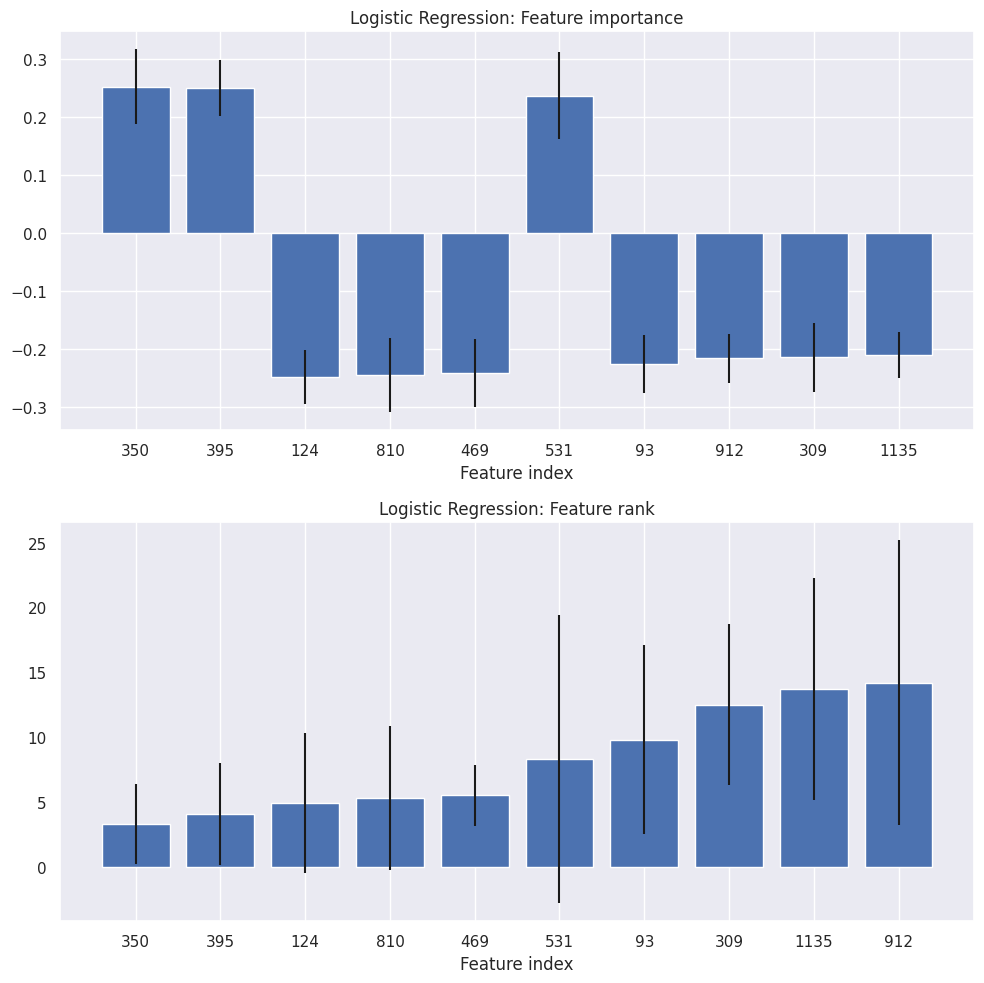

In [12]:
run_polyssifier.plot_features(ntop=10)

# average 1 3 4 

In [13]:
bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_ses-{rest_name}_seed-{seed_name}__voxelcorrelations.nii.gz"
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)
data = {}

for seed in SEEDS:
    for sub in tqdm(df_boot["subject_label"]):
        img_path_1 = img_tpl.format(seed_name=seed, participant_id=sub, rest_name = "REST1LR")
        img_path_3 = img_tpl.format(seed_name=seed, participant_id=sub, rest_name = "REST2LR")
        img_path_4 = img_tpl.format(seed_name=seed, participant_id=sub, rest_name = "REST2RL")
        mean_image = image.mean_img([img_path_1, img_path_3, img_path_4])
        data[(sub, seed)] = img4d2vector(mean_image, masker)

100%|█████████████████████████████████████████| 570/570 [03:59<00:00,  2.38it/s]


In [14]:
run_polyssifier = run_poly(df_boot, data, ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])


2024-04-09 14:30:34,944 - polyssifier - INFO - Detected 2 classes in label
2024-04-09 14:30:34,945 - polyssifier - INFO - Building classifiers ...
2024-04-09 14:30:34,949 - polyssifier - INFO - Initialization, done.
2024-04-09 14:30:34,976 - polyssifier - INFO - Training Multilayer Perceptron 0
2024-04-09 14:30:37,687 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.87, 2.71 sec
2024-04-09 14:30:37,699 - polyssifier - INFO - Training Multilayer Perceptron 1
2024-04-09 14:30:40,140 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.82, 2.44 sec
2024-04-09 14:30:40,149 - polyssifier - INFO - Training Multilayer Perceptron 2
2024-04-09 14:30:43,442 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.91, 3.29 sec
2024-04-09 14:30:43,450 - polyssifier - INFO - Training Multilayer Perceptron 3
2024-04-09 14:30:46,028 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.88, 2.58 sec
2024-04-09 14:30:46,037 - polyss

predict proba return shape (57,)


2024-04-09 14:31:45,560 - polyssifier - INFO - Linear SVM                 1: Train 1.00/Test 0.86, 4.06 sec
2024-04-09 14:31:45,568 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2024-04-09 14:31:49,285 - polyssifier - INFO - Linear SVM                 2: Train 1.00/Test 0.93, 3.72 sec
2024-04-09 14:31:49,293 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2024-04-09 14:31:53,604 - polyssifier - INFO - Linear SVM                 3: Train 1.00/Test 0.90, 4.31 sec
2024-04-09 14:31:53,613 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2024-04-09 14:31:57,256 - polyssifier - INFO - Linear SVM                 4: Train 1.00/Test 0.87, 3.64 sec
2024-04-09 14:31:57,264 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2024-04-09 14:32:01,235 - polyssifier - INFO - Linear SVM                 5: Train 1.00/Test 0.90, 3.97 sec
2024-04-09 14:32:01,241 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2024-04-09 14:32:05,195 - polyssifier - INFO - Linear SVM                 6: Train 1.00/Test 0.87, 3.95 sec
2024-04-09 14:32:05,203 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2024-04-09 14:32:09,510 - polyssifier - INFO - Linear SVM                 7: Train 1.00/Test 0.92, 4.31 sec
2024-04-09 14:32:09,518 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2024-04-09 14:32:13,455 - polyssifier - INFO - Linear SVM                 8: Train 1.00/Test 0.92, 3.94 sec
2024-04-09 14:32:13,463 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2024-04-09 14:32:17,037 - polyssifier - INFO - Linear SVM                 9: Train 1.00/Test 0.97, 3.57 sec
2024-04-09 14:32:17,045 - polyssifier - INFO - Training Decision Tree 0
2024-04-09 14:32:17,084 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.72, 0.04 sec
2024-04-09 14:32:17,094 - polyssifier - INFO - Training Decision Tree 1
2024-04-09 14:32:17,126 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.63, 0.03 sec
2024-04-09 14:32:17,133 - polyssifier - INFO - Training Decision Tree 2
2024-04-09 14:32:17,157 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.46, 0.02 sec
2024-04-09 14:32:17,163 - polyssifier - INFO - Training Decision Tree 3
2024-04-09 14:32:17,188 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.64, 0.02 sec
2024-04-09 14:32:17,194 - polyssifier - INFO - Training Decision Tree 4
2024-04-09 14:32:17,219 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.56, 0

predict proba return shape (57,)


2024-04-09 14:32:17,249 - polyssifier - INFO - Decision Tree              5: Train 1.00/Test 0.59, 0.02 sec
2024-04-09 14:32:17,255 - polyssifier - INFO - Training Decision Tree 6
2024-04-09 14:32:17,281 - polyssifier - INFO - Decision Tree              6: Train 1.00/Test 0.55, 0.03 sec
2024-04-09 14:32:17,287 - polyssifier - INFO - Training Decision Tree 7
2024-04-09 14:32:17,317 - polyssifier - INFO - Decision Tree              7: Train 1.00/Test 0.55, 0.03 sec
2024-04-09 14:32:17,323 - polyssifier - INFO - Training Decision Tree 8
2024-04-09 14:32:17,347 - polyssifier - INFO - Decision Tree              8: Train 1.00/Test 0.59, 0.02 sec
2024-04-09 14:32:17,352 - polyssifier - INFO - Training Decision Tree 9
2024-04-09 14:32:17,376 - polyssifier - INFO - Decision Tree              9: Train 1.00/Test 0.61, 0.02 sec
2024-04-09 14:32:17,382 - polyssifier - INFO - Training Random Forest 0
2024-04-09 14:32:20,021 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.72, 2

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.879540  0.039601  0.820988  0.939206
Nearest Neighbors     train  0.832361  0.017045  0.810287  0.862067
                      test   0.748004  0.054291  0.669975  0.832099
SVM                   train  0.990797  0.006773  0.983636  0.998930
                      test   0.831698  0.048365  0.767901  0.916049
Linear SVM            train  1.000000  0.000000  1.000000  1.000000
                      test   0.904419  0.031732  0.860494  0.967742
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.587996  0.069638  0.455556  0.720370
Random Forest         train  0.999923  0.000116  0.999618  1.000000
                      test   0.758413  0.043404  0.703086  0.831481
Logistic Regression   train  1.000000  0.000000  1.000000  1.000000
                      test   0.909619  0.031061 

2024-04-09 14:34:15,310 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2024-04-09 14:34:15,671 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2024-04-09 14:34:15,976 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2024-04-09 14:34:16,251 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


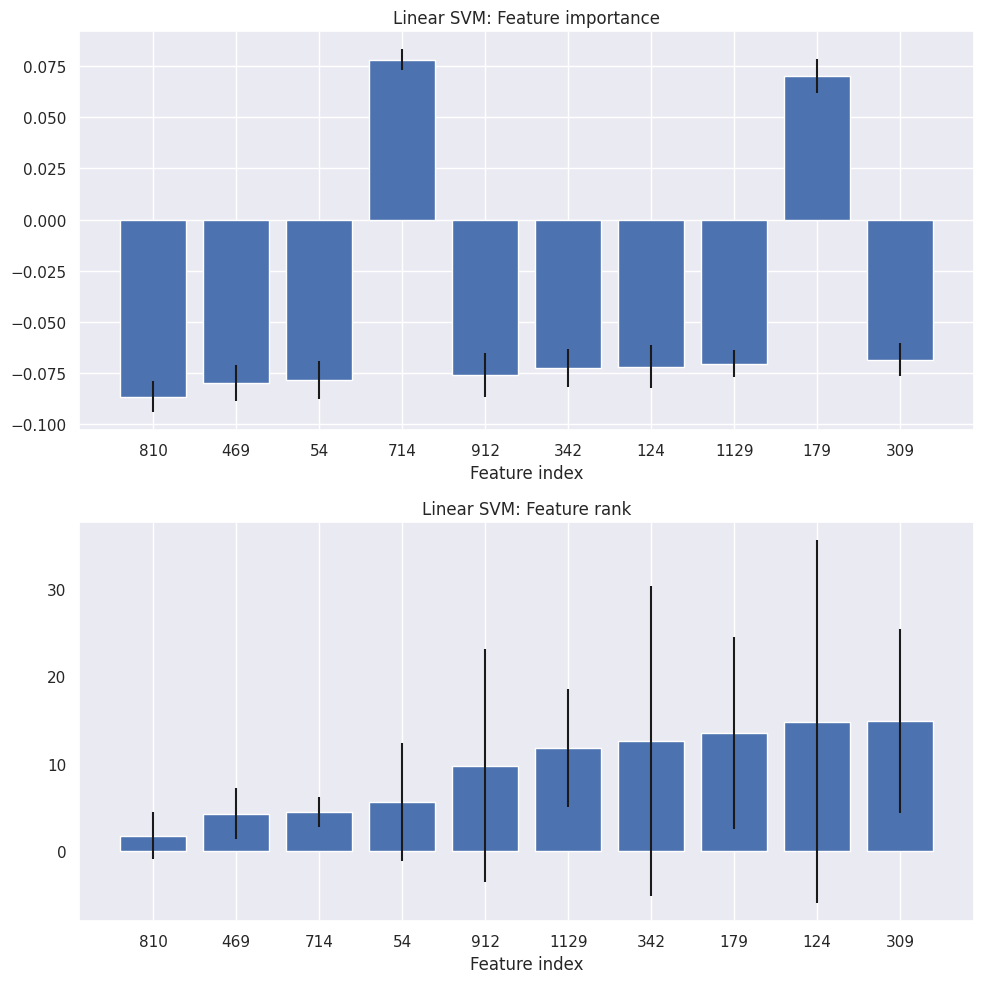

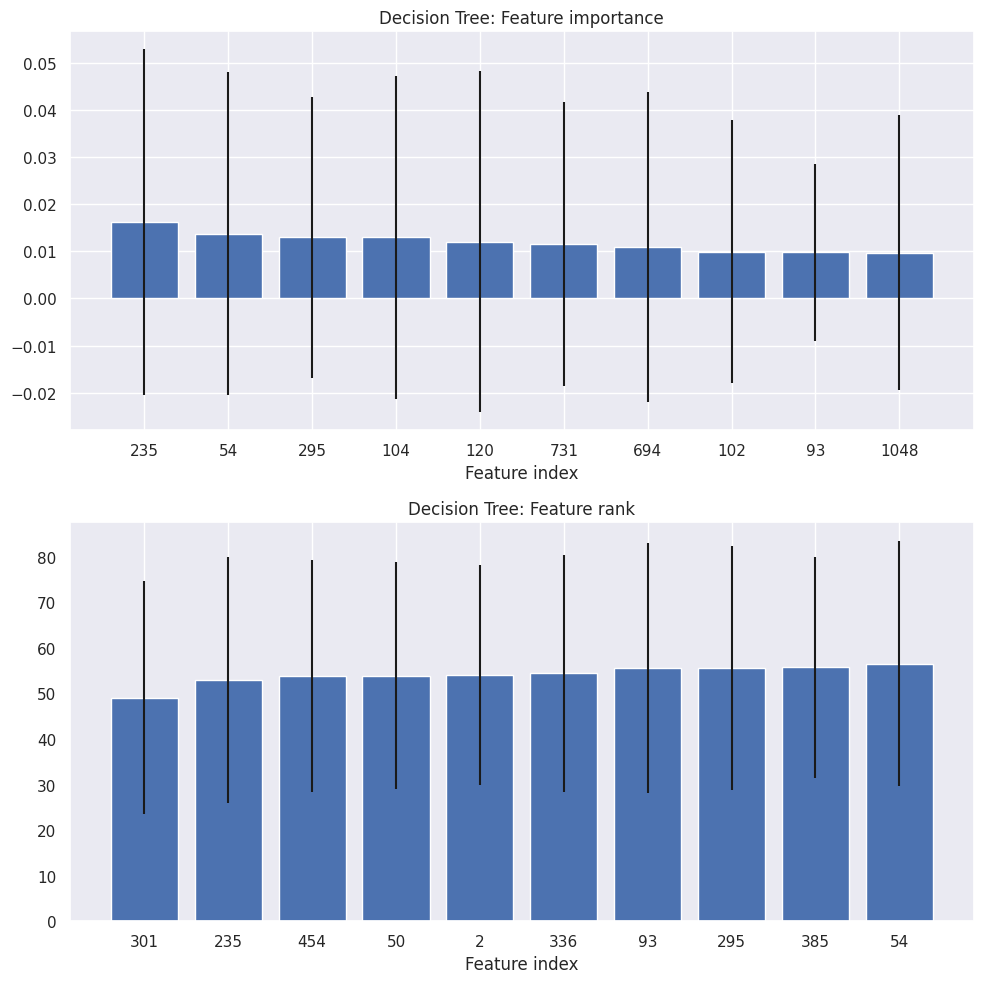

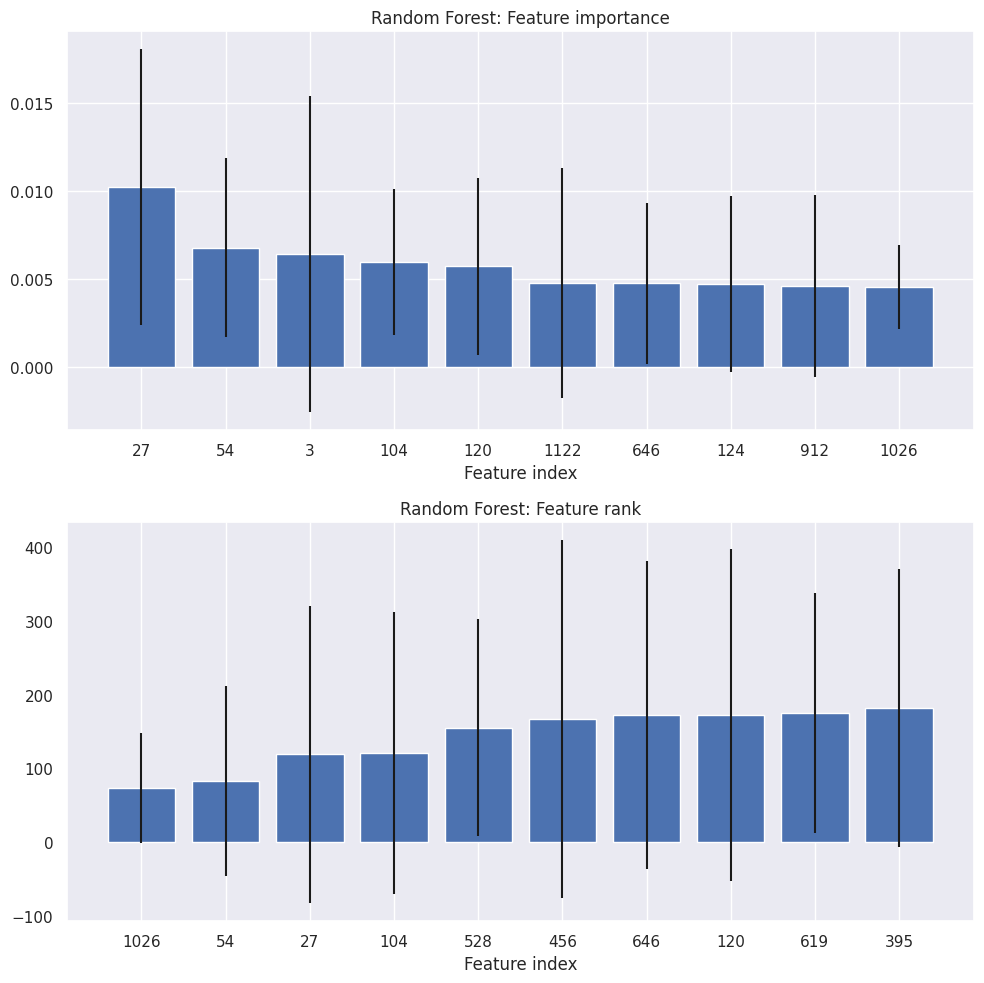

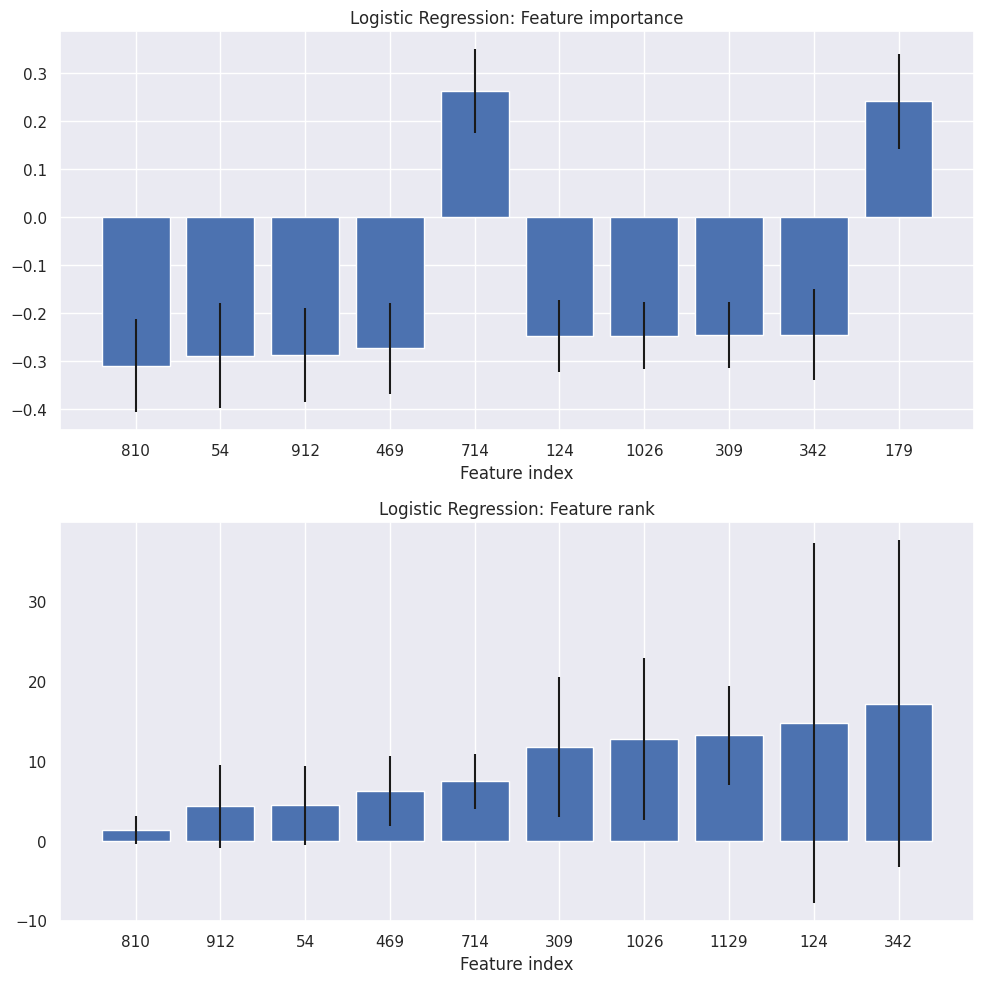

In [15]:
run_polyssifier.plot_features(ntop=10)

# average 1 2 4

In [16]:
bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_ses-{rest_name}_seed-{seed_name}__voxelcorrelations.nii.gz"
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)
data = {}

for seed in SEEDS:
    for sub in tqdm(df_boot["subject_label"]):
        img_path_1 = img_tpl.format(seed_name=seed, participant_id=sub, rest_name = "REST1LR")
        img_path_2 = img_tpl.format(seed_name=seed, participant_id=sub, rest_name = "REST1RL")
        img_path_4 = img_tpl.format(seed_name=seed, participant_id=sub, rest_name = "REST2RL")
        mean_image = image.mean_img([img_path_1, img_path_2, img_path_4])
        data[(sub, seed)] = img4d2vector(mean_image, masker)

100%|█████████████████████████████████████████| 570/570 [03:57<00:00,  2.40it/s]


In [17]:
run_polyssifier = run_poly(df_boot, data, ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])


2024-04-09 15:08:12,923 - polyssifier - INFO - Detected 2 classes in label
2024-04-09 15:08:12,923 - polyssifier - INFO - Building classifiers ...
2024-04-09 15:08:12,927 - polyssifier - INFO - Initialization, done.
2024-04-09 15:08:12,954 - polyssifier - INFO - Training Multilayer Perceptron 0
2024-04-09 15:08:15,425 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.86, 2.47 sec
2024-04-09 15:08:15,434 - polyssifier - INFO - Training Multilayer Perceptron 1
2024-04-09 15:08:18,116 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.79, 2.68 sec
2024-04-09 15:08:18,127 - polyssifier - INFO - Training Multilayer Perceptron 2
2024-04-09 15:08:20,834 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.94, 2.71 sec
2024-04-09 15:08:20,844 - polyssifier - INFO - Training Multilayer Perceptron 3
2024-04-09 15:08:23,570 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.90, 2.73 sec
2024-04-09 15:08:23,580 - polyss

predict proba return shape (57,)


2024-04-09 15:09:23,175 - polyssifier - INFO - Linear SVM                 1: Train 1.00/Test 0.87, 3.72 sec
2024-04-09 15:09:23,184 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2024-04-09 15:09:27,267 - polyssifier - INFO - Linear SVM                 2: Train 1.00/Test 0.93, 4.08 sec
2024-04-09 15:09:27,275 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2024-04-09 15:09:31,688 - polyssifier - INFO - Linear SVM                 3: Train 1.00/Test 0.89, 4.41 sec
2024-04-09 15:09:31,696 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2024-04-09 15:09:35,496 - polyssifier - INFO - Linear SVM                 4: Train 1.00/Test 0.92, 3.80 sec
2024-04-09 15:09:35,502 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2024-04-09 15:09:39,276 - polyssifier - INFO - Linear SVM                 5: Train 1.00/Test 0.93, 3.77 sec
2024-04-09 15:09:39,282 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2024-04-09 15:09:42,918 - polyssifier - INFO - Linear SVM                 6: Train 1.00/Test 0.90, 3.64 sec
2024-04-09 15:09:42,926 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2024-04-09 15:09:47,220 - polyssifier - INFO - Linear SVM                 7: Train 1.00/Test 0.90, 4.29 sec
2024-04-09 15:09:47,227 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2024-04-09 15:09:51,406 - polyssifier - INFO - Linear SVM                 8: Train 1.00/Test 0.93, 4.18 sec
2024-04-09 15:09:51,414 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2024-04-09 15:09:55,450 - polyssifier - INFO - Linear SVM                 9: Train 1.00/Test 0.97, 4.04 sec
2024-04-09 15:09:55,459 - polyssifier - INFO - Training Decision Tree 0
2024-04-09 15:09:55,500 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.45, 0.04 sec
2024-04-09 15:09:55,513 - polyssifier - INFO - Training Decision Tree 1
2024-04-09 15:09:55,537 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.60, 0.02 sec
2024-04-09 15:09:55,544 - polyssifier - INFO - Training Decision Tree 2
2024-04-09 15:09:55,567 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.57, 0.02 sec
2024-04-09 15:09:55,573 - polyssifier - INFO - Training Decision Tree 3
2024-04-09 15:09:55,597 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.64, 0.02 sec
2024-04-09 15:09:55,603 - polyssifier - INFO - Training Decision Tree 4
2024-04-09 15:09:55,628 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.56, 0

predict proba return shape (57,)


2024-04-09 15:09:55,660 - polyssifier - INFO - Decision Tree              5: Train 1.00/Test 0.68, 0.03 sec
2024-04-09 15:09:55,665 - polyssifier - INFO - Training Decision Tree 6
2024-04-09 15:09:55,689 - polyssifier - INFO - Decision Tree              6: Train 1.00/Test 0.55, 0.02 sec
2024-04-09 15:09:55,695 - polyssifier - INFO - Training Decision Tree 7
2024-04-09 15:09:55,719 - polyssifier - INFO - Decision Tree              7: Train 1.00/Test 0.62, 0.02 sec
2024-04-09 15:09:55,725 - polyssifier - INFO - Training Decision Tree 8
2024-04-09 15:09:55,750 - polyssifier - INFO - Decision Tree              8: Train 1.00/Test 0.70, 0.03 sec
2024-04-09 15:09:55,756 - polyssifier - INFO - Training Decision Tree 9
2024-04-09 15:09:55,782 - polyssifier - INFO - Decision Tree              9: Train 1.00/Test 0.52, 0.03 sec
2024-04-09 15:09:55,788 - polyssifier - INFO - Training Random Forest 0
2024-04-09 15:09:58,434 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.75, 2

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.886728  0.045717  0.793827  0.965261
Nearest Neighbors     train  0.803123  0.020923  0.777586  0.837041
                      test   0.727180  0.058908  0.624074  0.816998
SVM                   train  0.987710  0.002693  0.984660  0.994163
                      test   0.838922  0.053163  0.743210  0.886420
Linear SVM            train  1.000000  0.000000  1.000000  1.000000
                      test   0.915455  0.026604  0.869136  0.965261
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.587404  0.074739  0.446296  0.697891
Random Forest         train  0.999847  0.000174  0.999419  1.000000
                      test   0.750088  0.060612  0.638272  0.848015
Logistic Regression   train  1.000000  0.000000  1.000000  1.000000
                      test   0.917189  0.032436 

2024-04-09 15:10:34,763 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2024-04-09 15:10:35,092 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2024-04-09 15:10:35,371 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2024-04-09 15:10:35,636 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


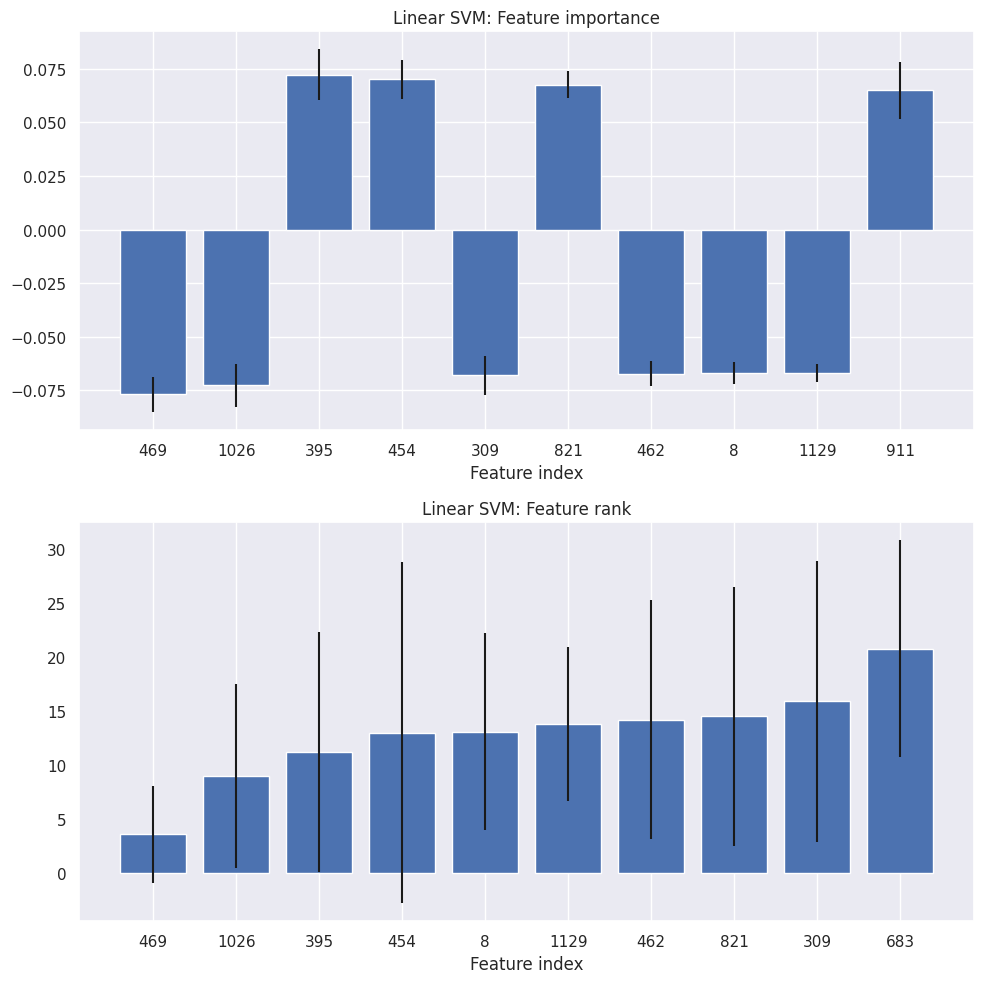

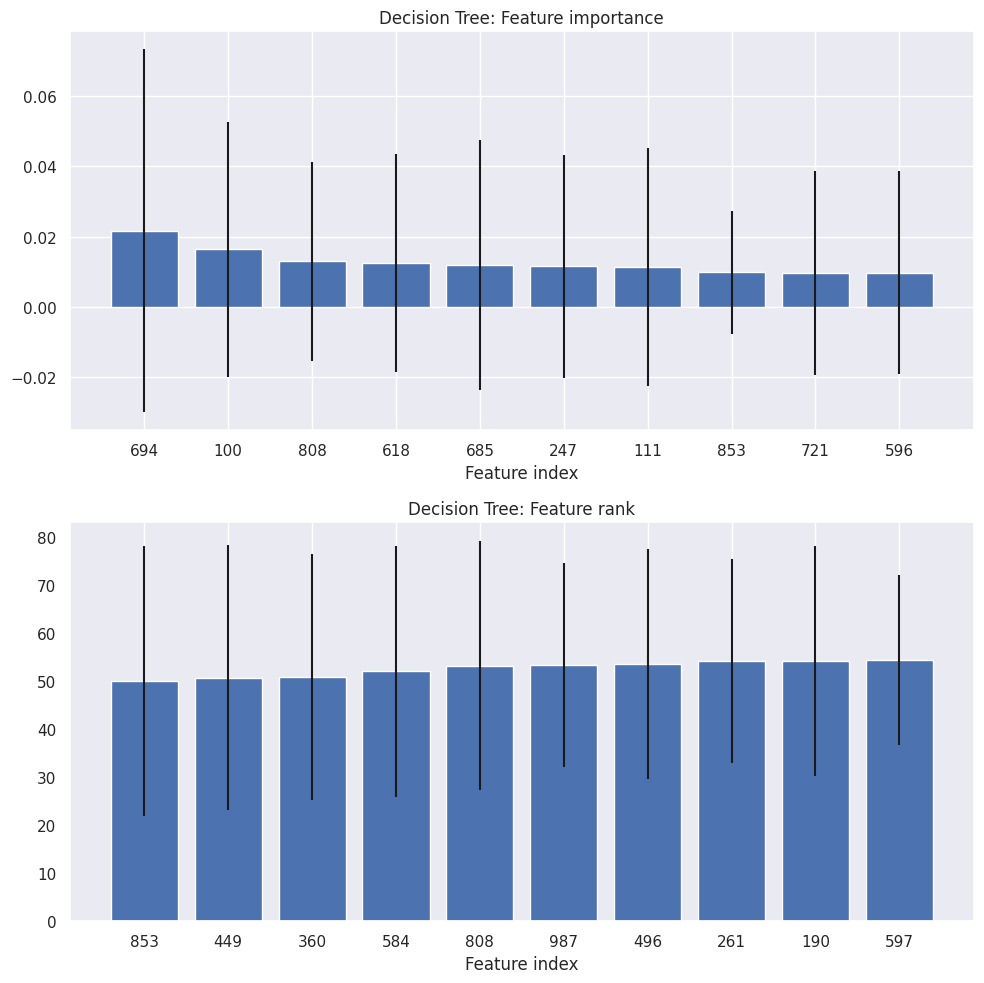

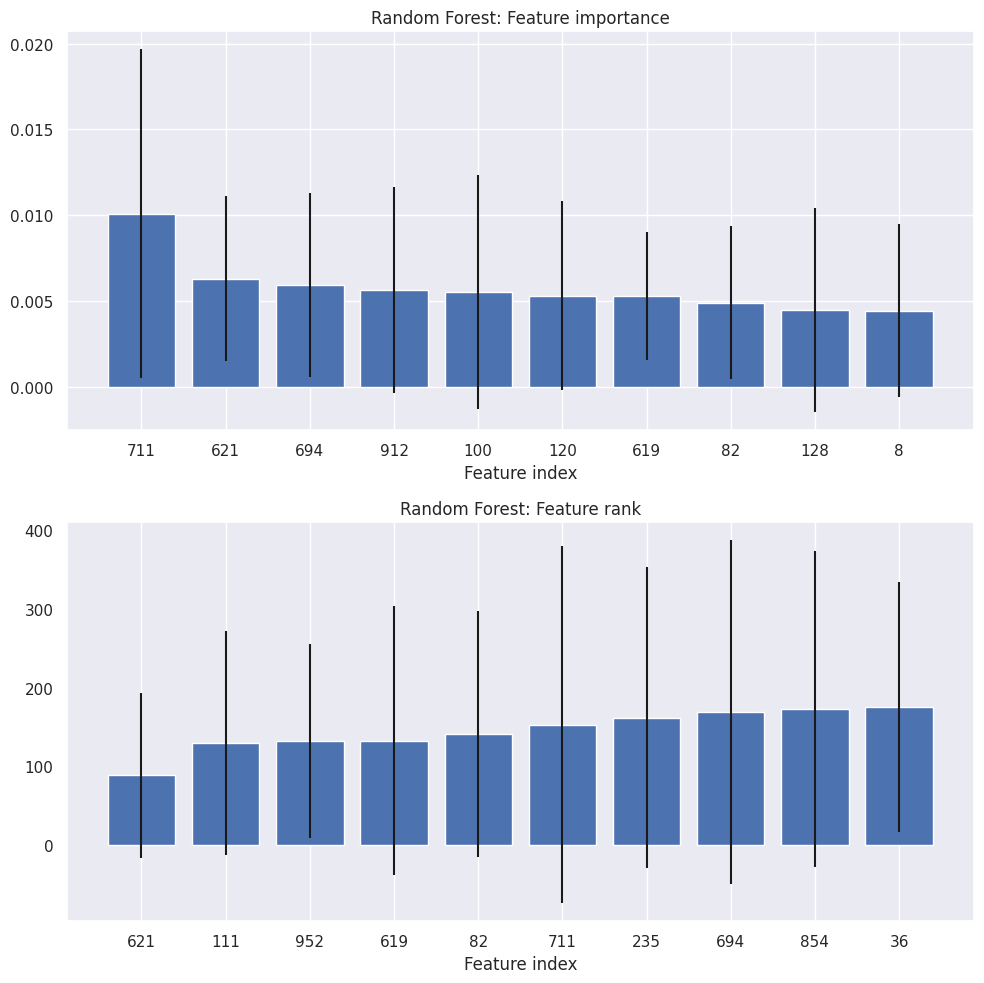

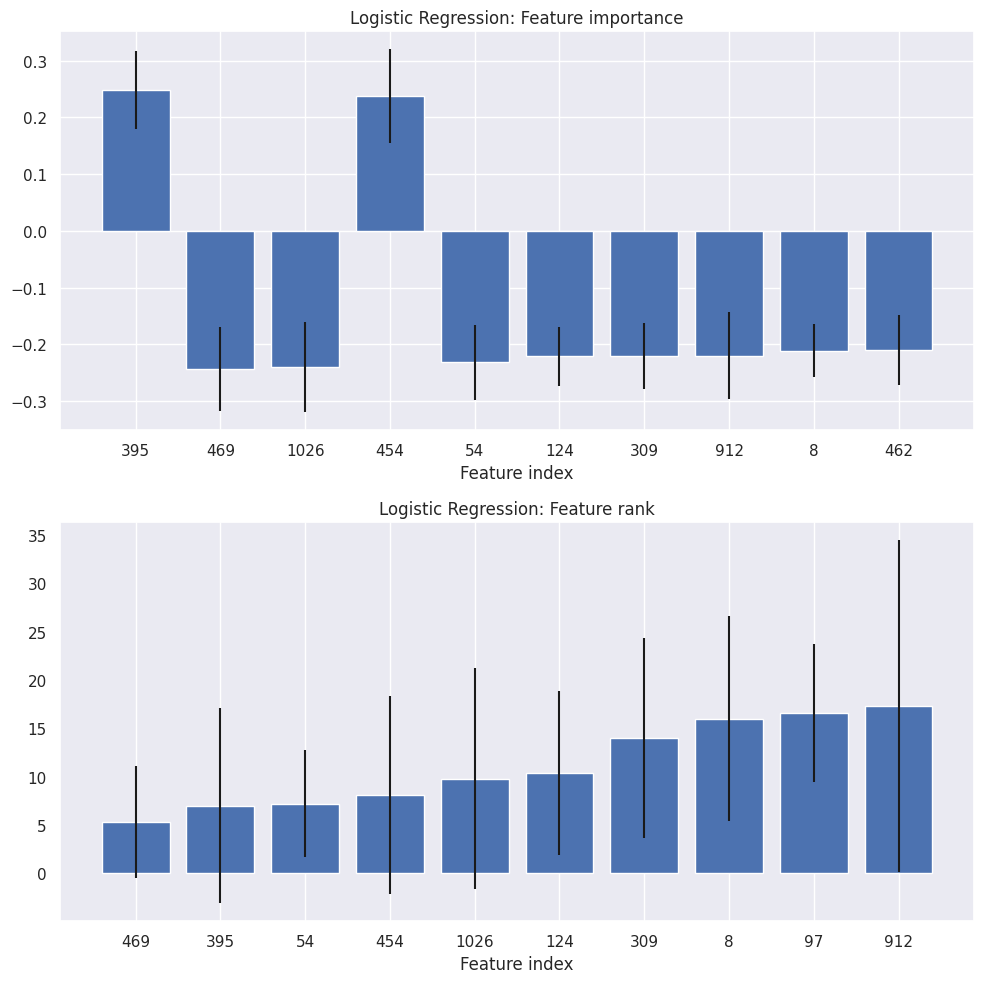

In [18]:
run_polyssifier.plot_features(ntop=10)